# (0) Driveのマウント と Signate API

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'signate.json'", fields="files(id)").execute()
signate_api_key = results.get('files', [])

filename = "/root/.signate/signate.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=signate_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [5]:
!pip install signate

In [6]:
!signate files --competition-id=1523

  fileId  name               title                     size  updated_at
--------  -----------------  ----------------------  ------  -------------------
    3939  train.csv          学習用データ            494008  2024-08-01 12:00:28
    3940  test.csv           評価用データ            488363  2024-08-01 12:00:38
    3944  sample_submit.csv  応募用サンプルファイル   86893  2024-08-01 12:00:49
    4057  tutorial.ipynb     チュートリアルコード    323126  2024-08-01 12:01:00


In [7]:
!signate download --competition-id=1523

sample_submit.csv

tutorial.ipynb

test.csv

train.csv


Download completed.


# (1) 外部ライブラリのインストール

In [8]:
!pip install kanjize

In [9]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.8 MB/s eta 0:00:00


In [10]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 27.0 MB/s eta 0:00:00


# (2) 前処理

In [403]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# データフレーム読み込み
train_df = pd.read_csv("/content/train.csv")
test_df = pd.read_csv("/content/test.csv")

# データ結合(番号を振り直す)
all_df = pd.concat([train_df,test_df],axis=0,ignore_index=True)
max_row = len(all_df)

In [404]:
###############
# "Age"の処理 #
###############
import unicodedata # 全角を半角に変換
from kanjize import kanji2number # 漢字を数値に変換
import re

# 漢字の判定用
p = re.compile('[一二三四五六七八九十]+')

# nanを-1歳で補完
all_df["Age"] = all_df["Age"].fillna("-1")

# Ageの処理
for i in range(len(all_df)):
# for i in range(max_row):

  # 末尾文字の取得
  tail = all_df.loc[i,"Age"][-1:]

  # 先頭文字が漢字の場合
  if(p.search(all_df.loc[i,"Age"][0])!=None):
    tmp = all_df.loc[i,"Age"][:-1]
    all_df.loc[i,"Age"] = kanji2number(tmp)
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 末尾文字が歳、才、際の場合
  elif((tail=="歳")or(tail=="才")or(tail=="際")):
    all_df.loc[i,"Age"] = all_df.loc[i,"Age"][:-1]
    # 全角を半角に直す
    all_df.loc[i,"Age"] = unicodedata.normalize("NFKC", all_df.loc[i,"Age"])
    all_df.loc[i,"Age"] = int(all_df.loc[i,"Age"])

  # 代の場合
  elif(tail == "代"):
    tmp = all_df.loc[i,"Age"][:-1]

    # 「代」は○5歳に変換する
    tmp = int(tmp)
    # 10代は19歳にする
    if(-1<tmp & tmp<20):
      all_df.loc[i,"Age"] = 19
    elif(tmp>60):
      all_df.loc[i,"Age"] = 61
    else:
      # 10歳で分けて5足す
      tmp = tmp//10 * 10
      all_df.loc[i,"Age"] = tmp + 5

# int型に変換
all_df["Age"] = all_df["Age"].astype(int)

print(all_df.groupby("Age").size())

Age
-1     193
 18     17
 19     28
 20     47
 21     58
 22     81
 23     74
 24     96
 25    193
 26    123
 27    122
 28    160
 29    158
 30    194
 31    217
 32    234
 33    263
 34    234
 35    469
 36    257
 37    238
 38    206
 39    204
 40    188
 41    186
 42    198
 43    170
 44    129
 45    354
 46    146
 47    144
 48    125
 49    136
 50    165
 51    156
 52    154
 53    131
 54    131
 55    252
 56     97
 57     86
 58     63
 59     53
 60     30
 61     14
 65      4
dtype: int64


In [405]:
# カテゴリ列の追加
all_df["Age_cls"] = all_df["Age"].copy()

all_df.loc[all_df["Age"]<0,"Age_cls"] = "不明"
all_df.loc[(all_df["Age"]>=10) & (all_df["Age"]<=20),"Age_cls"] = "20歳以下"
all_df.loc[(all_df["Age"]>=21) & (all_df["Age"]<=25),"Age_cls"] = "21〜25歳"
all_df.loc[(all_df["Age"]>=26) & (all_df["Age"]<=30),"Age_cls"] = "26〜30歳"
all_df.loc[(all_df["Age"]>=31) & (all_df["Age"]<=35),"Age_cls"] = "31〜35歳"
all_df.loc[(all_df["Age"]>=36) & (all_df["Age"]<=40),"Age_cls"] = "36〜40歳"
all_df.loc[(all_df["Age"]>=41) & (all_df["Age"]<=45),"Age_cls"] = "41〜45歳"
all_df.loc[(all_df["Age"]>=46) & (all_df["Age"]<=50),"Age_cls"] = "46〜50歳"
all_df.loc[(all_df["Age"]>=51) & (all_df["Age"]<=55),"Age_cls"] = "51〜55歳"
all_df.loc[all_df["Age"]>=56,"Age_cls"] = "56歳以上"

# 元のカラムを削除する
# all_df = all_df.drop("Age",axis=1)

all_df['Age_cls'] = all_df['Age_cls'].astype('object')
print(all_df.groupby(["Age_cls"]).size())

Age_cls
20歳以下       92
21〜25歳     502
26〜30歳     757
31〜35歳    1417
36〜40歳    1093
41〜45歳    1037
46〜50歳     716
51〜55歳     824
56歳以上      347
不明         193
dtype: int64


<ipython-input-405-6e1667c3d861>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["Age"]<0,"Age_cls"] = "不明"


In [406]:
#########################
# "TypeofContact"の処理 #
#########################
print(all_df.groupby("TypeofContact").size())

TypeofContact
Company Invited    2516
Self Enquiry       4444
dtype: int64


In [407]:
#########################
# "CityTier"の処理 #
#########################
all_df["CityTier"] = all_df["CityTier"].astype("object")
print(all_df.groupby("CityTier").size())

CityTier
1    2991
2    3160
3     827
dtype: int64


In [408]:
#########################
# "DurationOfPitch"の処理 #
#########################
# nanを-1分で補完
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].fillna("-1分")

# 秒を分に変換 #
for i in range(len(all_df)):

  tail = str(all_df.loc[i,"DurationOfPitch"])[-1:]

  if(tail == "秒"):
    tmp = all_df.loc[i,"DurationOfPitch"][:-1]
    all_df.loc[i,"DurationOfPitch"] = float(tmp) / 60.0
  elif(tail == "分"):
    all_df.loc[i,"DurationOfPitch"] = all_df.loc[i,"DurationOfPitch"][:-1]

# int型に変換
all_df["DurationOfPitch"] = all_df["DurationOfPitch"].astype("int")

# 秒に換算
all_df["DurationOfPitch"] = all_df["DurationOfPitch"] * 60
print(all_df.groupby("DurationOfPitch").size())

DurationOfPitch
-60      252
 240       3
 300      43
 360     167
 420     446
 480     671
 540     654
 600     467
 660     306
 720     293
 780     397
 840     518
 900     569
 960     527
 1020    312
 1080    133
 1140     50
 1200     66
 1260     65
 1320     84
 1380    104
 1440     86
 1500     79
 1560     64
 1620     57
 1680     56
 1740     48
 1800     65
 1860     86
 1920     93
 1980     69
 2040     75
 2100     58
 2160     15
dtype: int64


In [409]:
# カテゴリ列の追加
all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch"].copy()

all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"
all_df.loc[(all_df["DurationOfPitch"]>0) & (all_df["DurationOfPitch"]<=400),"DurationOfPitch_cls"] = "400s以下"
all_df.loc[(all_df["DurationOfPitch"]>400) & (all_df["DurationOfPitch"]<=500),"DurationOfPitch_cls"] = "401〜500s"
all_df.loc[(all_df["DurationOfPitch"]>500) & (all_df["DurationOfPitch"]<=600),"DurationOfPitch_cls"] = "501〜600s"
all_df.loc[(all_df["DurationOfPitch"]>600) & (all_df["DurationOfPitch"]<=700),"DurationOfPitch_cls"] = "601〜700s"
all_df.loc[(all_df["DurationOfPitch"]>700) & (all_df["DurationOfPitch"]<=800),"DurationOfPitch_cls"] = "701〜800s"
all_df.loc[(all_df["DurationOfPitch"]>800) & (all_df["DurationOfPitch"]<=900),"DurationOfPitch_cls"] = "801〜900s"
all_df.loc[(all_df["DurationOfPitch"]>900) & (all_df["DurationOfPitch"]<=1000),"DurationOfPitch_cls"] = "901〜1000s"
all_df.loc[(all_df["DurationOfPitch"]>1000) & (all_df["DurationOfPitch"]<=1100),"DurationOfPitch_cls"] = "1001〜1100s"
all_df.loc[(all_df["DurationOfPitch"]>1100) & (all_df["DurationOfPitch"]<=1200),"DurationOfPitch_cls"] = "1101〜1200s"
all_df.loc[(all_df["DurationOfPitch"]>1200) & (all_df["DurationOfPitch"]<=1300),"DurationOfPitch_cls"] = "1201〜1300s"
all_df.loc[(all_df["DurationOfPitch"]>1300) & (all_df["DurationOfPitch"]<=1400),"DurationOfPitch_cls"] = "1301〜1400s"
all_df.loc[(all_df["DurationOfPitch"]>1400) & (all_df["DurationOfPitch"]<=1500),"DurationOfPitch_cls"] = "1401〜1500s"
all_df.loc[all_df["DurationOfPitch"]>1500,"DurationOfPitch_cls"] = "1501s以上"

# 元のカラムを削除
# all_df = all_df.drop("DurationOfPitch", axis=1)

all_df["DurationOfPitch_cls"] = all_df["DurationOfPitch_cls"].astype("object")
print(all_df.groupby(["DurationOfPitch_cls"]).size())

DurationOfPitch_cls
1001〜1100s     445
1101〜1200s     116
1201〜1300s      65
1301〜1400s     188
1401〜1500s     165
1501s以上        686
400s以下         213
401〜500s      1117
501〜600s      1121
601〜700s       306
701〜800s       690
801〜900s      1087
901〜1000s      527
不明             252
dtype: int64


<ipython-input-409-57a532ae39e6>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["DurationOfPitch"]<0,"DurationOfPitch_cls"] = "不明"


In [410]:
####################
# "Occupation"の処理 #
####################
print(all_df.groupby(["Occupation"]).size())

Occupation
Large Business     721
Salaried          2801
Small Business    3456
dtype: int64


In [411]:
##################
# "Genger"の処理 #
##################
# 先頭文字がMかmならMaleになる
for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = unicodedata.normalize("NFKC", all_df.loc[i,"Gender"][:1]).lower()
  if(head == "f"):
    all_df.loc[i,"Gender"] = "Female"
  else:
    all_df.loc[i,"Gender"] = "Male"

# カテゴリ型にキャスト
all_df["Gender"] = all_df["Gender"].astype("object")
print(all_df.groupby(["Gender"]).size())

Gender
Female    2760
Male      4218
dtype: int64


In [412]:
##################################
# "NumberOfPersonVisiting"の処理 #
##################################
print(all_df.groupby(["NumberOfPersonVisiting"]).size())

NumberOfPersonVisiting
1.0     686
2.0    3163
3.0    2773
4.0     356
dtype: int64


In [413]:
##################################
# "NumberOfFollowups"の処理 #
##################################
# 欠損を-1で埋める
all_df["NumberOfFollowups"] = all_df["NumberOfFollowups"].fillna(-1)

# 100回以上は記録違いとして100で割る
all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] = all_df.loc[all_df["NumberOfFollowups"]>=100,"NumberOfFollowups"] / 100

# 分布の確認
print(all_df.groupby(["NumberOfFollowups"]).size())

NumberOfFollowups
-1.0      57
 1.0     178
 2.0     213
 3.0    2561
 4.0    2777
 5.0    1122
 6.0      70
dtype: int64


In [414]:
# カテゴリ列の追加
all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups"].copy()

all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"
all_df.loc[all_df["NumberOfFollowups"]==1,"NumberOfFollowups_cls"] = "1回"
all_df.loc[all_df["NumberOfFollowups"]==2,"NumberOfFollowups_cls"] = "2回"
all_df.loc[all_df["NumberOfFollowups"]==3,"NumberOfFollowups_cls"] = "3回"
all_df.loc[all_df["NumberOfFollowups"]==4,"NumberOfFollowups_cls"] = "4回"
all_df.loc[all_df["NumberOfFollowups"]==5,"NumberOfFollowups_cls"] = "5回"
all_df.loc[all_df["NumberOfFollowups"]==6,"NumberOfFollowups_cls"] = "6回"

# 元のカラムを削除する
# all_df = all_df.drop("NumberOfFollowups", axis=1)

all_df["NumberOfFollowups_cls"] = all_df["NumberOfFollowups_cls"].astype("object")
print(all_df.groupby(["NumberOfFollowups_cls"]).size())

NumberOfFollowups_cls
1回     178
2回     213
3回    2561
4回    2777
5回    1122
6回      70
不明      57
dtype: int64


<ipython-input-414-90adc46ed6cf>:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["NumberOfFollowups"]==-1,"NumberOfFollowups_cls"] = "不明"


In [415]:
##########################
# "ProductPitched"の処理 #
##########################
# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdib"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# Basic, Standard, Deluxe, Super Deluxe, kingに分ける
prefix = 0
others = []
# すべて小文字に変換し判定
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"ProductPitched"][:2].lower())).lower()

  if(prefix == "ba"):
    all_df.loc[i,"ProductPitched"] = "Basic"

  elif(prefix == "st"):
    all_df.loc[i,"ProductPitched"] = "Standard"

  elif(prefix == "de"):
    all_df.loc[i,"ProductPitched"] = "Deluxe"

  elif(prefix == "su"):
    all_df.loc[i,"ProductPitched"] = "SuperDeluxe"

  elif(prefix == "ki"):
    all_df.loc[i,"ProductPitched"] = "King"

  else:
    others.append(i)

all_df["ProductPitched"] = all_df["ProductPitched"].astype("object")

# 分布の確認
print(all_df.groupby(["ProductPitched"]).size())

ProductPitched
Basic          2347
Deluxe         2091
King            286
Standard       1614
SuperDeluxe     640
dtype: int64


In [416]:
#################################
# "PreferredPropertyStar"の処理 #
#################################
print(all_df.groupby(["PreferredPropertyStar"]).size())

PreferredPropertyStar
3.0    4328
4.0    2254
5.0     396
dtype: int64


In [417]:
#########################
# "NumberOfTrips"の処理 #
#########################
# nanは-1で補完
all_df["NumberOfTrips_num"] = [0]*len(all_df)
all_df["NumberOfTrips_num"] = -1

all_df["NumberOfTrips_num"] = all_df["NumberOfTrips_num"].astype(int)

all_df["NumberOfTrips"] = all_df["NumberOfTrips"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得(半角)
  head = all_df.loc[i,"NumberOfTrips"][:1]

  if(head == "年"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][2:3])

  elif(head == "半"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][3:4])*2

  elif(head == "四"):
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"][4:5])*4

  elif(head == "-1"):
    all_df.loc[i,"NumberOfTrips_num"] = -1

  else:
    all_df.loc[i,"NumberOfTrips_num"] = int(all_df.loc[i,"NumberOfTrips"])

print(all_df.groupby(["NumberOfTrips_num"]).size())

NumberOfTrips_num
-1      64
 1     801
 2    2277
 3    1706
 4     333
 5     977
 6     281
 7     513
 8      26
dtype: int64


In [418]:
# 名前を元に戻す
all_df["NumberOfTrips"] = all_df["NumberOfTrips_num"].copy()
all_df = all_df.drop("NumberOfTrips_num", axis=1)

In [419]:
#########################
# "Passport"の処理 #
#########################
# カテゴリ型に変更
all_df.loc[all_df["Passport"]==0,"Passport"] = "パスポート非所持"
all_df.loc[all_df["Passport"]==1,"Passport"] = "パスポート所持"
print(all_df.groupby(["Passport"]).size())

Passport
パスポート所持      690
パスポート非所持    6288
dtype: int64


<ipython-input-419-96949273968e>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'パスポート非所持' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["Passport"]==0,"Passport"] = "パスポート非所持"


In [420]:
##################################
# "PitchSatisfactionScore"の処理 #
##################################
print(all_df.groupby(["PitchSatisfactionScore"]).size())

PitchSatisfactionScore
1    1439
2    2500
3    1344
4    1452
5     243
dtype: int64


In [421]:
#########################
# "Designation"の処理 #
#########################

# ギリシャ文字をアルファベットに変換
greek_string = "αβγδεζηθικλμνξοπρστυφχψωвꓢѕꭰտᗞı𐊡Аае"
alphabet_string = "abgdezhqiklmnxoprstufcywbssdsdibaae"

def greek_to_alphabet(text):
    result = ""
    for char in text:
        if char in greek_string:
            result += alphabet_string[greek_string.index(char)]
        else:
            result += char  # ギリシャ文字以外の文字はそのまま
    return result

# 文字を変換する
prefix = 0
for i in range(len(all_df)):
  prefix = unicodedata.normalize("NFKC", greek_to_alphabet(all_df.loc[i,"Designation"][:1].lower())).lower()

  # Executive: 取締役、執行役員
  if(prefix == "e"):
    all_df.loc[i,"Designation"] = "Executive"

  # Vice President: 本部長
  elif(prefix == "v"):
    all_df.loc[i,"Designation"] = "VP"

  # Associate Vice President: 本部長補佐
  elif(prefix == "a"):
    all_df.loc[i,"Designation"] = "AVP"

  # Senior Manager: 次長
  elif(prefix == "s"):
    all_df.loc[i,"Designation"] = "Senior Manager"

  # Manager: 課長
  elif(prefix == "m"):
    all_df.loc[i,"Designation"] = "Manager"

all_df["Designation"] = all_df["Designation"].astype("object")

# 分布の確認
print(all_df.groupby(["Designation"]).size())

Designation
AVP                635
Executive         2330
Manager           2117
Senior Manager    1632
VP                 264
dtype: int64


In [422]:
#########################
# "MonthlyIncome"の処理 #
#########################
import re

# 漢字の判定用
p = re.compile('[月]+')

# nanを-1で補完
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].fillna("-1")

for i in range(len(all_df)):

  # 先頭文字の取得
  head = all_df.loc[i,"MonthlyIncome"][:1]

  # 先頭文字が漢字の場合
  if(p.search(head[0])!=None):
    tmp = all_df.loc[i,"MonthlyIncome"][2:-2]
    all_df.loc[i,"MonthlyIncome"] = float(tmp)*10000

# float型にキャストする
all_df["MonthlyIncome"] = all_df["MonthlyIncome"].astype(float)

print(all_df.groupby(["MonthlyIncome"]).size())

MonthlyIncome
-1.0         105
 200000.0      5
 238890.0      1
 239340.0      1
 240000.0      2
            ... 
 578460.0      1
 578490.0      1
 578670.0      1
 579015.0      1
 600000.0     10
Length: 4586, dtype: int64


In [423]:
all_df["MonthlyIncome_cls"] = all_df["MonthlyIncome"].copy()

all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"
all_df.loc[(all_df["MonthlyIncome"]>0) & (all_df["MonthlyIncome"]<=250000),"MonthlyIncome_cls"] = "25万円以下"
all_df.loc[(all_df["MonthlyIncome"]>250000) & (all_df["MonthlyIncome"]<=300000),"MonthlyIncome_cls"] = "25〜30万円"
all_df.loc[(all_df["MonthlyIncome"]>300000) & (all_df["MonthlyIncome"]<=350000),"MonthlyIncome_cls"] = "30〜35万円"
all_df.loc[(all_df["MonthlyIncome"]>350000) & (all_df["MonthlyIncome"]<=400000),"MonthlyIncome_cls"] = "35〜40万円"
all_df.loc[(all_df["MonthlyIncome"]>400000), "MonthlyIncome_cls"] = "40万円以上"

# 元のカラムを削除する
# all_df = all_df.drop("MonthlyIncome", axis=1)

print(all_df.groupby(["MonthlyIncome_cls"]).size())

MonthlyIncome_cls
25〜30万円    1679
25万円以下       71
30〜35万円    2035
35〜40万円    1554
40万円以上     1534
不明          105
dtype: int64


<ipython-input-423-0c60a35ea570>:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '不明' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  all_df.loc[all_df["MonthlyIncome"]<=0,"MonthlyIncome_cls"] = "不明"


In [424]:
# ProdTaken
print(all_df.groupby(["ProdTaken"]).size())

ProdTaken
0.0    2992
1.0     497
dtype: int64


In [425]:
#########################
# "customer_info"の処理 #
#########################
import re

# 項目名
cont = []

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      if(tmp[j] not in cont):
        cont.append(tmp[j])

# キーワード抽出
c_car = [] # 車関係
c_child = [] # 子供関係
c_married = [] # 婚姻関係
c_other = [] # その他

for i in range(len(cont)):
  # 「車あり」、「車所持」、「自家用車あり」、「車保有」、「乗用車所持」、「自動車保有」
  # 「車なし」、「車未所持」、「自家用車なし」、「車保有なし」、「乗用車なし」、「自動車未所有」
  if((cont[i][0:1] == "車") or (cont[i][0:1] == "自") or (cont[i][0:1] == "乗")):
    c_car.append(cont[i])
  # 「こども1人」、「1児」、「子供1人」、「子供有り(1人)」、「子供有り」
  # 「こども2人」、「2児」、「子供2人」、「子供有り(2人)」
  # 「こども3人」、「3児」「子供3人」、「子供有り(3人)」
  # 「子供なし」、「子供無し」、「無子」、「子供ゼロ」、「非児童家庭」、「わからない」
  # 「子育て状況不明」、「子の数不詳」、「子供の数不明」
  elif((cont[i][0:1] == "子") or (cont[i][0:1] == "こ") or (cont[i][-1:] == "児") or (cont[i][-1:] == "子") or (cont[i][-1:] == "庭") or (cont[i][-1:] == "い")):
    c_child.append(cont[i])
  # 「結婚済み」、「離婚済み」、「未婚」、「独身」
  elif((cont[i][0:1] == "結") or (cont[i][0:1] == "離") or (cont[i][0:1] == "独") or (cont[i][0:1] == "離") or (cont[i][0:1] == "未")):
    c_married.append(cont[i])
  # 「1人」、「2人」、「3人」、「不明」
  else:
    c_other.append(cont[i])

In [426]:
# 新たなカラムを追加
all_df["CarHolder"] = "自動車未所有" # 車所有
all_df["NumofChild"] = "不明" # 子供の数
all_df["Married"] = "独身" # 婚姻歴

# 車
c_car_hold = ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有",
              "車未所持","自動車未所有","車保有なし","乗用車なし","自家用車なし","車なし"]

# 子供
c_child_x = ['子育て状況不明', '子の数不詳', '子供の数不明','わからない',"子供有り"]
c_child_0 = ['子供なし', '子供無し', '無子', '子供ゼロ', '非育児家庭']
c_child_1 = ["こども1人","1児","子供1人","子供有り(1人)"]
c_child_2 = ["こども2人","2児","子供2人","子供有り(2人)"]
c_child_3 = ["こども3人","3児","子供3人","子供有り(3人)"]

# 婚姻状況
c_pair = ["結婚済み"]
c_batu = ["離婚済み"]

# 区切り文字で分割する
for i in range(len(all_df)):
  tmp = re.split("[ 　,、\n\t/／\u3000]",all_df.loc[i,"customer_info"])
  tmp = list(filter(None, tmp))
  if(type(tmp)==list):
    for j in range(len(tmp)):
      # 車の情報
      if(tmp[j] in c_car_hold):
        if(tmp[j] in ["車あり","車所持","自家用車あり","車保有","乗用車所持","自動車所有"]):
          all_df.loc[i, "CarHolder"] = "自動車所有"
      # 子供の情報
      if(tmp[j] in c_child_x):
        all_df.loc[i, "NumofChild"] = "不明"
      if(tmp[j] in c_child_0):
        all_df.loc[i, "NumofChild"] = "子供なし"
      if(tmp[j] in c_child_1):
        all_df.loc[i, "NumofChild"] = "子供1人"
      if(tmp[j] in c_child_2):
        all_df.loc[i, "NumofChild"] = "子供2人"
      if(tmp[j] in c_child_3):
        all_df.loc[i, "NumofChild"] = "子供3人"
      # 婚姻歴
      if(tmp[j] in c_pair):
        all_df.loc[i, "Married"] = "結婚済み"
      if(tmp[j] in c_batu):
        all_df.loc[i, "Married"] = "離婚済み"

# 使用済みカラム抹消
all_df = all_df.drop("customer_info", axis=1)

In [427]:
# 車保有率
all_df["CarHolder"] = all_df["CarHolder"].astype("object")
print(all_df.groupby(["CarHolder"]).size())

CarHolder
自動車所有     3359
自動車未所有    3619
dtype: int64


In [428]:
# 子供の数
all_df["NumofChild"] = all_df["NumofChild"].astype("object")
print(all_df.groupby(["NumofChild"]).size())

NumofChild
不明       395
子供1人    2945
子供2人    1600
子供3人     129
子供なし    1909
dtype: int64


In [429]:
# 婚姻歴
all_df["Married"] = all_df["Married"].astype("object")
print(all_df.groupby(["Married"]).size())

Married
独身      2444
結婚済み    2846
離婚済み    1688
dtype: int64


# (3) データエンジニアリング

In [313]:
# カラム全体
all_df.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [ ]:
# 追加したカテゴリ列は削除する
# all_df = all_df.drop(["DurationOfPitch_cls", "NumberOfFollowups_cls"], axis=1)
# all_df = all_df.drop(["Age_cls", "DurationOfPitch_cls", "NumberOfFollowups_cls", "MonthlyIncome_cls"], axis=1)

In [38]:
# # Occupationを小規模、大規模、サラリーのワンホットにする
# all_df["LargeBusiness"] = 0
# all_df["SmallBusiness"] = 0
# all_df["Salaried"] = 0

# # LargeBusinessの区分け
# all_df.loc[all_df["Occupation"]=="Large Business", "LargeBusiness"] = 1
# # SmallBusinessの区分け
# all_df.loc[all_df["Occupation"]=="Small Business", "SmallBusiness"] = 1
# # Salariedの区分け
# all_df.loc[all_df["Occupation"]=="Salaried", "Salaried"] = 1
# # 元のカラムを削除
# all_df = all_df.drop("Occupation", axis=1)

In [39]:
# # Marriedをワンホットにする
# all_df["Marry"] = 0
# all_df["Divorced"] = 0
# all_df["Single"] = 0

# # LargeBusinessの区分け
# all_df.loc[all_df["Married"]=="結婚済み", "Marry"] = 1
# # SmallBusinessの区分け
# all_df.loc[all_df["Married"]=="離婚済み", "Divorced"] = 1
# # Salariedの区分け
# all_df.loc[all_df["Married"]=="独身", "Single"] = 1
# # 元のカラムを削除
# all_df = all_df.drop("Married", axis=1)

In [ ]:
# # GenderをMaleに変更する
# # Gender: 女性(0)、男性(1) -> Male
# all_df.rename(columns={"Gender":"Male"}, inplace=True)

# # Maleを1にする
# all_df.loc[all_df["Male"]=="Male", "Male"] = 1
# all_df.loc[all_df["Male"]=="Female", "Male"] = 0

In [ ]:
# # ProductPitchedを区分けする
# # ProductPitched: Basic(1), Standard(2), Deluxe(3), SuperDeluxe(4), King(5)
# all_df.loc[all_df["ProductPitched"]=="Basic", "ProductPitched"] = 1
# all_df.loc[all_df["ProductPitched"]=="Standard", "ProductPitched"] = 2
# all_df.loc[all_df["ProductPitched"]=="Deluxe", "ProductPitched"] = 3
# all_df.loc[all_df["ProductPitched"]=="SuperDeluxe", "ProductPitched"] = 4
# all_df.loc[all_df["ProductPitched"]=="King", "ProductPitched"] = 5

In [ ]:
# # Designationを区分けする
# # Designation: Manager(1), Senior Manager(2), AVP(3), VP(4), Executive(5)
# all_df.loc[all_df["Designation"]=="Manager", "Designation"] = 1
# all_df.loc[all_df["Designation"]=="Senior Manager", "Designation"] = 2
# all_df.loc[all_df["Designation"]=="AVP", "Designation"] = 3
# all_df.loc[all_df["Designation"]=="VP", "Designation"] = 4
# all_df.loc[all_df["Designation"]=="Executive", "Designation"] = 5

In [ ]:
# # 自動車保有をラベルエンコード
# # CarHolder: 自動車未所有(0)、自動車所有(1)
# all_df.loc[all_df["CarHolder"]=="自動車所有","CarHolder"] = 1
# all_df.loc[all_df["CarHolder"]=="自動車未所有","CarHolder"] = 0

In [40]:
# PreferredPropertyStarは1始まりにする
# all_df["PreferredPropertyStar"] = all_df["PreferredPropertyStar"] - 2

In [52]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6978 entries, 0 to 6977
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      6978 non-null   int64  
 1   Age                     6978 non-null   int64  
 2   TypeofContact           6960 non-null   object 
 3   CityTier                6978 non-null   object 
 4   DurationOfPitch         6978 non-null   int64  
 5   Occupation              6978 non-null   object 
 6   Gender                  6978 non-null   object 
 7   NumberOfPersonVisiting  6978 non-null   float64
 8   NumberOfFollowups       6978 non-null   float64
 9   ProductPitched          6978 non-null   object 
 10  PreferredPropertyStar   6978 non-null   float64
 11  NumberOfTrips           6978 non-null   int64  
 12  Passport                6978 non-null   object 
 13  PitchSatisfactionScore  6978 non-null   int64  
 14  Designation             6978 non-null   

In [430]:
# 結合を戻す
train = all_df.iloc[:len(train_df)].copy()
test = all_df.iloc[len(train_df):].reset_index(drop=True).copy()

In [431]:
# 欠損値を最頻値で補完
train["TypeofContact"] = train["TypeofContact"].fillna(train["TypeofContact"].mode()[0])
test["TypeofContact"] = test["TypeofContact"].fillna(test["TypeofContact"].mode()[0])

In [432]:
# 一時的に「-1」としていた欠損値も最頻値で補完
train.loc[train["Age"]==-1,"Age"] = train.loc[train["Age"]>0,"Age"].mode()[0]
test.loc[test["Age"]==-1,"Age"] = test.loc[test["Age"]>0,"Age"].mode()[0]

train.loc[train["DurationOfPitch"]==-1,"DurationOfPitch"] = train.loc[train["DurationOfPitch"]>0,"DurationOfPitch"].mode()[0]
test.loc[test["DurationOfPitch"]==-1,"DurationOfPitch"] = test.loc[test["DurationOfPitch"]>0,"DurationOfPitch"].mode()[0]

train.loc[train["NumberOfFollowups"]==-1,"NumberOfFollowups"] = train.loc[train["NumberOfFollowups"]>0,"NumberOfFollowups"].mode()[0]
test.loc[test["NumberOfFollowups"]==-1,"NumberOfFollowups"] = test.loc[test["NumberOfFollowups"]>0,"NumberOfFollowups"].mode()[0]

train.loc[train["MonthlyIncome"]==-1,"MonthlyIncome"] = train.loc[train["MonthlyIncome"]>0,"MonthlyIncome"].mode()[0]
test.loc[test["MonthlyIncome"]==-1,"MonthlyIncome"] = test.loc[test["MonthlyIncome"]>0,"MonthlyIncome"].mode()[0]

train.loc[train["NumberOfTrips"]==-1,"NumberOfTrips"] = train.loc[train["NumberOfTrips"]>0,"NumberOfTrips"].mode()[0]
test.loc[test["NumberOfTrips"]==-1,"NumberOfTrips"] = test.loc[test["NumberOfTrips"]>0,"NumberOfTrips"].mode()[0]

In [433]:
# # TypeofContactをCompanyInvitedに変更
# # TypeofContact: 個人(0)、法人(1) -> CompanyInvited
# train.rename(columns={"TypeofContact":"CompanyInvited"}, inplace=True)
# test.rename(columns={"TypeofContact":"CompanyInvited"}, inplace=True)

# # CompanyInvitedを1にする
# train.loc[train["CompanyInvited"]=="Company Invited", "CompanyInvited"] = 1
# train.loc[train["CompanyInvited"]=="Self Enquiry", "CompanyInvited"] = 0

# test.loc[test["CompanyInvited"]=="Company Invited", "CompanyInvited"] = 1
# test.loc[test["CompanyInvited"]=="Self Enquiry", "CompanyInvited"] = 0

In [434]:
# # NumofChild: 子供なし(0)、子供１人(1)、子供2人(2)、子供3人(3)
# # 不明は最頻値にする
# train.loc[train["NumofChild"]=="不明","NumofChild"] = train["NumofChild"].mode()[0]
# train.loc[train["NumofChild"]=="子供なし", "NumofChild"] = 0
# train.loc[train["NumofChild"]=="子供1人", "NumofChild"] = 1
# train.loc[train["NumofChild"]=="子供2人", "NumofChild"] = 2
# train.loc[train["NumofChild"]=="子供3人", "NumofChild"] = 3

# test.loc[test["NumofChild"]=="不明","NumofChild"] = test["NumofChild"].mode()[0]
# test.loc[test["NumofChild"]=="子供なし", "NumofChild"] = 0
# test.loc[test["NumofChild"]=="子供1人", "NumofChild"] = 1
# test.loc[test["NumofChild"]=="子供2人", "NumofChild"] = 2
# test.loc[test["NumofChild"]=="子供3人", "NumofChild"] = 3

In [435]:
# # Age_cls: ラベルエンコード
# train.loc[train["Age_cls"]=="不明","Age_cls"] = -1
# train.loc[train["Age_cls"]=="20歳以下", "Age_cls"] = 1
# train.loc[train["Age_cls"]=="21〜25歳", "Age_cls"] = 2
# train.loc[train["Age_cls"]=="26〜30歳", "Age_cls"] = 3
# train.loc[train["Age_cls"]=="31〜35歳", "Age_cls"] = 4
# train.loc[train["Age_cls"]=="36〜40歳", "Age_cls"] = 5
# train.loc[train["Age_cls"]=="41〜45歳", "Age_cls"] = 6
# train.loc[train["Age_cls"]=="46〜50歳", "Age_cls"] = 7
# train.loc[train["Age_cls"]=="51〜55歳", "Age_cls"] = 8
# train.loc[train["Age_cls"]=="56歳以上", "Age_cls"] = 9
# train.loc[train["Age_cls"]==-1,"Age_cls"] = train["Age_cls"].mode()[0]

# test.loc[test["Age_cls"]=="不明","Age_cls"] = -1
# test.loc[test["Age_cls"]=="20歳以下", "Age_cls"] = 1
# test.loc[test["Age_cls"]=="21〜25歳", "Age_cls"] = 2
# test.loc[test["Age_cls"]=="26〜30歳", "Age_cls"] = 3
# test.loc[test["Age_cls"]=="31〜35歳", "Age_cls"] = 4
# test.loc[test["Age_cls"]=="36〜40歳", "Age_cls"] = 5
# test.loc[test["Age_cls"]=="41〜45歳", "Age_cls"] = 6
# test.loc[test["Age_cls"]=="46〜50歳", "Age_cls"] = 7
# test.loc[test["Age_cls"]=="51〜55歳", "Age_cls"] = 8
# test.loc[test["Age_cls"]=="56歳以上", "Age_cls"] = 9
# test.loc[test["Age_cls"]==-1,"Age_cls"] = test["Age_cls"].mode()[0]

In [ ]:
# # MonthlyIncome_cls: ラベルエンコード
# train.loc[train["MonthlyIncome_cls"]=="不明","MonthlyIncome_cls"] = -1
# train.loc[train["MonthlyIncome_cls"]=="25万円以下", "MonthlyIncome_cls"] = 1
# train.loc[train["MonthlyIncome_cls"]=="25〜30万円", "MonthlyIncome_cls"] = 2
# train.loc[train["MonthlyIncome_cls"]=="30〜35万円", "MonthlyIncome_cls"] = 3
# train.loc[train["MonthlyIncome_cls"]=="35〜40万円", "MonthlyIncome_cls"] = 4
# train.loc[train["MonthlyIncome_cls"]=="40万円以上", "MonthlyIncome_cls"] = 5
# train.loc[train["MonthlyIncome_cls"]==-1,"MonthlyIncome_cls"] = train["MonthlyIncome_cls"].mode()[0]

# test.loc[test["MonthlyIncome_cls"]=="不明","MonthlyIncome_cls"] = -1
# test.loc[test["MonthlyIncome_cls"]=="25万円以下", "MonthlyIncome_cls"] = 1
# test.loc[test["MonthlyIncome_cls"]=="25〜30万円", "MonthlyIncome_cls"] = 2
# test.loc[test["MonthlyIncome_cls"]=="30〜35万円", "MonthlyIncome_cls"] = 3
# test.loc[test["MonthlyIncome_cls"]=="35〜40万円", "MonthlyIncome_cls"] = 4
# test.loc[test["MonthlyIncome_cls"]=="40万円以上", "MonthlyIncome_cls"] = 5
# test.loc[test["MonthlyIncome_cls"]==-1,"MonthlyIncome_cls"] = test["MonthlyIncome_cls"].mode()[0]

In [56]:
# 欠損なし
print(train.isnull().sum())

id                        0
Age                       0
TypeofContact             0
CityTier                  0
DurationOfPitch           0
Occupation                0
Gender                    0
NumberOfPersonVisiting    0
NumberOfFollowups         0
ProductPitched            0
PreferredPropertyStar     0
NumberOfTrips             0
Passport                  0
PitchSatisfactionScore    0
Designation               0
MonthlyIncome             0
ProdTaken                 0
Age_cls                   0
DurationOfPitch_cls       0
NumberOfFollowups_cls     0
MonthlyIncome_cls         0
CarHolder                 0
NumofChild                0
Married                   0
dtype: int64


In [57]:
# 欠損なし
print(test.isnull().sum())

id                           0
Age                          0
TypeofContact                0
CityTier                     0
DurationOfPitch              0
Occupation                   0
Gender                       0
NumberOfPersonVisiting       0
NumberOfFollowups            0
ProductPitched               0
PreferredPropertyStar        0
NumberOfTrips                0
Passport                     0
PitchSatisfactionScore       0
Designation                  0
MonthlyIncome                0
ProdTaken                 3489
Age_cls                      0
DurationOfPitch_cls          0
NumberOfFollowups_cls        0
MonthlyIncome_cls            0
CarHolder                    0
NumofChild                   0
Married                      0
dtype: int64


In [58]:
train.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [ ]:
# # キャストする
# # ['CompanyInvited', 'Male', 'ProductPitched', 'Designation', 'CarHolder', 'NumofChild']
# train["CompanyInvited"] = train["CompanyInvited"].astype(int)
# test["CompanyInvited"] = test["CompanyInvited"].astype(int)
# train["Male"] = train["Male"].astype(int)
# test["Male"] = test["Male"].astype(int)
# train["ProductPitched"] = train["ProductPitched"].astype(int)
# test["ProductPitched"] = test["ProductPitched"].astype(int)
# train["Designation"] = train["Designation"].astype(int)
# test["Designation"] = test["Designation"].astype(int)
# train["CarHolder"] = train["CarHolder"].astype(int)
# test["CarHolder"] = test["CarHolder"].astype(int)
# train["NumofChild"] = train["NumofChild"].astype(int)
# test["NumofChild"] = test["NumofChild"].astype(int)

# (3)-2 工夫

In [119]:
train.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'Age_cls', 'DurationOfPitch_cls', 'NumberOfFollowups_cls',
       'MonthlyIncome_cls', 'CarHolder', 'NumofChild', 'Married'],
      dtype='object')

In [365]:
# 「都市ランク」x「性別」
train["CityTier_Gender"] = train["CityTier"].astype(str)+"_"+train["Gender"].astype(str)
test["CityTier_Gender"] = test["CityTier"].astype(str)+"_"+test["Gender"].astype(str)


In [385]:
# クロス元を削除する
train = train.drop("CityTier_Gender",axis=1)
test = test.drop("CityTier_Gender",axis=1)

In [471]:
# 「役職」x「商品ランク」
train["Designation_ProductPitched"] = train["Designation"].astype(str)+"_"+train["ProductPitched"].astype(str)
test["Designation_ProductPitched"] = test["Designation"].astype(str)+"_"+test["ProductPitched"].astype(str)

In [386]:
# クロス特徴量の追加
# 「役職」x「月収bin」
# train["Designation_MonthlyIncome_cls"] = train["Designation"].astype(str)+"_"+train["MonthlyIncome_cls"].astype(str)
# test["Designation_MonthlyIncome_cls"] = test["Designation"].astype(str)+"_"+test["MonthlyIncome_cls"].astype(str)

In [321]:
# 「パスポート」x「年齢」
# train["Passport_Age_cls"] = train["Passport"].astype(str)+"_"+train["Age_cls"].astype(str)
# test["Passport_Age_cls"] = test["Passport"].astype(str)+"_"+test["Age_cls"].astype(str)

In [322]:
# 「独身」x「商品ランク」
# train["Married_ProductPitched"] = train["Married"].astype(str)+"_"+train["ProductPitched"].astype(str)
# test["Married_ProductPitched"] = test["Married"].astype(str)+"_"+test["ProductPitched"].astype(str)

In [323]:
# 「子供の数」x「年間旅行数」
# train["NumberOfChild_NumberOfTrips"] = train["NumofChild"].astype(str)+"_"+train["NumberOfTrips"].astype(str)
# test["NumberOfChild_NumberOfTrips"] = test["NumofChild"].astype(str)+"_"+test["NumberOfTrips"].astype(str)

In [142]:
test.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'Age_cls',
       'DurationOfPitch_cls', 'NumberOfFollowups_cls', 'MonthlyIncome_cls',
       'CarHolder', 'NumofChild', 'Married', 'Designation_MonthlyIncome_cls',
       'Passport_Age'],
      dtype='object')

In [453]:
train = train.drop("MonthlyIncome_cls",axis=1)
test = test.drop("MonthlyIncome_cls",axis=1)

In [454]:
# クロス元を削除する
train = train.drop("Age_cls",axis=1)
test = test.drop("Age_cls",axis=1)

In [ ]:
# 「役職」x「」

In [ ]:
# 「商品ランク」x「月収bin」
# train["ProductPitched_MonthlyIncome_cls"] = train["ProductPitched"].astype(str)+"_"+train["MonthlyIncome_cls"].astype(str)
# test["ProductPitched_MonthlyIncome_cls"] = test["ProductPitched"].astype(str)+"_"+test["MonthlyIncome_cls"].astype(str)
# train["ProductPitched_MonthlyIncome_cls"] = train["ProductPitched_MonthlyIncome_cls"].astype("category")
# test["ProductPitched_MonthlyIncome_cls"] = test["ProductPitched_MonthlyIncome_cls"].astype("category")# 「婚姻」x「年齢bin」

# 「婚姻」x「年齢bin」
# train["Married_Age_cls"] = train["Married"].astype(str)+"_"+train["Age_cls"].astype(str)
# test["Married_Age_cls"] = test["Married"].astype(str)+"_"+test["Age_cls"].astype(str)
# train["Married_Age_cls"] = train["Married_Age_cls"].astype("category")
# test["Married_Age_cls"] = test["Married_Age_cls"].astype("category")

In [ ]:
# # 「男性」x「旅行数bin」
# train["Male_NumberOfTrips_cls"] = (train["Male"]+1) * train["NumberOfTrips"]
# test["Male_NumberOfTrips_cls"] = (test["Male"]+1) * test["NumberOfTrips"]
# # 「都市ランク」x「月収bin」
# train["CityTier_MonthlyIncome_cls"] = train["CityTier"] * train["MonthlyIncome_cls"]
# test["CityTier_MonthlyIncome_cls"] = test["CityTier"] * test["MonthlyIncome_cls"]
# # 「パスポート」x「旅行数bin」
# train["Passport_NumberOfTrips_cls"] = (train["Passport"]+1) * train["NumberOfTrips"]
# test["Passport_NumberOfTrips_cls"] = (test["Passport"]+1) * test["NumberOfTrips"]
# # 「法人」x「役職」
# train["CompanyInvited_Designation"] = (train["CompanyInvited"]+1) * train["Designation"]
# test["CompanyInvited_Designation"] = (test["CompanyInvited"]+1) * test["Designation"]
# # 「都市ランク」x「商品ランク」
# train["CityTier_ProductPitched"] = train["CityTier"] * train["ProductPitched"]
# test["CityTier_ProductPitched"] = test["CityTier"] * test["ProductPitched"]
# # 「年齢bin」x「旅行数bin」
# train["Age_NumberOfTrips"] = train["Age_cls"] * train["NumberOfTrips"]
# test["Age_NumberOfTrips"] = test["Age_cls"] * test["NumberOfTrips"]
# # 「独身」x「商品ランク」
# train["Single_ProductPitched"] = (train["Single"]+1) * train["ProductPitched"]
# test["Single_ProductPitched"] = (test["Single"]+1) * test["ProductPitched"]

In [ ]:
# train = train.drop(["ProductPitched_MonthlyIncome_cls"], axis=1)
# test = test.drop(["ProductPitched_MonthlyIncome_cls"], axis=1)


In [60]:
# # 元のカテゴリ変数を削除
# train = train.drop(["Married_Age_cls"], axis=1)
# test = test.drop(["Married_Age_cls"], axis=1)

# train = train.drop(["Age_cls", "MonthlyIncome_cls"], axis=1)
# test = test.drop(["Age_cls", "MonthlyIncome_cls"], axis=1)

In [ ]:
# 他の情報を含むカラムは削除する
# train = train.drop(["Marry", "Divorced", "SmallBusiness","LargeBusiness"], axis=1)
# test = test.drop(["Marry", "Divorced", "SmallBusiness","LargeBusiness"], axis=1)

In [ ]:
# # 相関係数を確認する
# import seaborn as sns
# import matplotlib.pyplot as plt

# train_corr = train.corr()
# sns.clustermap(train_corr,annot=True,fmt=".2f",cmap="bwr")
# plt.show()

In [366]:
len(train.columns)

25

In [472]:
train.columns

Index(['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'DurationOfPitch_cls', 'NumberOfFollowups_cls', 'CarHolder',
       'NumofChild', 'Married', 'Designation_ProductPitched'],
      dtype='object')

In [473]:
# 順番を整列させる
col = ['id', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'Designation', 'MonthlyIncome', 'ProdTaken',
       'DurationOfPitch_cls', 'NumberOfFollowups_cls', 'CarHolder',
       'NumofChild', 'Married', 'Designation_ProductPitched'
       ]


# col = ['id', 'Age', 'CompanyInvited', 'CityTier', 'DurationOfPitch',
#        'LargeBusiness', 'SmallBusiness', 'Salaried', 'Male',
#        'NumberOfPersonVisiting', 'NumberOfFollowups', 'ProductPitched',
#        'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
#        'PitchSatisfactionScore', 'Designation', 'MonthlyIncome',
#        'CarHolder', 'NumofChild', 'Marry', 'Divorced', 'Single',
#        'ProdTaken',
#        ]

train = train.reindex(columns=col)
test = test.reindex(columns=col)
test = test.drop("ProdTaken",axis=1)

In [474]:
# 取り除く変数
RMV = ["id","ProdTaken"]
RMV2 = ["id"]

FEATURES = [c for c in test.columns if c not in RMV2]
TARGET = "ProdTaken"

In [475]:
CATS = []
for c in FEATURES:
  if test[c].dtype == "object":
    CATS.append(c)
print(CATS)

['Designation_ProductPitched']


In [476]:
# カテゴリ型に変換
train[CATS] = train[CATS].astype('category')
test[CATS] = test[CATS].astype('category')

In [477]:
CATS = []
for c in FEATURES:
  if test[c].dtype == "category":
    CATS.append(c)
print(CATS)

['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'ProductPitched', 'Passport', 'Designation', 'DurationOfPitch_cls', 'NumberOfFollowups_cls', 'CarHolder', 'NumofChild', 'Married', 'Designation_ProductPitched']


In [478]:
# train.dtypes

In [479]:
# # 相関係数を確認する
# import seaborn as sns
# import matplotlib.pyplot as plt

# train_corr = train.corr()
# sns.clustermap(train_corr,annot=True,fmt=".2f",cmap="bwr")
# plt.show()

In [480]:
# カテゴリ列一覧
categorical_features = train.select_dtypes(include=['category']).columns.tolist()
print(categorical_features)

['TypeofContact', 'CityTier', 'Occupation', 'Gender', 'ProductPitched', 'Passport', 'Designation', 'DurationOfPitch_cls', 'NumberOfFollowups_cls', 'CarHolder', 'NumofChild', 'Married', 'Designation_ProductPitched']


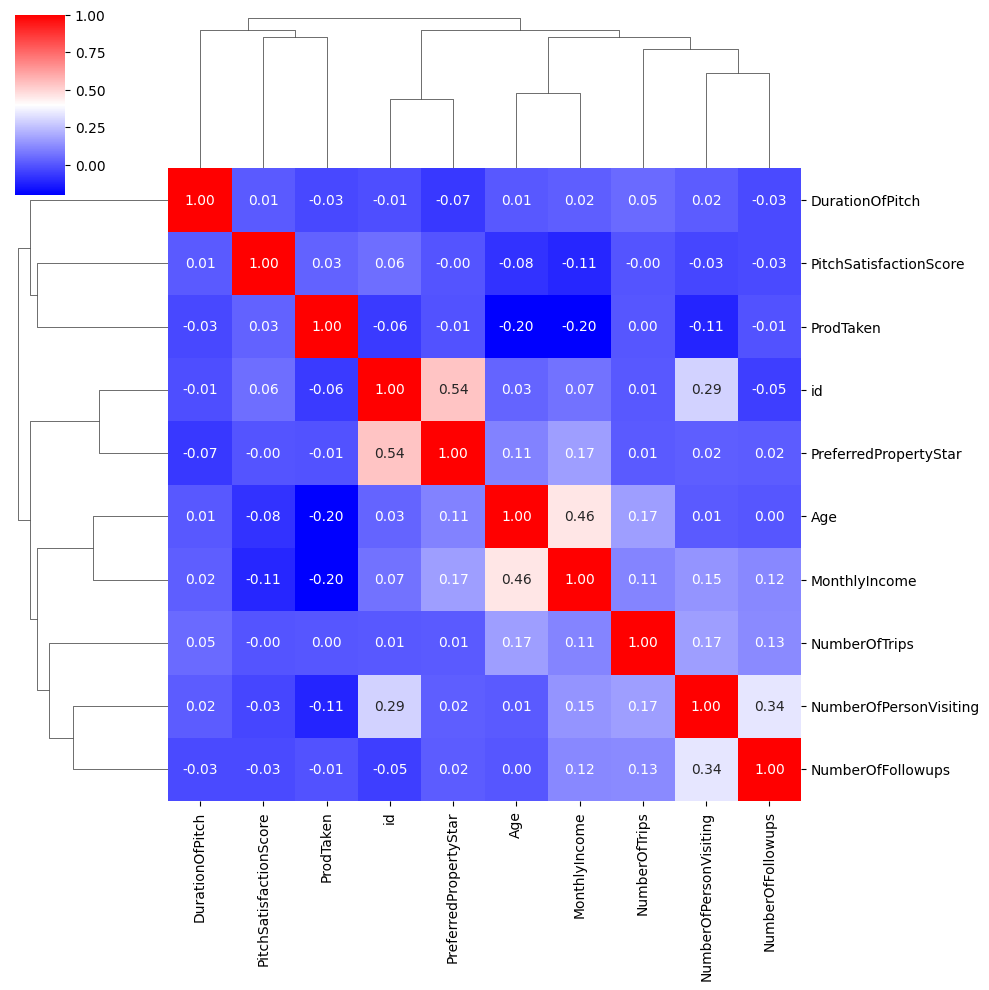

In [481]:
# 相関係数を確認する
import seaborn as sns
import matplotlib.pyplot as plt

train_corr = train.drop(categorical_features,axis=1).corr()
sns.clustermap(train_corr,annot=True,fmt=".2f",cmap="bwr")
plt.show()

# (4) モデル構築と学習

In [482]:
# 訓練データをx,yに分割
X = train.drop(["id", "ProdTaken"], axis=1)
y = train["ProdTaken"]

In [ ]:
# Optunaを使用する
import optuna
import lightgbm as lgb
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold

def objective(trial):

  lgbm_params = {
    'objective': 'binary',
    # "device": "gpu",
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,
    'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
    'num_leaves': trial.suggest_int('num_leaves', 16, 256),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1),
    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0,log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0,log=True),
    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),

    # 'max_depth': trial.suggest_int('max_depth', 3, 12),
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

  # 複数シードの平均を取る
  seed = [42, 77, 2025]
  FOLDS = 5 # 分割数
  oof_score = np.zeros(len(seed))

  # SEEDごとのスコアを出す
  for j, seed in enumerate(seed):

    print("#"*25)
    print(f"### seed =  {seed}")
    print("#"*25)

    oof_lgb = np.zeros(len(train))

    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

    # 各FOLDのスコアを出す
    for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

      print("#"*25)
      print(f"### Fold {i+1}")
      print("#"*25)

      # インデックスに割り振る
      x_train = train.loc[train_index, FEATURES].copy()
      y_train = train.loc[train_index, TARGET]
      x_valid = train.loc[test_index, FEATURES].copy()
      y_valid = train.loc[test_index, TARGET]

      # データセット作成
      lgb_train = lgb.Dataset(x_train, y_train)
      lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

      # 学習
      model_lgb = lgb.train(lgbm_params,
                            lgb_train,
                            num_boost_round = 2000,
                            valid_sets = [lgb_train, lgb_eval],
                            valid_names = ["train", "valid"],
                            categorical_feature = categorical_features,
                            callbacks = [
                                lgb.early_stopping(stopping_rounds=100, verbose=False),
                                lgb.log_evaluation(100),])

      # valid予測
      oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)

    # AUCの算出
    oof_score[j] = roc_auc_score(train[TARGET],oof_lgb)

  score = np.mean(oof_score)

  return score

study = optuna.create_study(direction="maximize",sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

[I 2025-06-03 12:50:54,576] A new study created in memory with name: no-name-e6ceff88-ea70-4330-b338-b9cd2a252b43
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.97189	valid's auc: 0.819565
[200]	train's auc: 0.989534	valid's auc: 0.824515
[300]	train's auc: 0.997755	valid's auc: 0.82291
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.970372	valid's auc: 0.83403
[200]	train's auc: 0.989519	valid's auc: 0.835886
[300]	train's auc: 0.997926	valid's auc: 0.84097
[400]	train's auc: 0.999802	valid's auc: 0.840853
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.971408	valid's auc: 0.805686
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.972021	valid's auc: 0.837558
[200]	train's auc: 0.989047	valid's auc: 0.839042
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.972529	valid's auc: 0.796544
[200]	train's auc: 0.990163	valid's auc: 0.798841
[300]	train's auc: 0.997632	valid's auc: 0.80129
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.970428	valid's auc: 0.840334
[200]	train's auc: 0.988402	valid's auc: 0.841806
[300]	train's auc: 0.997467	valid's auc: 0.837425
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.972251	valid's auc: 0.811087
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.970163	valid's auc: 0.80545
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.970988	valid's auc: 0.827052
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.97139	valid's auc: 0.854143
[200]	train's auc: 0.989734	valid's auc: 0.858569
[300]	train's auc: 0.997507	valid's auc: 0.857741
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.971699	valid's auc: 0.82505
[200]	train's auc: 0.99005	valid's auc: 0.82408
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.971465	valid's auc: 0.84811
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.971319	valid's auc: 0.814084
[200]	train's auc: 0.989909	valid's auc: 0.818131
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.971467	valid's auc: 0.775366
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.968284	valid's auc: 0.838907


[I 2025-06-03 12:51:12,209] Trial 0 finished with value: 0.8091505808469354 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 245, 'bagging_fraction': 0.8659969709057025, 'bagging_freq': 5, 'lambda_l1': 2.5361081166471375e-07, 'lambda_l2': 2.5348407664333426e-07, 'min_data_in_leaf': 15}. Best is trial 0 with value: 0.8091505808469354.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854488	valid's auc: 0.812776
[200]	train's auc: 0.874486	valid's auc: 0.819482
[300]	train's auc: 0.888707	valid's auc: 0.822709
[400]	train's auc: 0.900439	valid's auc: 0.823161
#########################
### Fold 2
#########################
[100]	train's auc: 0.85061	valid's auc: 0.826647


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867756	valid's auc: 0.836722
[300]	train's auc: 0.881695	valid's auc: 0.84209
[400]	train's auc: 0.892697	valid's auc: 0.845284
[500]	train's auc: 0.902078	valid's auc: 0.846472
[600]	train's auc: 0.909826	valid's auc: 0.847943
[700]	train's auc: 0.916779	valid's auc: 0.848528
[800]	train's auc: 0.922915	valid's auc: 0.848829
[900]	train's auc: 0.928084	valid's auc: 0.848896
#########################
### Fold 3
#########################
[100]	train's auc: 0.858295	valid's auc: 0.795518


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878327	valid's auc: 0.808671
[300]	train's auc: 0.891483	valid's auc: 0.811723
[400]	train's auc: 0.902348	valid's auc: 0.812819
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857839	valid's auc: 0.823544
[200]	train's auc: 0.877462	valid's auc: 0.827608
[300]	train's auc: 0.890807	valid's auc: 0.828957
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851968	valid's auc: 0.802946
[200]	train's auc: 0.873887	valid's auc: 0.810581
[300]	train's auc: 0.889784	valid's auc: 0.812084
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848439	valid's auc: 0.824523
[200]	train's auc: 0.87026	valid's auc: 0.838244
[300]	train's auc: 0.886088	valid's auc: 0.843679
[400]	train's auc: 0.89799	valid's auc: 0.846405
[500]	train's auc: 0.908174	valid's auc: 0.846672
[600]	train's auc: 0.916182	valid's auc: 0.846405
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856688	valid's auc: 0.806764
[200]	train's auc: 0.876992	valid's auc: 0.812692
[300]	train's auc: 0.890994	valid's auc: 0.815217
[400]	train's auc: 0.902359	valid's auc: 0.815953
[500]	train's auc: 0.911135	valid's auc: 0.816672
[600]	train's auc: 0.917927	valid's auc: 0.817642
[700]	train's auc: 0.924256	valid's auc: 0.819298
[800]	train's auc: 0.929384	valid's auc: 0.819231
[900]	train's auc: 0.933902	valid's auc: 0.820385
[1000]	train's auc: 0.938084	valid's auc: 0.82092
[1100]	train's auc: 0.941854	valid's auc: 0.820669
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853862	valid's auc: 0.791555
[200]	train's auc: 0.873489	valid's auc: 0.806698
[300]	train's auc: 0.886766	valid's auc: 0.812145
[400]	train's auc: 0.897334	valid's auc: 0.814236
[500]	train's auc: 0.906738	valid's auc: 0.81572
[600]	train's auc: 0.914516	valid's auc: 0.816462
[700]	train's auc: 0.921283	valid's auc: 0.815686
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857916	valid's auc: 0.821217
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851161	valid's auc: 0.837294
[200]	train's auc: 0.871754	valid's auc: 0.847514
[300]	train's auc: 0.884427	valid's auc: 0.852606
[400]	train's auc: 0.895314	valid's auc: 0.853265
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856139	valid's auc: 0.810853
[200]	train's auc: 0.87408	valid's auc: 0.813194
[300]	train's auc: 0.887944	valid's auc: 0.814632
[400]	train's auc: 0.897605	valid's auc: 0.818579
[500]	train's auc: 0.905764	valid's auc: 0.819649
[600]	train's auc: 0.912642	valid's auc: 0.820686
[700]	train's auc: 0.918478	valid's auc: 0.822007
[800]	train's auc: 0.923976	valid's auc: 0.822592
[900]	train's auc: 0.928847	valid's auc: 0.823462
[1000]	train's auc: 0.933334	valid's auc: 0.823378
#########################
### Fold 2
#########################
[100]	train's auc: 0.851631	valid's auc: 0.850619


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869601	valid's auc: 0.856839
[300]	train's auc: 0.884771	valid's auc: 0.858729
[400]	train's auc: 0.896708	valid's auc: 0.859649
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855621	valid's auc: 0.798199
[200]	train's auc: 0.874882	valid's auc: 0.811032
[300]	train's auc: 0.888762	valid's auc: 0.815872
[400]	train's auc: 0.899804	valid's auc: 0.817035
[500]	train's auc: 0.90928	valid's auc: 0.817946
[600]	train's auc: 0.916714	valid's auc: 0.81862
[700]	train's auc: 0.923098	valid's auc: 0.818502
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853711	valid's auc: 0.787879
[200]	train's auc: 0.875152	valid's auc: 0.79927
[300]	train's auc: 0.889975	valid's auc: 0.80744
[400]	train's auc: 0.901964	valid's auc: 0.811453
[500]	train's auc: 0.910985	valid's auc: 0.812583
[600]	train's auc: 0.91956	valid's auc: 0.812027
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854467	valid's auc: 0.816814
[200]	train's auc: 0.874652	valid's auc: 0.825783
[300]	train's auc: 0.887837	valid's auc: 0.826374
[400]	train's auc: 0.899027	valid's auc: 0.826121


[I 2025-06-03 12:51:27,582] Trial 1 finished with value: 0.8233338309715691 and parameters: {'feature_fraction': 0.9330880728874675, 'num_leaves': 160, 'bagging_fraction': 0.8540362888980227, 'bagging_freq': 1, 'lambda_l1': 5.360294728728285, 'lambda_l2': 0.31044435499483225, 'min_data_in_leaf': 29}. Best is trial 1 with value: 0.8233338309715691.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "cate

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.874156	valid's auc: 0.833495
[200]	train's auc: 0.894158	valid's auc: 0.833261
#########################
### Fold 2
#########################
[100]	train's auc: 0.869854	valid's auc: 0.839615


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887531	valid's auc: 0.845485
[300]	train's auc: 0.903506	valid's auc: 0.852642
#########################
### Fold 3
#########################
[100]	train's auc: 0.873897	valid's auc: 0.802971


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894192	valid's auc: 0.809211
[300]	train's auc: 0.910422	valid's auc: 0.813005
[400]	train's auc: 0.925109	valid's auc: 0.814101
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872783	valid's auc: 0.834725
[200]	train's auc: 0.892987	valid's auc: 0.836074
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877934	valid's auc: 0.804517
[200]	train's auc: 0.897047	valid's auc: 0.811696
[300]	train's auc: 0.913295	valid's auc: 0.812793
[400]	train's auc: 0.927772	valid's auc: 0.813587
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.87222	valid's auc: 0.836773


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891752	valid's auc: 0.844147
[300]	train's auc: 0.909175	valid's auc: 0.844649
#########################
### Fold 2
#########################
[100]	train's auc: 0.8754	valid's auc: 0.806187


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.896932	valid's auc: 0.813846
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874237	valid's auc: 0.798486
[200]	train's auc: 0.895277	valid's auc: 0.814539
[300]	train's auc: 0.911242	valid's auc: 0.819042
[400]	train's auc: 0.926056	valid's auc: 0.823224
[500]	train's auc: 0.938131	valid's auc: 0.82292
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.872958	valid's auc: 0.835163
#########################
### Fold 5
#########################
[100]	train's auc: 0.869039	valid's auc: 0.855613
[200]	train's auc: 0.888752	valid's auc: 0.859785
[300]	train's auc: 0.905644	valid's auc: 0.859582
[400]	train's auc: 0.921197	valid's auc: 0.860849
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.874413	valid's auc: 0.825234


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892875	valid's auc: 0.831187
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867858	valid's auc: 0.857074
[200]	train's auc: 0.891654	valid's auc: 0.862157
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876296	valid's auc: 0.814961
[200]	train's auc: 0.895572	valid's auc: 0.825146
[300]	train's auc: 0.911313	valid's auc: 0.82776
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.877989	valid's auc: 0.787322
#########################
### Fold 5
#########################
[100]	train's auc: 0.872916	valid's auc: 0.827168


[I 2025-06-03 12:51:37,118] Trial 2 finished with value: 0.8165451039570758 and parameters: {'feature_fraction': 0.5909124836035503, 'num_leaves': 60, 'bagging_fraction': 0.6521211214797689, 'bagging_freq': 4, 'lambda_l1': 7.71800699380605e-05, 'lambda_l2': 4.17890272377219e-06, 'min_data_in_leaf': 65}. Best is trial 1 with value: 0.8233338309715691.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "c

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.881559	valid's auc: 0.831288
[200]	train's auc: 0.901566	valid's auc: 0.831154
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874709	valid's auc: 0.838846
[200]	train's auc: 0.895474	valid's auc: 0.846789
[300]	train's auc: 0.912925	valid's auc: 0.851722
[400]	train's auc: 0.929829	valid's auc: 0.848763
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880316	valid's auc: 0.800037
[200]	train's auc: 0.901309	valid's auc: 0.806664
[300]	train's auc: 0.919785	valid's auc: 0.811993
[400]	train's auc: 0.935461	valid's auc: 0.812499
#########################
### Fold 4
#########################
[100]	train's auc: 0.879577	valid's auc: 0.838569


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.900919	valid's auc: 0.841504
[300]	train's auc: 0.918564	valid's auc: 0.841588
#########################
### Fold 5
#########################
[100]	train's auc: 0.884947	valid's auc: 0.805682


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.904767	valid's auc: 0.8095
[300]	train's auc: 0.9215	valid's auc: 0.812304
[400]	train's auc: 0.936574	valid's auc: 0.812777
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878461	valid's auc: 0.836321
[200]	train's auc: 0.898518	valid's auc: 0.841421
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88045	valid's auc: 0.810435
[200]	train's auc: 0.903373	valid's auc: 0.813378
[300]	train's auc: 0.922092	valid's auc: 0.814013
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881513	valid's auc: 0.798857
[200]	train's auc: 0.902622	valid's auc: 0.81169
[300]	train's auc: 0.91931	valid's auc: 0.816833
[400]	train's auc: 0.934904	valid's auc: 0.818418
[500]	train's auc: 0.946941	valid's auc: 0.818839
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.880229	valid's auc: 0.836849
#########################
### Fold 5
#########################
[100]	train's auc: 0.876719	valid's auc: 0.854532
[200]	train's auc: 0.897852	valid's auc: 0.861508
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.879416	valid's auc: 0.824064


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.89903	valid's auc: 0.829415
[300]	train's auc: 0.916909	valid's auc: 0.8299
[400]	train's auc: 0.932343	valid's auc: 0.830468
[500]	train's auc: 0.945912	valid's auc: 0.829632
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875458	valid's auc: 0.860418
[200]	train's auc: 0.899698	valid's auc: 0.865452
#########################
### Fold 3
#########################
[100]	train's auc: 0.883387	valid's auc: 0.817406


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902775	valid's auc: 0.827322
[300]	train's auc: 0.919089	valid's auc: 0.829193
[400]	train's auc: 0.934698	valid's auc: 0.828603
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.883768	valid's auc: 0.787626
#########################
### Fold 5
#########################


[I 2025-06-03 12:51:44,978] Trial 3 finished with value: 0.8166157147878357 and parameters: {'feature_fraction': 0.569746930326021, 'num_leaves': 86, 'bagging_fraction': 0.6831809216468459, 'bagging_freq': 4, 'lambda_l1': 0.1165691561324743, 'lambda_l2': 6.267062696005991e-07, 'min_data_in_leaf': 56}. Best is trial 1 with value: 0.8233338309715691.


[100]	train's auc: 0.879159	valid's auc: 0.830496
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_fea

[100]	train's auc: 0.853305	valid's auc: 0.828629
#########################
### Fold 2
#########################
[100]	train's auc: 0.846909	valid's auc: 0.821321
[200]	train's auc: 0.866334	valid's auc: 0.836003
[300]	train's auc: 0.883288	valid's auc: 0.843361
[400]	train's auc: 0.897629	valid's auc: 0.846421
[500]	train's auc: 0.909517	valid's auc: 0.846304
[600]	train's auc: 0.919993	valid's auc: 0.848528
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856536	valid's auc: 0.790341
[200]	train's auc: 0.876896	valid's auc: 0.805787
[300]	train's auc: 0.891724	valid's auc: 0.810071
[400]	train's auc: 0.904636	valid's auc: 0.811099
[500]	train's auc: 0.915856	valid's auc: 0.812229
[600]	train's auc: 0.925574	valid's auc: 0.812027
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853479	valid's auc: 0.826782
[200]	train's auc: 0.87394	valid's auc: 0.830205
[300]	train's auc: 0.889732	valid's auc: 0.831116
[400]	train's auc: 0.902742	valid's auc: 0.831183
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85466	valid's auc: 0.797422
[200]	train's auc: 0.875723	valid's auc: 0.811459
[300]	train's auc: 0.893057	valid's auc: 0.815581
[400]	train's auc: 0.905782	valid's auc: 0.815749
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852381	valid's auc: 0.827726
[200]	train's auc: 0.874426	valid's auc: 0.839264
[300]	train's auc: 0.890467	valid's auc: 0.844448
[400]	train's auc: 0.903713	valid's auc: 0.844615
[500]	train's auc: 0.915156	valid's auc: 0.845535
[600]	train's auc: 0.925301	valid's auc: 0.844448
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856433	valid's auc: 0.801505
[200]	train's auc: 0.877024	valid's auc: 0.80903
[300]	train's auc: 0.892583	valid's auc: 0.811438
[400]	train's auc: 0.905095	valid's auc: 0.813445
[500]	train's auc: 0.91583	valid's auc: 0.815669
[600]	train's auc: 0.925613	valid's auc: 0.815686
#########################
### Fold 3
#########################
[100]	train's auc: 0.854506	valid's auc: 0.794531


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874819	valid's auc: 0.80685
[300]	train's auc: 0.889784	valid's auc: 0.813089
[400]	train's auc: 0.902721	valid's auc: 0.816141
[500]	train's auc: 0.91429	valid's auc: 0.817507
[600]	train's auc: 0.924104	valid's auc: 0.817794
[700]	train's auc: 0.933299	valid's auc: 0.818283
#########################
### Fold 4
#########################
[100]	train's auc: 0.851147	valid's auc: 0.827246


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873214	valid's auc: 0.830627
[300]	train's auc: 0.888554	valid's auc: 0.831436
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849678	valid's auc: 0.842472
[200]	train's auc: 0.869052	valid's auc: 0.849532
[300]	train's auc: 0.885203	valid's auc: 0.853029
[400]	train's auc: 0.898712	valid's auc: 0.853924
[500]	train's auc: 0.91024	valid's auc: 0.854785
[600]	train's auc: 0.920701	valid's auc: 0.855985
[700]	train's auc: 0.929868	valid's auc: 0.855326
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851996	valid's auc: 0.802483


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872227	valid's auc: 0.814599
[300]	train's auc: 0.888874	valid's auc: 0.821154
[400]	train's auc: 0.900857	valid's auc: 0.825234
[500]	train's auc: 0.911684	valid's auc: 0.825903
[600]	train's auc: 0.921113	valid's auc: 0.828846
[700]	train's auc: 0.929834	valid's auc: 0.828729
#########################
### Fold 2
#########################
[100]	train's auc: 0.850526	valid's auc: 0.847166


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870114	valid's auc: 0.85689
[300]	train's auc: 0.885816	valid's auc: 0.858512
[400]	train's auc: 0.899694	valid's auc: 0.858244
#########################
### Fold 3
#########################
[100]	train's auc: 0.855005	valid's auc: 0.800155


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87525	valid's auc: 0.818334
[300]	train's auc: 0.890727	valid's auc: 0.823561
[400]	train's auc: 0.903656	valid's auc: 0.824371
[500]	train's auc: 0.915022	valid's auc: 0.822145
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851996	valid's auc: 0.785113
[200]	train's auc: 0.876896	valid's auc: 0.801167
[300]	train's auc: 0.893286	valid's auc: 0.810104
[400]	train's auc: 0.906168	valid's auc: 0.812954
[500]	train's auc: 0.917545	valid's auc: 0.81287
[600]	train's auc: 0.927231	valid's auc: 0.811588
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:51:58,129] Trial 4 finished with value: 0.8195527891053987 and parameters: {'feature_fraction': 0.7962072844310213, 'num_leaves': 27, 'bagging_fraction': 0.8037724259507192, 'bagging_freq': 2, 'lambda_l1': 3.850031979199519e-08, 'lambda_l2': 3.4671276804481113, 'min_data_in_leaf': 97}. Best is trial 1 with value: 0.8233338309715691.


[100]	train's auc: 0.855745	valid's auc: 0.827041
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87646	valid's auc: 0.825334
[200]	train's auc: 0.898642	valid's auc: 0.828512
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874883	valid's auc: 0.844833
[200]	train's auc: 0.893074	valid's auc: 0.847742
[300]	train's auc: 0.912143	valid's auc: 0.845819
#########################
### Fold 3
#########################
[100]	train's auc: 0.878561	valid's auc: 0.806386


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897941	valid's auc: 0.808671
[300]	train's auc: 0.914558	valid's auc: 0.812111
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876463	valid's auc: 0.833915
[200]	train's auc: 0.897538	valid's auc: 0.837237
[300]	train's auc: 0.915104	valid's auc: 0.836849
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883069	valid's auc: 0.804246
[200]	train's auc: 0.902996	valid's auc: 0.812675
[300]	train's auc: 0.918435	valid's auc: 0.813216
[400]	train's auc: 0.934282	valid's auc: 0.813672
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.876353	valid's auc: 0.841104


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.896229	valid's auc: 0.845585
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880147	valid's auc: 0.809498
[200]	train's auc: 0.898364	valid's auc: 0.811722
[300]	train's auc: 0.918656	valid's auc: 0.814816
[400]	train's auc: 0.933645	valid's auc: 0.818127
#########################
### Fold 3
#########################
[100]	train's auc: 0.876346	valid's auc: 0.811032


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897566	valid's auc: 0.820627
[300]	train's auc: 0.91548	valid's auc: 0.823527
[400]	train's auc: 0.930672	valid's auc: 0.825214
[500]	train's auc: 0.942475	valid's auc: 0.823106
#########################
### Fold 4
#########################
[100]	train's auc: 0.877014	valid's auc: 0.828485
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.870551	valid's auc: 0.850343
[200]	train's auc: 0.891162	valid's auc: 0.856914
[300]	train's auc: 0.910339	valid's auc: 0.86068
[400]	train's auc: 0.926852	valid's auc: 0.86117
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.878275	valid's auc: 0.820418


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897072	valid's auc: 0.822843
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868807	valid's auc: 0.855284
[200]	train's auc: 0.893962	valid's auc: 0.859181
[300]	train's auc: 0.911263	valid's auc: 0.856656
#########################
### Fold 3
#########################
[100]	train's auc: 0.879111	valid's auc: 0.807929


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897178	valid's auc: 0.820964
[300]	train's auc: 0.914874	valid's auc: 0.818772
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880245	valid's auc: 0.789953
[200]	train's auc: 0.900202	valid's auc: 0.801993
[300]	train's auc: 0.918291	valid's auc: 0.806411
[400]	train's auc: 0.932793	valid's auc: 0.809615
[500]	train's auc: 0.946074	valid's auc: 0.805703
#########################
### Fold 5
#########################
[100]	train's auc: 0.87615	valid's auc: 0.822134


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:52:08,676] Trial 5 finished with value: 0.8209149056549636 and parameters: {'feature_fraction': 0.9041986740582306, 'num_leaves': 89, 'bagging_fraction': 0.5488360570031919, 'bagging_freq': 5, 'lambda_l1': 9.148975058772307e-05, 'lambda_l2': 1.254134495897175e-07, 'min_data_in_leaf': 55}. Best is trial 1 with value: 0.8233338309715691.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: sugge

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.876807	valid's auc: 0.832809
#########################
### Fold 2
#########################
[100]	train's auc: 0.872531	valid's auc: 0.837324


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.89015	valid's auc: 0.846923
[300]	train's auc: 0.907583	valid's auc: 0.850151
[400]	train's auc: 0.92086	valid's auc: 0.850886
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875528	valid's auc: 0.801926
[200]	train's auc: 0.893749	valid's auc: 0.811403
[300]	train's auc: 0.910772	valid's auc: 0.817035
[400]	train's auc: 0.925837	valid's auc: 0.817592
[500]	train's auc: 0.939503	valid's auc: 0.816445
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87404	valid's auc: 0.835972
[200]	train's auc: 0.893094	valid's auc: 0.84206
[300]	train's auc: 0.909387	valid's auc: 0.841504
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.879572	valid's auc: 0.801392
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.872392	valid's auc: 0.834732
[200]	train's auc: 0.892481	valid's auc: 0.847274
[300]	train's auc: 0.909476	valid's auc: 0.847659
[400]	train's auc: 0.925443	valid's auc: 0.847809
[500]	train's auc: 0.939913	valid's auc: 0.846839
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877071	valid's auc: 0.808545
[200]	train's auc: 0.89493	valid's auc: 0.813411
[300]	train's auc: 0.913217	valid's auc: 0.817726
[400]	train's auc: 0.927286	valid's auc: 0.819197
[500]	train's auc: 0.940383	valid's auc: 0.821455
[600]	train's auc: 0.95031	valid's auc: 0.821706
#########################
### Fold 3
#########################
[100]	train's auc: 0.875782	valid's auc: 0.802617


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894812	valid's auc: 0.813932
[300]	train's auc: 0.911519	valid's auc: 0.818131
[400]	train's auc: 0.925482	valid's auc: 0.817727
#########################
### Fold 4
#########################
[100]	train's auc: 0.874773	valid's auc: 0.833814


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.869548	valid's auc: 0.854819


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889077	valid's auc: 0.859701
[300]	train's auc: 0.905247	valid's auc: 0.86014
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.873324	valid's auc: 0.822191


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892389	valid's auc: 0.82689
[300]	train's auc: 0.908494	valid's auc: 0.827191
[400]	train's auc: 0.923287	valid's auc: 0.830033
[500]	train's auc: 0.935507	valid's auc: 0.831773
[600]	train's auc: 0.945752	valid's auc: 0.830351
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869844	valid's auc: 0.856957
[200]	train's auc: 0.890787	valid's auc: 0.86403
#########################
### Fold 3
#########################
[100]	train's auc: 0.877563	valid's auc: 0.810964


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894618	valid's auc: 0.824219
[300]	train's auc: 0.911789	valid's auc: 0.827204
[400]	train's auc: 0.926416	valid's auc: 0.826883
[500]	train's auc: 0.938164	valid's auc: 0.827102
#########################
### Fold 4
#########################
[100]	train's auc: 0.877731	valid's auc: 0.790459
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.875078	valid's auc: 0.830985
[200]	train's auc: 0.893083	valid's auc: 0.832877
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86095	valid's auc: 0.826605
[200]	train's auc: 0.879725	valid's auc: 0.829682
[300]	train's auc: 0.895222	valid's auc: 0.829465
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852665	valid's auc: 0.830569
[200]	train's auc: 0.872094	valid's auc: 0.84505
[300]	train's auc: 0.888283	valid's auc: 0.848127
[400]	train's auc: 0.901649	valid's auc: 0.848829
[500]	train's auc: 0.913298	valid's auc: 0.850702
[600]	train's auc: 0.924109	valid's auc: 0.850836
#########################
### Fold 3
#########################
[100]	train's auc: 0.862976	valid's auc: 0.796597


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88065	valid's auc: 0.806664
[300]	train's auc: 0.896427	valid's auc: 0.810914
[400]	train's auc: 0.910055	valid's auc: 0.813865
[500]	train's auc: 0.920232	valid's auc: 0.813275
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859252	valid's auc: 0.827726
[200]	train's auc: 0.8799	valid's auc: 0.832802
[300]	train's auc: 0.89513	valid's auc: 0.832499
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861558	valid's auc: 0.799787
[200]	train's auc: 0.881125	valid's auc: 0.804078
[300]	train's auc: 0.898364	valid's auc: 0.809331
[400]	train's auc: 0.911787	valid's auc: 0.81102
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.856288	valid's auc: 0.837308


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877117	valid's auc: 0.840652
[300]	train's auc: 0.892881	valid's auc: 0.844649
#########################
### Fold 2
#########################
[100]	train's auc: 0.859878	valid's auc: 0.801271


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879448	valid's auc: 0.809716
[300]	train's auc: 0.895018	valid's auc: 0.813361
[400]	train's auc: 0.909042	valid's auc: 0.815669
[500]	train's auc: 0.920049	valid's auc: 0.816137
#########################
### Fold 3
#########################
[100]	train's auc: 0.859793	valid's auc: 0.799582


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878129	valid's auc: 0.808806
[300]	train's auc: 0.893692	valid's auc: 0.817018
[400]	train's auc: 0.906752	valid's auc: 0.818941
[500]	train's auc: 0.918131	valid's auc: 0.820121
[600]	train's auc: 0.928103	valid's auc: 0.819109
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856139	valid's auc: 0.832178
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85464	valid's auc: 0.846737
[200]	train's auc: 0.873774	valid's auc: 0.851508
[300]	train's auc: 0.890071	valid's auc: 0.85541
[400]	train's auc: 0.902922	valid's auc: 0.855039
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857448	valid's auc: 0.815176
[200]	train's auc: 0.876212	valid's auc: 0.81607
[300]	train's auc: 0.892042	valid's auc: 0.821957
[400]	train's auc: 0.904266	valid's auc: 0.823211
[500]	train's auc: 0.91586	valid's auc: 0.824883
[600]	train's auc: 0.926525	valid's auc: 0.824732
#########################
### Fold 2
#########################
[100]	train's auc: 0.854791	valid's auc: 0.852642


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872669	valid's auc: 0.857826
[300]	train's auc: 0.889064	valid's auc: 0.861171
[400]	train's auc: 0.904557	valid's auc: 0.861338
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861121	valid's auc: 0.810324
[200]	train's auc: 0.879306	valid's auc: 0.822718
[300]	train's auc: 0.894017	valid's auc: 0.826715
[400]	train's auc: 0.907743	valid's auc: 0.826192
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862587	valid's auc: 0.786732
[200]	train's auc: 0.881692	valid's auc: 0.797474
[300]	train's auc: 0.898041	valid's auc: 0.804607
[400]	train's auc: 0.911024	valid's auc: 0.808081
[500]	train's auc: 0.922397	valid's auc: 0.808755
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:52:32,669] Trial 7 finished with value: 0.8211743724378356 and parameters: {'feature_fraction': 0.5924272277627636, 'num_leaves': 249, 'bagging_fraction': 0.8875664116805573, 'bagging_freq': 7, 'lambda_l1': 1.1309571585271483, 'lambda_l2': 0.002404915432737351, 'min_data_in_leaf': 93}. Best is trial 1 with value: 0.8233338309715691.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_

[100]	train's auc: 0.860629	valid's auc: 0.826932
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.856607	valid's auc: 0.836973
[200]	train's auc: 0.872326	valid's auc: 0.838177
#########################
### Fold 2
#########################
[100]	train's auc: 0.850079	valid's auc: 0.832199


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865553	valid's auc: 0.845368
[300]	train's auc: 0.879666	valid's auc: 0.850151
[400]	train's auc: 0.889615	valid's auc: 0.851856
[500]	train's auc: 0.900248	valid's auc: 0.853779
[600]	train's auc: 0.907876	valid's auc: 0.852793
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855037	valid's auc: 0.795636
[200]	train's auc: 0.871909	valid's auc: 0.805905
[300]	train's auc: 0.885598	valid's auc: 0.81142
[400]	train's auc: 0.897132	valid's auc: 0.812415
[500]	train's auc: 0.906485	valid's auc: 0.811453
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853503	valid's auc: 0.833089
[200]	train's auc: 0.871893	valid's auc: 0.83464
[300]	train's auc: 0.884487	valid's auc: 0.834151
#########################
### Fold 5
#########################
[100]	train's auc: 0.85825	valid's auc: 0.802017


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874739	valid's auc: 0.81325
[300]	train's auc: 0.887502	valid's auc: 0.817337
[400]	train's auc: 0.899864	valid's auc: 0.817726
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851813	valid's auc: 0.837926


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869835	valid's auc: 0.843796
[300]	train's auc: 0.883248	valid's auc: 0.84796
[400]	train's auc: 0.89401	valid's auc: 0.848043
#########################
### Fold 2
#########################
[100]	train's auc: 0.856921	valid's auc: 0.796237


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874633	valid's auc: 0.809766
[300]	train's auc: 0.887117	valid's auc: 0.81413
[400]	train's auc: 0.897804	valid's auc: 0.816806
[500]	train's auc: 0.907127	valid's auc: 0.819331
[600]	train's auc: 0.914881	valid's auc: 0.818227
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856722	valid's auc: 0.794371
[200]	train's auc: 0.873628	valid's auc: 0.808604
[300]	train's auc: 0.886161	valid's auc: 0.814303
[400]	train's auc: 0.896595	valid's auc: 0.81803
[500]	train's auc: 0.905966	valid's auc: 0.819447
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854366	valid's auc: 0.833865
[200]	train's auc: 0.872058	valid's auc: 0.836934
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850743	valid's auc: 0.849684
[200]	train's auc: 0.867376	valid's auc: 0.855275
[300]	train's auc: 0.880478	valid's auc: 0.857589
[400]	train's auc: 0.891901	valid's auc: 0.856728
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854034	valid's auc: 0.818211
[200]	train's auc: 0.870317	valid's auc: 0.823194
[300]	train's auc: 0.882814	valid's auc: 0.830853
[400]	train's auc: 0.892216	valid's auc: 0.833595
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849317	valid's auc: 0.851405
[200]	train's auc: 0.867339	valid's auc: 0.858361
#########################
### Fold 3
#########################
[100]	train's auc: 0.859163	valid's auc: 0.810003


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873602	valid's auc: 0.817052
[300]	train's auc: 0.886198	valid's auc: 0.822246
[400]	train's auc: 0.89801	valid's auc: 0.825231
[500]	train's auc: 0.907032	valid's auc: 0.826074
[600]	train's auc: 0.914736	valid's auc: 0.824657
#########################
### Fold 4
#########################
[100]	train's auc: 0.858504	valid's auc: 0.789717


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874367	valid's auc: 0.799514
[300]	train's auc: 0.888126	valid's auc: 0.807491
[400]	train's auc: 0.898717	valid's auc: 0.809093
[500]	train's auc: 0.907856	valid's auc: 0.811015
[600]	train's auc: 0.915844	valid's auc: 0.811369
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856315	valid's auc: 0.825378
[200]	train's auc: 0.871875	valid's auc: 0.827742
[300]	train's auc: 0.884857	valid's auc: 0.826813
[400]	train's auc: 0.896462	valid's auc: 0.827016
[500]	train's auc: 0.905785	valid's auc: 0.827759
[600]	train's auc: 0.913892	valid's auc: 0.826509


[I 2025-06-03 12:52:43,650] Trial 8 finished with value: 0.8288411395287949 and parameters: {'feature_fraction': 0.5442462510259598, 'num_leaves': 63, 'bagging_fraction': 0.522613644455269, 'bagging_freq': 3, 'lambda_l1': 3.148441347423712e-05, 'lambda_l2': 2.7678419414850017e-06, 'min_data_in_leaf': 85}. Best is trial 8 with value: 0.8288411395287949.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", 

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862889	valid's auc: 0.832107
#########################
### Fold 2
#########################
[100]	train's auc: 0.857605	valid's auc: 0.830268


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876905	valid's auc: 0.844465
[300]	train's auc: 0.893185	valid's auc: 0.848261
[400]	train's auc: 0.907451	valid's auc: 0.850033
[500]	train's auc: 0.91958	valid's auc: 0.848913
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863289	valid's auc: 0.79427
[200]	train's auc: 0.883649	valid's auc: 0.805265
[300]	train's auc: 0.899416	valid's auc: 0.811673
[400]	train's auc: 0.912412	valid's auc: 0.813781
[500]	train's auc: 0.924141	valid's auc: 0.814
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862921	valid's auc: 0.829952
[200]	train's auc: 0.88231	valid's auc: 0.832246
[300]	train's auc: 0.897972	valid's auc: 0.833224
#########################
### Fold 5
#########################
[100]	train's auc: 0.863001	valid's auc: 0.798943


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884503	valid's auc: 0.810327
[300]	train's auc: 0.900665	valid's auc: 0.815175
[400]	train's auc: 0.913584	valid's auc: 0.815395
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859628	valid's auc: 0.835518
[200]	train's auc: 0.88059	valid's auc: 0.845033
[300]	train's auc: 0.897157	valid's auc: 0.847525
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865014	valid's auc: 0.802308
[200]	train's auc: 0.885443	valid's auc: 0.80888
[300]	train's auc: 0.900895	valid's auc: 0.81306
[400]	train's auc: 0.914581	valid's auc: 0.8149
[500]	train's auc: 0.926057	valid's auc: 0.815134
[600]	train's auc: 0.935321	valid's auc: 0.815786
#########################
### Fold 3
#########################
[100]	train's auc: 0.86348	valid's auc: 0.795029


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88329	valid's auc: 0.807238
[300]	train's auc: 0.899392	valid's auc: 0.814995
[400]	train's auc: 0.91257	valid's auc: 0.818553
[500]	train's auc: 0.924063	valid's auc: 0.81889
[600]	train's auc: 0.933997	valid's auc: 0.818772
[700]	train's auc: 0.942647	valid's auc: 0.818941
#########################
### Fold 4
#########################
[100]	train's auc: 0.859855	valid's auc: 0.830981


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880985	valid's auc: 0.835416
[300]	train's auc: 0.897125	valid's auc: 0.833207
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858429	valid's auc: 0.846931
[200]	train's auc: 0.87725	valid's auc: 0.856052
[300]	train's auc: 0.893887	valid's auc: 0.857691
[400]	train's auc: 0.907655	valid's auc: 0.856458
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861043	valid's auc: 0.814732
[200]	train's auc: 0.881179	valid's auc: 0.822475
[300]	train's auc: 0.896401	valid's auc: 0.826171
[400]	train's auc: 0.909616	valid's auc: 0.829883
[500]	train's auc: 0.92074	valid's auc: 0.829916
#########################
### Fold 2
#########################
[100]	train's auc: 0.858075	valid's auc: 0.84995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878761	valid's auc: 0.859398
[300]	train's auc: 0.896097	valid's auc: 0.860819
[400]	train's auc: 0.909723	valid's auc: 0.861672
[500]	train's auc: 0.922083	valid's auc: 0.860686
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862798	valid's auc: 0.805012
[200]	train's auc: 0.883692	valid's auc: 0.820812
[300]	train's auc: 0.899036	valid's auc: 0.82346
[400]	train's auc: 0.912096	valid's auc: 0.824489
#########################
### Fold 4
#########################
[100]	train's auc: 0.862807	valid's auc: 0.789784


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884899	valid's auc: 0.802246
[300]	train's auc: 0.901178	valid's auc: 0.809531
[400]	train's auc: 0.915085	valid's auc: 0.810239
[500]	train's auc: 0.92665	valid's auc: 0.811319
[600]	train's auc: 0.936564	valid's auc: 0.8097
#########################
### Fold 5
#########################
[100]	train's auc: 0.863535	valid's auc: 0.824601


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:52:55,622] Trial 9 finished with value: 0.8221574321149715 and parameters: {'feature_fraction': 0.6783766633467947, 'num_leaves': 83, 'bagging_fraction': 0.7713480415791243, 'bagging_freq': 1, 'lambda_l1': 0.16587190283399655, 'lambda_l2': 4.6876566400928895e-08, 'min_data_in_leaf': 99}. Best is trial 8 with value: 0.8288411395287949.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: sugges

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.88741	valid's auc: 0.825569
[200]	train's auc: 0.912356	valid's auc: 0.82791
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880772	valid's auc: 0.834682
[200]	train's auc: 0.904869	valid's auc: 0.84888
[300]	train's auc: 0.926045	valid's auc: 0.851371
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.886244	valid's auc: 0.795332
[200]	train's auc: 0.910011	valid's auc: 0.80626
[300]	train's auc: 0.930415	valid's auc: 0.809261
[400]	train's auc: 0.947577	valid's auc: 0.811049
[500]	train's auc: 0.961127	valid's auc: 0.811082
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885173	valid's auc: 0.82744
[200]	train's auc: 0.910345	valid's auc: 0.830779
#########################
### Fold 5
#########################
[100]	train's auc: 0.889378	valid's auc: 0.805598


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.914041	valid's auc: 0.808402
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.88561	valid's auc: 0.834298


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.909966	valid's auc: 0.83811
[300]	train's auc: 0.931965	valid's auc: 0.839314
#########################
### Fold 2
#########################
[100]	train's auc: 0.890038	valid's auc: 0.810903


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.913543	valid's auc: 0.815017
[300]	train's auc: 0.933162	valid's auc: 0.818796
[400]	train's auc: 0.949886	valid's auc: 0.82097
[500]	train's auc: 0.962666	valid's auc: 0.820268
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887216	valid's auc: 0.79459
[200]	train's auc: 0.91082	valid's auc: 0.811049
[300]	train's auc: 0.93173	valid's auc: 0.813207
[400]	train's auc: 0.948716	valid's auc: 0.813055
[500]	train's auc: 0.962787	valid's auc: 0.812651
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883638	valid's auc: 0.831858
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881427	valid's auc: 0.847606
[200]	train's auc: 0.905701	valid's auc: 0.855326
[300]	train's auc: 0.927737	valid's auc: 0.85791
[400]	train's auc: 0.946049	valid's auc: 0.857674
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.885376	valid's auc: 0.815184


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.907596	valid's auc: 0.816522
[300]	train's auc: 0.928832	valid's auc: 0.81689
#########################
### Fold 2
#########################
[100]	train's auc: 0.881504	valid's auc: 0.85995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 3
#########################
[100]	train's auc: 0.886842	valid's auc: 0.811082


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.911327	valid's auc: 0.820829
[300]	train's auc: 0.931958	valid's auc: 0.821285
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.891299	valid's auc: 0.789649
[200]	train's auc: 0.91324	valid's auc: 0.794017
[300]	train's auc: 0.933563	valid's auc: 0.797963
[400]	train's auc: 0.950375	valid's auc: 0.801926
[500]	train's auc: 0.963877	valid's auc: 0.799852
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:53:08,117] Trial 10 finished with value: 0.814372980306079 and parameters: {'feature_fraction': 0.7568316785311043, 'num_leaves': 150, 'bagging_fraction': 0.9847685553939328, 'bagging_freq': 3, 'lambda_l1': 0.005764962972197527, 'lambda_l2': 2.6462851656372664e-05, 'min_data_in_leaf': 76}. Best is trial 8 with value: 0.8288411395287949.


[100]	train's auc: 0.885252	valid's auc: 0.820293
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.917606	valid's auc: 0.828445
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.911837	valid's auc: 0.840702
[200]	train's auc: 0.93625	valid's auc: 0.845736
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.916232	valid's auc: 0.807828
[200]	train's auc: 0.93934	valid's auc: 0.81459
#########################
### Fold 4
#########################
[100]	train's auc: 0.916174	valid's auc: 0.833359


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.939527	valid's auc: 0.840154
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.921082	valid's auc: 0.803926
[200]	train's auc: 0.944598	valid's auc: 0.808182
[300]	train's auc: 0.962766	valid's auc: 0.806223
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.915783	valid's auc: 0.837742
[200]	train's auc: 0.941841	valid's auc: 0.839247
[300]	train's auc: 0.961072	valid's auc: 0.839983
[400]	train's auc: 0.975173	valid's auc: 0.839114
#########################
### Fold 2
#########################
[100]	train's auc: 0.920246	valid's auc: 0.812274


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.94312	valid's auc: 0.815017
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.913729	valid's auc: 0.802836
[200]	train's auc: 0.938006	valid's auc: 0.808553
[300]	train's auc: 0.958839	valid's auc: 0.810644
[400]	train's auc: 0.975071	valid's auc: 0.811909
[500]	train's auc: 0.985287	valid's auc: 0.81088
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.915839	valid's auc: 0.831588
[200]	train's auc: 0.940934	valid's auc: 0.82862
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.912635	valid's auc: 0.851846
[200]	train's auc: 0.939341	valid's auc: 0.858062
[300]	train's auc: 0.96004	valid's auc: 0.861204
[400]	train's auc: 0.975192	valid's auc: 0.857995
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.917087	valid's auc: 0.829883
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.912812	valid's auc: 0.856973
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.914701	valid's auc: 0.810948
[200]	train's auc: 0.939182	valid's auc: 0.823224
[300]	train's auc: 0.960499	valid's auc: 0.816563
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.921601	valid's auc: 0.790543
[200]	train's auc: 0.944189	valid's auc: 0.797727
[300]	train's auc: 0.963285	valid's auc: 0.79857
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.91238	valid's auc: 0.820074


[I 2025-06-03 12:53:16,447] Trial 11 finished with value: 0.8104810906436839 and parameters: {'feature_fraction': 0.9880699499289975, 'num_leaves': 167, 'bagging_fraction': 0.5033905463786833, 'bagging_freq': 1, 'lambda_l1': 0.00348043375782835, 'lambda_l2': 0.104739376543692, 'min_data_in_leaf': 23}. Best is trial 8 with value: 0.8288411395287949.


[200]	train's auc: 0.937644	valid's auc: 0.825698
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.930505	valid's auc: 0.822391
[200]	train's auc: 0.958213	valid's auc: 0.828462
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.924126	valid's auc: 0.839431
[200]	train's auc: 0.955271	valid's auc: 0.84811
[300]	train's auc: 0.976746	valid's auc: 0.850602
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.927898	valid's auc: 0.801521
[200]	train's auc: 0.957049	valid's auc: 0.804051
[300]	train's auc: 0.977766	valid's auc: 0.807626
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.929446	valid's auc: 0.824522
[200]	train's auc: 0.957161	valid's auc: 0.827844
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.930245	valid's auc: 0.799753
[200]	train's auc: 0.958211	valid's auc: 0.802372
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.929069	valid's auc: 0.840067
[200]	train's auc: 0.958178	valid's auc: 0.841171
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.930376	valid's auc: 0.816171
[200]	train's auc: 0.958655	valid's auc: 0.819097
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.925666	valid's auc: 0.795535
[200]	train's auc: 0.956242	valid's auc: 0.802162
[300]	train's auc: 0.977721	valid's auc: 0.809717
[400]	train's auc: 0.990792	valid's auc: 0.811437
[500]	train's auc: 0.996889	valid's auc: 0.810829
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.926337	valid's auc: 0.831588
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.927786	valid's auc: 0.850225
[200]	train's auc: 0.956469	valid's auc: 0.855444
[300]	train's auc: 0.977684	valid's auc: 0.855765
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.930768	valid's auc: 0.824415
[200]	train's auc: 0.958414	valid's auc: 0.824264
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.926062	valid's auc: 0.856338
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.928154	valid's auc: 0.811774
[200]	train's auc: 0.957428	valid's auc: 0.819851
[300]	train's auc: 0.977803	valid's auc: 0.817153
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.932655	valid's auc: 0.790037
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.925244	valid's auc: 0.830681


[I 2025-06-03 12:53:29,970] Trial 12 finished with value: 0.8142857815341245 and parameters: {'feature_fraction': 0.8607871857097573, 'num_leaves': 197, 'bagging_fraction': 0.9689478251869063, 'bagging_freq': 2, 'lambda_l1': 2.528830125346667e-06, 'lambda_l2': 0.07250666790954992, 'min_data_in_leaf': 34}. Best is trial 8 with value: 0.8288411395287949.


[200]	train's auc: 0.954536	valid's auc: 0.827911
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842656	valid's auc: 0.810686
[200]	train's auc: 0.863048	valid's auc: 0.820368
[300]	train's auc: 0.876271	valid's auc: 0.825485
[400]	train's auc: 0.887393	valid's auc: 0.826388
[500]	train's auc: 0.896821	valid's auc: 0.827107
[600]	train's auc: 0.904602	valid's auc: 0.826706
#########################
### Fold 2
#########################
[100]	train's auc: 0.840194	valid's auc: 0.813604


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85615	valid's auc: 0.828637
[300]	train's auc: 0.870454	valid's auc: 0.836237
[400]	train's auc: 0.880526	valid's auc: 0.840067
[500]	train's auc: 0.888944	valid's auc: 0.84286
[600]	train's auc: 0.896175	valid's auc: 0.844916
[700]	train's auc: 0.902801	valid's auc: 0.846472
[800]	train's auc: 0.908437	valid's auc: 0.848043
[900]	train's auc: 0.914218	valid's auc: 0.848344
#########################
### Fold 3
#########################
[100]	train's auc: 0.84902	valid's auc: 0.791024


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868526	valid's auc: 0.808148
[300]	train's auc: 0.87992	valid's auc: 0.811302
[400]	train's auc: 0.889685	valid's auc: 0.813646
[500]	train's auc: 0.897978	valid's auc: 0.814404
[600]	train's auc: 0.905576	valid's auc: 0.815012
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845805	valid's auc: 0.814632
[200]	train's auc: 0.864999	valid's auc: 0.822878
[300]	train's auc: 0.877992	valid's auc: 0.826006
[400]	train's auc: 0.888079	valid's auc: 0.8269
[500]	train's auc: 0.897275	valid's auc: 0.826849
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844286	valid's auc: 0.796544
[200]	train's auc: 0.862326	valid's auc: 0.804686
[300]	train's auc: 0.8779	valid's auc: 0.811544
[400]	train's auc: 0.889329	valid's auc: 0.812084
[500]	train's auc: 0.897667	valid's auc: 0.813739
[600]	train's auc: 0.905797	valid's auc: 0.813486
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840775	valid's auc: 0.820477
[200]	train's auc: 0.860436	valid's auc: 0.831555
[300]	train's auc: 0.874398	valid's auc: 0.842174
[400]	train's auc: 0.884277	valid's auc: 0.84597
[500]	train's auc: 0.89312	valid's auc: 0.847391
[600]	train's auc: 0.901196	valid's auc: 0.846488
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843533	valid's auc: 0.796196
[200]	train's auc: 0.865289	valid's auc: 0.806806
[300]	train's auc: 0.879053	valid's auc: 0.811405
[400]	train's auc: 0.889417	valid's auc: 0.813077
[500]	train's auc: 0.898097	valid's auc: 0.814013
[600]	train's auc: 0.905565	valid's auc: 0.814448
[700]	train's auc: 0.912144	valid's auc: 0.815753
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845375	valid's auc: 0.787828
[200]	train's auc: 0.864261	valid's auc: 0.800459
[300]	train's auc: 0.875633	valid's auc: 0.808401
[400]	train's auc: 0.885205	valid's auc: 0.810931
[500]	train's auc: 0.893348	valid's auc: 0.813781
[600]	train's auc: 0.900817	valid's auc: 0.815416
[700]	train's auc: 0.907701	valid's auc: 0.815585
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844449	valid's auc: 0.816445
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840951	valid's auc: 0.830833
[200]	train's auc: 0.862482	valid's auc: 0.845495
[300]	train's auc: 0.874891	valid's auc: 0.847877
[400]	train's auc: 0.88406	valid's auc: 0.848417
[500]	train's auc: 0.892702	valid's auc: 0.849397
[600]	train's auc: 0.900013	valid's auc: 0.850546
[700]	train's auc: 0.906463	valid's auc: 0.850816
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845305	valid's auc: 0.791747
[200]	train's auc: 0.862422	valid's auc: 0.805995
[300]	train's auc: 0.874575	valid's auc: 0.811622
[400]	train's auc: 0.883984	valid's auc: 0.815334
[500]	train's auc: 0.892349	valid's auc: 0.817592
[600]	train's auc: 0.899193	valid's auc: 0.819732
[700]	train's auc: 0.904744	valid's auc: 0.821204
[800]	train's auc: 0.910757	valid's auc: 0.821656
[900]	train's auc: 0.915871	valid's auc: 0.822977
[1000]	train's auc: 0.920441	valid's auc: 0.823729
[1100]	train's auc: 0.924345	valid's auc: 0.824147
[1200]	train's auc: 0.928071	valid's auc: 0.824565
[1300]	train's auc: 0.931351	valid's auc: 0.825
[1400]	train's auc: 0.934471	valid's auc: 0.824348
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83644	valid's auc: 0.843077
[200]	train's auc: 0.858244	valid's auc: 0.851463
[300]	train's auc: 0.871025	valid's auc: 0.855201
[400]	train's auc: 0.882239	valid's auc: 0.85699
[500]	train's auc: 0.892016	valid's auc: 0.85888
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84202	valid's auc: 0.786159
[200]	train's auc: 0.864592	valid's auc: 0.80518
[300]	train's auc: 0.877093	valid's auc: 0.810998
[400]	train's auc: 0.887186	valid's auc: 0.81427
[500]	train's auc: 0.895898	valid's auc: 0.815905
[600]	train's auc: 0.902989	valid's auc: 0.817052
[700]	train's auc: 0.909386	valid's auc: 0.817204
#########################
### Fold 4
#########################
[100]	train's auc: 0.841684	valid's auc: 0.77927


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865149	valid's auc: 0.793806
[300]	train's auc: 0.87828	valid's auc: 0.803174
[400]	train's auc: 0.888863	valid's auc: 0.809683
[500]	train's auc: 0.898772	valid's auc: 0.812263
[600]	train's auc: 0.906692	valid's auc: 0.812499
[700]	train's auc: 0.91299	valid's auc: 0.811774
#########################
### Fold 5
#########################
[100]	train's auc: 0.843346	valid's auc: 0.808883


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864495	valid's auc: 0.825774
[300]	train's auc: 0.875468	valid's auc: 0.826155


[I 2025-06-03 12:53:52,168] Trial 13 finished with value: 0.8242596174193109 and parameters: {'feature_fraction': 0.9993581893182745, 'num_leaves': 128, 'bagging_fraction': 0.8534160724984509, 'bagging_freq': 2, 'lambda_l1': 4.9119188022849185, 'lambda_l2': 8.365715383020593, 'min_data_in_leaf': 37}. Best is trial 8 with value: 0.8288411395287949.


[400]	train's auc: 0.886012	valid's auc: 0.82678
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.902115	valid's auc: 0.827692
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.896455	valid's auc: 0.842074
[200]	train's auc: 0.921723	valid's auc: 0.846873
[300]	train's auc: 0.94337	valid's auc: 0.849398
[400]	train's auc: 0.961066	valid's auc: 0.847291
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.900376	valid's auc: 0.801032
[200]	train's auc: 0.92586	valid's auc: 0.810037
[300]	train's auc: 0.94755	valid's auc: 0.81631
[400]	train's auc: 0.964425	valid's auc: 0.817271
#########################
### Fold 4
#########################
[100]	train's auc: 0.900854	valid's auc: 0.837153


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.925936	valid's auc: 0.838654
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.905842	valid's auc: 0.805108
[200]	train's auc: 0.928901	valid's auc: 0.810057
[300]	train's auc: 0.950271	valid's auc: 0.808976
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899211	valid's auc: 0.84398
[200]	train's auc: 0.926215	valid's auc: 0.843629
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.903101	valid's auc: 0.810669
[200]	train's auc: 0.929654	valid's auc: 0.814431
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899548	valid's auc: 0.798014
[200]	train's auc: 0.925868	valid's auc: 0.810998
[300]	train's auc: 0.94644	valid's auc: 0.815635
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.900084	valid's auc: 0.831723
#########################
### Fold 5
#########################
[100]	train's auc: 0.895816	valid's auc: 0.852404


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.922557	valid's auc: 0.856491
[300]	train's auc: 0.944913	valid's auc: 0.855782
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.901066	valid's auc: 0.828194


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.925354	valid's auc: 0.8299
[300]	train's auc: 0.94692	valid's auc: 0.831639
#########################
### Fold 2
#########################
[100]	train's auc: 0.89766	valid's auc: 0.85913


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.925198	valid's auc: 0.86
[300]	train's auc: 0.946302	valid's auc: 0.858779
#########################
### Fold 3
#########################
[100]	train's auc: 0.903541	valid's auc: 0.816799


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.926467	valid's auc: 0.827018
[300]	train's auc: 0.947024	valid's auc: 0.825652
#########################
### Fold 4
#########################
[100]	train's auc: 0.903691	valid's auc: 0.796783
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.898383	valid's auc: 0.827303
[200]	train's auc: 0.923469	valid's auc: 0.827438
[300]	train's auc: 0.945286	valid's auc: 0.830293


[I 2025-06-03 12:54:03,523] Trial 14 finished with value: 0.818477935348275 and parameters: {'feature_fraction': 0.8255079015857972, 'num_leaves': 122, 'bagging_fraction': 0.7190650837455671, 'bagging_freq': 3, 'lambda_l1': 0.002076204780572565, 'lambda_l2': 4.6952266643241606e-05, 'min_data_in_leaf': 43}. Best is trial 8 with value: 0.8288411395287949.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.863634	valid's auc: 0.836187
#########################
### Fold 2
#########################
[100]	train's auc: 0.857121	valid's auc: 0.82689


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877192	valid's auc: 0.842408
[300]	train's auc: 0.891739	valid's auc: 0.847893
[400]	train's auc: 0.903437	valid's auc: 0.850334
[500]	train's auc: 0.915872	valid's auc: 0.851137
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862236	valid's auc: 0.794287
[200]	train's auc: 0.881636	valid's auc: 0.804961
[300]	train's auc: 0.897372	valid's auc: 0.809632
[400]	train's auc: 0.909599	valid's auc: 0.812128
[500]	train's auc: 0.920838	valid's auc: 0.813882
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862343	valid's auc: 0.833021
[200]	train's auc: 0.881626	valid's auc: 0.835163
[300]	train's auc: 0.896382	valid's auc: 0.832296
#########################
### Fold 5
#########################
[100]	train's auc: 0.866001	valid's auc: 0.797642


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885321	valid's auc: 0.814128
[300]	train's auc: 0.900066	valid's auc: 0.817945
[400]	train's auc: 0.914155	valid's auc: 0.818368
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860048	valid's auc: 0.840853
[200]	train's auc: 0.880945	valid's auc: 0.845033
[300]	train's auc: 0.896794	valid's auc: 0.84791
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864303	valid's auc: 0.802107
[200]	train's auc: 0.885032	valid's auc: 0.81286
[300]	train's auc: 0.900074	valid's auc: 0.816254
[400]	train's auc: 0.912586	valid's auc: 0.816923
#########################
### Fold 3
#########################
[100]	train's auc: 0.863101	valid's auc: 0.799295


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882551	valid's auc: 0.812651
[300]	train's auc: 0.896846	valid's auc: 0.81916
[400]	train's auc: 0.909639	valid's auc: 0.820711
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861211	valid's auc: 0.833713
[200]	train's auc: 0.88	valid's auc: 0.83405
#########################
### Fold 5
#########################
[100]	train's auc: 0.855437	valid's auc: 0.851272


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876178	valid's auc: 0.856474
[300]	train's auc: 0.892118	valid's auc: 0.859481
[400]	train's auc: 0.905779	valid's auc: 0.860511
[500]	train's auc: 0.917132	valid's auc: 0.862015
[600]	train's auc: 0.927389	valid's auc: 0.862488
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860346	valid's auc: 0.813645


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880191	valid's auc: 0.818612
[300]	train's auc: 0.895195	valid's auc: 0.826137
[400]	train's auc: 0.907467	valid's auc: 0.827709
[500]	train's auc: 0.918969	valid's auc: 0.829515
[600]	train's auc: 0.928709	valid's auc: 0.831171
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857846	valid's auc: 0.85107
[200]	train's auc: 0.878276	valid's auc: 0.860117
[300]	train's auc: 0.893452	valid's auc: 0.862023
[400]	train's auc: 0.906092	valid's auc: 0.862977
[500]	train's auc: 0.918417	valid's auc: 0.863043
#########################
### Fold 3
#########################
[100]	train's auc: 0.864531	valid's auc: 0.807035


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882647	valid's auc: 0.819463
[300]	train's auc: 0.897176	valid's auc: 0.823578
[400]	train's auc: 0.910184	valid's auc: 0.824944
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865113	valid's auc: 0.789346
[200]	train's auc: 0.884979	valid's auc: 0.802921
[300]	train's auc: 0.898989	valid's auc: 0.808283
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863717	valid's auc: 0.822861
[200]	train's auc: 0.881897	valid's auc: 0.827438


[I 2025-06-03 12:54:15,342] Trial 15 finished with value: 0.8296404989652713 and parameters: {'feature_fraction': 0.6956703682113736, 'num_leaves': 19, 'bagging_fraction': 0.5794392603945828, 'bagging_freq': 3, 'lambda_l1': 5.263729111983288e-06, 'lambda_l2': 0.004783646643245607, 'min_data_in_leaf': 78}. Best is trial 15 with value: 0.8296404989652713.


[300]	train's auc: 0.89625	valid's auc: 0.827438
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861912	valid's auc: 0.835753
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857528	valid's auc: 0.835167
[200]	train's auc: 0.876481	valid's auc: 0.8449
[300]	train's auc: 0.89144	valid's auc: 0.847007
[400]	train's auc: 0.903121	valid's auc: 0.849666
[500]	train's auc: 0.914696	valid's auc: 0.853495
[600]	train's auc: 0.924205	valid's auc: 0.851522
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86111	valid's auc: 0.798165
[200]	train's auc: 0.880632	valid's auc: 0.809042
[300]	train's auc: 0.895901	valid's auc: 0.811942
[400]	train's auc: 0.908181	valid's auc: 0.814624
[500]	train's auc: 0.919716	valid's auc: 0.814
#########################
### Fold 4
#########################
[100]	train's auc: 0.859711	valid's auc: 0.831251


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879655	valid's auc: 0.835669
[300]	train's auc: 0.894879	valid's auc: 0.833409
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864903	valid's auc: 0.799652
[200]	train's auc: 0.884593	valid's auc: 0.812152
[300]	train's auc: 0.899252	valid's auc: 0.815395
[400]	train's auc: 0.912353	valid's auc: 0.814702
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858742	valid's auc: 0.838712
[200]	train's auc: 0.879817	valid's auc: 0.843863
[300]	train's auc: 0.89476	valid's auc: 0.846472
[400]	train's auc: 0.906813	valid's auc: 0.847308
#########################
### Fold 2
#########################
[100]	train's auc: 0.861945	valid's auc: 0.79903


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882295	valid's auc: 0.812023
[300]	train's auc: 0.898821	valid's auc: 0.813829
[400]	train's auc: 0.911604	valid's auc: 0.816522
[500]	train's auc: 0.922806	valid's auc: 0.818913
[600]	train's auc: 0.932015	valid's auc: 0.817609
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861259	valid's auc: 0.795956
[200]	train's auc: 0.880822	valid's auc: 0.810037
[300]	train's auc: 0.894502	valid's auc: 0.816209
[400]	train's auc: 0.907954	valid's auc: 0.819109
[500]	train's auc: 0.918943	valid's auc: 0.821386
[600]	train's auc: 0.928196	valid's auc: 0.821672
[700]	train's auc: 0.936738	valid's auc: 0.821369
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859224	valid's auc: 0.831116
[200]	train's auc: 0.879315	valid's auc: 0.835956
#########################
### Fold 5
#########################
[100]	train's auc: 0.856137	valid's auc: 0.850664


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875578	valid's auc: 0.856964
[300]	train's auc: 0.890968	valid's auc: 0.858045
[400]	train's auc: 0.904757	valid's auc: 0.859126
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860069	valid's auc: 0.816355
[200]	train's auc: 0.879831	valid's auc: 0.82311
[300]	train's auc: 0.894196	valid's auc: 0.831706
[400]	train's auc: 0.906076	valid's auc: 0.830585
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857609	valid's auc: 0.848311
[200]	train's auc: 0.876179	valid's auc: 0.856538
[300]	train's auc: 0.891754	valid's auc: 0.858177
[400]	train's auc: 0.904078	valid's auc: 0.859214
[500]	train's auc: 0.915897	valid's auc: 0.859682
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864005	valid's auc: 0.808165
[200]	train's auc: 0.881709	valid's auc: 0.81803
[300]	train's auc: 0.895453	valid's auc: 0.822347
[400]	train's auc: 0.908204	valid's auc: 0.823274
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864807	valid's auc: 0.787305
#########################
### Fold 5
#########################
[100]	train's auc: 0.862978	valid's auc: 0.82428


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:54:26,690] Trial 16 finished with value: 0.8227284831986571 and parameters: {'feature_fraction': 0.6825160695307014, 'num_leaves': 32, 'bagging_fraction': 0.5991979869685881, 'bagging_freq': 3, 'lambda_l1': 1.6197283688052045e-06, 'lambda_l2': 0.0038460203229515625, 'min_data_in_leaf': 82}. Best is trial 15 with value: 0.8296404989652713.


[200]	train's auc: 0.879862	valid's auc: 0.830749
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855846	valid's auc: 0.834381
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852701	valid's auc: 0.828344
[200]	train's auc: 0.869262	valid's auc: 0.845318
[300]	train's auc: 0.884068	valid's auc: 0.848211
[400]	train's auc: 0.897136	valid's auc: 0.847191
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858178	valid's auc: 0.797761
[200]	train's auc: 0.876347	valid's auc: 0.809953
[300]	train's auc: 0.890174	valid's auc: 0.81174
[400]	train's auc: 0.902149	valid's auc: 0.815264
#########################
### Fold 4
#########################
[100]	train's auc: 0.857856	valid's auc: 0.830559


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876229	valid's auc: 0.837524
[300]	train's auc: 0.889605	valid's auc: 0.835972
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861299	valid's auc: 0.797372
[200]	train's auc: 0.878613	valid's auc: 0.811611
[300]	train's auc: 0.891956	valid's auc: 0.81678
[400]	train's auc: 0.903898	valid's auc: 0.81928
[500]	train's auc: 0.912889	valid's auc: 0.820952
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854309	valid's auc: 0.835351
[200]	train's auc: 0.872297	valid's auc: 0.842308
[300]	train's auc: 0.88585	valid's auc: 0.845819
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862294	valid's auc: 0.802776
[200]	train's auc: 0.877873	valid's auc: 0.811304
[300]	train's auc: 0.891168	valid's auc: 0.815401
[400]	train's auc: 0.90494	valid's auc: 0.816973
[500]	train's auc: 0.91347	valid's auc: 0.818528
[600]	train's auc: 0.9225	valid's auc: 0.819381
[700]	train's auc: 0.931168	valid's auc: 0.820167
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858674	valid's auc: 0.79653
[200]	train's auc: 0.874852	valid's auc: 0.80975
[300]	train's auc: 0.888904	valid's auc: 0.815686
[400]	train's auc: 0.90219	valid's auc: 0.815517
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854185	valid's auc: 0.82916
[200]	train's auc: 0.876197	valid's auc: 0.834758
[300]	train's auc: 0.890276	valid's auc: 0.832128
#########################
### Fold 5
#########################
[100]	train's auc: 0.85484	valid's auc: 0.849279


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870527	valid's auc: 0.854819
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860527	valid's auc: 0.817341
[200]	train's auc: 0.874253	valid's auc: 0.828662
[300]	train's auc: 0.887705	valid's auc: 0.830318
[400]	train's auc: 0.898921	valid's auc: 0.831371
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854355	valid's auc: 0.853328
[200]	train's auc: 0.873309	valid's auc: 0.860067
[300]	train's auc: 0.887245	valid's auc: 0.861338
[400]	train's auc: 0.899059	valid's auc: 0.861572
#########################
### Fold 3
#########################
[100]	train's auc: 0.862346	valid's auc: 0.810324


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877893	valid's auc: 0.820728
[300]	train's auc: 0.889226	valid's auc: 0.826023
[400]	train's auc: 0.901938	valid's auc: 0.825568
[500]	train's auc: 0.9117	valid's auc: 0.82631
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859783	valid's auc: 0.785923
[200]	train's auc: 0.878044	valid's auc: 0.804877
[300]	train's auc: 0.89138	valid's auc: 0.81034
[400]	train's auc: 0.90445	valid's auc: 0.813544
[500]	train's auc: 0.913285	valid's auc: 0.811976
#########################
### Fold 5
#########################
[100]	train's auc: 0.858354	valid's auc: 0.82906


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:54:34,815] Trial 17 finished with value: 0.8280278820875342 and parameters: {'feature_fraction': 0.5181483891721285, 'num_leaves': 54, 'bagging_fraction': 0.5683580115025587, 'bagging_freq': 7, 'lambda_l1': 1.4004129073301872e-05, 'lambda_l2': 1.103217333805366e-08, 'min_data_in_leaf': 81}. Best is trial 15 with value: 0.8296404989652713.


[200]	train's auc: 0.873593	valid's auc: 0.828891
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857484	valid's auc: 0.838896
[200]	train's auc: 0.877978	valid's auc: 0.837492
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856151	valid's auc: 0.833687
[200]	train's auc: 0.874074	valid's auc: 0.843127
[300]	train's auc: 0.888948	valid's auc: 0.849498
[400]	train's auc: 0.900596	valid's auc: 0.852993
[500]	train's auc: 0.911566	valid's auc: 0.853027
[600]	train's auc: 0.921238	valid's auc: 0.850736
#########################
### Fold 3
#########################
[100]	train's auc: 0.861402	valid's auc: 0.793595


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87844	valid's auc: 0.808519
[300]	train's auc: 0.89232	valid's auc: 0.811673
[400]	train's auc: 0.903057	valid's auc: 0.812313
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861096	valid's auc: 0.834758
[200]	train's auc: 0.87943	valid's auc: 0.839396
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865016	valid's auc: 0.799939
[200]	train's auc: 0.881512	valid's auc: 0.816746
[300]	train's auc: 0.895722	valid's auc: 0.8183
[400]	train's auc: 0.907583	valid's auc: 0.818232
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856872	valid's auc: 0.838411
[200]	train's auc: 0.875274	valid's auc: 0.845368
[300]	train's auc: 0.888928	valid's auc: 0.84704
[400]	train's auc: 0.902272	valid's auc: 0.846388
[500]	train's auc: 0.913907	valid's auc: 0.847475
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862446	valid's auc: 0.80398
[200]	train's auc: 0.880324	valid's auc: 0.808344
[300]	train's auc: 0.895003	valid's auc: 0.812525
[400]	train's auc: 0.907911	valid's auc: 0.818094
[500]	train's auc: 0.918403	valid's auc: 0.820167
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860585	valid's auc: 0.795029
[200]	train's auc: 0.878782	valid's auc: 0.812128
[300]	train's auc: 0.893703	valid's auc: 0.819834
[400]	train's auc: 0.905828	valid's auc: 0.819851
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857768	valid's auc: 0.829649
[200]	train's auc: 0.879013	valid's auc: 0.840053
[300]	train's auc: 0.892299	valid's auc: 0.834067
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855701	valid's auc: 0.846103
[200]	train's auc: 0.872675	valid's auc: 0.856052
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.863076	valid's auc: 0.814064


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877598	valid's auc: 0.827057
[300]	train's auc: 0.891472	valid's auc: 0.827107
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853342	valid's auc: 0.855619
[200]	train's auc: 0.873315	valid's auc: 0.861054
[300]	train's auc: 0.88934	valid's auc: 0.86189
#########################
### Fold 3
#########################
[100]	train's auc: 0.863676	valid's auc: 0.807794


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880042	valid's auc: 0.820172
[300]	train's auc: 0.893098	valid's auc: 0.823173
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860822	valid's auc: 0.784641
[200]	train's auc: 0.881466	valid's auc: 0.803359
[300]	train's auc: 0.895771	valid's auc: 0.807086
[400]	train's auc: 0.907467	valid's auc: 0.808418
[500]	train's auc: 0.918995	valid's auc: 0.811437
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:54:46,272] Trial 18 finished with value: 0.829280944131814 and parameters: {'feature_fraction': 0.642142049538656, 'num_leaves': 16, 'bagging_fraction': 0.5022004587350367, 'bagging_freq': 6, 'lambda_l1': 1.035640580419578e-08, 'lambda_l2': 3.4097955230212227e-06, 'min_data_in_leaf': 70}. Best is trial 15 with value: 0.8296404989652713.


[100]	train's auc: 0.864131	valid's auc: 0.830462
[200]	train's auc: 0.877964	valid's auc: 0.831847
#########################
### seed =  42
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.865812	valid's auc: 0.83306
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860711	valid's auc: 0.836179
[200]	train's auc: 0.88034	valid's auc: 0.844666
[300]	train's auc: 0.896778	valid's auc: 0.848227
#########################
### Fold 3
#########################
[100]	train's auc: 0.865652	valid's auc: 0.799852


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883951	valid's auc: 0.809143
[300]	train's auc: 0.900294	valid's auc: 0.812499
[400]	train's auc: 0.912395	valid's auc: 0.812195
[500]	train's auc: 0.924605	valid's auc: 0.813848
[600]	train's auc: 0.935119	valid's auc: 0.81545
[700]	train's auc: 0.943132	valid's auc: 0.813494
#########################
### Fold 4
#########################
[100]	train's auc: 0.866809	valid's auc: 0.832667


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885032	valid's auc: 0.83808
[300]	train's auc: 0.900355	valid's auc: 0.838772
#########################
### Fold 5
#########################
[100]	train's auc: 0.872619	valid's auc: 0.800091


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888922	valid's auc: 0.81031
[300]	train's auc: 0.904531	valid's auc: 0.814347
[400]	train's auc: 0.917882	valid's auc: 0.813841
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865495	valid's auc: 0.836488
[200]	train's auc: 0.884334	valid's auc: 0.843161
[300]	train's auc: 0.897605	valid's auc: 0.843462
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868889	valid's auc: 0.804381
[200]	train's auc: 0.885628	valid's auc: 0.81005
[300]	train's auc: 0.901721	valid's auc: 0.814833
[400]	train's auc: 0.915517	valid's auc: 0.816806
[500]	train's auc: 0.926317	valid's auc: 0.816488
[600]	train's auc: 0.936283	valid's auc: 0.817358
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867073	valid's auc: 0.79884
[200]	train's auc: 0.884496	valid's auc: 0.814067
[300]	train's auc: 0.90079	valid's auc: 0.817963
[400]	train's auc: 0.91408	valid's auc: 0.819312
#########################
### Fold 4
#########################
[100]	train's auc: 0.863289	valid's auc: 0.831293


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884045	valid's auc: 0.835686
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861305	valid's auc: 0.850917
[200]	train's auc: 0.878915	valid's auc: 0.857944
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868131	valid's auc: 0.815953


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884008	valid's auc: 0.826488
[300]	train's auc: 0.89916	valid's auc: 0.827926
#########################
### Fold 2
#########################
[100]	train's auc: 0.860918	valid's auc: 0.853896


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881415	valid's auc: 0.859231
[300]	train's auc: 0.897862	valid's auc: 0.859649
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868242	valid's auc: 0.802954
[200]	train's auc: 0.886497	valid's auc: 0.821352
[300]	train's auc: 0.90095	valid's auc: 0.825871
[400]	train's auc: 0.913051	valid's auc: 0.825973
[500]	train's auc: 0.924415	valid's auc: 0.826984
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.869865	valid's auc: 0.785585
#########################
### Fold 5
#########################
[100]	train's auc: 0.868731	valid's auc: 0.828013
[200]	train's auc: 0.882728	valid's auc: 0.830681
[300]	train's auc: 0.898563	valid's auc: 0.830884


[I 2025-06-03 12:54:58,288] Trial 19 finished with value: 0.8203059713001718 and parameters: {'feature_fraction': 0.637983491933416, 'num_leaves': 16, 'bagging_fraction': 0.5800768396049961, 'bagging_freq': 6, 'lambda_l1': 1.1526348579283844e-08, 'lambda_l2': 0.007229021115582048, 'min_data_in_leaf': 69}. Best is trial 15 with value: 0.8296404989652713.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.873528	valid's auc: 0.830167
#########################
### Fold 2
#########################
[100]	train's auc: 0.869918	valid's auc: 0.838829


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88966	valid's auc: 0.849866
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874176	valid's auc: 0.799396
[200]	train's auc: 0.894481	valid's auc: 0.806024
[300]	train's auc: 0.912647	valid's auc: 0.813544
[400]	train's auc: 0.927389	valid's auc: 0.811875
#########################
### Fold 4
#########################
[100]	train's auc: 0.873256	valid's auc: 0.836714


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892928	valid's auc: 0.84152
[300]	train's auc: 0.911802	valid's auc: 0.838671
#########################
### Fold 5
#########################
[100]	train's auc: 0.87781	valid's auc: 0.800074


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897889	valid's auc: 0.808148
[300]	train's auc: 0.915186	valid's auc: 0.813098
[400]	train's auc: 0.929538	valid's auc: 0.813486
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874024	valid's auc: 0.839615
[200]	train's auc: 0.894616	valid's auc: 0.841839
[300]	train's auc: 0.912616	valid's auc: 0.838244
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877256	valid's auc: 0.809799
[200]	train's auc: 0.895697	valid's auc: 0.817993
[300]	train's auc: 0.914164	valid's auc: 0.817943
[400]	train's auc: 0.929382	valid's auc: 0.817692
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873793	valid's auc: 0.802988
[200]	train's auc: 0.892967	valid's auc: 0.812904
[300]	train's auc: 0.912134	valid's auc: 0.820509
[400]	train's auc: 0.926614	valid's auc: 0.81916
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871449	valid's auc: 0.832886
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869348	valid's auc: 0.85286
[200]	train's auc: 0.890079	valid's auc: 0.85916
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876628	valid's auc: 0.816455
[200]	train's auc: 0.89412	valid's auc: 0.826856
[300]	train's auc: 0.910533	valid's auc: 0.828512
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867859	valid's auc: 0.856405
[200]	train's auc: 0.890745	valid's auc: 0.859264
[300]	train's auc: 0.910559	valid's auc: 0.860702
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876483	valid's auc: 0.813646
[200]	train's auc: 0.896186	valid's auc: 0.824135
[300]	train's auc: 0.913488	valid's auc: 0.827575
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876779	valid's auc: 0.789734
[200]	train's auc: 0.897692	valid's auc: 0.800054
[300]	train's auc: 0.915551	valid's auc: 0.805197
[400]	train's auc: 0.930485	valid's auc: 0.807052
[500]	train's auc: 0.944527	valid's auc: 0.808351
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:55:14,720] Trial 20 finished with value: 0.813167104229656 and parameters: {'feature_fraction': 0.7381521897925489, 'num_leaves': 45, 'bagging_fraction': 0.6871475449308247, 'bagging_freq': 6, 'lambda_l1': 4.4642468651243895e-07, 'lambda_l2': 0.0001162550372423519, 'min_data_in_leaf': 71}. Best is trial 15 with value: 0.8296404989652713.


[100]	train's auc: 0.874621	valid's auc: 0.822945
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856348	valid's auc: 0.837709
[200]	train's auc: 0.87155	valid's auc: 0.836639
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850354	valid's auc: 0.83102
[200]	train's auc: 0.866581	valid's auc: 0.84398
[300]	train's auc: 0.879914	valid's auc: 0.849164
[400]	train's auc: 0.890086	valid's auc: 0.850953
[500]	train's auc: 0.900987	valid's auc: 0.852358
[600]	train's auc: 0.908991	valid's auc: 0.85301
[700]	train's auc: 0.917021	valid's auc: 0.853311
#########################
### Fold 3
#########################
[100]	train's auc: 0.854754	valid's auc: 0.791606


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871255	valid's auc: 0.802752
[300]	train's auc: 0.885066	valid's auc: 0.810088
[400]	train's auc: 0.896657	valid's auc: 0.811639
[500]	train's auc: 0.906457	valid's auc: 0.812313
[600]	train's auc: 0.914394	valid's auc: 0.813932
[700]	train's auc: 0.922087	valid's auc: 0.814067
#########################
### Fold 4
#########################
[100]	train's auc: 0.853802	valid's auc: 0.830998


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872875	valid's auc: 0.837372
[300]	train's auc: 0.886457	valid's auc: 0.836934
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858529	valid's auc: 0.801865
[200]	train's auc: 0.874512	valid's auc: 0.814854
[300]	train's auc: 0.887218	valid's auc: 0.818317
[400]	train's auc: 0.898935	valid's auc: 0.818874
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850889	valid's auc: 0.837508
[200]	train's auc: 0.869028	valid's auc: 0.843846
[300]	train's auc: 0.883123	valid's auc: 0.848696
[400]	train's auc: 0.89377	valid's auc: 0.848177
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857776	valid's auc: 0.79592
[200]	train's auc: 0.875384	valid's auc: 0.811087
[300]	train's auc: 0.888936	valid's auc: 0.816706
[400]	train's auc: 0.899758	valid's auc: 0.818763
[500]	train's auc: 0.90853	valid's auc: 0.822676
[600]	train's auc: 0.916219	valid's auc: 0.822023
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857328	valid's auc: 0.796597
[200]	train's auc: 0.873758	valid's auc: 0.81034
[300]	train's auc: 0.886565	valid's auc: 0.81314
[400]	train's auc: 0.896583	valid's auc: 0.817187
[500]	train's auc: 0.906676	valid's auc: 0.820458
[600]	train's auc: 0.914543	valid's auc: 0.822499
[700]	train's auc: 0.921499	valid's auc: 0.823578
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.85453	valid's auc: 0.831546
#########################
### Fold 5
#########################
[100]	train's auc: 0.851023	valid's auc: 0.850681
[200]	train's auc: 0.867819	valid's auc: 0.855579
[300]	train's auc: 0.881991	valid's auc: 0.856289
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854938	valid's auc: 0.814983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871039	valid's auc: 0.82199
[300]	train's auc: 0.883285	valid's auc: 0.830201
[400]	train's auc: 0.893501	valid's auc: 0.830753
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849363	valid's auc: 0.85189
[200]	train's auc: 0.867612	valid's auc: 0.858779
[300]	train's auc: 0.88093	valid's auc: 0.859783
[400]	train's auc: 0.892691	valid's auc: 0.859331
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85852	valid's auc: 0.808131
[200]	train's auc: 0.873402	valid's auc: 0.81663
[300]	train's auc: 0.885878	valid's auc: 0.821689
[400]	train's auc: 0.897383	valid's auc: 0.825736
[500]	train's auc: 0.90682	valid's auc: 0.826226
[600]	train's auc: 0.91449	valid's auc: 0.825349
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857054	valid's auc: 0.789228
[200]	train's auc: 0.873895	valid's auc: 0.801116
[300]	train's auc: 0.887238	valid's auc: 0.810796
[400]	train's auc: 0.897944	valid's auc: 0.810948
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856257	valid's auc: 0.825935
[200]	train's auc: 0.872134	valid's auc: 0.827219


[I 2025-06-03 12:55:29,285] Trial 21 finished with value: 0.8259301800105444 and parameters: {'feature_fraction': 0.6222432798582163, 'num_leaves': 16, 'bagging_fraction': 0.5151672538871478, 'bagging_freq': 3, 'lambda_l1': 9.112907606007209e-08, 'lambda_l2': 3.3311136113977896e-06, 'min_data_in_leaf': 86}. Best is trial 15 with value: 0.8296404989652713.


[300]	train's auc: 0.885704	valid's auc: 0.829212
[400]	train's auc: 0.897181	valid's auc: 0.828401
#########################
### seed =  42
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.855028	valid's auc: 0.837759
[200]	train's auc: 0.870166	valid's auc: 0.837625
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850981	valid's auc: 0.832768
[200]	train's auc: 0.866331	valid's auc: 0.844799
[300]	train's auc: 0.878654	valid's auc: 0.849866
[400]	train's auc: 0.890886	valid's auc: 0.850803
[500]	train's auc: 0.899517	valid's auc: 0.851773
[600]	train's auc: 0.908862	valid's auc: 0.853712
[700]	train's auc: 0.917384	valid's auc: 0.852207
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855372	valid's auc: 0.796412
[200]	train's auc: 0.873046	valid's auc: 0.810391
[300]	train's auc: 0.884983	valid's auc: 0.81346
[400]	train's auc: 0.896393	valid's auc: 0.817339
[500]	train's auc: 0.905144	valid's auc: 0.817271
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855038	valid's auc: 0.830644
[200]	train's auc: 0.872545	valid's auc: 0.834219
[300]	train's auc: 0.885356	valid's auc: 0.836478
[400]	train's auc: 0.897058	valid's auc: 0.835989
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857649	valid's auc: 0.796544
[200]	train's auc: 0.875366	valid's auc: 0.811898
[300]	train's auc: 0.887235	valid's auc: 0.816341
[400]	train's auc: 0.897517	valid's auc: 0.820901
[500]	train's auc: 0.907114	valid's auc: 0.821898
[600]	train's auc: 0.915359	valid's auc: 0.820817
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852088	valid's auc: 0.836973
[200]	train's auc: 0.867834	valid's auc: 0.842943
[300]	train's auc: 0.881276	valid's auc: 0.847157
[400]	train's auc: 0.892726	valid's auc: 0.848094
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856439	valid's auc: 0.800067
[200]	train's auc: 0.874139	valid's auc: 0.810702
[300]	train's auc: 0.887702	valid's auc: 0.817224
[400]	train's auc: 0.898859	valid's auc: 0.819197
[500]	train's auc: 0.90757	valid's auc: 0.819365
#########################
### Fold 3
#########################
[100]	train's auc: 0.855944	valid's auc: 0.792904


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873196	valid's auc: 0.809902
[300]	train's auc: 0.885858	valid's auc: 0.81147
[400]	train's auc: 0.896221	valid's auc: 0.815905
[500]	train's auc: 0.905798	valid's auc: 0.817963
#########################
### Fold 4
#########################
[100]	train's auc: 0.852879	valid's auc: 0.834033
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.84949	valid's auc: 0.852589
[200]	train's auc: 0.866376	valid's auc: 0.855613
[300]	train's auc: 0.879604	valid's auc: 0.856103
[400]	train's auc: 0.891294	valid's auc: 0.85688
[500]	train's auc: 0.900399	valid's auc: 0.85764
[600]	train's auc: 0.909531	valid's auc: 0.858468
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852984	valid's auc: 0.820284


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86996	valid's auc: 0.825084
[300]	train's auc: 0.882785	valid's auc: 0.830786
[400]	train's auc: 0.89288	valid's auc: 0.834448
[500]	train's auc: 0.902383	valid's auc: 0.837642
#########################
### Fold 2
#########################
[100]	train's auc: 0.850011	valid's auc: 0.854749


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867846	valid's auc: 0.861221
[300]	train's auc: 0.880127	valid's auc: 0.861739
[400]	train's auc: 0.891346	valid's auc: 0.861873
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858474	valid's auc: 0.810155
[200]	train's auc: 0.87318	valid's auc: 0.81835
[300]	train's auc: 0.885834	valid's auc: 0.821824
[400]	train's auc: 0.895701	valid's auc: 0.824472
[500]	train's auc: 0.905819	valid's auc: 0.827338
#########################
### Fold 4
#########################
[100]	train's auc: 0.8567	valid's auc: 0.786091


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873473	valid's auc: 0.801336
[300]	train's auc: 0.886251	valid's auc: 0.808924
[400]	train's auc: 0.89799	valid's auc: 0.81115
[500]	train's auc: 0.907613	valid's auc: 0.810071
#########################
### Fold 5
#########################
[100]	train's auc: 0.856348	valid's auc: 0.823334


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:55:42,215] Trial 22 finished with value: 0.827245222672936 and parameters: {'feature_fraction': 0.5394537506392084, 'num_leaves': 67, 'bagging_fraction': 0.5357338628652815, 'bagging_freq': 4, 'lambda_l1': 3.8041498263470716e-05, 'lambda_l2': 3.6244464006940615e-06, 'min_data_in_leaf': 87}. Best is trial 15 with value: 0.8296404989652713.


[200]	train's auc: 0.871835	valid's auc: 0.827709
[300]	train's auc: 0.885332	valid's auc: 0.827033
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864936	valid's auc: 0.83699
[200]	train's auc: 0.885274	valid's auc: 0.83607
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861542	valid's auc: 0.834649
[200]	train's auc: 0.880564	valid's auc: 0.845652
[300]	train's auc: 0.897978	valid's auc: 0.847659
[400]	train's auc: 0.911582	valid's auc: 0.849064
[500]	train's auc: 0.923095	valid's auc: 0.847441
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864988	valid's auc: 0.794573
[200]	train's auc: 0.885133	valid's auc: 0.802887
[300]	train's auc: 0.901973	valid's auc: 0.810391
[400]	train's auc: 0.914779	valid's auc: 0.810239
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866573	valid's auc: 0.832937
[200]	train's auc: 0.886672	valid's auc: 0.839193
[300]	train's auc: 0.902962	valid's auc: 0.837473
#########################
### Fold 5
#########################
[100]	train's auc: 0.871625	valid's auc: 0.79928


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888815	valid's auc: 0.813554
[300]	train's auc: 0.904813	valid's auc: 0.816611
[400]	train's auc: 0.917749	valid's auc: 0.81602
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.864681	valid's auc: 0.836037


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884507	valid's auc: 0.843211
[300]	train's auc: 0.900106	valid's auc: 0.840736
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868977	valid's auc: 0.800753
[200]	train's auc: 0.88662	valid's auc: 0.808729
[300]	train's auc: 0.904124	valid's auc: 0.815619
[400]	train's auc: 0.917919	valid's auc: 0.817492
[500]	train's auc: 0.92934	valid's auc: 0.818528
[600]	train's auc: 0.939062	valid's auc: 0.818645
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867265	valid's auc: 0.80169
[200]	train's auc: 0.885131	valid's auc: 0.813544
[300]	train's auc: 0.902833	valid's auc: 0.816074
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862962	valid's auc: 0.829531
#########################
### Fold 5
#########################
[100]	train's auc: 0.86068	valid's auc: 0.85112


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879867	valid's auc: 0.858265
[300]	train's auc: 0.896061	valid's auc: 0.857724
[400]	train's auc: 0.911889	valid's auc: 0.858822
[500]	train's auc: 0.923722	valid's auc: 0.859515
[600]	train's auc: 0.934378	valid's auc: 0.860461
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865404	valid's auc: 0.814181
[200]	train's auc: 0.883885	valid's auc: 0.822759
[300]	train's auc: 0.90021	valid's auc: 0.82612
#########################
### Fold 2
#########################
[100]	train's auc: 0.860917	valid's auc: 0.852809


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88294	valid's auc: 0.86107
[300]	train's auc: 0.900772	valid's auc: 0.863612
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868029	valid's auc: 0.805433
[200]	train's auc: 0.886472	valid's auc: 0.822162
[300]	train's auc: 0.902699	valid's auc: 0.827322
[400]	train's auc: 0.916007	valid's auc: 0.826917
#########################
### Fold 4
#########################
[100]	train's auc: 0.867228	valid's auc: 0.787373
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.8672	valid's auc: 0.825496
[200]	train's auc: 0.8829	valid's auc: 0.829533


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.876248	valid's auc: 0.835769
[200]	train's auc: 0.896515	valid's auc: 0.836722
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872742	valid's auc: 0.837692
[200]	train's auc: 0.891268	valid's auc: 0.846839
[300]	train's auc: 0.907867	valid's auc: 0.850334
[400]	train's auc: 0.922933	valid's auc: 0.850702
[500]	train's auc: 0.935223	valid's auc: 0.851773
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878974	valid's auc: 0.802634
[200]	train's auc: 0.898598	valid's auc: 0.810307
[300]	train's auc: 0.914286	valid's auc: 0.813376
[400]	train's auc: 0.929182	valid's auc: 0.814303
[500]	train's auc: 0.940898	valid's auc: 0.815113
[600]	train's auc: 0.951601	valid's auc: 0.813426
#########################
### Fold 4
#########################
[100]	train's auc: 0.879008	valid's auc: 0.841638


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.896339	valid's auc: 0.844674
[300]	train's auc: 0.913663	valid's auc: 0.842448
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884038	valid's auc: 0.802709
[200]	train's auc: 0.901674	valid's auc: 0.811645
[300]	train's auc: 0.917687	valid's auc: 0.814162
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.874657	valid's auc: 0.837642


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895861	valid's auc: 0.842542
[300]	train's auc: 0.912729	valid's auc: 0.842826
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879826	valid's auc: 0.8101
[200]	train's auc: 0.89991	valid's auc: 0.81714
[300]	train's auc: 0.91605	valid's auc: 0.816906
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880776	valid's auc: 0.804911
[200]	train's auc: 0.897041	valid's auc: 0.815939
[300]	train's auc: 0.913702	valid's auc: 0.821167
[400]	train's auc: 0.92745	valid's auc: 0.820947
[500]	train's auc: 0.939929	valid's auc: 0.820391
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877567	valid's auc: 0.836596
[200]	train's auc: 0.896522	valid's auc: 0.837035
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871743	valid's auc: 0.856289
[200]	train's auc: 0.893593	valid's auc: 0.860714
[300]	train's auc: 0.910376	valid's auc: 0.862386
[400]	train's auc: 0.925796	valid's auc: 0.861069
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.878338	valid's auc: 0.823579


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895891	valid's auc: 0.830936
[300]	train's auc: 0.911445	valid's auc: 0.830602
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874388	valid's auc: 0.859548
[200]	train's auc: 0.893658	valid's auc: 0.862107
[300]	train's auc: 0.910737	valid's auc: 0.860987
#########################
### Fold 3
#########################
[100]	train's auc: 0.878341	valid's auc: 0.816614


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895364	valid's auc: 0.823932
[300]	train's auc: 0.913222	valid's auc: 0.825096
[400]	train's auc: 0.926995	valid's auc: 0.823409
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882253	valid's auc: 0.790459
[200]	train's auc: 0.901901	valid's auc: 0.800172
[300]	train's auc: 0.917779	valid's auc: 0.805231
[400]	train's auc: 0.931951	valid's auc: 0.805872
#########################
### Fold 5
#########################
[100]	train's auc: 0.877172	valid's auc: 0.829313


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.896496	valid's auc: 0.832202
[300]	train's auc: 0.914275	valid's auc: 0.832962


[I 2025-06-03 12:56:05,745] Trial 24 finished with value: 0.8302961709651849 and parameters: {'feature_fraction': 0.6287818985050461, 'num_leaves': 107, 'bagging_fraction': 0.5064898685978174, 'bagging_freq': 2, 'lambda_l1': 6.802624281900503e-07, 'lambda_l2': 1.2893554434764963e-05, 'min_data_in_leaf': 48}. Best is trial 24 with value: 0.8302961709651849.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("trai

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.883064	valid's auc: 0.83102
[200]	train's auc: 0.904607	valid's auc: 0.830301
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878687	valid's auc: 0.838428
[200]	train's auc: 0.899863	valid's auc: 0.848361
[300]	train's auc: 0.917545	valid's auc: 0.851756
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882991	valid's auc: 0.801723
[200]	train's auc: 0.904515	valid's auc: 0.812263
[300]	train's auc: 0.92154	valid's auc: 0.815433
[400]	train's auc: 0.936626	valid's auc: 0.815669
[500]	train's auc: 0.949772	valid's auc: 0.816496
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884804	valid's auc: 0.834623
[200]	train's auc: 0.903926	valid's auc: 0.837574
#########################
### Fold 5
#########################
[100]	train's auc: 0.88867	valid's auc: 0.805074


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.907463	valid's auc: 0.812557
[300]	train's auc: 0.926306	valid's auc: 0.813672
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.878682	valid's auc: 0.839666


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902296	valid's auc: 0.845318
[300]	train's auc: 0.921073	valid's auc: 0.844298
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885636	valid's auc: 0.807291
[200]	train's auc: 0.906913	valid's auc: 0.815217
[300]	train's auc: 0.924998	valid's auc: 0.813411
#########################
### Fold 3
#########################
[100]	train's auc: 0.884658	valid's auc: 0.804556


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902336	valid's auc: 0.815163
[300]	train's auc: 0.920503	valid's auc: 0.818165
[400]	train's auc: 0.936207	valid's auc: 0.819278
[500]	train's auc: 0.948611	valid's auc: 0.82088
[600]	train's auc: 0.959847	valid's auc: 0.819463
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883194	valid's auc: 0.833089
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878404	valid's auc: 0.855427
[200]	train's auc: 0.900522	valid's auc: 0.859701
[300]	train's auc: 0.919576	valid's auc: 0.860123
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883751	valid's auc: 0.826957
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880969	valid's auc: 0.858997
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883984	valid's auc: 0.815635
[200]	train's auc: 0.902775	valid's auc: 0.821217
[300]	train's auc: 0.921474	valid's auc: 0.823426
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887938	valid's auc: 0.791791
[200]	train's auc: 0.907865	valid's auc: 0.800223
[300]	train's auc: 0.9252	valid's auc: 0.803882
[400]	train's auc: 0.940183	valid's auc: 0.803966
#########################
### Fold 5
#########################
[100]	train's auc: 0.881289	valid's auc: 0.824888


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:56:16,780] Trial 25 finished with value: 0.8163509802128278 and parameters: {'feature_fraction': 0.648034457425311, 'num_leaves': 108, 'bagging_fraction': 0.5687015336457728, 'bagging_freq': 2, 'lambda_l1': 1.3344195993985892e-08, 'lambda_l2': 1.1905621857627157e-05, 'min_data_in_leaf': 48}. Best is trial 24 with value: 0.8302961709651849.


[200]	train's auc: 0.901963	valid's auc: 0.826796
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865044	valid's auc: 0.838796
[200]	train's auc: 0.884194	valid's auc: 0.836488
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861277	valid's auc: 0.834967
[200]	train's auc: 0.878688	valid's auc: 0.845987
[300]	train's auc: 0.894445	valid's auc: 0.852709
[400]	train's auc: 0.90723	valid's auc: 0.851839
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869462	valid's auc: 0.801201
[200]	train's auc: 0.887203	valid's auc: 0.814438
[300]	train's auc: 0.900586	valid's auc: 0.816715
[400]	train's auc: 0.913363	valid's auc: 0.818334
#########################
### Fold 4
#########################
[100]	train's auc: 0.866244	valid's auc: 0.836681


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884132	valid's auc: 0.840964
[300]	train's auc: 0.899593	valid's auc: 0.838991
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870541	valid's auc: 0.798335
[200]	train's auc: 0.887718	valid's auc: 0.811864
[300]	train's auc: 0.90259	valid's auc: 0.816121
[400]	train's auc: 0.915836	valid's auc: 0.816121
[500]	train's auc: 0.92611	valid's auc: 0.816189
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864149	valid's auc: 0.834883
[200]	train's auc: 0.884595	valid's auc: 0.846806
[300]	train's auc: 0.899036	valid's auc: 0.844716
#########################
### Fold 2
#########################
[100]	train's auc: 0.867726	valid's auc: 0.807475


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886842	valid's auc: 0.813094
[300]	train's auc: 0.901929	valid's auc: 0.813896
#########################
### Fold 3
#########################
[100]	train's auc: 0.868679	valid's auc: 0.808654


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884216	valid's auc: 0.814792
[300]	train's auc: 0.899546	valid's auc: 0.817811
[400]	train's auc: 0.911905	valid's auc: 0.819076
[500]	train's auc: 0.923195	valid's auc: 0.82142
[600]	train's auc: 0.932394	valid's auc: 0.821791
[700]	train's auc: 0.941444	valid's auc: 0.820711
#########################
### Fold 4
#########################
[100]	train's auc: 0.865365	valid's auc: 0.834354


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883661	valid's auc: 0.835028
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859751	valid's auc: 0.853333
[200]	train's auc: 0.879469	valid's auc: 0.859667
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865604	valid's auc: 0.814833
[200]	train's auc: 0.883604	valid's auc: 0.826438
[300]	train's auc: 0.897745	valid's auc: 0.829298
[400]	train's auc: 0.910746	valid's auc: 0.830268
#########################
### Fold 2
#########################
[100]	train's auc: 0.860173	valid's auc: 0.853645


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879182	valid's auc: 0.8599
[300]	train's auc: 0.895088	valid's auc: 0.860368
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866237	valid's auc: 0.8126
[200]	train's auc: 0.882927	valid's auc: 0.82088
[300]	train's auc: 0.899173	valid's auc: 0.825736
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870787	valid's auc: 0.792482
[200]	train's auc: 0.889319	valid's auc: 0.80287
[300]	train's auc: 0.904018	valid's auc: 0.807136
[400]	train's auc: 0.916727	valid's auc: 0.810003
[500]	train's auc: 0.927901	valid's auc: 0.808435
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86703	valid's auc: 0.827286
[200]	train's auc: 0.88498	valid's auc: 0.828654


[I 2025-06-03 12:56:28,439] Trial 26 finished with value: 0.8295001739492212 and parameters: {'feature_fraction': 0.7072892016158608, 'num_leaves': 103, 'bagging_fraction': 0.5067490177127365, 'bagging_freq': 2, 'lambda_l1': 6.030981874503879e-07, 'lambda_l2': 0.014929990425954564, 'min_data_in_leaf': 64}. Best is trial 24 with value: 0.8302961709651849.


[300]	train's auc: 0.900144	valid's auc: 0.830833
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87941	valid's auc: 0.831455
[200]	train's auc: 0.901862	valid's auc: 0.835502
[300]	train's auc: 0.920994	valid's auc: 0.832057
#########################
### Fold 2
#########################
[100]	train's auc: 0.874647	valid's auc: 0.83796


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895176	valid's auc: 0.84791
[300]	train's auc: 0.914512	valid's auc: 0.850518
#########################
### Fold 3
#########################
[100]	train's auc: 0.8801	valid's auc: 0.80174


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.901259	valid's auc: 0.808064
[300]	train's auc: 0.919917	valid's auc: 0.812381
[400]	train's auc: 0.935502	valid's auc: 0.81233
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880655	valid's auc: 0.835585
[200]	train's auc: 0.901175	valid's auc: 0.838097
#########################
### Fold 5
#########################
[100]	train's auc: 0.883654	valid's auc: 0.804466


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.904994	valid's auc: 0.811003
[300]	train's auc: 0.922693	valid's auc: 0.813723
[400]	train's auc: 0.938066	valid's auc: 0.812962
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876392	valid's auc: 0.839047
[200]	train's auc: 0.900701	valid's auc: 0.844448
#########################
### Fold 2
#########################
[100]	train's auc: 0.882717	valid's auc: 0.809565


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90515	valid's auc: 0.815268
[300]	train's auc: 0.922639	valid's auc: 0.816171
#########################
### Fold 3
#########################
[100]	train's auc: 0.880339	valid's auc: 0.803865


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.900398	valid's auc: 0.814185
[300]	train's auc: 0.917857	valid's auc: 0.819986
[400]	train's auc: 0.933269	valid's auc: 0.820003
[500]	train's auc: 0.946366	valid's auc: 0.819986
#########################
### Fold 4
#########################
[100]	train's auc: 0.878616	valid's auc: 0.833224


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.87568	valid's auc: 0.854363


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.896498	valid's auc: 0.857927
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881098	valid's auc: 0.822358
[200]	train's auc: 0.899714	valid's auc: 0.826572
[300]	train's auc: 0.917974	valid's auc: 0.828579
[400]	train's auc: 0.933447	valid's auc: 0.829682
#########################
### Fold 2
#########################
[100]	train's auc: 0.874475	valid's auc: 0.859298


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.896681	valid's auc: 0.861321
[300]	train's auc: 0.91685	valid's auc: 0.861472
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879742	valid's auc: 0.818502
[200]	train's auc: 0.89982	valid's auc: 0.828182
[300]	train's auc: 0.918864	valid's auc: 0.829244
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885071	valid's auc: 0.792162
[200]	train's auc: 0.905044	valid's auc: 0.805484
[300]	train's auc: 0.922688	valid's auc: 0.808098
[400]	train's auc: 0.938305	valid's auc: 0.806647
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878424	valid's auc: 0.826644


[I 2025-06-03 12:56:40,462] Trial 27 finished with value: 0.8274284745908608 and parameters: {'feature_fraction': 0.7807994660528282, 'num_leaves': 190, 'bagging_fraction': 0.6483212202884666, 'bagging_freq': 2, 'lambda_l1': 8.321371661648768e-07, 'lambda_l2': 0.023213447515531966, 'min_data_in_leaf': 60}. Best is trial 24 with value: 0.8302961709651849.


[200]	train's auc: 0.899377	valid's auc: 0.828857
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881553	valid's auc: 0.833963
[200]	train's auc: 0.902755	valid's auc: 0.833779
#########################
### Fold 2
#########################
[100]	train's auc: 0.876302	valid's auc: 0.838261


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897752	valid's auc: 0.846187
[300]	train's auc: 0.91523	valid's auc: 0.84786
[400]	train's auc: 0.932181	valid's auc: 0.849331
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8818	valid's auc: 0.807255
[200]	train's auc: 0.902031	valid's auc: 0.813797
[300]	train's auc: 0.920526	valid's auc: 0.814944
[400]	train's auc: 0.935789	valid's auc: 0.817356
#########################
### Fold 4
#########################
[100]	train's auc: 0.880366	valid's auc: 0.832144
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.886265	valid's auc: 0.808165
[200]	train's auc: 0.906507	valid's auc: 0.81477
[300]	train's auc: 0.921824	valid's auc: 0.816797
[400]	train's auc: 0.93658	valid's auc: 0.815648
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880599	valid's auc: 0.837609
[200]	train's auc: 0.901087	valid's auc: 0.843344
[300]	train's auc: 0.919475	valid's auc: 0.840452
#########################
### Fold 2
#########################
[100]	train's auc: 0.885275	valid's auc: 0.810033


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.905811	valid's auc: 0.8151
[300]	train's auc: 0.923225	valid's auc: 0.816187
[400]	train's auc: 0.938044	valid's auc: 0.818411
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88175	valid's auc: 0.803966
[200]	train's auc: 0.901681	valid's auc: 0.813679
[300]	train's auc: 0.919103	valid's auc: 0.819413
[400]	train's auc: 0.934862	valid's auc: 0.82206
[500]	train's auc: 0.947519	valid's auc: 0.822583
[600]	train's auc: 0.957388	valid's auc: 0.823224
#########################
### Fold 4
#########################
[100]	train's auc: 0.882603	valid's auc: 0.837794


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902128	valid's auc: 0.834573
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876434	valid's auc: 0.85367
[200]	train's auc: 0.89789	valid's auc: 0.861728
[300]	train's auc: 0.916884	valid's auc: 0.861829
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882704	valid's auc: 0.828077
[200]	train's auc: 0.901601	valid's auc: 0.829331
#########################
### Fold 2
#########################
[100]	train's auc: 0.876216	valid's auc: 0.860652


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.898964	valid's auc: 0.865318
[300]	train's auc: 0.919761	valid's auc: 0.863361
#########################
### Fold 3
#########################
[100]	train's auc: 0.882414	valid's auc: 0.817221


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902984	valid's auc: 0.823308
[300]	train's auc: 0.920438	valid's auc: 0.822735
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.886454	valid's auc: 0.791454
[200]	train's auc: 0.90547	valid's auc: 0.798064
[300]	train's auc: 0.923023	valid's auc: 0.80287
[400]	train's auc: 0.937993	valid's auc: 0.803157
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880125	valid's auc: 0.825141
[200]	train's auc: 0.899478	valid's auc: 0.828773


[I 2025-06-03 12:56:52,254] Trial 28 finished with value: 0.8208372337411275 and parameters: {'feature_fraction': 0.7122151930221908, 'num_leaves': 109, 'bagging_fraction': 0.5517693300413459, 'bagging_freq': 1, 'lambda_l1': 1.7289061147280236e-07, 'lambda_l2': 0.00016078114582924763, 'min_data_in_leaf': 49}. Best is trial 24 with value: 0.8302961709651849.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("tra

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.876259	valid's auc: 0.832659
[200]	train's auc: 0.898034	valid's auc: 0.832926
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870343	valid's auc: 0.835184
[200]	train's auc: 0.890516	valid's auc: 0.845635
[300]	train's auc: 0.907933	valid's auc: 0.851672
[400]	train's auc: 0.923845	valid's auc: 0.850635
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877652	valid's auc: 0.804034
[200]	train's auc: 0.896714	valid's auc: 0.808115
[300]	train's auc: 0.914263	valid's auc: 0.812263
[400]	train's auc: 0.928641	valid's auc: 0.812533
[500]	train's auc: 0.941564	valid's auc: 0.815754
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876306	valid's auc: 0.834691
[200]	train's auc: 0.895069	valid's auc: 0.835652
#########################
### Fold 5
#########################
[100]	train's auc: 0.880715	valid's auc: 0.804449


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90062	valid's auc: 0.812523
[300]	train's auc: 0.917919	valid's auc: 0.815496
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.872474	valid's auc: 0.835435


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895211	valid's auc: 0.843495
[300]	train's auc: 0.912372	valid's auc: 0.843328
#########################
### Fold 2
#########################
[100]	train's auc: 0.878341	valid's auc: 0.808328


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.899469	valid's auc: 0.815117
[300]	train's auc: 0.916808	valid's auc: 0.817308
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875606	valid's auc: 0.803342
[200]	train's auc: 0.894464	valid's auc: 0.815028
[300]	train's auc: 0.911647	valid's auc: 0.820475
[400]	train's auc: 0.926297	valid's auc: 0.819261
#########################
### Fold 4
#########################
[100]	train's auc: 0.875878	valid's auc: 0.837069


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895517	valid's auc: 0.832566
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869868	valid's auc: 0.851103
[200]	train's auc: 0.891877	valid's auc: 0.858366
[300]	train's auc: 0.908964	valid's auc: 0.857606
[400]	train's auc: 0.924146	valid's auc: 0.859329
[500]	train's auc: 0.936417	valid's auc: 0.860123
[600]	train's auc: 0.947346	valid's auc: 0.859025
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.874717	valid's auc: 0.821689


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871039	valid's auc: 0.85607
[200]	train's auc: 0.891654	valid's auc: 0.86005
[300]	train's auc: 0.908937	valid's auc: 0.861003
[400]	train's auc: 0.925656	valid's auc: 0.860535
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876475	valid's auc: 0.812937
[200]	train's auc: 0.896265	valid's auc: 0.823342
[300]	train's auc: 0.914249	valid's auc: 0.825332
[400]	train's auc: 0.928896	valid's auc: 0.825163
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87913	valid's auc: 0.792853
[200]	train's auc: 0.90015	valid's auc: 0.804624
[300]	train's auc: 0.917053	valid's auc: 0.806074
[400]	train's auc: 0.931017	valid's auc: 0.805889
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872596	valid's auc: 0.827404


[I 2025-06-03 12:57:04,922] Trial 29 finished with value: 0.8252049059060244 and parameters: {'feature_fraction': 0.6958929590650441, 'num_leaves': 143, 'bagging_fraction': 0.5974027371364073, 'bagging_freq': 2, 'lambda_l1': 3.7024274164456607e-06, 'lambda_l2': 0.9650035038231106, 'min_data_in_leaf': 50}. Best is trial 24 with value: 0.8302961709651849.


[200]	train's auc: 0.893601	valid's auc: 0.826915
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.955751	valid's auc: 0.826288
[200]	train's auc: 0.977328	valid's auc: 0.830368
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.951046	valid's auc: 0.848127
[200]	train's auc: 0.975134	valid's auc: 0.847191
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.951319	valid's auc: 0.81147
[200]	train's auc: 0.975609	valid's auc: 0.81228
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.953	valid's auc: 0.838148
[200]	train's auc: 0.975362	valid's auc: 0.841773
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.956363	valid's auc: 0.792608
[200]	train's auc: 0.976931	valid's auc: 0.799044
[300]	train's auc: 0.990682	valid's auc: 0.798875
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.953678	valid's auc: 0.847057
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.955578	valid's auc: 0.806806
[200]	train's auc: 0.976795	valid's auc: 0.807074
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.950675	valid's auc: 0.800239
[200]	train's auc: 0.975861	valid's auc: 0.818131
[300]	train's auc: 0.99045	valid's auc: 0.81771
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.952951	valid's auc: 0.825585
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.95181	valid's auc: 0.85791
[200]	train's auc: 0.974695	valid's auc: 0.855275
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.952286	valid's auc: 0.829064
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.953345	valid's auc: 0.859264
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.955739	valid's auc: 0.809143
[200]	train's auc: 0.976776	valid's auc: 0.821538
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.95441	valid's auc: 0.782921
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.951117	valid's auc: 0.835968


[I 2025-06-03 12:57:14,444] Trial 30 finished with value: 0.8144645502246993 and parameters: {'feature_fraction': 0.6760774574042513, 'num_leaves': 101, 'bagging_fraction': 0.5414403310742755, 'bagging_freq': 4, 'lambda_l1': 1.4450209586298192e-07, 'lambda_l2': 0.0008631698025546829, 'min_data_in_leaf': 12}. Best is trial 24 with value: 0.8302961709651849.


[200]	train's auc: 0.974883	valid's auc: 0.827286
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864683	valid's auc: 0.834114
[200]	train's auc: 0.882591	valid's auc: 0.835401
#########################
### Fold 2
#########################
[100]	train's auc: 0.861997	valid's auc: 0.833244


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878025	valid's auc: 0.842943
[300]	train's auc: 0.893864	valid's auc: 0.846204
[400]	train's auc: 0.906325	valid's auc: 0.844916
#########################
### Fold 3
#########################
[100]	train's auc: 0.865321	valid's auc: 0.794877


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883041	valid's auc: 0.80545
[300]	train's auc: 0.898074	valid's auc: 0.811116
#########################
### Fold 4
#########################
[100]	train's auc: 0.865922	valid's auc: 0.835247


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883881	valid's auc: 0.838637
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870333	valid's auc: 0.79972
[200]	train's auc: 0.887471	valid's auc: 0.810682
[300]	train's auc: 0.902162	valid's auc: 0.816121
[400]	train's auc: 0.915577	valid's auc: 0.813199
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865509	valid's auc: 0.835936
[200]	train's auc: 0.882007	valid's auc: 0.844766
[300]	train's auc: 0.89637	valid's auc: 0.845134
[400]	train's auc: 0.91132	valid's auc: 0.844147
#########################
### Fold 2
#########################
[100]	train's auc: 0.869975	valid's auc: 0.808896


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885102	valid's auc: 0.814816
[300]	train's auc: 0.901804	valid's auc: 0.817642
[400]	train's auc: 0.914843	valid's auc: 0.819649
[500]	train's auc: 0.925768	valid's auc: 0.820418
#########################
### Fold 3
#########################
[100]	train's auc: 0.868011	valid's auc: 0.802128


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884612	valid's auc: 0.812583
[300]	train's auc: 0.900073	valid's auc: 0.819025
[400]	train's auc: 0.911954	valid's auc: 0.820172
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865413	valid's auc: 0.836917
[200]	train's auc: 0.884575	valid's auc: 0.835298
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860857	valid's auc: 0.853366
[200]	train's auc: 0.877059	valid's auc: 0.856863
[300]	train's auc: 0.891879	valid's auc: 0.857049
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.866221	valid's auc: 0.822241


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882173	valid's auc: 0.830167
[300]	train's auc: 0.896463	valid's auc: 0.831371
[400]	train's auc: 0.909007	valid's auc: 0.834298
[500]	train's auc: 0.920681	valid's auc: 0.838662
[600]	train's auc: 0.93036	valid's auc: 0.838896
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8569	valid's auc: 0.853813
[200]	train's auc: 0.879647	valid's auc: 0.860502
#########################
### Fold 3
#########################
[100]	train's auc: 0.867967	valid's auc: 0.809464


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88409	valid's auc: 0.822735
[300]	train's auc: 0.899374	valid's auc: 0.82373
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865175	valid's auc: 0.789548
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:57:25,885] Trial 31 finished with value: 0.8232656859158517 and parameters: {'feature_fraction': 0.6177871798260165, 'num_leaves': 70, 'bagging_fraction': 0.5140185063701515, 'bagging_freq': 5, 'lambda_l1': 4.86858028897717e-08, 'lambda_l2': 5.67939301888224e-07, 'min_data_in_leaf': 64}. Best is trial 24 with value: 0.8302961709651849.


[100]	train's auc: 0.867638	valid's auc: 0.830698
[200]	train's auc: 0.883663	valid's auc: 0.831746


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862257	valid's auc: 0.83607
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85609	valid's auc: 0.830301
[200]	train's auc: 0.873413	valid's auc: 0.845117
[300]	train's auc: 0.887598	valid's auc: 0.850017
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862147	valid's auc: 0.798975
[200]	train's auc: 0.879587	valid's auc: 0.808418
[300]	train's auc: 0.894035	valid's auc: 0.810189
[400]	train's auc: 0.905869	valid's auc: 0.812988
[500]	train's auc: 0.916663	valid's auc: 0.813713
[600]	train's auc: 0.925839	valid's auc: 0.814253
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862427	valid's auc: 0.836428
[200]	train's auc: 0.881307	valid's auc: 0.838131
[300]	train's auc: 0.896028	valid's auc: 0.836647
#########################
### Fold 5
#########################
[100]	train's auc: 0.865352	valid's auc: 0.802253


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882911	valid's auc: 0.813013
[300]	train's auc: 0.896889	valid's auc: 0.816611
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.859596	valid's auc: 0.836823


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878352	valid's auc: 0.841455
[300]	train's auc: 0.89305	valid's auc: 0.844766
[400]	train's auc: 0.904565	valid's auc: 0.84311
#########################
### Fold 2
#########################
[100]	train's auc: 0.863782	valid's auc: 0.802074


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882864	valid's auc: 0.812542
[300]	train's auc: 0.896487	valid's auc: 0.813545
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864582	valid's auc: 0.800189
[200]	train's auc: 0.881199	valid's auc: 0.811167
[300]	train's auc: 0.894562	valid's auc: 0.814624
[400]	train's auc: 0.906905	valid's auc: 0.81663
[500]	train's auc: 0.917012	valid's auc: 0.818738
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861195	valid's auc: 0.831588
[200]	train's auc: 0.878869	valid's auc: 0.835686
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855809	valid's auc: 0.848316
[200]	train's auc: 0.874811	valid's auc: 0.855275
[300]	train's auc: 0.88951	valid's auc: 0.857843
[400]	train's auc: 0.901918	valid's auc: 0.858079
[500]	train's auc: 0.912836	valid's auc: 0.860275
[600]	train's auc: 0.923154	valid's auc: 0.862065
[700]	train's auc: 0.930577	valid's auc: 0.862251
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860801	valid's auc: 0.820552


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878245	valid's auc: 0.822742
[300]	train's auc: 0.89257	valid's auc: 0.832475
[400]	train's auc: 0.903187	valid's auc: 0.831304
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854608	valid's auc: 0.852826
[200]	train's auc: 0.874358	valid's auc: 0.859097
[300]	train's auc: 0.889621	valid's auc: 0.861237
[400]	train's auc: 0.902505	valid's auc: 0.861388
[500]	train's auc: 0.913601	valid's auc: 0.860819
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863442	valid's auc: 0.809548
[200]	train's auc: 0.880072	valid's auc: 0.816647
[300]	train's auc: 0.893165	valid's auc: 0.819818
[400]	train's auc: 0.907164	valid's auc: 0.820812
[500]	train's auc: 0.917279	valid's auc: 0.820509
#########################
### Fold 4
#########################
[100]	train's auc: 0.862521	valid's auc: 0.790004


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88152	valid's auc: 0.801049
[300]	train's auc: 0.895906	valid's auc: 0.80604
[400]	train's auc: 0.908994	valid's auc: 0.806125
#########################
### Fold 5
#########################
[100]	train's auc: 0.862098	valid's auc: 0.825023


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879265	valid's auc: 0.828469
[300]	train's auc: 0.894144	valid's auc: 0.828283


[I 2025-06-03 12:57:38,181] Trial 32 finished with value: 0.8269797035331418 and parameters: {'feature_fraction': 0.6557445522833386, 'num_leaves': 39, 'bagging_fraction': 0.5025084863745433, 'bagging_freq': 3, 'lambda_l1': 5.642131011885127e-07, 'lambda_l2': 0.015566000543748768, 'min_data_in_leaf': 70}. Best is trial 24 with value: 0.8302961709651849.


[400]	train's auc: 0.906154	valid's auc: 0.828519
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864806	valid's auc: 0.837023
[200]	train's auc: 0.88242	valid's auc: 0.836405
#########################
### Fold 2
#########################
[100]	train's auc: 0.859871	valid's auc: 0.834114


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877424	valid's auc: 0.844582
[300]	train's auc: 0.892289	valid's auc: 0.848211
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867498	valid's auc: 0.80228
[200]	train's auc: 0.884481	valid's auc: 0.810779
[300]	train's auc: 0.898906	valid's auc: 0.813544
[400]	train's auc: 0.912106	valid's auc: 0.815804
[500]	train's auc: 0.922675	valid's auc: 0.817001
[600]	train's auc: 0.931656	valid's auc: 0.815146
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8637	valid's auc: 0.83088
[200]	train's auc: 0.881402	valid's auc: 0.834185
[300]	train's auc: 0.896281	valid's auc: 0.837102
[400]	train's auc: 0.909367	valid's auc: 0.837119
#########################
### Fold 5
#########################
[100]	train's auc: 0.868774	valid's auc: 0.802929


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886296	valid's auc: 0.811358
[300]	train's auc: 0.900337	valid's auc: 0.816256
[400]	train's auc: 0.912768	valid's auc: 0.818199
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864122	valid's auc: 0.839766
[200]	train's auc: 0.880953	valid's auc: 0.845385
[300]	train's auc: 0.896138	valid's auc: 0.848746
[400]	train's auc: 0.908921	valid's auc: 0.846338
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86848	valid's auc: 0.806622
[200]	train's auc: 0.885077	valid's auc: 0.812057
[300]	train's auc: 0.899774	valid's auc: 0.814749
[400]	train's auc: 0.911756	valid's auc: 0.815351
[500]	train's auc: 0.922894	valid's auc: 0.816656
[600]	train's auc: 0.932258	valid's auc: 0.816672
#########################
### Fold 3
#########################
[100]	train's auc: 0.867736	valid's auc: 0.802904


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884554	valid's auc: 0.809885
[300]	train's auc: 0.898051	valid's auc: 0.814455
[400]	train's auc: 0.910774	valid's auc: 0.817861
[500]	train's auc: 0.921303	valid's auc: 0.819261
[600]	train's auc: 0.930583	valid's auc: 0.820189
[700]	train's auc: 0.938391	valid's auc: 0.819683
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863893	valid's auc: 0.837119
[200]	train's auc: 0.882456	valid's auc: 0.838654
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860925	valid's auc: 0.853941
[200]	train's auc: 0.879052	valid's auc: 0.861863
[300]	train's auc: 0.894169	valid's auc: 0.863907
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866009	valid's auc: 0.82194
[200]	train's auc: 0.882072	valid's auc: 0.82898
[300]	train's auc: 0.895495	valid's auc: 0.831856
[400]	train's auc: 0.90769	valid's auc: 0.832943
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859893	valid's auc: 0.857876
[200]	train's auc: 0.877195	valid's auc: 0.863629
[300]	train's auc: 0.893024	valid's auc: 0.862492
#########################
### Fold 3
#########################
[100]	train's auc: 0.866735	valid's auc: 0.80626


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883622	valid's auc: 0.820509
[300]	train's auc: 0.897799	valid's auc: 0.824168
[400]	train's auc: 0.910851	valid's auc: 0.825568
[500]	train's auc: 0.920668	valid's auc: 0.825602
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8682	valid's auc: 0.790982
[200]	train's auc: 0.885332	valid's auc: 0.801099
[300]	train's auc: 0.9004	valid's auc: 0.806833
[400]	train's auc: 0.913316	valid's auc: 0.808469
#########################
### Fold 5
#########################
[100]	train's auc: 0.865757	valid's auc: 0.829465


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 12:57:50,812] Trial 33 finished with value: 0.8301852110882765 and parameters: {'feature_fraction': 0.594069027252178, 'num_leaves': 78, 'bagging_fraction': 0.5009423505071184, 'bagging_freq': 1, 'lambda_l1': 3.067759538839398e-07, 'lambda_l2': 0.0017069560283818252, 'min_data_in_leaf': 63}. Best is trial 24 with value: 0.8302961709651849.


[200]	train's auc: 0.882628	valid's auc: 0.831577
[300]	train's auc: 0.896774	valid's auc: 0.830445


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.88835	valid's auc: 0.827408
[200]	train's auc: 0.909673	valid's auc: 0.828361
#########################
### Fold 2
#########################
[100]	train's auc: 0.883714	valid's auc: 0.837676


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.904491	valid's auc: 0.847007
[300]	train's auc: 0.922648	valid's auc: 0.848445
#########################
### Fold 3
#########################
[100]	train's auc: 0.887881	valid's auc: 0.811403


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90806	valid's auc: 0.815214
[300]	train's auc: 0.926851	valid's auc: 0.81803
[400]	train's auc: 0.943255	valid's auc: 0.817777
[500]	train's auc: 0.954767	valid's auc: 0.816985
#########################
### Fold 4
#########################
[100]	train's auc: 0.887375	valid's auc: 0.833578


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.908487	valid's auc: 0.84034
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.893438	valid's auc: 0.811273
[200]	train's auc: 0.912979	valid's auc: 0.811645
[300]	train's auc: 0.92868	valid's auc: 0.814415
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885062	valid's auc: 0.837074
[200]	train's auc: 0.907704	valid's auc: 0.844365
[300]	train's auc: 0.926426	valid's auc: 0.843361
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.890314	valid's auc: 0.811589
[200]	train's auc: 0.912632	valid's auc: 0.816137
[300]	train's auc: 0.930087	valid's auc: 0.816321
[400]	train's auc: 0.944948	valid's auc: 0.817977
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888232	valid's auc: 0.802263
[200]	train's auc: 0.908908	valid's auc: 0.810577
[300]	train's auc: 0.926683	valid's auc: 0.816125
[400]	train's auc: 0.941919	valid's auc: 0.81835
[500]	train's auc: 0.954449	valid's auc: 0.818199
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88828	valid's auc: 0.838957
#########################
### Fold 5
#########################
[100]	train's auc: 0.882815	valid's auc: 0.851323


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.904774	valid's auc: 0.863011
[300]	train's auc: 0.924121	valid's auc: 0.863704
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888319	valid's auc: 0.829298
[200]	train's auc: 0.908025	valid's auc: 0.832107
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883707	valid's auc: 0.86092
[200]	train's auc: 0.905845	valid's auc: 0.863662
[300]	train's auc: 0.925829	valid's auc: 0.861923
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887854	valid's auc: 0.81491
[200]	train's auc: 0.909365	valid's auc: 0.824135
[300]	train's auc: 0.927124	valid's auc: 0.823679
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.891535	valid's auc: 0.792145
[200]	train's auc: 0.91228	valid's auc: 0.797912
[300]	train's auc: 0.930553	valid's auc: 0.799211
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884496	valid's auc: 0.829668
[200]	train's auc: 0.906646	valid's auc: 0.830445


[I 2025-06-03 12:58:05,784] Trial 34 finished with value: 0.8282112460861425 and parameters: {'feature_fraction': 0.5729955940159595, 'num_leaves': 96, 'bagging_fraction': 0.5761187955888071, 'bagging_freq': 1, 'lambda_l1': 8.036118727410623e-06, 'lambda_l2': 0.0014806517618790166, 'min_data_in_leaf': 43}. Best is trial 24 with value: 0.8302961709651849.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train"

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.875071	valid's auc: 0.831171
#########################
### Fold 2
#########################
[100]	train's auc: 0.868756	valid's auc: 0.832174
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.875683	valid's auc: 0.807052
[200]	train's auc: 0.895473	valid's auc: 0.813629
[300]	train's auc: 0.911898	valid's auc: 0.815787
[400]	train's auc: 0.92713	valid's auc: 0.817389
[500]	train's auc: 0.938945	valid's auc: 0.816748
#########################
### Fold 4
#########################
[100]	train's auc: 0.873579	valid's auc: 0.828654


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893744	valid's auc: 0.835956
[300]	train's auc: 0.910323	valid's auc: 0.836107
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878927	valid's auc: 0.804855
[200]	train's auc: 0.897741	valid's auc: 0.809398
[300]	train's auc: 0.913714	valid's auc: 0.812743
[400]	train's auc: 0.927797	valid's auc: 0.814415
[500]	train's auc: 0.940026	valid's auc: 0.81379
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872416	valid's auc: 0.841856
[200]	train's auc: 0.893356	valid's auc: 0.847308
[300]	train's auc: 0.910365	valid's auc: 0.846622
#########################
### Fold 2
#########################
[100]	train's auc: 0.878328	valid's auc: 0.809983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897797	valid's auc: 0.815184
[300]	train's auc: 0.914137	valid's auc: 0.817308
[400]	train's auc: 0.928357	valid's auc: 0.817709
[500]	train's auc: 0.940584	valid's auc: 0.817508
#########################
### Fold 3
#########################
[100]	train's auc: 0.87509	valid's auc: 0.805416


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894103	valid's auc: 0.815922
[300]	train's auc: 0.910415	valid's auc: 0.82002
[400]	train's auc: 0.924973	valid's auc: 0.820694
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873246	valid's auc: 0.839227
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870584	valid's auc: 0.855005
[200]	train's auc: 0.888905	valid's auc: 0.861559
[300]	train's auc: 0.907237	valid's auc: 0.860545
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875076	valid's auc: 0.825886
[200]	train's auc: 0.893102	valid's auc: 0.831003
#########################
### Fold 2
#########################
[100]	train's auc: 0.870005	valid's auc: 0.85806


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890412	valid's auc: 0.86301
[300]	train's auc: 0.908876	valid's auc: 0.864599
[400]	train's auc: 0.923992	valid's auc: 0.864582
#########################
### Fold 3
#########################
[100]	train's auc: 0.875104	valid's auc: 0.812145


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895555	valid's auc: 0.825113
[300]	train's auc: 0.912463	valid's auc: 0.827001
#########################
### Fold 4
#########################
[100]	train's auc: 0.880701	valid's auc: 0.793916
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.87283	valid's auc: 0.828553
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88297	valid's auc: 0.830903
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878899	valid's auc: 0.837676
[200]	train's auc: 0.900658	valid's auc: 0.846355
[300]	train's auc: 0.920161	valid's auc: 0.847893
[400]	train's auc: 0.936904	valid's auc: 0.846221
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.884742	valid's auc: 0.799008
[200]	train's auc: 0.906903	valid's auc: 0.808098
[300]	train's auc: 0.926175	valid's auc: 0.809851
[400]	train's auc: 0.941953	valid's auc: 0.812179
[500]	train's auc: 0.954628	valid's auc: 0.813865
[600]	train's auc: 0.96505	valid's auc: 0.810981
#########################
### Fold 4
#########################
[100]	train's auc: 0.884699	valid's auc: 0.835669


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.905935	valid's auc: 0.837338
[300]	train's auc: 0.924674	valid's auc: 0.839649
[400]	train's auc: 0.941244	valid's auc: 0.837929
#########################
### Fold 5
#########################
[100]	train's auc: 0.88761	valid's auc: 0.802861


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.910122	valid's auc: 0.808942
[300]	train's auc: 0.928438	valid's auc: 0.810158
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880697	valid's auc: 0.83714
[200]	train's auc: 0.905805	valid's auc: 0.844164
#########################
### Fold 2
#########################
[100]	train's auc: 0.88529	valid's auc: 0.811605


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.909504	valid's auc: 0.817174
[300]	train's auc: 0.928843	valid's auc: 0.816522
#########################
### Fold 3
#########################
[100]	train's auc: 0.884727	valid's auc: 0.801707


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.905854	valid's auc: 0.813039
[300]	train's auc: 0.924026	valid's auc: 0.817035
[400]	train's auc: 0.939306	valid's auc: 0.8169
#########################
### Fold 4
#########################
[100]	train's auc: 0.882772	valid's auc: 0.836934


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.878616	valid's auc: 0.851829


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90108	valid's auc: 0.858822
[300]	train's auc: 0.921356	valid's auc: 0.859346
[400]	train's auc: 0.938054	valid's auc: 0.859093
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883943	valid's auc: 0.823428
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879555	valid's auc: 0.857341
[200]	train's auc: 0.902736	valid's auc: 0.861187
[300]	train's auc: 0.923855	valid's auc: 0.862341
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885653	valid's auc: 0.814354
#########################
### Fold 4
#########################
[100]	train's auc: 0.889677	valid's auc: 0.789649


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.910617	valid's auc: 0.80314
[300]	train's auc: 0.928835	valid's auc: 0.805619
[400]	train's auc: 0.944945	valid's auc: 0.80717
[500]	train's auc: 0.957359	valid's auc: 0.804978
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881941	valid's auc: 0.826205
[200]	train's auc: 0.904003	valid's auc: 0.827709


[I 2025-06-03 12:58:28,185] Trial 36 finished with value: 0.8132935312409216 and parameters: {'feature_fraction': 0.7753981245917612, 'num_leaves': 77, 'bagging_fraction': 0.6863876875359495, 'bagging_freq': 2, 'lambda_l1': 2.780258586905375e-07, 'lambda_l2': 0.6038044478073915, 'min_data_in_leaf': 52}. Best is trial 24 with value: 0.8302961709651849.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862211	valid's auc: 0.837458
#########################
### Fold 2
#########################
[100]	train's auc: 0.858373	valid's auc: 0.835234


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874268	valid's auc: 0.847107
[300]	train's auc: 0.888341	valid's auc: 0.852425
[400]	train's auc: 0.900208	valid's auc: 0.852993
#########################
### Fold 3
#########################
[100]	train's auc: 0.862448	valid's auc: 0.798351


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879291	valid's auc: 0.811909
[300]	train's auc: 0.893262	valid's auc: 0.815737
[400]	train's auc: 0.905842	valid's auc: 0.816496
[500]	train's auc: 0.916725	valid's auc: 0.815804
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859123	valid's auc: 0.832903
[200]	train's auc: 0.878266	valid's auc: 0.836293
[300]	train's auc: 0.892578	valid's auc: 0.835483
#########################
### Fold 5
#########################
[100]	train's auc: 0.864335	valid's auc: 0.801172


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880929	valid's auc: 0.814347
[300]	train's auc: 0.895712	valid's auc: 0.818334
[400]	train's auc: 0.907714	valid's auc: 0.818283
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857178	valid's auc: 0.83388
[200]	train's auc: 0.87718	valid's auc: 0.843779
[300]	train's auc: 0.891115	valid's auc: 0.846421
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862343	valid's auc: 0.80209
[200]	train's auc: 0.881109	valid's auc: 0.812258
[300]	train's auc: 0.895445	valid's auc: 0.815318
[400]	train's auc: 0.907285	valid's auc: 0.816973
[500]	train's auc: 0.91771	valid's auc: 0.818629
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863249	valid's auc: 0.79975
[200]	train's auc: 0.879743	valid's auc: 0.81115
[300]	train's auc: 0.894026	valid's auc: 0.817103
[400]	train's auc: 0.90547	valid's auc: 0.81916
[500]	train's auc: 0.915335	valid's auc: 0.823106
[600]	train's auc: 0.924553	valid's auc: 0.82147
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860477	valid's auc: 0.833746
[200]	train's auc: 0.877834	valid's auc: 0.835315
[300]	train's auc: 0.892956	valid's auc: 0.834775
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85601	valid's auc: 0.851306
[200]	train's auc: 0.87454	valid's auc: 0.855799
[300]	train's auc: 0.88843	valid's auc: 0.858096
[400]	train's auc: 0.900917	valid's auc: 0.858265
[500]	train's auc: 0.911456	valid's auc: 0.860714
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861102	valid's auc: 0.815502
[200]	train's auc: 0.878443	valid's auc: 0.824749
[300]	train's auc: 0.891828	valid's auc: 0.828428
[400]	train's auc: 0.903692	valid's auc: 0.829197
[500]	train's auc: 0.913725	valid's auc: 0.829582
#########################
### Fold 2
#########################
[100]	train's auc: 0.856148	valid's auc: 0.853829


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873571	valid's auc: 0.85888
[300]	train's auc: 0.888207	valid's auc: 0.859548
[400]	train's auc: 0.901919	valid's auc: 0.859615
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861831	valid's auc: 0.813663
[200]	train's auc: 0.878101	valid's auc: 0.822853
[300]	train's auc: 0.891881	valid's auc: 0.829379
[400]	train's auc: 0.903868	valid's auc: 0.830357
#########################
### Fold 4
#########################
[100]	train's auc: 0.863556	valid's auc: 0.788941


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883047	valid's auc: 0.803696
[300]	train's auc: 0.89717	valid's auc: 0.808384
[400]	train's auc: 0.909224	valid's auc: 0.810307
[500]	train's auc: 0.920318	valid's auc: 0.809413
#########################
### Fold 5
#########################
[100]	train's auc: 0.863125	valid's auc: 0.824347


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878669	valid's auc: 0.828148
[300]	train's auc: 0.892597	valid's auc: 0.831864


[I 2025-06-03 12:58:40,819] Trial 37 finished with value: 0.8297321809645753 and parameters: {'feature_fraction': 0.5854287788116214, 'num_leaves': 163, 'bagging_fraction': 0.5492541423352002, 'bagging_freq': 2, 'lambda_l1': 0.00023238602905662368, 'lambda_l2': 0.017150447726490704, 'min_data_in_leaf': 76}. Best is trial 24 with value: 0.8302961709651849.


[400]	train's auc: 0.905196	valid's auc: 0.829296
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862315	valid's auc: 0.834532
[200]	train's auc: 0.879354	valid's auc: 0.834799
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856138	valid's auc: 0.83092
[200]	train's auc: 0.87343	valid's auc: 0.84306
[300]	train's auc: 0.887047	valid's auc: 0.848395
[400]	train's auc: 0.899729	valid's auc: 0.847525
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861638	valid's auc: 0.80061
[200]	train's auc: 0.879103	valid's auc: 0.811352
[300]	train's auc: 0.893287	valid's auc: 0.814337
[400]	train's auc: 0.905953	valid's auc: 0.816006
[500]	train's auc: 0.915478	valid's auc: 0.815939
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86134	valid's auc: 0.830897
[200]	train's auc: 0.879024	valid's auc: 0.835635
#########################
### Fold 5
#########################
[100]	train's auc: 0.86393	valid's auc: 0.801274


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881301	valid's auc: 0.8108
[300]	train's auc: 0.894053	valid's auc: 0.816645
[400]	train's auc: 0.906136	valid's auc: 0.819077
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857845	valid's auc: 0.836639
[200]	train's auc: 0.876384	valid's auc: 0.846154
[300]	train's auc: 0.890804	valid's auc: 0.846254
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862132	valid's auc: 0.803278
[200]	train's auc: 0.881135	valid's auc: 0.811438
[300]	train's auc: 0.895316	valid's auc: 0.814783
[400]	train's auc: 0.906929	valid's auc: 0.815368
[500]	train's auc: 0.917099	valid's auc: 0.817742
[600]	train's auc: 0.92658	valid's auc: 0.818144
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864514	valid's auc: 0.800745
[200]	train's auc: 0.880384	valid's auc: 0.80717
[300]	train's auc: 0.894025	valid's auc: 0.812769
[400]	train's auc: 0.905468	valid's auc: 0.816108
[500]	train's auc: 0.915725	valid's auc: 0.817794
[600]	train's auc: 0.924765	valid's auc: 0.816445
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858841	valid's auc: 0.832988
[200]	train's auc: 0.877545	valid's auc: 0.834522
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857799	valid's auc: 0.850917
[200]	train's auc: 0.874033	valid's auc: 0.858873
[300]	train's auc: 0.888746	valid's auc: 0.860326
[400]	train's auc: 0.901724	valid's auc: 0.858704
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.861959	valid's auc: 0.822107


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877189	valid's auc: 0.827308
[300]	train's auc: 0.891057	valid's auc: 0.828846
[400]	train's auc: 0.902223	valid's auc: 0.830201
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856425	valid's auc: 0.855368
[200]	train's auc: 0.874338	valid's auc: 0.86112
[300]	train's auc: 0.890255	valid's auc: 0.861589
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862343	valid's auc: 0.804911
[200]	train's auc: 0.880099	valid's auc: 0.821706
[300]	train's auc: 0.893465	valid's auc: 0.826344
[400]	train's auc: 0.905842	valid's auc: 0.827086
#########################
### Fold 4
#########################
[100]	train's auc: 0.86462	valid's auc: 0.789346


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881709	valid's auc: 0.802752
[300]	train's auc: 0.896036	valid's auc: 0.808233
[400]	train's auc: 0.908696	valid's auc: 0.810593
#########################
### Fold 5
#########################
[100]	train's auc: 0.861887	valid's auc: 0.826526


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877938	valid's auc: 0.829904
[300]	train's auc: 0.891907	valid's auc: 0.830242


[I 2025-06-03 12:58:52,900] Trial 38 finished with value: 0.8292668219656621 and parameters: {'feature_fraction': 0.5691787165801501, 'num_leaves': 174, 'bagging_fraction': 0.5489948114503311, 'bagging_freq': 1, 'lambda_l1': 0.00020052651442610883, 'lambda_l2': 0.006000272085530389, 'min_data_in_leaf': 76}. Best is trial 24 with value: 0.8302961709651849.


[400]	train's auc: 0.903946	valid's auc: 0.829431
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856779	valid's auc: 0.834682
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8532	valid's auc: 0.829431
[200]	train's auc: 0.870532	valid's auc: 0.841689
[300]	train's auc: 0.883964	valid's auc: 0.846789
[400]	train's auc: 0.895122	valid's auc: 0.850117
[500]	train's auc: 0.905778	valid's auc: 0.852592
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856989	valid's auc: 0.794118
[200]	train's auc: 0.875228	valid's auc: 0.806597
[300]	train's auc: 0.889181	valid's auc: 0.812651
[400]	train's auc: 0.900716	valid's auc: 0.815383
[500]	train's auc: 0.910619	valid's auc: 0.81803
[600]	train's auc: 0.918757	valid's auc: 0.818671
[700]	train's auc: 0.926498	valid's auc: 0.817271
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855918	valid's auc: 0.829463
[200]	train's auc: 0.874452	valid's auc: 0.83491
[300]	train's auc: 0.887939	valid's auc: 0.832583
#########################
### Fold 5
#########################
[100]	train's auc: 0.860088	valid's auc: 0.800142


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87777	valid's auc: 0.815277
[300]	train's auc: 0.8915	valid's auc: 0.818486
[400]	train's auc: 0.903714	valid's auc: 0.819246
[500]	train's auc: 0.91327	valid's auc: 0.82058
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854167	valid's auc: 0.840017
[200]	train's auc: 0.872769	valid's auc: 0.843411
[300]	train's auc: 0.886912	valid's auc: 0.846923
[400]	train's auc: 0.897728	valid's auc: 0.847308
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858579	valid's auc: 0.801237
[200]	train's auc: 0.876985	valid's auc: 0.811973
[300]	train's auc: 0.891253	valid's auc: 0.816371
[400]	train's auc: 0.902593	valid's auc: 0.817876
[500]	train's auc: 0.912752	valid's auc: 0.821054
[600]	train's auc: 0.92102	valid's auc: 0.819197
#########################
### Fold 3
#########################
[100]	train's auc: 0.856819	valid's auc: 0.795838


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875514	valid's auc: 0.809228
[300]	train's auc: 0.888473	valid's auc: 0.81604
[400]	train's auc: 0.900709	valid's auc: 0.819902
[500]	train's auc: 0.91025	valid's auc: 0.820307
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853891	valid's auc: 0.833308
[200]	train's auc: 0.873882	valid's auc: 0.836698
#########################
### Fold 5
#########################
[100]	train's auc: 0.853062	valid's auc: 0.851171


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869367	valid's auc: 0.855157
[300]	train's auc: 0.883819	valid's auc: 0.858485
[400]	train's auc: 0.895888	valid's auc: 0.858248
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.854485	valid's auc: 0.815234
#########################
### Fold 2
#########################
[100]	train's auc: 0.85186	valid's auc: 0.849515
[200]	train's auc: 0.870678	valid's auc: 0.85806
[300]	train's auc: 0.884187	valid's auc: 0.860635
[400]	train's auc: 0.895285	valid's auc: 0.860719
#########################
### Fold 3
#########################
[100]	train's auc: 0.860303	valid's auc: 0.80712


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876143	valid's auc: 0.817103
[300]	train's auc: 0.889444	valid's auc: 0.822094
[400]	train's auc: 0.900977	valid's auc: 0.825484
[500]	train's auc: 0.9102	valid's auc: 0.825467
#########################
### Fold 4
#########################
[100]	train's auc: 0.859595	valid's auc: 0.787676


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876808	valid's auc: 0.804337
[300]	train's auc: 0.890916	valid's auc: 0.809936
[400]	train's auc: 0.903412	valid's auc: 0.81169
[500]	train's auc: 0.913126	valid's auc: 0.812887
[600]	train's auc: 0.921525	valid's auc: 0.810577
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856642	valid's auc: 0.822033
[200]	train's auc: 0.874122	valid's auc: 0.828198


[I 2025-06-03 12:59:05,103] Trial 39 finished with value: 0.8225075721709939 and parameters: {'feature_fraction': 0.6031536873665065, 'num_leaves': 212, 'bagging_fraction': 0.5954295418960368, 'bagging_freq': 3, 'lambda_l1': 0.00074992350856606, 'lambda_l2': 0.00012033516638040321, 'min_data_in_leaf': 92}. Best is trial 24 with value: 0.8302961709651849.


[300]	train's auc: 0.887894	valid's auc: 0.826948
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.919181	valid's auc: 0.826321
[200]	train's auc: 0.943804	valid's auc: 0.826722
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.913624	valid's auc: 0.837876
[200]	train's auc: 0.93829	valid's auc: 0.848161
[300]	train's auc: 0.958696	valid's auc: 0.847124
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.918139	valid's auc: 0.804978
[200]	train's auc: 0.942871	valid's auc: 0.809615
[300]	train's auc: 0.961901	valid's auc: 0.81169
[400]	train's auc: 0.976984	valid's auc: 0.811673
[500]	train's auc: 0.986079	valid's auc: 0.81034
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.918628	valid's auc: 0.838401
[200]	train's auc: 0.9421	valid's auc: 0.841487
#########################
### Fold 5
#########################
[100]	train's auc: 0.921862	valid's auc: 0.809702


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.915341	valid's auc: 0.839849


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.940862	valid's auc: 0.845719
[300]	train's auc: 0.960668	valid's auc: 0.842592
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.920855	valid's auc: 0.814231
[200]	train's auc: 0.945796	valid's auc: 0.814933
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.916223	valid's auc: 0.80373
[200]	train's auc: 0.941483	valid's auc: 0.808536
[300]	train's auc: 0.96054	valid's auc: 0.814691
[400]	train's auc: 0.975566	valid's auc: 0.815484
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.918771	valid's auc: 0.833274
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.916411	valid's auc: 0.854363
[200]	train's auc: 0.941577	valid's auc: 0.863011
[300]	train's auc: 0.961182	valid's auc: 0.86313
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.918078	valid's auc: 0.831221


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.940871	valid's auc: 0.834013
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.917464	valid's auc: 0.861221
[200]	train's auc: 0.943177	valid's auc: 0.862375
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.917569	valid's auc: 0.821453
[200]	train's auc: 0.943497	valid's auc: 0.827035
[300]	train's auc: 0.961348	valid's auc: 0.825855
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.921394	valid's auc: 0.789683
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.914593	valid's auc: 0.833316


[I 2025-06-03 12:59:18,740] Trial 40 finished with value: 0.8165002716835774 and parameters: {'feature_fraction': 0.5558533036535598, 'num_leaves': 158, 'bagging_fraction': 0.660769563406926, 'bagging_freq': 1, 'lambda_l1': 0.036758866023256856, 'lambda_l2': 0.2086441282755141, 'min_data_in_leaf': 24}. Best is trial 24 with value: 0.8302961709651849.


[200]	train's auc: 0.940078	valid's auc: 0.833502
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870252	valid's auc: 0.838428
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866234	valid's auc: 0.838612
[200]	train's auc: 0.883136	valid's auc: 0.848896
[300]	train's auc: 0.899737	valid's auc: 0.854632
[400]	train's auc: 0.913956	valid's auc: 0.855652
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871497	valid's auc: 0.805821
[200]	train's auc: 0.889727	valid's auc: 0.812533
[300]	train's auc: 0.904861	valid's auc: 0.816141
#########################
### Fold 4
#########################
[100]	train's auc: 0.869562	valid's auc: 0.836698


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889118	valid's auc: 0.841841
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876553	valid's auc: 0.805344
[200]	train's auc: 0.893604	valid's auc: 0.810935
[300]	train's auc: 0.90901	valid's auc: 0.815986
[400]	train's auc: 0.921817	valid's auc: 0.81553
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868929	valid's auc: 0.839164
[200]	train's auc: 0.888576	valid's auc: 0.845
[300]	train's auc: 0.904329	valid's auc: 0.845736
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872434	valid's auc: 0.808177
[200]	train's auc: 0.89225	valid's auc: 0.814967
[300]	train's auc: 0.908067	valid's auc: 0.817458
[400]	train's auc: 0.921135	valid's auc: 0.819013
[500]	train's auc: 0.931822	valid's auc: 0.818612
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873062	valid's auc: 0.804034
[200]	train's auc: 0.889983	valid's auc: 0.812701
[300]	train's auc: 0.904473	valid's auc: 0.817052
[400]	train's auc: 0.918094	valid's auc: 0.818721
[500]	train's auc: 0.929641	valid's auc: 0.82034
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869919	valid's auc: 0.836866
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86478	valid's auc: 0.854971
[200]	train's auc: 0.8852	valid's auc: 0.858248
[300]	train's auc: 0.900321	valid's auc: 0.859498
[400]	train's auc: 0.915162	valid's auc: 0.859751
[500]	train's auc: 0.926672	valid's auc: 0.861356
[600]	train's auc: 0.937517	valid's auc: 0.861457
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871237	valid's auc: 0.819164
[200]	train's auc: 0.887854	valid's auc: 0.828161
[300]	train's auc: 0.902748	valid's auc: 0.831522
[400]	train's auc: 0.915573	valid's auc: 0.831405
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866078	valid's auc: 0.859013
[200]	train's auc: 0.884842	valid's auc: 0.862759
[300]	train's auc: 0.900845	valid's auc: 0.862207
#########################
### Fold 3
#########################
[100]	train's auc: 0.872567	valid's auc: 0.814556


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888042	valid's auc: 0.822364
[300]	train's auc: 0.904874	valid's auc: 0.827001
[400]	train's auc: 0.918587	valid's auc: 0.829227
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875544	valid's auc: 0.789582
[200]	train's auc: 0.89397	valid's auc: 0.802701
[300]	train's auc: 0.909428	valid's auc: 0.805551
[400]	train's auc: 0.922451	valid's auc: 0.807423
[500]	train's auc: 0.934563	valid's auc: 0.806462
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870726	valid's auc: 0.828823
[200]	train's auc: 0.889228	valid's auc: 0.831661


[I 2025-06-03 12:59:32,453] Trial 41 finished with value: 0.8240598896408754 and parameters: {'feature_fraction': 0.5853011631516876, 'num_leaves': 136, 'bagging_fraction': 0.5323017435988686, 'bagging_freq': 2, 'lambda_l1': 1.5888740374034088e-05, 'lambda_l2': 0.027303779417598272, 'min_data_in_leaf': 58}. Best is trial 24 with value: 0.8302961709651849.


[300]	train's auc: 0.905536	valid's auc: 0.832624
[400]	train's auc: 0.919218	valid's auc: 0.829161


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868908	valid's auc: 0.835401
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866691	valid's auc: 0.836622
[200]	train's auc: 0.883137	valid's auc: 0.846823
[300]	train's auc: 0.898941	valid's auc: 0.852793
[400]	train's auc: 0.912616	valid's auc: 0.851538
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870384	valid's auc: 0.802061
[200]	train's auc: 0.889659	valid's auc: 0.810678
[300]	train's auc: 0.905312	valid's auc: 0.816866
[400]	train's auc: 0.919154	valid's auc: 0.815146
#########################
### Fold 4
#########################
[100]	train's auc: 0.870537	valid's auc: 0.837102


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888365	valid's auc: 0.836074
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875067	valid's auc: 0.803469
[200]	train's auc: 0.891815	valid's auc: 0.810834
[300]	train's auc: 0.907766	valid's auc: 0.815023
[400]	train's auc: 0.9203	valid's auc: 0.813621
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866106	valid's auc: 0.836338
[200]	train's auc: 0.887208	valid's auc: 0.844749
[300]	train's auc: 0.903311	valid's auc: 0.845585
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871703	valid's auc: 0.806271
[200]	train's auc: 0.890421	valid's auc: 0.813027
[300]	train's auc: 0.906476	valid's auc: 0.814348
[400]	train's auc: 0.919426	valid's auc: 0.816304
[500]	train's auc: 0.931676	valid's auc: 0.815485
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873012	valid's auc: 0.803258
[200]	train's auc: 0.889062	valid's auc: 0.814337
[300]	train's auc: 0.905229	valid's auc: 0.817845
[400]	train's auc: 0.91801	valid's auc: 0.818502
[500]	train's auc: 0.929707	valid's auc: 0.820897
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869494	valid's auc: 0.835956
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863602	valid's auc: 0.855833
[200]	train's auc: 0.884146	valid's auc: 0.860461
[300]	train's auc: 0.899507	valid's auc: 0.860697
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868737	valid's auc: 0.819281
[200]	train's auc: 0.887382	valid's auc: 0.828829
[300]	train's auc: 0.903581	valid's auc: 0.830518
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865693	valid's auc: 0.85811
[200]	train's auc: 0.884552	valid's auc: 0.861104
[300]	train's auc: 0.90007	valid's auc: 0.860602
#########################
### Fold 3
#########################
[100]	train's auc: 0.87123	valid's auc: 0.817035


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887997	valid's auc: 0.823038
[300]	train's auc: 0.904313	valid's auc: 0.826124
[400]	train's auc: 0.918095	valid's auc: 0.826529
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874459	valid's auc: 0.791369
[200]	train's auc: 0.893759	valid's auc: 0.802752
[300]	train's auc: 0.908965	valid's auc: 0.808401
[400]	train's auc: 0.922352	valid's auc: 0.808873
#########################
### Fold 5
#########################
[100]	train's auc: 0.870908	valid's auc: 0.825834


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888445	valid's auc: 0.830715
[300]	train's auc: 0.904835	valid's auc: 0.831577


[I 2025-06-03 12:59:43,571] Trial 42 finished with value: 0.8224975969901406 and parameters: {'feature_fraction': 0.6559095628497799, 'num_leaves': 90, 'bagging_fraction': 0.5559871444365, 'bagging_freq': 2, 'lambda_l1': 0.00013690715403230606, 'lambda_l2': 0.0015120410764804032, 'min_data_in_leaf': 64}. Best is trial 24 with value: 0.8302961709651849.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", 

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.859134	valid's auc: 0.835987
[200]	train's auc: 0.878048	valid's auc: 0.836605
#########################
### Fold 2
#########################
[100]	train's auc: 0.854721	valid's auc: 0.832492


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872715	valid's auc: 0.845301
[300]	train's auc: 0.887166	valid's auc: 0.850485
[400]	train's auc: 0.899688	valid's auc: 0.849682
#########################
### Fold 3
#########################
[100]	train's auc: 0.862454	valid's auc: 0.794135


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880264	valid's auc: 0.807389
[300]	train's auc: 0.894131	valid's auc: 0.811639
[400]	train's auc: 0.90673	valid's auc: 0.812263
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858046	valid's auc: 0.832667
[200]	train's auc: 0.876837	valid's auc: 0.836664
[300]	train's auc: 0.890936	valid's auc: 0.836107
#########################
### Fold 5
#########################
[100]	train's auc: 0.864811	valid's auc: 0.798909


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882214	valid's auc: 0.812
[300]	train's auc: 0.896308	valid's auc: 0.817895
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854089	valid's auc: 0.834649


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876502	valid's auc: 0.845819
[300]	train's auc: 0.889544	valid's auc: 0.846773
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862323	valid's auc: 0.798378
[200]	train's auc: 0.88075	valid's auc: 0.811171
[300]	train's auc: 0.895262	valid's auc: 0.814565
[400]	train's auc: 0.906874	valid's auc: 0.816137
[500]	train's auc: 0.916974	valid's auc: 0.816973
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861456	valid's auc: 0.800239
[200]	train's auc: 0.879525	valid's auc: 0.81147
[300]	train's auc: 0.894338	valid's auc: 0.818064
[400]	train's auc: 0.905588	valid's auc: 0.819379
[500]	train's auc: 0.915921	valid's auc: 0.822566
[600]	train's auc: 0.925194	valid's auc: 0.823207
[700]	train's auc: 0.933564	valid's auc: 0.821049
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858953	valid's auc: 0.834691
[200]	train's auc: 0.876698	valid's auc: 0.837591
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855321	valid's auc: 0.850883
[200]	train's auc: 0.874012	valid's auc: 0.857843
[300]	train's auc: 0.888361	valid's auc: 0.860275
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860919	valid's auc: 0.812308
[200]	train's auc: 0.877697	valid's auc: 0.824247
[300]	train's auc: 0.891293	valid's auc: 0.826756
[400]	train's auc: 0.902968	valid's auc: 0.82699
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854993	valid's auc: 0.853428
[200]	train's auc: 0.873267	valid's auc: 0.862107
[300]	train's auc: 0.887981	valid's auc: 0.862492
#########################
### Fold 3
#########################
[100]	train's auc: 0.86151	valid's auc: 0.810172


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878306	valid's auc: 0.819312
[300]	train's auc: 0.893176	valid's auc: 0.825298
[400]	train's auc: 0.905365	valid's auc: 0.826731
[500]	train's auc: 0.915512	valid's auc: 0.826226
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861618	valid's auc: 0.78626
[200]	train's auc: 0.882194	valid's auc: 0.805231
[300]	train's auc: 0.896529	valid's auc: 0.808755
[400]	train's auc: 0.908853	valid's auc: 0.811167
[500]	train's auc: 0.919754	valid's auc: 0.809413
#########################
### Fold 5
#########################
[100]	train's auc: 0.862795	valid's auc: 0.822793


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877964	valid's auc: 0.824871
[300]	train's auc: 0.891944	valid's auc: 0.826627


[I 2025-06-03 12:59:54,722] Trial 43 finished with value: 0.8297933770179006 and parameters: {'feature_fraction': 0.6892386658928276, 'num_leaves': 112, 'bagging_fraction': 0.5350966560495583, 'bagging_freq': 2, 'lambda_l1': 4.1940840667387735e-05, 'lambda_l2': 0.009724799463672449, 'min_data_in_leaf': 78}. Best is trial 24 with value: 0.8302961709651849.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.861207	valid's auc: 0.836137
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856745	valid's auc: 0.833227
[200]	train's auc: 0.874354	valid's auc: 0.841689
[300]	train's auc: 0.889588	valid's auc: 0.847742
[400]	train's auc: 0.901938	valid's auc: 0.85199
[500]	train's auc: 0.913665	valid's auc: 0.853177
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861506	valid's auc: 0.801116
[200]	train's auc: 0.879579	valid's auc: 0.80916
[300]	train's auc: 0.89451	valid's auc: 0.814017
[400]	train's auc: 0.9069	valid's auc: 0.815872
[500]	train's auc: 0.917682	valid's auc: 0.814809
#########################
### Fold 4
#########################
[100]	train's auc: 0.859854	valid's auc: 0.829295


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879071	valid's auc: 0.834674
[300]	train's auc: 0.893842	valid's auc: 0.833814
#########################
### Fold 5
#########################
[100]	train's auc: 0.863575	valid's auc: 0.796781
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.856883	valid's auc: 0.839482
[200]	train's auc: 0.877798	valid's auc: 0.847441
[300]	train's auc: 0.892427	valid's auc: 0.850987
[400]	train's auc: 0.905291	valid's auc: 0.849599
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862846	valid's auc: 0.80296
[200]	train's auc: 0.882054	valid's auc: 0.811405
[300]	train's auc: 0.896829	valid's auc: 0.816789
[400]	train's auc: 0.909153	valid's auc: 0.819164
[500]	train's auc: 0.919586	valid's auc: 0.820033
[600]	train's auc: 0.928372	valid's auc: 0.819615
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862226	valid's auc: 0.795535
[200]	train's auc: 0.880402	valid's auc: 0.807609
[300]	train's auc: 0.893783	valid's auc: 0.813764
[400]	train's auc: 0.906564	valid's auc: 0.816985
[500]	train's auc: 0.916876	valid's auc: 0.81776
[600]	train's auc: 0.926032	valid's auc: 0.817743
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859744	valid's auc: 0.833679
[200]	train's auc: 0.878822	valid's auc: 0.833949
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857398	valid's auc: 0.849802
[200]	train's auc: 0.875396	valid's auc: 0.855985
[300]	train's auc: 0.889525	valid's auc: 0.858028
[400]	train's auc: 0.902684	valid's auc: 0.857167
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859229	valid's auc: 0.817224
[200]	train's auc: 0.878297	valid's auc: 0.825134
[300]	train's auc: 0.892315	valid's auc: 0.833094
[400]	train's auc: 0.904805	valid's auc: 0.833629
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857429	valid's auc: 0.849197
[200]	train's auc: 0.876303	valid's auc: 0.859799
[300]	train's auc: 0.890998	valid's auc: 0.860435
[400]	train's auc: 0.902473	valid's auc: 0.860301
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863845	valid's auc: 0.810998
[200]	train's auc: 0.879542	valid's auc: 0.819699
[300]	train's auc: 0.892696	valid's auc: 0.823865
[400]	train's auc: 0.905784	valid's auc: 0.826141
[500]	train's auc: 0.915886	valid's auc: 0.826276
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865178	valid's auc: 0.786934
#########################
### Fold 5
#########################
[100]	train's auc: 0.860767	valid's auc: 0.829026


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:00:03,783] Trial 44 finished with value: 0.8157937150532429 and parameters: {'feature_fraction': 0.5096120999397133, 'num_leaves': 182, 'bagging_fraction': 0.6149068253798207, 'bagging_freq': 3, 'lambda_l1': 3.779289373202464e-05, 'lambda_l2': 0.000284051356821905, 'min_data_in_leaf': 80}. Best is trial 24 with value: 0.8302961709651849.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: sug

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.859603	valid's auc: 0.835518
[200]	train's auc: 0.876777	valid's auc: 0.835351
#########################
### Fold 2
#########################
[100]	train's auc: 0.855444	valid's auc: 0.832642


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873083	valid's auc: 0.845669
[300]	train's auc: 0.886419	valid's auc: 0.850251
[400]	train's auc: 0.899015	valid's auc: 0.853729
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862678	valid's auc: 0.799548
[200]	train's auc: 0.878675	valid's auc: 0.809093
[300]	train's auc: 0.892704	valid's auc: 0.812668
[400]	train's auc: 0.904681	valid's auc: 0.816074
[500]	train's auc: 0.914706	valid's auc: 0.81604
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858597	valid's auc: 0.827979
[200]	train's auc: 0.876832	valid's auc: 0.835281
[300]	train's auc: 0.891005	valid's auc: 0.8369
[400]	train's auc: 0.903451	valid's auc: 0.836478
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862011	valid's auc: 0.798233
[200]	train's auc: 0.880197	valid's auc: 0.812793
[300]	train's auc: 0.894084	valid's auc: 0.817422
[400]	train's auc: 0.905846	valid's auc: 0.820378
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856717	valid's auc: 0.836605
[200]	train's auc: 0.875006	valid's auc: 0.843863
[300]	train's auc: 0.89006	valid's auc: 0.847107
[400]	train's auc: 0.902964	valid's auc: 0.846773
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862113	valid's auc: 0.804967
[200]	train's auc: 0.880082	valid's auc: 0.812609
[300]	train's auc: 0.89378	valid's auc: 0.815786
[400]	train's auc: 0.906421	valid's auc: 0.817592
[500]	train's auc: 0.91667	valid's auc: 0.818946
[600]	train's auc: 0.926023	valid's auc: 0.817291
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862263	valid's auc: 0.799987
[200]	train's auc: 0.878451	valid's auc: 0.808182
[300]	train's auc: 0.892661	valid's auc: 0.814
[400]	train's auc: 0.904418	valid's auc: 0.816765
[500]	train's auc: 0.91414	valid's auc: 0.817339
[600]	train's auc: 0.922922	valid's auc: 0.818418
[700]	train's auc: 0.931408	valid's auc: 0.819092
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859567	valid's auc: 0.833055
[200]	train's auc: 0.875844	valid's auc: 0.836124
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85547	valid's auc: 0.851069
[200]	train's auc: 0.872221	valid's auc: 0.855495
[300]	train's auc: 0.88757	valid's auc: 0.855951
[400]	train's auc: 0.900664	valid's auc: 0.856914
[500]	train's auc: 0.910982	valid's auc: 0.855613
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8613	valid's auc: 0.82112
[200]	train's auc: 0.877125	valid's auc: 0.828946
[300]	train's auc: 0.891134	valid's auc: 0.831589
[400]	train's auc: 0.902179	valid's auc: 0.834849
[500]	train's auc: 0.912495	valid's auc: 0.835351
[600]	train's auc: 0.921262	valid's auc: 0.833729
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855578	valid's auc: 0.854047
[200]	train's auc: 0.873812	valid's auc: 0.859548
[300]	train's auc: 0.889033	valid's auc: 0.860569
[400]	train's auc: 0.90136	valid's auc: 0.861605
#########################
### Fold 3
#########################
[100]	train's auc: 0.861	valid's auc: 0.804337


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878952	valid's auc: 0.817086
[300]	train's auc: 0.892209	valid's auc: 0.822027
[400]	train's auc: 0.903878	valid's auc: 0.823949
[500]	train's auc: 0.913373	valid's auc: 0.824657
[600]	train's auc: 0.921774	valid's auc: 0.824286
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863571	valid's auc: 0.790223
[200]	train's auc: 0.881113	valid's auc: 0.803359
[300]	train's auc: 0.89593	valid's auc: 0.810037
[400]	train's auc: 0.90823	valid's auc: 0.810088
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861287	valid's auc: 0.823756
[200]	train's auc: 0.877274	valid's auc: 0.828705


[I 2025-06-03 13:00:16,435] Trial 45 finished with value: 0.8295831136551932 and parameters: {'feature_fraction': 0.6712251894952004, 'num_leaves': 154, 'bagging_fraction': 0.5314156579419986, 'bagging_freq': 1, 'lambda_l1': 3.823796123044337e-06, 'lambda_l2': 0.0033242832571929704, 'min_data_in_leaf': 78}. Best is trial 24 with value: 0.8302961709651849.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.878809	valid's auc: 0.825368
[200]	train's auc: 0.90013	valid's auc: 0.828462
[300]	train's auc: 0.919298	valid's auc: 0.827776
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874114	valid's auc: 0.839682
[200]	train's auc: 0.894139	valid's auc: 0.846739
[300]	train's auc: 0.911568	valid's auc: 0.851756
[400]	train's auc: 0.928919	valid's auc: 0.850033
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877413	valid's auc: 0.79658
[200]	train's auc: 0.899638	valid's auc: 0.806985
[300]	train's auc: 0.917736	valid's auc: 0.811824
[400]	train's auc: 0.933953	valid's auc: 0.813157
#########################
### Fold 4
#########################
[100]	train's auc: 0.877715	valid's auc: 0.835433


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.898765	valid's auc: 0.836765
[300]	train's auc: 0.916873	valid's auc: 0.836934
[400]	train's auc: 0.93221	valid's auc: 0.834084
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880892	valid's auc: 0.805564
[200]	train's auc: 0.903073	valid's auc: 0.81227
[300]	train's auc: 0.920268	valid's auc: 0.816797
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875292	valid's auc: 0.838278
[200]	train's auc: 0.898202	valid's auc: 0.843445
#########################
### Fold 2
#########################
[100]	train's auc: 0.880538	valid's auc: 0.808679


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.901989	valid's auc: 0.810686
[300]	train's auc: 0.920431	valid's auc: 0.813294
[400]	train's auc: 0.935245	valid's auc: 0.819365
[500]	train's auc: 0.947626	valid's auc: 0.817709
#########################
### Fold 3
#########################
[100]	train's auc: 0.878152	valid's auc: 0.796074


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.900179	valid's auc: 0.812162
[300]	train's auc: 0.917527	valid's auc: 0.815619
[400]	train's auc: 0.932278	valid's auc: 0.816428
[500]	train's auc: 0.945907	valid's auc: 0.818536
[600]	train's auc: 0.956186	valid's auc: 0.817237
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874833	valid's auc: 0.830424
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873084	valid's auc: 0.850968
[200]	train's auc: 0.894464	valid's auc: 0.856542
[300]	train's auc: 0.912432	valid's auc: 0.858755
[400]	train's auc: 0.928559	valid's auc: 0.858079
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.877053	valid's auc: 0.818779


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.898003	valid's auc: 0.824933
[300]	train's auc: 0.91573	valid's auc: 0.8301
[400]	train's auc: 0.931504	valid's auc: 0.830468
[500]	train's auc: 0.945551	valid's auc: 0.830836
[600]	train's auc: 0.955877	valid's auc: 0.831823
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87193	valid's auc: 0.853896
[200]	train's auc: 0.895385	valid's auc: 0.857759
[300]	train's auc: 0.914428	valid's auc: 0.858662
[400]	train's auc: 0.930938	valid's auc: 0.859114
#########################
### Fold 3
#########################
[100]	train's auc: 0.879373	valid's auc: 0.813258


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.901411	valid's auc: 0.826107
[300]	train's auc: 0.918318	valid's auc: 0.829598
[400]	train's auc: 0.933512	valid's auc: 0.828586
#########################
### Fold 4
#########################
[100]	train's auc: 0.882594	valid's auc: 0.788452


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.903462	valid's auc: 0.801656
[300]	train's auc: 0.920992	valid's auc: 0.803848
[400]	train's auc: 0.936695	valid's auc: 0.80346
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875962	valid's auc: 0.829212
[200]	train's auc: 0.896615	valid's auc: 0.832455


[I 2025-06-03 13:00:29,829] Trial 46 finished with value: 0.8249913922034883 and parameters: {'feature_fraction': 0.6234459795223616, 'num_leaves': 117, 'bagging_fraction': 0.8052721759516217, 'bagging_freq': 4, 'lambda_l1': 7.008171607574714e-05, 'lambda_l2': 0.048874026949289634, 'min_data_in_leaf': 73}. Best is trial 24 with value: 0.8302961709651849.


[300]	train's auc: 0.916177	valid's auc: 0.830529
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85558	valid's auc: 0.836421
#########################
### Fold 2
#########################
[100]	train's auc: 0.852973	valid's auc: 0.830803


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870074	valid's auc: 0.847324
[300]	train's auc: 0.883613	valid's auc: 0.854298
[400]	train's auc: 0.895066	valid's auc: 0.855
#########################
### Fold 3
#########################
[100]	train's auc: 0.859483	valid's auc: 0.793798


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875635	valid's auc: 0.803747
[300]	train's auc: 0.889519	valid's auc: 0.809109
[400]	train's auc: 0.900656	valid's auc: 0.811942
[500]	train's auc: 0.910617	valid's auc: 0.812347
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855467	valid's auc: 0.829868
[200]	train's auc: 0.872732	valid's auc: 0.831352
#########################
### Fold 5
#########################
[100]	train's auc: 0.859792	valid's auc: 0.798233


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877023	valid's auc: 0.811712
[300]	train's auc: 0.890567	valid's auc: 0.817641
[400]	train's auc: 0.902582	valid's auc: 0.818283
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852043	valid's auc: 0.831856
[200]	train's auc: 0.871472	valid's auc: 0.843746
[300]	train's auc: 0.884817	valid's auc: 0.848512
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859114	valid's auc: 0.800803
[200]	train's auc: 0.876382	valid's auc: 0.810853
[300]	train's auc: 0.889671	valid's auc: 0.816756
[400]	train's auc: 0.900259	valid's auc: 0.819064
[500]	train's auc: 0.910322	valid's auc: 0.818863
#########################
### Fold 3
#########################
[100]	train's auc: 0.858927	valid's auc: 0.797103


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875011	valid's auc: 0.80948
[300]	train's auc: 0.888775	valid's auc: 0.81459
[400]	train's auc: 0.900008	valid's auc: 0.817288
[500]	train's auc: 0.909916	valid's auc: 0.821015
#########################
### Fold 4
#########################
[100]	train's auc: 0.855069	valid's auc: 0.831622


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872944	valid's auc: 0.835045
[300]	train's auc: 0.886526	valid's auc: 0.835871
#########################
### Fold 5
#########################
[100]	train's auc: 0.851767	valid's auc: 0.851424


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870101	valid's auc: 0.855985
[300]	train's auc: 0.883377	valid's auc: 0.858839
[400]	train's auc: 0.895669	valid's auc: 0.857083
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.855235	valid's auc: 0.815385


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873339	valid's auc: 0.826722
[300]	train's auc: 0.886496	valid's auc: 0.831388
[400]	train's auc: 0.897738	valid's auc: 0.831137
#########################
### Fold 2
#########################
[100]	train's auc: 0.852115	valid's auc: 0.852074


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869392	valid's auc: 0.859649
[300]	train's auc: 0.88299	valid's auc: 0.860268
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857424	valid's auc: 0.808131
[200]	train's auc: 0.874438	valid's auc: 0.816951
[300]	train's auc: 0.888056	valid's auc: 0.823764
[400]	train's auc: 0.898679	valid's auc: 0.826377
#########################
### Fold 4
#########################
[100]	train's auc: 0.858377	valid's auc: 0.787491


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877476	valid's auc: 0.80287
[300]	train's auc: 0.890324	valid's auc: 0.807845
[400]	train's auc: 0.902283	valid's auc: 0.8097
[500]	train's auc: 0.912262	valid's auc: 0.81002
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857059	valid's auc: 0.825834
[200]	train's auc: 0.874484	valid's auc: 0.829279


[I 2025-06-03 13:00:41,100] Trial 47 finished with value: 0.8257088206601463 and parameters: {'feature_fraction': 0.5909275422525431, 'num_leaves': 137, 'bagging_fraction': 0.5841748349634612, 'bagging_freq': 2, 'lambda_l1': 1.3207182166780572e-05, 'lambda_l2': 1.2355401827099802e-05, 'min_data_in_leaf': 91}. Best is trial 24 with value: 0.8302961709651849.


[300]	train's auc: 0.887932	valid's auc: 0.829127
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.903857	valid's auc: 0.825502
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.895743	valid's auc: 0.844365
[200]	train's auc: 0.921118	valid's auc: 0.851589
[300]	train's auc: 0.943778	valid's auc: 0.852391
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.900614	valid's auc: 0.800661
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.90254	valid's auc: 0.826124
#########################
### Fold 5
#########################
[100]	train's auc: 0.903897	valid's auc: 0.808554


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.928926	valid's auc: 0.811189
[300]	train's auc: 0.950299	valid's auc: 0.808402
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.899951	valid's auc: 0.837809
[200]	train's auc: 0.927378	valid's auc: 0.838244
#########################
### Fold 2
#########################
[100]	train's auc: 0.905659	valid's auc: 0.812107


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.930001	valid's auc: 0.814147
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.900268	valid's auc: 0.797643
[200]	train's auc: 0.925139	valid's auc: 0.809666
[300]	train's auc: 0.946341	valid's auc: 0.813578
[400]	train's auc: 0.964505	valid's auc: 0.814388
[500]	train's auc: 0.977317	valid's auc: 0.813275
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.898682	valid's auc: 0.829059
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.896585	valid's auc: 0.851137
[200]	train's auc: 0.92216	valid's auc: 0.855968
[300]	train's auc: 0.945636	valid's auc: 0.857995
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.900342	valid's auc: 0.820853


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.926232	valid's auc: 0.823696
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.897496	valid's auc: 0.855452
[200]	train's auc: 0.923105	valid's auc: 0.857742
[300]	train's auc: 0.947141	valid's auc: 0.856488
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.902273	valid's auc: 0.809278
[200]	train's auc: 0.927012	valid's auc: 0.821504
[300]	train's auc: 0.948001	valid's auc: 0.821099
#########################
### Fold 4
#########################
[100]	train's auc: 0.90419	valid's auc: 0.789616
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.898617	valid's auc: 0.824499
[200]	train's auc: 0.92369	valid's auc: 0.827658


[I 2025-06-03 13:00:52,051] Trial 48 finished with value: 0.8054528149287884 and parameters: {'feature_fraction': 0.7540298899125013, 'num_leaves': 79, 'bagging_fraction': 0.940371979794377, 'bagging_freq': 2, 'lambda_l1': 0.0010015123611565278, 'lambda_l2': 0.009384067120125737, 'min_data_in_leaf': 55}. Best is trial 24 with value: 0.8302961709651849.


[300]	train's auc: 0.945849	valid's auc: 0.82884
#########################
### seed =  42
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.869045	valid's auc: 0.834314
#########################
### Fold 2
#########################
[100]	train's auc: 0.861884	valid's auc: 0.832625


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883179	valid's auc: 0.845719
[300]	train's auc: 0.900382	valid's auc: 0.849699
[400]	train's auc: 0.914609	valid's auc: 0.849816
[500]	train's auc: 0.928062	valid's auc: 0.850468
#########################
### Fold 3
#########################
[100]	train's auc: 0.867621	valid's auc: 0.795417


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88942	valid's auc: 0.806108
[300]	train's auc: 0.907012	valid's auc: 0.812904
[400]	train's auc: 0.921051	valid's auc: 0.814775
[500]	train's auc: 0.933206	valid's auc: 0.811639
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866113	valid's auc: 0.831234
[200]	train's auc: 0.887531	valid's auc: 0.834455
[300]	train's auc: 0.904022	valid's auc: 0.835332
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873117	valid's auc: 0.801375
[200]	train's auc: 0.891929	valid's auc: 0.813908
[300]	train's auc: 0.909051	valid's auc: 0.813621
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867669	valid's auc: 0.837324
[200]	train's auc: 0.888689	valid's auc: 0.840585
[300]	train's auc: 0.905991	valid's auc: 0.844314
[400]	train's auc: 0.920483	valid's auc: 0.84306
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867711	valid's auc: 0.801388
[200]	train's auc: 0.890809	valid's auc: 0.810301
[300]	train's auc: 0.90776	valid's auc: 0.812926
[400]	train's auc: 0.922158	valid's auc: 0.813763
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869275	valid's auc: 0.798739
[200]	train's auc: 0.88956	valid's auc: 0.810627
[300]	train's auc: 0.90583	valid's auc: 0.815838
[400]	train's auc: 0.918675	valid's auc: 0.817204
[500]	train's auc: 0.931061	valid's auc: 0.817878
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866263	valid's auc: 0.834067
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860529	valid's auc: 0.848536
[200]	train's auc: 0.883346	valid's auc: 0.854836
[300]	train's auc: 0.901334	valid's auc: 0.858653
[400]	train's auc: 0.917013	valid's auc: 0.859549
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.866038	valid's auc: 0.81495


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887451	valid's auc: 0.823846
[300]	train's auc: 0.90373	valid's auc: 0.828261
[400]	train's auc: 0.917518	valid's auc: 0.830234
[500]	train's auc: 0.930071	valid's auc: 0.827826
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863554	valid's auc: 0.851873
[200]	train's auc: 0.885604	valid's auc: 0.857642
[300]	train's auc: 0.902408	valid's auc: 0.859799
[400]	train's auc: 0.917041	valid's auc: 0.858629
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869717	valid's auc: 0.806378
[200]	train's auc: 0.889323	valid's auc: 0.822819
[300]	train's auc: 0.905968	valid's auc: 0.826883
[400]	train's auc: 0.920944	valid's auc: 0.828957
#########################
### Fold 4
#########################
[100]	train's auc: 0.869915	valid's auc: 0.790931


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892655	valid's auc: 0.803578
[300]	train's auc: 0.909722	valid's auc: 0.809902
[400]	train's auc: 0.92364	valid's auc: 0.809868
#########################
### Fold 5
#########################
[100]	train's auc: 0.869256	valid's auc: 0.82379


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:01:04,152] Trial 49 finished with value: 0.8196917691532439 and parameters: {'feature_fraction': 0.8095032528663818, 'num_leaves': 54, 'bagging_fraction': 0.7175091218326057, 'bagging_freq': 3, 'lambda_l1': 0.011918981812919009, 'lambda_l2': 0.20635699288142326, 'min_data_in_leaf': 83}. Best is trial 24 with value: 0.8302961709651849.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: sugges

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.866954	valid's auc: 0.835418
[200]	train's auc: 0.883924	valid's auc: 0.836639
[300]	train's auc: 0.900089	valid's auc: 0.83301
#########################
### Fold 2
#########################
[100]	train's auc: 0.860991	valid's auc: 0.831405


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877915	valid's auc: 0.842592
[300]	train's auc: 0.891985	valid's auc: 0.847057
[400]	train's auc: 0.905887	valid's auc: 0.848478
[500]	train's auc: 0.917142	valid's auc: 0.84913
[600]	train's auc: 0.927471	valid's auc: 0.84888
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867673	valid's auc: 0.800594
[200]	train's auc: 0.884338	valid's auc: 0.808907
[300]	train's auc: 0.899872	valid's auc: 0.814067
[400]	train's auc: 0.913465	valid's auc: 0.815669
[500]	train's auc: 0.923609	valid's auc: 0.815669
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86574	valid's auc: 0.830138
[200]	train's auc: 0.883807	valid's auc: 0.835871
[300]	train's auc: 0.898092	valid's auc: 0.836799
[400]	train's auc: 0.911166	valid's auc: 0.837642
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86925	valid's auc: 0.803115
[200]	train's auc: 0.886727	valid's auc: 0.813047
[300]	train's auc: 0.900909	valid's auc: 0.817287
[400]	train's auc: 0.913895	valid's auc: 0.819939
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862915	valid's auc: 0.835903


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882122	valid's auc: 0.845351
[300]	train's auc: 0.897037	valid's auc: 0.846237
#########################
### Fold 2
#########################
[100]	train's auc: 0.869088	valid's auc: 0.808144


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886817	valid's auc: 0.812659
[300]	train's auc: 0.901854	valid's auc: 0.815803
[400]	train's auc: 0.915044	valid's auc: 0.81602
[500]	train's auc: 0.925812	valid's auc: 0.817843
#########################
### Fold 3
#########################
[100]	train's auc: 0.867506	valid's auc: 0.802381


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884611	valid's auc: 0.812212
[300]	train's auc: 0.898858	valid's auc: 0.819059
[400]	train's auc: 0.911783	valid's auc: 0.821656
[500]	train's auc: 0.922675	valid's auc: 0.82233
#########################
### Fold 4
#########################
[100]	train's auc: 0.864643	valid's auc: 0.837608


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883623	valid's auc: 0.83695
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861901	valid's auc: 0.852454
[200]	train's auc: 0.878448	valid's auc: 0.86188
[300]	train's auc: 0.893878	valid's auc: 0.863147
[400]	train's auc: 0.907903	valid's auc: 0.861052
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.867413	valid's auc: 0.821288


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883708	valid's auc: 0.829766
[300]	train's auc: 0.897168	valid's auc: 0.830067
[400]	train's auc: 0.909507	valid's auc: 0.831271
[500]	train's auc: 0.920657	valid's auc: 0.83301
[600]	train's auc: 0.9302	valid's auc: 0.831706
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860336	valid's auc: 0.858779
[200]	train's auc: 0.87943	valid's auc: 0.864264
[300]	train's auc: 0.895849	valid's auc: 0.864532
#########################
### Fold 3
#########################
[100]	train's auc: 0.866499	valid's auc: 0.809093


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88454	valid's auc: 0.82142
[300]	train's auc: 0.899318	valid's auc: 0.824168
[400]	train's auc: 0.911676	valid's auc: 0.825197
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869311	valid's auc: 0.792162
[200]	train's auc: 0.886694	valid's auc: 0.802314
[300]	train's auc: 0.901841	valid's auc: 0.807929
[400]	train's auc: 0.915497	valid's auc: 0.809801
[500]	train's auc: 0.92617	valid's auc: 0.806867
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865461	valid's auc: 0.830242
[200]	train's auc: 0.882314	valid's auc: 0.832202
[300]	train's auc: 0.897347	valid's auc: 0.83259
[400]	train's auc: 0.911083	valid's auc: 0.831678


[I 2025-06-03 13:01:17,396] Trial 50 finished with value: 0.8307131111087199 and parameters: {'feature_fraction': 0.5324493176118839, 'num_leaves': 210, 'bagging_fraction': 0.5614742962989722, 'bagging_freq': 1, 'lambda_l1': 2.008554555269367e-06, 'lambda_l2': 0.0010404736710796622, 'min_data_in_leaf': 68}. Best is trial 50 with value: 0.8307131111087199.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.867108	valid's auc: 0.833528
[200]	train's auc: 0.883877	valid's auc: 0.835084
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859819	valid's auc: 0.831104
[200]	train's auc: 0.877735	valid's auc: 0.844231
[300]	train's auc: 0.891416	valid's auc: 0.847676
[400]	train's auc: 0.905124	valid's auc: 0.848261
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867124	valid's auc: 0.801049
[200]	train's auc: 0.884038	valid's auc: 0.810222
[300]	train's auc: 0.899123	valid's auc: 0.814573
[400]	train's auc: 0.91236	valid's auc: 0.81717
#########################
### Fold 4
#########################
[100]	train's auc: 0.865565	valid's auc: 0.831487


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883289	valid's auc: 0.836596
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868992	valid's auc: 0.803149
[200]	train's auc: 0.88643	valid's auc: 0.812523
[300]	train's auc: 0.900299	valid's auc: 0.817827
[400]	train's auc: 0.913221	valid's auc: 0.819466
[500]	train's auc: 0.924203	valid's auc: 0.819567
[600]	train's auc: 0.933667	valid's auc: 0.818976
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.862344	valid's auc: 0.833579


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881343	valid's auc: 0.843829
[300]	train's auc: 0.896944	valid's auc: 0.846137
[400]	train's auc: 0.910123	valid's auc: 0.846355
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868475	valid's auc: 0.807291
[200]	train's auc: 0.886235	valid's auc: 0.812341
[300]	train's auc: 0.901448	valid's auc: 0.816806
[400]	train's auc: 0.914274	valid's auc: 0.817843
[500]	train's auc: 0.925269	valid's auc: 0.81893
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867152	valid's auc: 0.801959
[200]	train's auc: 0.884095	valid's auc: 0.81142
[300]	train's auc: 0.898475	valid's auc: 0.817625
[400]	train's auc: 0.911264	valid's auc: 0.82292
[500]	train's auc: 0.921946	valid's auc: 0.822971
[600]	train's auc: 0.931288	valid's auc: 0.824826
[700]	train's auc: 0.940049	valid's auc: 0.823696
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863365	valid's auc: 0.836563
[200]	train's auc: 0.882524	valid's auc: 0.83722
#########################
### Fold 5
#########################
[100]	train's auc: 0.860986	valid's auc: 0.852944


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877895	valid's auc: 0.861035
[300]	train's auc: 0.89352	valid's auc: 0.861474
[400]	train's auc: 0.907364	valid's auc: 0.860613
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.866187	valid's auc: 0.824699


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882287	valid's auc: 0.83112
[300]	train's auc: 0.896327	valid's auc: 0.83204
[400]	train's auc: 0.908647	valid's auc: 0.83413
[500]	train's auc: 0.91965	valid's auc: 0.83505
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860428	valid's auc: 0.858946
[200]	train's auc: 0.879392	valid's auc: 0.864415
[300]	train's auc: 0.895953	valid's auc: 0.865385
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866016	valid's auc: 0.809109
[200]	train's auc: 0.884111	valid's auc: 0.822566
[300]	train's auc: 0.897919	valid's auc: 0.824624
[400]	train's auc: 0.910608	valid's auc: 0.824725
[500]	train's auc: 0.920711	valid's auc: 0.8255
[600]	train's auc: 0.930362	valid's auc: 0.824927
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868703	valid's auc: 0.791993
[200]	train's auc: 0.886397	valid's auc: 0.800543
[300]	train's auc: 0.901926	valid's auc: 0.807659
[400]	train's auc: 0.914945	valid's auc: 0.808064
#########################
### Fold 5
#########################
[100]	train's auc: 0.865264	valid's auc: 0.830597


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:01:30,786] Trial 51 finished with value: 0.8311363277705449 and parameters: {'feature_fraction': 0.5355841113430909, 'num_leaves': 225, 'bagging_fraction': 0.5647939968605677, 'bagging_freq': 1, 'lambda_l1': 1.4731399415074251e-06, 'lambda_l2': 0.0022248803418004077, 'min_data_in_leaf': 69}. Best is trial 51 with value: 0.8311363277705449.


[200]	train's auc: 0.882906	valid's auc: 0.831543
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867314	valid's auc: 0.8349
[200]	train's auc: 0.884731	valid's auc: 0.836371
#########################
### Fold 2
#########################
[100]	train's auc: 0.861869	valid's auc: 0.830217


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879761	valid's auc: 0.841455
[300]	train's auc: 0.893953	valid's auc: 0.845686
[400]	train's auc: 0.908039	valid's auc: 0.847876
[500]	train's auc: 0.918275	valid's auc: 0.847609
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8674	valid's auc: 0.802078
[200]	train's auc: 0.884531	valid's auc: 0.810003
[300]	train's auc: 0.900247	valid's auc: 0.814506
[400]	train's auc: 0.91344	valid's auc: 0.815821
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866244	valid's auc: 0.831824
[200]	train's auc: 0.885022	valid's auc: 0.836816
#########################
### Fold 5
#########################
[100]	train's auc: 0.870419	valid's auc: 0.80499


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887258	valid's auc: 0.811712
[300]	train's auc: 0.901542	valid's auc: 0.815952
[400]	train's auc: 0.914501	valid's auc: 0.816239
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864006	valid's auc: 0.836656
[200]	train's auc: 0.882602	valid's auc: 0.843027
[300]	train's auc: 0.897693	valid's auc: 0.844482
[400]	train's auc: 0.912318	valid's auc: 0.844097
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869889	valid's auc: 0.807508
[200]	train's auc: 0.888723	valid's auc: 0.810452
[300]	train's auc: 0.902764	valid's auc: 0.815151
[400]	train's auc: 0.915721	valid's auc: 0.814866
[500]	train's auc: 0.926979	valid's auc: 0.817358
[600]	train's auc: 0.936423	valid's auc: 0.816873
#########################
### Fold 3
#########################
[100]	train's auc: 0.868126	valid's auc: 0.801622


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885232	valid's auc: 0.811639
[300]	train's auc: 0.899908	valid's auc: 0.817136
[400]	train's auc: 0.912393	valid's auc: 0.820576
[500]	train's auc: 0.923553	valid's auc: 0.821824
[600]	train's auc: 0.933084	valid's auc: 0.820526
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864083	valid's auc: 0.836428
[200]	train's auc: 0.882271	valid's auc: 0.83631
#########################
### Fold 5
#########################
[100]	train's auc: 0.86202	valid's auc: 0.85264


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879058	valid's auc: 0.860832
[300]	train's auc: 0.895167	valid's auc: 0.860191
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866154	valid's auc: 0.821054
[200]	train's auc: 0.882569	valid's auc: 0.83005
[300]	train's auc: 0.896618	valid's auc: 0.832341
[400]	train's auc: 0.909596	valid's auc: 0.836254
[500]	train's auc: 0.920113	valid's auc: 0.834348
#########################
### Fold 2
#########################
[100]	train's auc: 0.860997	valid's auc: 0.860117


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879023	valid's auc: 0.866171
[300]	train's auc: 0.896612	valid's auc: 0.86592
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866656	valid's auc: 0.809969
[200]	train's auc: 0.885183	valid's auc: 0.823848
[300]	train's auc: 0.899112	valid's auc: 0.827743
[400]	train's auc: 0.912451	valid's auc: 0.827979
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871157	valid's auc: 0.79228
[200]	train's auc: 0.887926	valid's auc: 0.801184
[300]	train's auc: 0.903083	valid's auc: 0.808013
[400]	train's auc: 0.916451	valid's auc: 0.8097
[500]	train's auc: 0.927301	valid's auc: 0.807507
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86603	valid's auc: 0.82857
[200]	train's auc: 0.883208	valid's auc: 0.832083


[I 2025-06-03 13:01:43,388] Trial 52 finished with value: 0.8300005021214633 and parameters: {'feature_fraction': 0.546304370950676, 'num_leaves': 237, 'bagging_fraction': 0.5517973584943613, 'bagging_freq': 1, 'lambda_l1': 1.33844483490218e-06, 'lambda_l2': 0.0012366822149000086, 'min_data_in_leaf': 66}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.898275	valid's auc: 0.833468
[400]	train's auc: 0.911337	valid's auc: 0.832219


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.864295	valid's auc: 0.835368
[200]	train's auc: 0.881731	valid's auc: 0.8349
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858479	valid's auc: 0.831237
[200]	train's auc: 0.874782	valid's auc: 0.843612
[300]	train's auc: 0.889602	valid's auc: 0.847926
[400]	train's auc: 0.903289	valid's auc: 0.848512
[500]	train's auc: 0.913577	valid's auc: 0.848361
[600]	train's auc: 0.923296	valid's auc: 0.849214
[700]	train's auc: 0.932174	valid's auc: 0.84898
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866472	valid's auc: 0.80233
[200]	train's auc: 0.882309	valid's auc: 0.810829
[300]	train's auc: 0.896811	valid's auc: 0.813814
[400]	train's auc: 0.91023	valid's auc: 0.817372
[500]	train's auc: 0.920291	valid's auc: 0.818334
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862793	valid's auc: 0.831166
[200]	train's auc: 0.881814	valid's auc: 0.836445
#########################
### Fold 5
#########################
[100]	train's auc: 0.866958	valid's auc: 0.801189


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884815	valid's auc: 0.811206
[300]	train's auc: 0.897912	valid's auc: 0.817912
[400]	train's auc: 0.910976	valid's auc: 0.818672
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862074	valid's auc: 0.835786
[200]	train's auc: 0.879398	valid's auc: 0.84306
[300]	train's auc: 0.894653	valid's auc: 0.844766
[400]	train's auc: 0.908062	valid's auc: 0.844933
#########################
### Fold 2
#########################
[100]	train's auc: 0.866317	valid's auc: 0.802174


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884513	valid's auc: 0.808579
[300]	train's auc: 0.898605	valid's auc: 0.812726
[400]	train's auc: 0.911514	valid's auc: 0.814732
[500]	train's auc: 0.922073	valid's auc: 0.81597
[600]	train's auc: 0.931249	valid's auc: 0.816237
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865196	valid's auc: 0.802128
[200]	train's auc: 0.882731	valid's auc: 0.813713
[300]	train's auc: 0.896138	valid's auc: 0.816175
[400]	train's auc: 0.908709	valid's auc: 0.819345
[500]	train's auc: 0.918405	valid's auc: 0.819716
[600]	train's auc: 0.927065	valid's auc: 0.819042
#########################
### Fold 4
#########################
[100]	train's auc: 0.862803	valid's auc: 0.839244


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880896	valid's auc: 0.840829
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860164	valid's auc: 0.851998
[200]	train's auc: 0.876764	valid's auc: 0.85889
[300]	train's auc: 0.892008	valid's auc: 0.85965
[400]	train's auc: 0.90515	valid's auc: 0.860157
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.865483	valid's auc: 0.821706


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880952	valid's auc: 0.830903
[300]	train's auc: 0.894219	valid's auc: 0.834348
[400]	train's auc: 0.906146	valid's auc: 0.838445
[500]	train's auc: 0.91652	valid's auc: 0.838311
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859121	valid's auc: 0.855151
[200]	train's auc: 0.877301	valid's auc: 0.860987
[300]	train's auc: 0.892766	valid's auc: 0.861304
[400]	train's auc: 0.905168	valid's auc: 0.862458
#########################
### Fold 3
#########################
[100]	train's auc: 0.864893	valid's auc: 0.804337


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882705	valid's auc: 0.818924
[300]	train's auc: 0.897037	valid's auc: 0.824404
[400]	train's auc: 0.909385	valid's auc: 0.824758
[500]	train's auc: 0.919375	valid's auc: 0.823679
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866402	valid's auc: 0.790729
[200]	train's auc: 0.884508	valid's auc: 0.799717
[300]	train's auc: 0.899278	valid's auc: 0.804809
[400]	train's auc: 0.911564	valid's auc: 0.806428
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865276	valid's auc: 0.823334
[200]	train's auc: 0.882195	valid's auc: 0.825648


[I 2025-06-03 13:01:57,031] Trial 53 finished with value: 0.8303759724120122 and parameters: {'feature_fraction': 0.5391720618855235, 'num_leaves': 227, 'bagging_fraction': 0.5262618308885784, 'bagging_freq': 1, 'lambda_l1': 1.8781418055053335e-06, 'lambda_l2': 5.309325672914732e-05, 'min_data_in_leaf': 67}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.896253	valid's auc: 0.829111
[400]	train's auc: 0.908397	valid's auc: 0.828452
#########################
### seed =  42
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 1
#########################
[100]	train's auc: 0.867764	valid's auc: 0.836923
[200]	train's auc: 0.885812	valid's auc: 0.837308
#########################
### Fold 2
#########################
[100]	train's auc: 0.862144	valid's auc: 0.833094


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879663	valid's auc: 0.845033
[300]	train's auc: 0.895195	valid's auc: 0.847525
[400]	train's auc: 0.909815	valid's auc: 0.849448
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869916	valid's auc: 0.804135
[200]	train's auc: 0.886166	valid's auc: 0.811437
[300]	train's auc: 0.90169	valid's auc: 0.81513
[400]	train's auc: 0.914935	valid's auc: 0.817423
[500]	train's auc: 0.925186	valid's auc: 0.81916
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867644	valid's auc: 0.835753
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872636	valid's auc: 0.803959
[200]	train's auc: 0.889634	valid's auc: 0.810834
[300]	train's auc: 0.903086	valid's auc: 0.814432
[400]	train's auc: 0.91589	valid's auc: 0.815564
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865992	valid's auc: 0.834983
[200]	train's auc: 0.884468	valid's auc: 0.843211
[300]	train's auc: 0.900084	valid's auc: 0.845385
[400]	train's auc: 0.913602	valid's auc: 0.844264
#########################
### Fold 2
#########################
[100]	train's auc: 0.870529	valid's auc: 0.804799


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88944	valid's auc: 0.811221
[300]	train's auc: 0.903986	valid's auc: 0.814682
[400]	train's auc: 0.917374	valid's auc: 0.817107
[500]	train's auc: 0.92809	valid's auc: 0.816187
#########################
### Fold 3
#########################
[100]	train's auc: 0.869327	valid's auc: 0.801892


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886382	valid's auc: 0.813595
[300]	train's auc: 0.900788	valid's auc: 0.81835
[400]	train's auc: 0.913859	valid's auc: 0.819902
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866164	valid's auc: 0.838772
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864137	valid's auc: 0.852741
[200]	train's auc: 0.881371	valid's auc: 0.861474
[300]	train's auc: 0.896859	valid's auc: 0.85992
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868675	valid's auc: 0.824983


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884791	valid's auc: 0.831823
[300]	train's auc: 0.899177	valid's auc: 0.836087
[400]	train's auc: 0.912042	valid's auc: 0.837475
[500]	train's auc: 0.923295	valid's auc: 0.836722
#########################
### Fold 2
#########################
[100]	train's auc: 0.863631	valid's auc: 0.858328


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882305	valid's auc: 0.863645
[300]	train's auc: 0.898353	valid's auc: 0.862391
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869062	valid's auc: 0.809143
[200]	train's auc: 0.886245	valid's auc: 0.820947
[300]	train's auc: 0.900966	valid's auc: 0.825551
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872453	valid's auc: 0.792634
[200]	train's auc: 0.889638	valid's auc: 0.80056
[300]	train's auc: 0.903888	valid's auc: 0.804894
[400]	train's auc: 0.916987	valid's auc: 0.804742
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868403	valid's auc: 0.827117
[200]	train's auc: 0.886495	valid's auc: 0.828722


[I 2025-06-03 13:02:09,051] Trial 54 finished with value: 0.8202563195572724 and parameters: {'feature_fraction': 0.5317252011771018, 'num_leaves': 238, 'bagging_fraction': 0.5214222181797655, 'bagging_freq': 1, 'lambda_l1': 1.6498051888402895e-06, 'lambda_l2': 4.7545621930753296e-05, 'min_data_in_leaf': 60}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.901668	valid's auc: 0.830817
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865877	valid's auc: 0.832993
[200]	train's auc: 0.882897	valid's auc: 0.834498
#########################
### Fold 2
#########################
[100]	train's auc: 0.86013	valid's auc: 0.834247


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877391	valid's auc: 0.844615
[300]	train's auc: 0.891733	valid's auc: 0.849147
[400]	train's auc: 0.905821	valid's auc: 0.850786
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866829	valid's auc: 0.803056
[200]	train's auc: 0.884127	valid's auc: 0.809767
[300]	train's auc: 0.899242	valid's auc: 0.815517
[400]	train's auc: 0.912536	valid's auc: 0.817086
[500]	train's auc: 0.922461	valid's auc: 0.817288
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864979	valid's auc: 0.832701
[200]	train's auc: 0.88289	valid's auc: 0.837642
[300]	train's auc: 0.8974	valid's auc: 0.83808
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868784	valid's auc: 0.80379
[200]	train's auc: 0.885706	valid's auc: 0.812675
[300]	train's auc: 0.89957	valid's auc: 0.818097
[400]	train's auc: 0.912173	valid's auc: 0.819905
[500]	train's auc: 0.923165	valid's auc: 0.820766
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862926	valid's auc: 0.836555
[200]	train's auc: 0.881117	valid's auc: 0.844181
[300]	train's auc: 0.895986	valid's auc: 0.845468
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867914	valid's auc: 0.807742
[200]	train's auc: 0.886102	valid's auc: 0.812224
[300]	train's auc: 0.900891	valid's auc: 0.814649
[400]	train's auc: 0.913908	valid's auc: 0.816756
[500]	train's auc: 0.924276	valid's auc: 0.818462
[600]	train's auc: 0.933675	valid's auc: 0.81811
#########################
### Fold 3
#########################
[100]	train's auc: 0.867115	valid's auc: 0.800037


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884476	valid's auc: 0.810071
[300]	train's auc: 0.898267	valid's auc: 0.816496
[400]	train's auc: 0.911411	valid's auc: 0.819126
[500]	train's auc: 0.921824	valid's auc: 0.819818
[600]	train's auc: 0.930997	valid's auc: 0.819278
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863483	valid's auc: 0.836765
[200]	train's auc: 0.882376	valid's auc: 0.83722
#########################
### Fold 5
#########################
[100]	train's auc: 0.861284	valid's auc: 0.852691


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877742	valid's auc: 0.861255
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866257	valid's auc: 0.823411
[200]	train's auc: 0.881921	valid's auc: 0.832425
[300]	train's auc: 0.895155	valid's auc: 0.832074
#########################
### Fold 2
#########################
[100]	train's auc: 0.860956	valid's auc: 0.858712


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879001	valid's auc: 0.863712
[300]	train's auc: 0.894788	valid's auc: 0.864732
#########################
### Fold 3
#########################
[100]	train's auc: 0.866306	valid's auc: 0.810071


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884243	valid's auc: 0.821959
[300]	train's auc: 0.897978	valid's auc: 0.826934
[400]	train's auc: 0.910636	valid's auc: 0.827153
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869662	valid's auc: 0.791757
[200]	train's auc: 0.88627	valid's auc: 0.798772
[300]	train's auc: 0.901425	valid's auc: 0.806816
[400]	train's auc: 0.914365	valid's auc: 0.809261
[500]	train's auc: 0.925551	valid's auc: 0.807002
#########################
### Fold 5
#########################
[100]	train's auc: 0.865187	valid's auc: 0.831644


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883145	valid's auc: 0.8333
[300]	train's auc: 0.896956	valid's auc: 0.833908


[I 2025-06-03 13:02:22,382] Trial 55 finished with value: 0.8301354472646935 and parameters: {'feature_fraction': 0.5072207609867302, 'num_leaves': 222, 'bagging_fraction': 0.5577825015991114, 'bagging_freq': 1, 'lambda_l1': 6.453406601758666e-08, 'lambda_l2': 0.0007353761608694147, 'min_data_in_leaf': 67}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868738	valid's auc: 0.834816
[200]	train's auc: 0.886469	valid's auc: 0.836355
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863882	valid's auc: 0.831538
[200]	train's auc: 0.881114	valid's auc: 0.842793
[300]	train's auc: 0.896876	valid's auc: 0.846722
[400]	train's auc: 0.911366	valid's auc: 0.84689
#########################
### Fold 3
#########################
[100]	train's auc: 0.870557	valid's auc: 0.804354


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888425	valid's auc: 0.81228
[300]	train's auc: 0.903643	valid's auc: 0.814944
[400]	train's auc: 0.917454	valid's auc: 0.816546
[500]	train's auc: 0.928528	valid's auc: 0.817305
[600]	train's auc: 0.938635	valid's auc: 0.81604
#########################
### Fold 4
#########################
[100]	train's auc: 0.868025	valid's auc: 0.832802


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886362	valid's auc: 0.837844
[300]	train's auc: 0.901445	valid's auc: 0.838468
#########################
### Fold 5
#########################
[100]	train's auc: 0.87277	valid's auc: 0.802828


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890995	valid's auc: 0.809263
[300]	train's auc: 0.90577	valid's auc: 0.814854
[400]	train's auc: 0.919635	valid's auc: 0.816358
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867871	valid's auc: 0.839231
[200]	train's auc: 0.885816	valid's auc: 0.846104
[300]	train's auc: 0.901448	valid's auc: 0.84699
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871925	valid's auc: 0.806622
[200]	train's auc: 0.890823	valid's auc: 0.813127
[300]	train's auc: 0.906372	valid's auc: 0.814013
[400]	train's auc: 0.920005	valid's auc: 0.814582
[500]	train's auc: 0.93141	valid's auc: 0.816455
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87022	valid's auc: 0.803494
[200]	train's auc: 0.888139	valid's auc: 0.81341
[300]	train's auc: 0.903484	valid's auc: 0.817406
[400]	train's auc: 0.916748	valid's auc: 0.82061
[500]	train's auc: 0.9282	valid's auc: 0.8226
[600]	train's auc: 0.93785	valid's auc: 0.821993
#########################
### Fold 4
#########################
[100]	train's auc: 0.866879	valid's auc: 0.837777


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.866145	valid's auc: 0.853079


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882498	valid's auc: 0.859633
[300]	train's auc: 0.898439	valid's auc: 0.860005
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867721	valid's auc: 0.823629
[200]	train's auc: 0.885264	valid's auc: 0.829866
#########################
### Fold 2
#########################
[100]	train's auc: 0.863161	valid's auc: 0.857441


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882899	valid's auc: 0.864264
[300]	train's auc: 0.899353	valid's auc: 0.86505
[400]	train's auc: 0.913935	valid's auc: 0.865468
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869917	valid's auc: 0.811993
[200]	train's auc: 0.887587	valid's auc: 0.827322
[300]	train's auc: 0.902816	valid's auc: 0.82975
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874383	valid's auc: 0.794675
[200]	train's auc: 0.891676	valid's auc: 0.80169
[300]	train's auc: 0.906864	valid's auc: 0.804978
[400]	train's auc: 0.921009	valid's auc: 0.807592
[500]	train's auc: 0.932454	valid's auc: 0.806563
#########################
### Fold 5
#########################
[100]	train's auc: 0.868191	valid's auc: 0.82933


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:02:37,490] Trial 56 finished with value: 0.8292762367430967 and parameters: {'feature_fraction': 0.5074151276095937, 'num_leaves': 218, 'bagging_fraction': 0.6206254903304754, 'bagging_freq': 1, 'lambda_l1': 3.701671070337661e-08, 'lambda_l2': 4.978863863967145e-05, 'min_data_in_leaf': 68}. Best is trial 51 with value: 0.8311363277705449.


[200]	train's auc: 0.887003	valid's auc: 0.832725
[300]	train's auc: 0.902781	valid's auc: 0.831813


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.883499	valid's auc: 0.83393
[200]	train's auc: 0.904021	valid's auc: 0.833612
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87885	valid's auc: 0.837391
[200]	train's auc: 0.898948	valid's auc: 0.844064
[300]	train's auc: 0.916591	valid's auc: 0.848813
[400]	train's auc: 0.932659	valid's auc: 0.849833
#########################
### Fold 3
#########################
[100]	train's auc: 0.883597	valid's auc: 0.804809


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.904007	valid's auc: 0.815821
[300]	train's auc: 0.92206	valid's auc: 0.819092
[400]	train's auc: 0.937948	valid's auc: 0.820323
[500]	train's auc: 0.949558	valid's auc: 0.819834
#########################
### Fold 4
#########################
[100]	train's auc: 0.88386	valid's auc: 0.832583


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.904149	valid's auc: 0.837456
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.886934	valid's auc: 0.806966
[200]	train's auc: 0.907685	valid's auc: 0.81004
[300]	train's auc: 0.923432	valid's auc: 0.81379
[400]	train's auc: 0.9392	valid's auc: 0.813773
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.879868	valid's auc: 0.837441


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902377	valid's auc: 0.844565
[300]	train's auc: 0.921	valid's auc: 0.844431
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885867	valid's auc: 0.813528
[200]	train's auc: 0.907542	valid's auc: 0.818043
[300]	train's auc: 0.925004	valid's auc: 0.818579
[400]	train's auc: 0.940057	valid's auc: 0.818478
#########################
### Fold 3
#########################
[100]	train's auc: 0.883466	valid's auc: 0.800678


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902742	valid's auc: 0.810256
[300]	train's auc: 0.92024	valid's auc: 0.818671
[400]	train's auc: 0.935242	valid's auc: 0.818924
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883477	valid's auc: 0.840121
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878634	valid's auc: 0.855326
[200]	train's auc: 0.89928	valid's auc: 0.86563
[300]	train's auc: 0.91777	valid's auc: 0.866052
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.884357	valid's auc: 0.831271


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902379	valid's auc: 0.83204
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879107	valid's auc: 0.860903
[200]	train's auc: 0.900422	valid's auc: 0.863177
#########################
### Fold 3
#########################
[100]	train's auc: 0.883574	valid's auc: 0.813376


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.904241	valid's auc: 0.824438
[300]	train's auc: 0.920592	valid's auc: 0.825315
[400]	train's auc: 0.935843	valid's auc: 0.826512
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88717	valid's auc: 0.790138
[200]	train's auc: 0.906708	valid's auc: 0.797845
[300]	train's auc: 0.924494	valid's auc: 0.803106
[400]	train's auc: 0.939709	valid's auc: 0.802803
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.880779	valid's auc: 0.831678
[200]	train's auc: 0.902132	valid's auc: 0.832962


[I 2025-06-03 13:02:50,174] Trial 57 finished with value: 0.8241756689871852 and parameters: {'feature_fraction': 0.5258715656136547, 'num_leaves': 222, 'bagging_fraction': 0.5624661043910877, 'bagging_freq': 1, 'lambda_l1': 8.099654135190014e-08, 'lambda_l2': 0.0004795527986348961, 'min_data_in_leaf': 45}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.871469	valid's auc: 0.835987
[200]	train's auc: 0.889652	valid's auc: 0.833077
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865241	valid's auc: 0.834983
[200]	train's auc: 0.882926	valid's auc: 0.844599
[300]	train's auc: 0.899174	valid's auc: 0.847425
[400]	train's auc: 0.914169	valid's auc: 0.849181
[500]	train's auc: 0.925675	valid's auc: 0.848913
#########################
### Fold 3
#########################
[100]	train's auc: 0.873478	valid's auc: 0.808452


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890583	valid's auc: 0.812971
[300]	train's auc: 0.905925	valid's auc: 0.815754
[400]	train's auc: 0.919792	valid's auc: 0.817558
[500]	train's auc: 0.930657	valid's auc: 0.818148
#########################
### Fold 4
#########################
[100]	train's auc: 0.869892	valid's auc: 0.83518


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890144	valid's auc: 0.841622
[300]	train's auc: 0.905029	valid's auc: 0.840509
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875588	valid's auc: 0.804348
[200]	train's auc: 0.893286	valid's auc: 0.810699
[300]	train's auc: 0.906918	valid's auc: 0.815682
[400]	train's auc: 0.920587	valid's auc: 0.81607
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.8691	valid's auc: 0.83699


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88844	valid's auc: 0.843696
[300]	train's auc: 0.904566	valid's auc: 0.846538
[400]	train's auc: 0.918923	valid's auc: 0.845569
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874144	valid's auc: 0.805552
[200]	train's auc: 0.892923	valid's auc: 0.811054
[300]	train's auc: 0.907873	valid's auc: 0.815886
[400]	train's auc: 0.921564	valid's auc: 0.816438
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871582	valid's auc: 0.802432
[200]	train's auc: 0.88941	valid's auc: 0.812735
[300]	train's auc: 0.90443	valid's auc: 0.81889
[400]	train's auc: 0.918185	valid's auc: 0.821875
[500]	train's auc: 0.928919	valid's auc: 0.821656
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869866	valid's auc: 0.840576
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867172	valid's auc: 0.85438
[200]	train's auc: 0.884807	valid's auc: 0.860799
[300]	train's auc: 0.900726	valid's auc: 0.862859
[400]	train's auc: 0.915138	valid's auc: 0.861457
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873106	valid's auc: 0.828495
[200]	train's auc: 0.888931	valid's auc: 0.83204
[300]	train's auc: 0.903369	valid's auc: 0.833278
[400]	train's auc: 0.917355	valid's auc: 0.834716
[500]	train's auc: 0.928683	valid's auc: 0.833863
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866152	valid's auc: 0.855953
[200]	train's auc: 0.885552	valid's auc: 0.861823
[300]	train's auc: 0.903037	valid's auc: 0.861806
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871743	valid's auc: 0.809093
[200]	train's auc: 0.889799	valid's auc: 0.822549
[300]	train's auc: 0.904736	valid's auc: 0.826057
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876085	valid's auc: 0.79341
[200]	train's auc: 0.893366	valid's auc: 0.800863
[300]	train's auc: 0.908612	valid's auc: 0.806175
[400]	train's auc: 0.922401	valid's auc: 0.806344
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871155	valid's auc: 0.828739
[200]	train's auc: 0.889804	valid's auc: 0.829347


[I 2025-06-03 13:03:02,992] Trial 58 finished with value: 0.8250208694233135 and parameters: {'feature_fraction': 0.5616780927332802, 'num_leaves': 256, 'bagging_fraction': 0.5246757777004822, 'bagging_freq': 1, 'lambda_l1': 3.3090958745270933e-07, 'lambda_l2': 1.1447430589336988e-06, 'min_data_in_leaf': 56}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.905133	valid's auc: 0.833148
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871406	valid's auc: 0.830284
[200]	train's auc: 0.889894	valid's auc: 0.833712
#########################
### Fold 2
#########################
[100]	train's auc: 0.866532	valid's auc: 0.837224


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884423	valid's auc: 0.846304
[300]	train's auc: 0.900411	valid's auc: 0.849766
[400]	train's auc: 0.915965	valid's auc: 0.850418
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872985	valid's auc: 0.803477
[200]	train's auc: 0.890811	valid's auc: 0.808637
[300]	train's auc: 0.906873	valid's auc: 0.815501
[400]	train's auc: 0.920833	valid's auc: 0.816799
#########################
### Fold 4
#########################
[100]	train's auc: 0.87219	valid's auc: 0.83523


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890029	valid's auc: 0.837743
[300]	train's auc: 0.905824	valid's auc: 0.837254
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875983	valid's auc: 0.8083
[200]	train's auc: 0.894444	valid's auc: 0.809973
[300]	train's auc: 0.908412	valid's auc: 0.816138
[400]	train's auc: 0.922293	valid's auc: 0.816898
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.871203	valid's auc: 0.839298


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889093	valid's auc: 0.844849
[300]	train's auc: 0.905045	valid's auc: 0.845468
#########################
### Fold 2
#########################
[100]	train's auc: 0.87495	valid's auc: 0.80714


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894041	valid's auc: 0.813512
[300]	train's auc: 0.909771	valid's auc: 0.814649
[400]	train's auc: 0.923951	valid's auc: 0.815953
[500]	train's auc: 0.935178	valid's auc: 0.817977
[600]	train's auc: 0.945061	valid's auc: 0.816906
#########################
### Fold 3
#########################
[100]	train's auc: 0.872649	valid's auc: 0.805872


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891318	valid's auc: 0.812061
[300]	train's auc: 0.906068	valid's auc: 0.816496
[400]	train's auc: 0.919802	valid's auc: 0.819109
[500]	train's auc: 0.931518	valid's auc: 0.820357
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870709	valid's auc: 0.837338
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868356	valid's auc: 0.850951
[200]	train's auc: 0.885961	valid's auc: 0.861373
[300]	train's auc: 0.902701	valid's auc: 0.861238
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873	valid's auc: 0.827793
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867814	valid's auc: 0.858846
[200]	train's auc: 0.887008	valid's auc: 0.862926
[300]	train's auc: 0.903831	valid's auc: 0.86306
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872813	valid's auc: 0.813241
[200]	train's auc: 0.89186	valid's auc: 0.827659
[300]	train's auc: 0.906419	valid's auc: 0.830661
#########################
### Fold 4
#########################
[100]	train's auc: 0.877376	valid's auc: 0.79282


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894293	valid's auc: 0.798992
[300]	train's auc: 0.909838	valid's auc: 0.804708
[400]	train's auc: 0.923997	valid's auc: 0.80346
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:03:15,183] Trial 59 finished with value: 0.819492265536176 and parameters: {'feature_fraction': 0.5039976911101411, 'num_leaves': 205, 'bagging_fraction': 0.5940628175743563, 'bagging_freq': 1, 'lambda_l1': 2.57589405975098e-08, 'lambda_l2': 1.6125904506096672e-05, 'min_data_in_leaf': 61}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: sug

[100]	train's auc: 0.870986	valid's auc: 0.829685
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.889633	valid's auc: 0.832609
[200]	train's auc: 0.910984	valid's auc: 0.833963
#########################
### Fold 2
#########################
[100]	train's auc: 0.884708	valid's auc: 0.838896


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.905132	valid's auc: 0.846806
[300]	train's auc: 0.923757	valid's auc: 0.846321
#########################
### Fold 3
#########################
[100]	train's auc: 0.891258	valid's auc: 0.808823


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.911587	valid's auc: 0.81663
[300]	train's auc: 0.929609	valid's auc: 0.817608
#########################
### Fold 4
#########################
[100]	train's auc: 0.889217	valid's auc: 0.835214


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.909377	valid's auc: 0.842009
[300]	train's auc: 0.926752	valid's auc: 0.843881
[400]	train's auc: 0.943195	valid's auc: 0.841875
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.892263	valid's auc: 0.81026
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88823	valid's auc: 0.839599
[200]	train's auc: 0.910087	valid's auc: 0.845151
[300]	train's auc: 0.928962	valid's auc: 0.844381
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.893363	valid's auc: 0.812291
[200]	train's auc: 0.914226	valid's auc: 0.81597
[300]	train's auc: 0.932568	valid's auc: 0.816973
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888432	valid's auc: 0.801892
[200]	train's auc: 0.909968	valid's auc: 0.811571
[300]	train's auc: 0.927753	valid's auc: 0.818705
[400]	train's auc: 0.944694	valid's auc: 0.821504
[500]	train's auc: 0.956744	valid's auc: 0.820239
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887896	valid's auc: 0.838957
#########################
### Fold 5
#########################
[100]	train's auc: 0.885848	valid's auc: 0.857319


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.907448	valid's auc: 0.865832
[300]	train's auc: 0.92641	valid's auc: 0.866457
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.89152	valid's auc: 0.830753


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.909571	valid's auc: 0.834649
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88457	valid's auc: 0.864498
[200]	train's auc: 0.906861	valid's auc: 0.866187
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.890848	valid's auc: 0.815163
[200]	train's auc: 0.912008	valid's auc: 0.824522
[300]	train's auc: 0.929179	valid's auc: 0.826731
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.893327	valid's auc: 0.79002
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887431	valid's auc: 0.830614
[200]	train's auc: 0.908991	valid's auc: 0.832911
[300]	train's auc: 0.927057	valid's auc: 0.834212
[400]	train's auc: 0.941738	valid's auc: 0.830479


[I 2025-06-03 13:03:27,602] Trial 60 finished with value: 0.8222606584247015 and parameters: {'feature_fraction': 0.5527974708293424, 'num_leaves': 225, 'bagging_fraction': 0.503415351010201, 'bagging_freq': 1, 'lambda_l1': 9.49012405275536e-08, 'lambda_l2': 8.408929076128445e-05, 'min_data_in_leaf': 35}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868146	valid's auc: 0.83408
[200]	train's auc: 0.88563	valid's auc: 0.834816
#########################
### Fold 2
#########################
[100]	train's auc: 0.862522	valid's auc: 0.832809


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880034	valid's auc: 0.843763
[300]	train's auc: 0.89447	valid's auc: 0.84913
[400]	train's auc: 0.908892	valid's auc: 0.850084
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869511	valid's auc: 0.802954
[200]	train's auc: 0.886831	valid's auc: 0.810408
[300]	train's auc: 0.902428	valid's auc: 0.815686
[400]	train's auc: 0.916397	valid's auc: 0.818081
#########################
### Fold 4
#########################
[100]	train's auc: 0.867153	valid's auc: 0.832296


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884769	valid's auc: 0.837254
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87201	valid's auc: 0.805361
[200]	train's auc: 0.889168	valid's auc: 0.812641
[300]	train's auc: 0.903393	valid's auc: 0.816543
[400]	train's auc: 0.916334	valid's auc: 0.816695
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.865328	valid's auc: 0.833378


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883644	valid's auc: 0.842542
[300]	train's auc: 0.899755	valid's auc: 0.843779
#########################
### Fold 2
#########################
[100]	train's auc: 0.870943	valid's auc: 0.809398


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888332	valid's auc: 0.813813
[300]	train's auc: 0.903684	valid's auc: 0.817809
[400]	train's auc: 0.91691	valid's auc: 0.817893
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869034	valid's auc: 0.801858
[200]	train's auc: 0.88656	valid's auc: 0.812448
[300]	train's auc: 0.901088	valid's auc: 0.818823
[400]	train's auc: 0.914021	valid's auc: 0.823123
[500]	train's auc: 0.925126	valid's auc: 0.824539
[600]	train's auc: 0.934243	valid's auc: 0.823713
#########################
### Fold 4
#########################
[100]	train's auc: 0.864963	valid's auc: 0.838013


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884242	valid's auc: 0.837018
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863717	valid's auc: 0.852944
[200]	train's auc: 0.88041	valid's auc: 0.860748
[300]	train's auc: 0.896738	valid's auc: 0.863586
[400]	train's auc: 0.910956	valid's auc: 0.862589
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867592	valid's auc: 0.825334
[200]	train's auc: 0.88413	valid's auc: 0.83107
#########################
### Fold 2
#########################
[100]	train's auc: 0.862394	valid's auc: 0.858361


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881101	valid's auc: 0.86413
[300]	train's auc: 0.898288	valid's auc: 0.864666
#########################
### Fold 3
#########################
[100]	train's auc: 0.867002	valid's auc: 0.809919


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886117	valid's auc: 0.821487
[300]	train's auc: 0.900192	valid's auc: 0.82545
#########################
### Fold 4
#########################
[100]	train's auc: 0.870325	valid's auc: 0.792297


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888807	valid's auc: 0.801403
[300]	train's auc: 0.904128	valid's auc: 0.807153
[400]	train's auc: 0.917589	valid's auc: 0.807221
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867098	valid's auc: 0.829482
[200]	train's auc: 0.885246	valid's auc: 0.831492
[300]	train's auc: 0.899687	valid's auc: 0.832675
[400]	train's auc: 0.913335	valid's auc: 0.831627


[I 2025-06-03 13:03:40,334] Trial 61 finished with value: 0.829841347550544 and parameters: {'feature_fraction': 0.5395522241450605, 'num_leaves': 233, 'bagging_fraction': 0.5658245454038492, 'bagging_freq': 1, 'lambda_l1': 2.1635371540421158e-06, 'lambda_l2': 0.0002501308728850273, 'min_data_in_leaf': 66}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.864026	valid's auc: 0.835853
[200]	train's auc: 0.881493	valid's auc: 0.835819
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858103	valid's auc: 0.830786
[200]	train's auc: 0.874865	valid's auc: 0.843846
[300]	train's auc: 0.889842	valid's auc: 0.847023
[400]	train's auc: 0.903551	valid's auc: 0.847876
#########################
### Fold 3
#########################
[100]	train's auc: 0.866514	valid's auc: 0.801268


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88248	valid's auc: 0.809969
[300]	train's auc: 0.897157	valid's auc: 0.813359
[400]	train's auc: 0.910426	valid's auc: 0.816158
[500]	train's auc: 0.920413	valid's auc: 0.816411
#########################
### Fold 4
#########################
[100]	train's auc: 0.862824	valid's auc: 0.833139


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882104	valid's auc: 0.838013
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866906	valid's auc: 0.802203
[200]	train's auc: 0.884866	valid's auc: 0.812388
[300]	train's auc: 0.897591	valid's auc: 0.817709
[400]	train's auc: 0.910194	valid's auc: 0.819212
[500]	train's auc: 0.920546	valid's auc: 0.819499
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862204	valid's auc: 0.836054
[200]	train's auc: 0.87966	valid's auc: 0.844064
[300]	train's auc: 0.895064	valid's auc: 0.846087
[400]	train's auc: 0.908207	valid's auc: 0.845652
#########################
### Fold 2
#########################
[100]	train's auc: 0.866764	valid's auc: 0.80291


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.8846	valid's auc: 0.809649
[300]	train's auc: 0.898639	valid's auc: 0.813813
[400]	train's auc: 0.911375	valid's auc: 0.815452
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86559	valid's auc: 0.802465
[200]	train's auc: 0.882507	valid's auc: 0.814775
[300]	train's auc: 0.896215	valid's auc: 0.818823
[400]	train's auc: 0.909019	valid's auc: 0.822128
[500]	train's auc: 0.918905	valid's auc: 0.822718
[600]	train's auc: 0.927617	valid's auc: 0.823814
[700]	train's auc: 0.936016	valid's auc: 0.823679
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863092	valid's auc: 0.837861
[200]	train's auc: 0.880805	valid's auc: 0.840239
#########################
### Fold 5
#########################
[100]	train's auc: 0.859885	valid's auc: 0.852522


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876173	valid's auc: 0.859464
[300]	train's auc: 0.891627	valid's auc: 0.860596
[400]	train's auc: 0.905023	valid's auc: 0.858518
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86509	valid's auc: 0.822876
[200]	train's auc: 0.880627	valid's auc: 0.831789
[300]	train's auc: 0.893769	valid's auc: 0.832893
[400]	train's auc: 0.905451	valid's auc: 0.837425
[500]	train's auc: 0.915931	valid's auc: 0.837324
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859255	valid's auc: 0.854247
[200]	train's auc: 0.877236	valid's auc: 0.862074
[300]	train's auc: 0.892246	valid's auc: 0.861338
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865195	valid's auc: 0.805332
[200]	train's auc: 0.883077	valid's auc: 0.820509
[300]	train's auc: 0.896699	valid's auc: 0.826259
[400]	train's auc: 0.909683	valid's auc: 0.825753
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866836	valid's auc: 0.79056
[200]	train's auc: 0.884617	valid's auc: 0.799379
[300]	train's auc: 0.899377	valid's auc: 0.805855
[400]	train's auc: 0.911505	valid's auc: 0.806698
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865079	valid's auc: 0.822878
[200]	train's auc: 0.881669	valid's auc: 0.825969


[I 2025-06-03 13:03:53,729] Trial 62 finished with value: 0.8309150805008302 and parameters: {'feature_fraction': 0.5258717265345518, 'num_leaves': 246, 'bagging_fraction': 0.5252719643797615, 'bagging_freq': 1, 'lambda_l1': 9.764953702421147e-07, 'lambda_l2': 0.000932294530192171, 'min_data_in_leaf': 67}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.895897	valid's auc: 0.829516
[400]	train's auc: 0.908086	valid's auc: 0.827489


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860487	valid's auc: 0.83689
[200]	train's auc: 0.87825	valid's auc: 0.834047
#########################
### Fold 2
#########################
[100]	train's auc: 0.855228	valid's auc: 0.830619


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871834	valid's auc: 0.843495
[300]	train's auc: 0.885822	valid's auc: 0.848144
#########################
### Fold 3
#########################
[100]	train's auc: 0.863053	valid's auc: 0.801049


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878964	valid's auc: 0.810644
[300]	train's auc: 0.892909	valid's auc: 0.813679
[400]	train's auc: 0.905218	valid's auc: 0.817204
[500]	train's auc: 0.914803	valid's auc: 0.817895
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859719	valid's auc: 0.831116
[200]	train's auc: 0.877962	valid's auc: 0.83604
[300]	train's auc: 0.891854	valid's auc: 0.83744
[400]	train's auc: 0.904417	valid's auc: 0.836411
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862853	valid's auc: 0.800547
[200]	train's auc: 0.880317	valid's auc: 0.809804
[300]	train's auc: 0.893133	valid's auc: 0.816425
[400]	train's auc: 0.904608	valid's auc: 0.819212
[500]	train's auc: 0.914148	valid's auc: 0.819026
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857545	valid's auc: 0.834632
[200]	train's auc: 0.876098	valid's auc: 0.843896
[300]	train's auc: 0.890445	valid's auc: 0.845351
[400]	train's auc: 0.902968	valid's auc: 0.846221
#########################
### Fold 2
#########################
[100]	train's auc: 0.863138	valid's auc: 0.801823


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880482	valid's auc: 0.80801
[300]	train's auc: 0.89417	valid's auc: 0.812977
[400]	train's auc: 0.906103	valid's auc: 0.814615
[500]	train's auc: 0.916372	valid's auc: 0.815301
[600]	train's auc: 0.925396	valid's auc: 0.815686
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861765	valid's auc: 0.80056
[200]	train's auc: 0.879224	valid's auc: 0.81169
[300]	train's auc: 0.89234	valid's auc: 0.816597
[400]	train's auc: 0.904193	valid's auc: 0.819379
[500]	train's auc: 0.913904	valid's auc: 0.822246
[600]	train's auc: 0.922409	valid's auc: 0.822566
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85947	valid's auc: 0.839075
[200]	train's auc: 0.877562	valid's auc: 0.839851
#########################
### Fold 5
#########################
[100]	train's auc: 0.856852	valid's auc: 0.853265


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87339	valid's auc: 0.858974
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861807	valid's auc: 0.821973
[200]	train's auc: 0.877112	valid's auc: 0.829398
[300]	train's auc: 0.889492	valid's auc: 0.833161
[400]	train's auc: 0.900691	valid's auc: 0.836338
[500]	train's auc: 0.911085	valid's auc: 0.837074
[600]	train's auc: 0.919711	valid's auc: 0.836689
[700]	train's auc: 0.927871	valid's auc: 0.836722
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855847	valid's auc: 0.854314
[200]	train's auc: 0.873858	valid's auc: 0.861388
[300]	train's auc: 0.888712	valid's auc: 0.86199
[400]	train's auc: 0.900744	valid's auc: 0.861639
#########################
### Fold 3
#########################
[100]	train's auc: 0.862749	valid's auc: 0.803764


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879521	valid's auc: 0.819463
[300]	train's auc: 0.892964	valid's auc: 0.825618
[400]	train's auc: 0.905222	valid's auc: 0.82518
#########################
### Fold 4
#########################
[100]	train's auc: 0.86433	valid's auc: 0.790526


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880991	valid's auc: 0.800712
[300]	train's auc: 0.895107	valid's auc: 0.806782
[400]	train's auc: 0.906982	valid's auc: 0.809868
[500]	train's auc: 0.917372	valid's auc: 0.807912
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862081	valid's auc: 0.824448
[200]	train's auc: 0.878669	valid's auc: 0.827337


[I 2025-06-03 13:04:06,604] Trial 63 finished with value: 0.8296532761632182 and parameters: {'feature_fraction': 0.5223173239100156, 'num_leaves': 247, 'bagging_fraction': 0.525635777635673, 'bagging_freq': 1, 'lambda_l1': 2.0516877237188335e-07, 'lambda_l2': 0.0006083238264814822, 'min_data_in_leaf': 73}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.892291	valid's auc: 0.828722
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861704	valid's auc: 0.837625
[200]	train's auc: 0.880308	valid's auc: 0.835736
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857435	valid's auc: 0.832876
[200]	train's auc: 0.874979	valid's auc: 0.846271
[300]	train's auc: 0.889187	valid's auc: 0.849849
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865563	valid's auc: 0.80454
[200]	train's auc: 0.882254	valid's auc: 0.809261
[300]	train's auc: 0.896376	valid's auc: 0.812431
[400]	train's auc: 0.90898	valid's auc: 0.81577
[500]	train's auc: 0.919061	valid's auc: 0.81631
[600]	train's auc: 0.928087	valid's auc: 0.816158
#########################
### Fold 4
#########################
[100]	train's auc: 0.861497	valid's auc: 0.830239


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880179	valid's auc: 0.836849
[300]	train's auc: 0.894227	valid's auc: 0.837271
[400]	train's auc: 0.907492	valid's auc: 0.838013
#########################
### Fold 5
#########################
[100]	train's auc: 0.866286	valid's auc: 0.802


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884535	valid's auc: 0.80977
[300]	train's auc: 0.898056	valid's auc: 0.815918
[400]	train's auc: 0.909508	valid's auc: 0.81852
[500]	train's auc: 0.919862	valid's auc: 0.819297
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.860307	valid's auc: 0.837391


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878763	valid's auc: 0.844197
[300]	train's auc: 0.894013	valid's auc: 0.844983
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865754	valid's auc: 0.804599
[200]	train's auc: 0.883726	valid's auc: 0.811154
[300]	train's auc: 0.898269	valid's auc: 0.816204
[400]	train's auc: 0.91062	valid's auc: 0.816221
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864687	valid's auc: 0.802617
[200]	train's auc: 0.882239	valid's auc: 0.810829
[300]	train's auc: 0.896181	valid's auc: 0.81604
[400]	train's auc: 0.908146	valid's auc: 0.817187
[500]	train's auc: 0.918098	valid's auc: 0.819194
[600]	train's auc: 0.926797	valid's auc: 0.819952
[700]	train's auc: 0.935095	valid's auc: 0.820408
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862745	valid's auc: 0.840154
[200]	train's auc: 0.880616	valid's auc: 0.838789
#########################
### Fold 5
#########################
[100]	train's auc: 0.85895	valid's auc: 0.853941


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875588	valid's auc: 0.861643
[300]	train's auc: 0.890562	valid's auc: 0.863907
[400]	train's auc: 0.903956	valid's auc: 0.86394
[500]	train's auc: 0.91454	valid's auc: 0.863113
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864271	valid's auc: 0.820518
[200]	train's auc: 0.879874	valid's auc: 0.82995
[300]	train's auc: 0.894512	valid's auc: 0.832726
[400]	train's auc: 0.905799	valid's auc: 0.834799
[500]	train's auc: 0.916096	valid's auc: 0.8351
#########################
### Fold 2
#########################
[100]	train's auc: 0.857549	valid's auc: 0.857224


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.877047	valid's auc: 0.863127
[300]	train's auc: 0.892438	valid's auc: 0.862809
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864633	valid's auc: 0.806226
[200]	train's auc: 0.881989	valid's auc: 0.819396
[300]	train's auc: 0.895416	valid's auc: 0.824371
[400]	train's auc: 0.908028	valid's auc: 0.823848
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8666	valid's auc: 0.786951
[200]	train's auc: 0.884491	valid's auc: 0.800105
[300]	train's auc: 0.898334	valid's auc: 0.807491
[400]	train's auc: 0.911256	valid's auc: 0.807794
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86438	valid's auc: 0.824432
[200]	train's auc: 0.88045	valid's auc: 0.828198


[I 2025-06-03 13:04:19,078] Trial 64 finished with value: 0.8301632432742624 and parameters: {'feature_fraction': 0.5711952188914833, 'num_leaves': 201, 'bagging_fraction': 0.5170357635706242, 'bagging_freq': 1, 'lambda_l1': 4.505255832082733e-07, 'lambda_l2': 0.0022501356628224513, 'min_data_in_leaf': 68}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.89539	valid's auc: 0.830242
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859018	valid's auc: 0.83709
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855367	valid's auc: 0.834398
[200]	train's auc: 0.873171	valid's auc: 0.845351
[300]	train's auc: 0.886873	valid's auc: 0.849515
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862885	valid's auc: 0.802246
[200]	train's auc: 0.87956	valid's auc: 0.811066
[300]	train's auc: 0.893399	valid's auc: 0.814641
[400]	train's auc: 0.90596	valid's auc: 0.816125
#########################
### Fold 4
#########################
[100]	train's auc: 0.859953	valid's auc: 0.832397


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876845	valid's auc: 0.83695
[300]	train's auc: 0.891435	valid's auc: 0.839042
[400]	train's auc: 0.903691	valid's auc: 0.840391
[500]	train's auc: 0.914326	valid's auc: 0.838047
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864373	valid's auc: 0.801189
[200]	train's auc: 0.881068	valid's auc: 0.80955
[300]	train's auc: 0.894257	valid's auc: 0.815277
[400]	train's auc: 0.905139	valid's auc: 0.818824
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857586	valid's auc: 0.835936
[200]	train's auc: 0.875479	valid's auc: 0.845
[300]	train's auc: 0.890641	valid's auc: 0.846204
[400]	train's auc: 0.902529	valid's auc: 0.846137
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864068	valid's auc: 0.804783
[200]	train's auc: 0.880823	valid's auc: 0.812324
[300]	train's auc: 0.894904	valid's auc: 0.81694
[400]	train's auc: 0.906812	valid's auc: 0.818211
[500]	train's auc: 0.917018	valid's auc: 0.817809
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862748	valid's auc: 0.800712
[200]	train's auc: 0.879654	valid's auc: 0.809919
[300]	train's auc: 0.893098	valid's auc: 0.814843
[400]	train's auc: 0.904935	valid's auc: 0.817929
[500]	train's auc: 0.914437	valid's auc: 0.819329
[600]	train's auc: 0.923638	valid's auc: 0.821386
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859393	valid's auc: 0.837069
[200]	train's auc: 0.877696	valid's auc: 0.837288
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8571	valid's auc: 0.851052
[200]	train's auc: 0.873892	valid's auc: 0.858772
[300]	train's auc: 0.888518	valid's auc: 0.859566
[400]	train's auc: 0.901082	valid's auc: 0.859532
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861915	valid's auc: 0.819548
[200]	train's auc: 0.877029	valid's auc: 0.828361
[300]	train's auc: 0.891036	valid's auc: 0.832107
[400]	train's auc: 0.902045	valid's auc: 0.834548
[500]	train's auc: 0.911981	valid's auc: 0.835619
[600]	train's auc: 0.921368	valid's auc: 0.834415
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855113	valid's auc: 0.855635
[200]	train's auc: 0.873708	valid's auc: 0.862157
[300]	train's auc: 0.888371	valid's auc: 0.861689
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86265	valid's auc: 0.804405
[200]	train's auc: 0.879883	valid's auc: 0.818468
[300]	train's auc: 0.89317	valid's auc: 0.824573
[400]	train's auc: 0.905309	valid's auc: 0.825045
[500]	train's auc: 0.914773	valid's auc: 0.826192
[600]	train's auc: 0.923277	valid's auc: 0.825855
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.864815	valid's auc: 0.789599
#########################
### Fold 5
#########################
[100]	train's auc: 0.863029	valid's auc: 0.830192


[I 2025-06-03 13:04:30,803] Trial 65 finished with value: 0.8230655098146813 and parameters: {'feature_fraction': 0.5687549360405583, 'num_leaves': 195, 'bagging_fraction': 0.5150470337960439, 'bagging_freq': 1, 'lambda_l1': 8.63994480664787e-06, 'lambda_l2': 0.0019520699576206866, 'min_data_in_leaf': 72}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train"

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.876055	valid's auc: 0.836405
[200]	train's auc: 0.894495	valid's auc: 0.835702
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870312	valid's auc: 0.839097
[200]	train's auc: 0.889075	valid's auc: 0.84801
[300]	train's auc: 0.905906	valid's auc: 0.850702
[400]	train's auc: 0.921102	valid's auc: 0.849482
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877491	valid's auc: 0.809497
[200]	train's auc: 0.8953	valid's auc: 0.814354
[300]	train's auc: 0.911172	valid's auc: 0.817136
[400]	train's auc: 0.926409	valid's auc: 0.817136
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873783	valid's auc: 0.834168
[200]	train's auc: 0.894414	valid's auc: 0.83862
#########################
### Fold 5
#########################
[100]	train's auc: 0.879427	valid's auc: 0.804162


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897872	valid's auc: 0.81004
[300]	train's auc: 0.911871	valid's auc: 0.811577
[400]	train's auc: 0.925952	valid's auc: 0.812152
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873443	valid's auc: 0.837625
[200]	train's auc: 0.892628	valid's auc: 0.84296
[300]	train's auc: 0.90971	valid's auc: 0.843629
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878268	valid's auc: 0.810602
[200]	train's auc: 0.897417	valid's auc: 0.817525
[300]	train's auc: 0.912855	valid's auc: 0.819047
[400]	train's auc: 0.927335	valid's auc: 0.818679
#########################
### Fold 3
#########################
[100]	train's auc: 0.875346	valid's auc: 0.800931


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.894414	valid's auc: 0.812651
[300]	train's auc: 0.909589	valid's auc: 0.817676
[400]	train's auc: 0.924318	valid's auc: 0.821976
[500]	train's auc: 0.935662	valid's auc: 0.821318
#########################
### Fold 4
#########################
[100]	train's auc: 0.874679	valid's auc: 0.83776
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.872146	valid's auc: 0.854819
[200]	train's auc: 0.890101	valid's auc: 0.862792
[300]	train's auc: 0.906697	valid's auc: 0.862927
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876533	valid's auc: 0.826839
[200]	train's auc: 0.893297	valid's auc: 0.830485
[300]	train's auc: 0.908791	valid's auc: 0.833361
[400]	train's auc: 0.922688	valid's auc: 0.835853
[500]	train's auc: 0.934797	valid's auc: 0.835033
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871904	valid's auc: 0.859214
[200]	train's auc: 0.890801	valid's auc: 0.863445
[300]	train's auc: 0.908765	valid's auc: 0.864465
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876694	valid's auc: 0.811082
[200]	train's auc: 0.895179	valid's auc: 0.822887
[300]	train's auc: 0.910785	valid's auc: 0.824674
[400]	train's auc: 0.925286	valid's auc: 0.824876
[500]	train's auc: 0.936228	valid's auc: 0.824016
#########################
### Fold 4
#########################
[100]	train's auc: 0.879888	valid's auc: 0.793646


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.898002	valid's auc: 0.79997
[300]	train's auc: 0.914165	valid's auc: 0.804658
[400]	train's auc: 0.92809	valid's auc: 0.805669
[500]	train's auc: 0.940009	valid's auc: 0.803072
#########################
### Fold 5
#########################
[100]	train's auc: 0.874189	valid's auc: 0.830242


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893374	valid's auc: 0.831796
[300]	train's auc: 0.909071	valid's auc: 0.832185


[I 2025-06-03 13:04:43,080] Trial 66 finished with value: 0.8248653014342741 and parameters: {'feature_fraction': 0.536344876033009, 'num_leaves': 206, 'bagging_fraction': 0.5389761559297656, 'bagging_freq': 1, 'lambda_l1': 5.943114496872007e-07, 'lambda_l2': 0.002712159349476226, 'min_data_in_leaf': 52}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.865756	valid's auc: 0.837458
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.860318	valid's auc: 0.834632
[200]	train's auc: 0.877921	valid's auc: 0.844348
[300]	train's auc: 0.892627	valid's auc: 0.848963
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868992	valid's auc: 0.803292
[200]	train's auc: 0.885032	valid's auc: 0.81228
[300]	train's auc: 0.900472	valid's auc: 0.815062
[400]	train's auc: 0.913143	valid's auc: 0.817625
[500]	train's auc: 0.923575	valid's auc: 0.818199
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865506	valid's auc: 0.832515
[200]	train's auc: 0.882831	valid's auc: 0.835568
#########################
### Fold 5
#########################
[100]	train's auc: 0.869519	valid's auc: 0.803419


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887209	valid's auc: 0.810581
[300]	train's auc: 0.90136	valid's auc: 0.815412
[400]	train's auc: 0.913926	valid's auc: 0.816526
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864766	valid's auc: 0.83811
[200]	train's auc: 0.881733	valid's auc: 0.844916
[300]	train's auc: 0.898066	valid's auc: 0.847375
[400]	train's auc: 0.910602	valid's auc: 0.846254
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868381	valid's auc: 0.805284
[200]	train's auc: 0.88544	valid's auc: 0.812074
[300]	train's auc: 0.900549	valid's auc: 0.814916
[400]	train's auc: 0.912734	valid's auc: 0.815669
[500]	train's auc: 0.924208	valid's auc: 0.815936
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867824	valid's auc: 0.802988
[200]	train's auc: 0.884706	valid's auc: 0.811875
[300]	train's auc: 0.898544	valid's auc: 0.815585
[400]	train's auc: 0.911166	valid's auc: 0.817018
[500]	train's auc: 0.921166	valid's auc: 0.819362
[600]	train's auc: 0.930495	valid's auc: 0.819548
[700]	train's auc: 0.939067	valid's auc: 0.819227
#########################
### Fold 4
#########################
[100]	train's auc: 0.864836	valid's auc: 0.838637


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.862201	valid's auc: 0.851948


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879807	valid's auc: 0.860022
[300]	train's auc: 0.894575	valid's auc: 0.863552
[400]	train's auc: 0.907479	valid's auc: 0.8634
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.867487	valid's auc: 0.823796


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883576	valid's auc: 0.830201
[300]	train's auc: 0.897024	valid's auc: 0.831806
[400]	train's auc: 0.909054	valid's auc: 0.834833
[500]	train's auc: 0.919384	valid's auc: 0.833311
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86113	valid's auc: 0.856739
[200]	train's auc: 0.878766	valid's auc: 0.862291
[300]	train's auc: 0.894661	valid's auc: 0.861438
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867086	valid's auc: 0.80916
[200]	train's auc: 0.884313	valid's auc: 0.822381
[300]	train's auc: 0.89899	valid's auc: 0.824792
[400]	train's auc: 0.91161	valid's auc: 0.824961
#########################
### Fold 4
#########################
[100]	train's auc: 0.869726	valid's auc: 0.791133


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887192	valid's auc: 0.802516
[300]	train's auc: 0.901976	valid's auc: 0.807153
[400]	train's auc: 0.914703	valid's auc: 0.808047
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867335	valid's auc: 0.829482
[200]	train's auc: 0.883983	valid's auc: 0.832472


[I 2025-06-03 13:04:55,602] Trial 67 finished with value: 0.8276060103939141 and parameters: {'feature_fraction': 0.6018315514433978, 'num_leaves': 255, 'bagging_fraction': 0.5031841755849041, 'bagging_freq': 1, 'lambda_l1': 2.5579307579206954e-06, 'lambda_l2': 0.00019002501767800148, 'min_data_in_leaf': 62}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("tra

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.881934	valid's auc: 0.827207
[200]	train's auc: 0.906958	valid's auc: 0.828779
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878272	valid's auc: 0.837492
[200]	train's auc: 0.901012	valid's auc: 0.848763
[300]	train's auc: 0.920454	valid's auc: 0.849866
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882018	valid's auc: 0.797221
[200]	train's auc: 0.904559	valid's auc: 0.80798
[300]	train's auc: 0.924415	valid's auc: 0.812921
[400]	train's auc: 0.940814	valid's auc: 0.811824
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.881761	valid's auc: 0.8269
[200]	train's auc: 0.904947	valid's auc: 0.828907
[300]	train's auc: 0.92399	valid's auc: 0.829767
[400]	train's auc: 0.941776	valid's auc: 0.827709
#########################
### Fold 5
#########################
[100]	train's auc: 0.885954	valid's auc: 0.804432


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.909108	valid's auc: 0.812827
[300]	train's auc: 0.92751	valid's auc: 0.813283
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.88313	valid's auc: 0.83704


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.906642	valid's auc: 0.839314
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885647	valid's auc: 0.807508
[200]	train's auc: 0.909238	valid's auc: 0.813428
[300]	train's auc: 0.928386	valid's auc: 0.814331
[400]	train's auc: 0.943325	valid's auc: 0.814883
#########################
### Fold 3
#########################
[100]	train's auc: 0.884292	valid's auc: 0.803039


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.90587	valid's auc: 0.813157
[300]	train's auc: 0.924408	valid's auc: 0.813915
[400]	train's auc: 0.940545	valid's auc: 0.81663
[500]	train's auc: 0.954273	valid's auc: 0.816647
#########################
### Fold 4
#########################
[100]	train's auc: 0.88105	valid's auc: 0.831537


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.876404	valid's auc: 0.847032


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.900626	valid's auc: 0.856339
[300]	train's auc: 0.921582	valid's auc: 0.858451
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.883219	valid's auc: 0.818278
[200]	train's auc: 0.905741	valid's auc: 0.827609
[300]	train's auc: 0.925442	valid's auc: 0.826154
#########################
### Fold 2
#########################
[100]	train's auc: 0.876285	valid's auc: 0.856405


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.901677	valid's auc: 0.860418
[300]	train's auc: 0.922588	valid's auc: 0.859181
#########################
### Fold 3
#########################
[100]	train's auc: 0.885094	valid's auc: 0.812937


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.905228	valid's auc: 0.824624
[300]	train's auc: 0.925785	valid's auc: 0.823797
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887638	valid's auc: 0.795838
[200]	train's auc: 0.910587	valid's auc: 0.803781
[300]	train's auc: 0.929131	valid's auc: 0.806057
[400]	train's auc: 0.944386	valid's auc: 0.806529
#########################
### Fold 5
#########################
[100]	train's auc: 0.879963	valid's auc: 0.820513


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.903995	valid's auc: 0.823587


[I 2025-06-03 13:05:08,592] Trial 68 finished with value: 0.8246170427197766 and parameters: {'feature_fraction': 0.9444313616315543, 'num_leaves': 244, 'bagging_fraction': 0.7683444265370398, 'bagging_freq': 2, 'lambda_l1': 1.0401096001900391e-06, 'lambda_l2': 2.8689342780269632e-05, 'min_data_in_leaf': 69}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.924435	valid's auc: 0.824178


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.892903	valid's auc: 0.828378
[200]	train's auc: 0.913699	valid's auc: 0.831538
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88822	valid's auc: 0.838645
[200]	train's auc: 0.909799	valid's auc: 0.846589
[300]	train's auc: 0.928902	valid's auc: 0.848913
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.891685	valid's auc: 0.812077
[200]	train's auc: 0.913209	valid's auc: 0.814944
[300]	train's auc: 0.932265	valid's auc: 0.818418
[400]	train's auc: 0.948276	valid's auc: 0.818148
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.892512	valid's auc: 0.832128
[200]	train's auc: 0.913442	valid's auc: 0.839008
[300]	train's auc: 0.932342	valid's auc: 0.838991
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.896942	valid's auc: 0.810817
[200]	train's auc: 0.917169	valid's auc: 0.810429
[300]	train's auc: 0.934284	valid's auc: 0.812962
[400]	train's auc: 0.949849	valid's auc: 0.813351
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.88937	valid's auc: 0.838294


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.912722	valid's auc: 0.844365
[300]	train's auc: 0.932322	valid's auc: 0.844682
#########################
### Fold 2
#########################
[100]	train's auc: 0.893868	valid's auc: 0.813227


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.917252	valid's auc: 0.815819
[300]	train's auc: 0.935429	valid's auc: 0.816388
[400]	train's auc: 0.950895	valid's auc: 0.816104
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.892937	valid's auc: 0.805703
[200]	train's auc: 0.913534	valid's auc: 0.811335
[300]	train's auc: 0.931685	valid's auc: 0.817001
[400]	train's auc: 0.947278	valid's auc: 0.81658
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.89329	valid's auc: 0.837794
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88734	valid's auc: 0.852775
[200]	train's auc: 0.91015	valid's auc: 0.862471
[300]	train's auc: 0.92998	valid's auc: 0.865714
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.893009	valid's auc: 0.832408
[200]	train's auc: 0.912563	valid's auc: 0.834498
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888932	valid's auc: 0.861589
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.89249	valid's auc: 0.817575
[200]	train's auc: 0.915067	valid's auc: 0.825062
[300]	train's auc: 0.933261	valid's auc: 0.82373
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.895228	valid's auc: 0.791757
[200]	train's auc: 0.916117	valid's auc: 0.800324
[300]	train's auc: 0.935222	valid's auc: 0.801285
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.888339	valid's auc: 0.829888


[I 2025-06-03 13:05:18,061] Trial 69 finished with value: 0.8208661505575341 and parameters: {'feature_fraction': 0.5840085495284486, 'num_leaves': 229, 'bagging_fraction': 0.5753806907159975, 'bagging_freq': 1, 'lambda_l1': 1.5799512372720402e-07, 'lambda_l2': 0.00033523187076493804, 'min_data_in_leaf': 39}. Best is trial 51 with value: 0.8311363277705449.


[200]	train's auc: 0.911297	valid's auc: 0.832438
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868285	valid's auc: 0.837441
[200]	train's auc: 0.887127	valid's auc: 0.835719
#########################
### Fold 2
#########################
[100]	train's auc: 0.863178	valid's auc: 0.835017


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880596	valid's auc: 0.843846
[300]	train's auc: 0.896216	valid's auc: 0.84893
[400]	train's auc: 0.910597	valid's auc: 0.849666
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871061	valid's auc: 0.8054
[200]	train's auc: 0.887592	valid's auc: 0.81255
[300]	train's auc: 0.903249	valid's auc: 0.81631
[400]	train's auc: 0.916416	valid's auc: 0.817895
[500]	train's auc: 0.927077	valid's auc: 0.818907
[600]	train's auc: 0.93658	valid's auc: 0.817693
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867988	valid's auc: 0.834741
[200]	train's auc: 0.887798	valid's auc: 0.839716
#########################
### Fold 5
#########################
[100]	train's auc: 0.874209	valid's auc: 0.804348


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890606	valid's auc: 0.811341
[300]	train's auc: 0.905392	valid's auc: 0.814837
[400]	train's auc: 0.91803	valid's auc: 0.816189
[500]	train's auc: 0.928896	valid's auc: 0.817118
[600]	train's auc: 0.938515	valid's auc: 0.816915
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.867135	valid's auc: 0.834666


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886336	valid's auc: 0.842391
[300]	train's auc: 0.90231	valid's auc: 0.844348
[400]	train's auc: 0.916388	valid's auc: 0.843294
#########################
### Fold 2
#########################
[100]	train's auc: 0.871777	valid's auc: 0.807191


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890545	valid's auc: 0.813127
[300]	train's auc: 0.905516	valid's auc: 0.816388
[400]	train's auc: 0.919247	valid's auc: 0.817709
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869966	valid's auc: 0.801605
[200]	train's auc: 0.887746	valid's auc: 0.81287
[300]	train's auc: 0.901952	valid's auc: 0.818941
[400]	train's auc: 0.914892	valid's auc: 0.819632
[500]	train's auc: 0.925737	valid's auc: 0.82061
[600]	train's auc: 0.935586	valid's auc: 0.822701
[700]	train's auc: 0.943972	valid's auc: 0.823022
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867794	valid's auc: 0.84061
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865667	valid's auc: 0.854431
[200]	train's auc: 0.882878	valid's auc: 0.862674
[300]	train's auc: 0.898999	valid's auc: 0.862758
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869496	valid's auc: 0.82495
[200]	train's auc: 0.88654	valid's auc: 0.832943
[300]	train's auc: 0.901127	valid's auc: 0.835
[400]	train's auc: 0.91374	valid's auc: 0.836405
[500]	train's auc: 0.925087	valid's auc: 0.83612
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864501	valid's auc: 0.858913
[200]	train's auc: 0.88314	valid's auc: 0.864013
[300]	train's auc: 0.899908	valid's auc: 0.862358
#########################
### Fold 3
#########################
[100]	train's auc: 0.870002	valid's auc: 0.810206


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888067	valid's auc: 0.822684
[300]	train's auc: 0.902247	valid's auc: 0.826647
[400]	train's auc: 0.915514	valid's auc: 0.825113
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873062	valid's auc: 0.792499
[200]	train's auc: 0.889908	valid's auc: 0.80002
[300]	train's auc: 0.905064	valid's auc: 0.805214
[400]	train's auc: 0.918799	valid's auc: 0.807389
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:05:31,167] Trial 70 finished with value: 0.8188497069762604 and parameters: {'feature_fraction': 0.5510028737386612, 'num_leaves': 214, 'bagging_fraction': 0.51919816182382, 'bagging_freq': 1, 'lambda_l1': 4.5741074946492107e-07, 'lambda_l2': 8.14735353682399e-06, 'min_data_in_leaf': 58}. Best is trial 51 with value: 0.8311363277705449.


[100]	train's auc: 0.86884	valid's auc: 0.827641
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864223	valid's auc: 0.834465
[200]	train's auc: 0.8814	valid's auc: 0.837709
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859745	valid's auc: 0.834214
[200]	train's auc: 0.875894	valid's auc: 0.843963
[300]	train's auc: 0.890151	valid's auc: 0.849064
[400]	train's auc: 0.903901	valid's auc: 0.849448
[500]	train's auc: 0.914483	valid's auc: 0.848829
#########################
### Fold 3
#########################
[100]	train's auc: 0.866391	valid's auc: 0.807035


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882798	valid's auc: 0.812094
[300]	train's auc: 0.897496	valid's auc: 0.815096
[400]	train's auc: 0.910478	valid's auc: 0.815467
[500]	train's auc: 0.9205	valid's auc: 0.816462
[600]	train's auc: 0.929527	valid's auc: 0.816428
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863014	valid's auc: 0.834067
[200]	train's auc: 0.882117	valid's auc: 0.83948
#########################
### Fold 5
#########################
[100]	train's auc: 0.86689	valid's auc: 0.804213


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884659	valid's auc: 0.812016
[300]	train's auc: 0.897443	valid's auc: 0.816408
[400]	train's auc: 0.910381	valid's auc: 0.818351
[500]	train's auc: 0.921025	valid's auc: 0.819111
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861984	valid's auc: 0.835936
[200]	train's auc: 0.879268	valid's auc: 0.844197
[300]	train's auc: 0.894576	valid's auc: 0.847157
[400]	train's auc: 0.908135	valid's auc: 0.844967
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867254	valid's auc: 0.806003
[200]	train's auc: 0.884926	valid's auc: 0.812926
[300]	train's auc: 0.898951	valid's auc: 0.816371
[400]	train's auc: 0.911639	valid's auc: 0.817609
[500]	train's auc: 0.922433	valid's auc: 0.819783
[600]	train's auc: 0.931292	valid's auc: 0.819967
#########################
### Fold 3
#########################
[100]	train's auc: 0.866376	valid's auc: 0.802078


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883387	valid's auc: 0.809548
[300]	train's auc: 0.896923	valid's auc: 0.814168
[400]	train's auc: 0.909117	valid's auc: 0.817963
[500]	train's auc: 0.918775	valid's auc: 0.818958
[600]	train's auc: 0.927859	valid's auc: 0.818991
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862009	valid's auc: 0.835129
[200]	train's auc: 0.880243	valid's auc: 0.838654
[300]	train's auc: 0.894711	valid's auc: 0.833494
#########################
### Fold 5
#########################
[100]	train's auc: 0.859952	valid's auc: 0.853181


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876648	valid's auc: 0.85791
[300]	train's auc: 0.892033	valid's auc: 0.858721
[400]	train's auc: 0.905546	valid's auc: 0.858924
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.864935	valid's auc: 0.822826


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880622	valid's auc: 0.828963
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.859177	valid's auc: 0.856555
[200]	train's auc: 0.877391	valid's auc: 0.861304
#########################
### Fold 3
#########################
[100]	train's auc: 0.864955	valid's auc: 0.808991


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88225	valid's auc: 0.823393
[300]	train's auc: 0.896225	valid's auc: 0.826951
[400]	train's auc: 0.909315	valid's auc: 0.825804
#########################
### Fold 4
#########################
[100]	train's auc: 0.866268	valid's auc: 0.792499


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884133	valid's auc: 0.800981
[300]	train's auc: 0.898649	valid's auc: 0.806024
[400]	train's auc: 0.911577	valid's auc: 0.808705
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864554	valid's auc: 0.830377
[200]	train's auc: 0.881555	valid's auc: 0.833874


[I 2025-06-03 13:05:43,951] Trial 71 finished with value: 0.8299650846253995 and parameters: {'feature_fraction': 0.5012540661819308, 'num_leaves': 242, 'bagging_fraction': 0.540363373287709, 'bagging_freq': 1, 'lambda_l1': 2.1182235978000516e-08, 'lambda_l2': 0.0008885642314378356, 'min_data_in_leaf': 67}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.874611	valid's auc: 0.835535
[200]	train's auc: 0.894304	valid's auc: 0.835485
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870062	valid's auc: 0.83587
[200]	train's auc: 0.888996	valid's auc: 0.845067
[300]	train's auc: 0.905413	valid's auc: 0.849247
[400]	train's auc: 0.920746	valid's auc: 0.848963
#########################
### Fold 3
#########################
[100]	train's auc: 0.877259	valid's auc: 0.808165


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.895571	valid's auc: 0.81459
[300]	train's auc: 0.912608	valid's auc: 0.816664
[400]	train's auc: 0.927233	valid's auc: 0.816765
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8748	valid's auc: 0.833123
[200]	train's auc: 0.894557	valid's auc: 0.839244
#########################
### Fold 5
#########################
[100]	train's auc: 0.878848	valid's auc: 0.809179


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.897878	valid's auc: 0.812557
[300]	train's auc: 0.913117	valid's auc: 0.817388
[400]	train's auc: 0.927677	valid's auc: 0.816729
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873138	valid's auc: 0.83587
[200]	train's auc: 0.893582	valid's auc: 0.842977
[300]	train's auc: 0.910906	valid's auc: 0.843729
[400]	train's auc: 0.92665	valid's auc: 0.842425
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878852	valid's auc: 0.81189
[200]	train's auc: 0.898322	valid's auc: 0.815669
[300]	train's auc: 0.91519	valid's auc: 0.81801
[400]	train's auc: 0.929383	valid's auc: 0.818411
[500]	train's auc: 0.940584	valid's auc: 0.818562
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876142	valid's auc: 0.803309
[200]	train's auc: 0.895235	valid's auc: 0.812111
[300]	train's auc: 0.910941	valid's auc: 0.816732
[400]	train's auc: 0.925185	valid's auc: 0.820307
[500]	train's auc: 0.937295	valid's auc: 0.819565
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874627	valid's auc: 0.840138
#########################
### Fold 5
#########################
[100]	train's auc: 0.871192	valid's auc: 0.855309


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889705	valid's auc: 0.863366
[300]	train's auc: 0.906942	valid's auc: 0.86644
[400]	train's auc: 0.922129	valid's auc: 0.865545
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877126	valid's auc: 0.830652
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871009	valid's auc: 0.862191
[200]	train's auc: 0.890709	valid's auc: 0.865753
[300]	train's auc: 0.908431	valid's auc: 0.864548
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876108	valid's auc: 0.813224
[200]	train's auc: 0.894645	valid's auc: 0.823966
[300]	train's auc: 0.910066	valid's auc: 0.826259
[400]	train's auc: 0.924305	valid's auc: 0.828249
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879861	valid's auc: 0.792837
[200]	train's auc: 0.898309	valid's auc: 0.800813
[300]	train's auc: 0.914316	valid's auc: 0.806074
[400]	train's auc: 0.929219	valid's auc: 0.805416
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873885	valid's auc: 0.830428
[200]	train's auc: 0.89335	valid's auc: 0.831898
[300]	train's auc: 0.909625	valid's auc: 0.832134
[400]	train's auc: 0.923866	valid's auc: 0.830952


[I 2025-06-03 13:05:56,756] Trial 72 finished with value: 0.8234442304450589 and parameters: {'feature_fraction': 0.5214507017255181, 'num_leaves': 199, 'bagging_fraction': 0.5628240521075925, 'bagging_freq': 1, 'lambda_l1': 3.012542566792614e-07, 'lambda_l2': 0.0034500183916178913, 'min_data_in_leaf': 54}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.866866	valid's auc: 0.830502
#########################
### Fold 2
#########################
[100]	train's auc: 0.862707	valid's auc: 0.833495


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.878631	valid's auc: 0.844749
[300]	train's auc: 0.89308	valid's auc: 0.849799
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867705	valid's auc: 0.80518
[200]	train's auc: 0.885226	valid's auc: 0.810998
[300]	train's auc: 0.899746	valid's auc: 0.813224
[400]	train's auc: 0.913464	valid's auc: 0.814303
#########################
### Fold 4
#########################
[100]	train's auc: 0.864359	valid's auc: 0.829295


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88307	valid's auc: 0.836141
[300]	train's auc: 0.89871	valid's auc: 0.835652
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869417	valid's auc: 0.802473
[200]	train's auc: 0.887657	valid's auc: 0.809905
[300]	train's auc: 0.901904	valid's auc: 0.816493
[400]	train's auc: 0.915103	valid's auc: 0.81781
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.863077	valid's auc: 0.837642


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881613	valid's auc: 0.845201
[300]	train's auc: 0.897904	valid's auc: 0.845719
#########################
### Fold 2
#########################
[100]	train's auc: 0.86864	valid's auc: 0.804866


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887551	valid's auc: 0.811438
[300]	train's auc: 0.902663	valid's auc: 0.816054
[400]	train's auc: 0.916059	valid's auc: 0.816906
[500]	train's auc: 0.927034	valid's auc: 0.818478
#########################
### Fold 3
#########################
[100]	train's auc: 0.868293	valid's auc: 0.800071


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885352	valid's auc: 0.808637
[300]	train's auc: 0.899649	valid's auc: 0.814607
[400]	train's auc: 0.913035	valid's auc: 0.817727
[500]	train's auc: 0.924289	valid's auc: 0.818553
#########################
### Fold 4
#########################
[100]	train's auc: 0.864573	valid's auc: 0.83803
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.862162	valid's auc: 0.853502
[200]	train's auc: 0.880249	valid's auc: 0.85992
[300]	train's auc: 0.895205	valid's auc: 0.861136
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866482	valid's auc: 0.82092
[200]	train's auc: 0.882718	valid's auc: 0.827876
#########################
### Fold 2
#########################
[100]	train's auc: 0.860702	valid's auc: 0.855552


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879796	valid's auc: 0.862609
[300]	train's auc: 0.896616	valid's auc: 0.862659
[400]	train's auc: 0.909967	valid's auc: 0.864231
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866884	valid's auc: 0.807963
[200]	train's auc: 0.886274	valid's auc: 0.82061
[300]	train's auc: 0.901007	valid's auc: 0.825113
[400]	train's auc: 0.913403	valid's auc: 0.825382
[500]	train's auc: 0.923295	valid's auc: 0.825618
#########################
### Fold 4
#########################
[100]	train's auc: 0.870656	valid's auc: 0.791538


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888703	valid's auc: 0.801639
[300]	train's auc: 0.903854	valid's auc: 0.808249
[400]	train's auc: 0.917135	valid's auc: 0.808317
[500]	train's auc: 0.927995	valid's auc: 0.809548
#########################
### Fold 5
#########################
[100]	train's auc: 0.866273	valid's auc: 0.827421


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:06:08,611] Trial 73 finished with value: 0.8152868862013435 and parameters: {'feature_fraction': 0.5733984505306409, 'num_leaves': 229, 'bagging_fraction': 0.6054930097928427, 'bagging_freq': 1, 'lambda_l1': 6.790857492205449e-08, 'lambda_l2': 0.0007995261739443038, 'min_data_in_leaf': 74}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: su

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.86587	valid's auc: 0.836254
#########################
### Fold 2
#########################
[100]	train's auc: 0.862782	valid's auc: 0.83393


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880613	valid's auc: 0.848077
[300]	train's auc: 0.895812	valid's auc: 0.853829
[400]	train's auc: 0.909533	valid's auc: 0.852726
#########################
### Fold 3
#########################
[100]	train's auc: 0.868304	valid's auc: 0.801083


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886363	valid's auc: 0.806647
[300]	train's auc: 0.901417	valid's auc: 0.809683
[400]	train's auc: 0.914731	valid's auc: 0.810863
[500]	train's auc: 0.926254	valid's auc: 0.812094
[600]	train's auc: 0.936584	valid's auc: 0.81233
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866815	valid's auc: 0.835247
[200]	train's auc: 0.884706	valid's auc: 0.836445
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8714	valid's auc: 0.798318
[200]	train's auc: 0.888938	valid's auc: 0.811662
[300]	train's auc: 0.904034	valid's auc: 0.815361
[400]	train's auc: 0.917291	valid's auc: 0.816003
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.864258	valid's auc: 0.836338


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88459	valid's auc: 0.845518
[300]	train's auc: 0.899617	valid's auc: 0.846104
#########################
### Fold 2
#########################
[100]	train's auc: 0.867838	valid's auc: 0.803963


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887146	valid's auc: 0.811271
[300]	train's auc: 0.902598	valid's auc: 0.816321
[400]	train's auc: 0.915848	valid's auc: 0.817107
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869786	valid's auc: 0.804624
[200]	train's auc: 0.886072	valid's auc: 0.814657
[300]	train's auc: 0.901968	valid's auc: 0.817457
[400]	train's auc: 0.914562	valid's auc: 0.820863
[500]	train's auc: 0.926462	valid's auc: 0.822634
[600]	train's auc: 0.93658	valid's auc: 0.822482
#########################
### Fold 4
#########################
[100]	train's auc: 0.865159	valid's auc: 0.833527


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884539	valid's auc: 0.835079
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863177	valid's auc: 0.85411
[200]	train's auc: 0.882342	valid's auc: 0.857285
[300]	train's auc: 0.897621	valid's auc: 0.85987
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865654	valid's auc: 0.81704
[200]	train's auc: 0.884236	valid's auc: 0.828194
[300]	train's auc: 0.898648	valid's auc: 0.832642
[400]	train's auc: 0.912753	valid's auc: 0.832441
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86266	valid's auc: 0.855936
[200]	train's auc: 0.882082	valid's auc: 0.862893
[300]	train's auc: 0.898252	valid's auc: 0.86388
[400]	train's auc: 0.912791	valid's auc: 0.862308
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868492	valid's auc: 0.812786
[200]	train's auc: 0.885692	valid's auc: 0.822549
[300]	train's auc: 0.901418	valid's auc: 0.827204
[400]	train's auc: 0.914626	valid's auc: 0.827912
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87144	valid's auc: 0.788452
[200]	train's auc: 0.890519	valid's auc: 0.803106
[300]	train's auc: 0.905546	valid's auc: 0.805197
[400]	train's auc: 0.918992	valid's auc: 0.80717
#########################
### Fold 5
#########################
[100]	train's auc: 0.868574	valid's auc: 0.825513


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:06:20,656] Trial 74 finished with value: 0.8253939860195039 and parameters: {'feature_fraction': 0.6292189267578582, 'num_leaves': 205, 'bagging_fraction': 0.5843219061383119, 'bagging_freq': 2, 'lambda_l1': 3.102330169039927e-06, 'lambda_l2': 8.303898866002821e-05, 'min_data_in_leaf': 70}. Best is trial 51 with value: 0.8311363277705449.


[200]	train's auc: 0.885446	valid's auc: 0.830648
[300]	train's auc: 0.901396	valid's auc: 0.83156


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.864734	valid's auc: 0.835786
[200]	train's auc: 0.881585	valid's auc: 0.835953
#########################
### Fold 2
#########################
[100]	train's auc: 0.858121	valid's auc: 0.831355


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.875174	valid's auc: 0.844849
[300]	train's auc: 0.890185	valid's auc: 0.84796
#########################
### Fold 3
#########################
[100]	train's auc: 0.866486	valid's auc: 0.803174


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882491	valid's auc: 0.809733
[300]	train's auc: 0.896881	valid's auc: 0.81486
[400]	train's auc: 0.909911	valid's auc: 0.817895
[500]	train's auc: 0.920044	valid's auc: 0.818334
#########################
### Fold 4
#########################
[100]	train's auc: 0.862787	valid's auc: 0.832701


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881845	valid's auc: 0.836377
[300]	train's auc: 0.89581	valid's auc: 0.835871
[400]	train's auc: 0.908808	valid's auc: 0.836714
#########################
### Fold 5
#########################
[100]	train's auc: 0.867264	valid's auc: 0.80222


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884999	valid's auc: 0.811848
[300]	train's auc: 0.898293	valid's auc: 0.818841
[400]	train's auc: 0.910574	valid's auc: 0.819888
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86223	valid's auc: 0.836839
[200]	train's auc: 0.880092	valid's auc: 0.845234
[300]	train's auc: 0.895167	valid's auc: 0.846288
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865807	valid's auc: 0.802258
[200]	train's auc: 0.884428	valid's auc: 0.80893
[300]	train's auc: 0.89866	valid's auc: 0.812793
[400]	train's auc: 0.911706	valid's auc: 0.814532
[500]	train's auc: 0.921691	valid's auc: 0.813729
#########################
### Fold 3
#########################
[100]	train's auc: 0.865426	valid's auc: 0.801099


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882576	valid's auc: 0.811588
[300]	train's auc: 0.895933	valid's auc: 0.817743
[400]	train's auc: 0.908334	valid's auc: 0.819447
[500]	train's auc: 0.91851	valid's auc: 0.82002
[600]	train's auc: 0.927325	valid's auc: 0.821386
[700]	train's auc: 0.935305	valid's auc: 0.821285
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862984	valid's auc: 0.839278
[200]	train's auc: 0.8811	valid's auc: 0.838434
#########################
### Fold 5
#########################
[100]	train's auc: 0.859971	valid's auc: 0.852218


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876672	valid's auc: 0.860883
[300]	train's auc: 0.891808	valid's auc: 0.861356
[400]	train's auc: 0.905218	valid's auc: 0.860089
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865693	valid's auc: 0.824164
[200]	train's auc: 0.881249	valid's auc: 0.831304
[300]	train's auc: 0.894475	valid's auc: 0.834381
[400]	train's auc: 0.906198	valid's auc: 0.837425
[500]	train's auc: 0.916614	valid's auc: 0.836555
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858959	valid's auc: 0.856371
[200]	train's auc: 0.877562	valid's auc: 0.86296
[300]	train's auc: 0.892763	valid's auc: 0.862023
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865219	valid's auc: 0.806681
[200]	train's auc: 0.882254	valid's auc: 0.820273
[300]	train's auc: 0.896525	valid's auc: 0.824742
[400]	train's auc: 0.909349	valid's auc: 0.824354
#########################
### Fold 4
#########################
[100]	train's auc: 0.867044	valid's auc: 0.791302


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884645	valid's auc: 0.800779
[300]	train's auc: 0.898319	valid's auc: 0.805518
[400]	train's auc: 0.910911	valid's auc: 0.805754
#########################
### Fold 5
#########################
[100]	train's auc: 0.86491	valid's auc: 0.824719


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:06:33,075] Trial 75 finished with value: 0.8258683114731168 and parameters: {'feature_fraction': 0.5325609157081947, 'num_leaves': 182, 'bagging_fraction': 0.5218110450438649, 'bagging_freq': 1, 'lambda_l1': 5.263664059894567e-06, 'lambda_l2': 0.0056380273517488335, 'min_data_in_leaf': 66}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: su

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.870556	valid's auc: 0.835552
#########################
### Fold 2
#########################
[100]	train's auc: 0.864912	valid's auc: 0.835117


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882646	valid's auc: 0.847826
[300]	train's auc: 0.898012	valid's auc: 0.84995
#########################
### Fold 3
#########################
[100]	train's auc: 0.871171	valid's auc: 0.806732


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887885	valid's auc: 0.812448
[300]	train's auc: 0.903753	valid's auc: 0.816327
[400]	train's auc: 0.91795	valid's auc: 0.816968
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868678	valid's auc: 0.832886
[200]	train's auc: 0.887535	valid's auc: 0.837355
#########################
### Fold 5
#########################
[100]	train's auc: 0.874059	valid's auc: 0.803976


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890922	valid's auc: 0.808165
[300]	train's auc: 0.905434	valid's auc: 0.811966
[400]	train's auc: 0.918218	valid's auc: 0.813452
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867147	valid's auc: 0.839833
[200]	train's auc: 0.88563	valid's auc: 0.843997
[300]	train's auc: 0.901994	valid's auc: 0.8451
[400]	train's auc: 0.916267	valid's auc: 0.8449
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872533	valid's auc: 0.809515
[200]	train's auc: 0.891298	valid's auc: 0.814666
[300]	train's auc: 0.906604	valid's auc: 0.816605
[400]	train's auc: 0.919063	valid's auc: 0.815736
#########################
### Fold 3
#########################
[100]	train's auc: 0.871584	valid's auc: 0.803848


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888693	valid's auc: 0.811588
[300]	train's auc: 0.903991	valid's auc: 0.816698
[400]	train's auc: 0.917226	valid's auc: 0.818839
[500]	train's auc: 0.927998	valid's auc: 0.819345
#########################
### Fold 4
#########################
[100]	train's auc: 0.867027	valid's auc: 0.836579


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

#########################
### Fold 5
#########################
[100]	train's auc: 0.865465	valid's auc: 0.854616
[200]	train's auc: 0.883255	valid's auc: 0.862538
[300]	train's auc: 0.900258	valid's auc: 0.862251
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869524	valid's auc: 0.82112
[200]	train's auc: 0.886337	valid's auc: 0.831154
[300]	train's auc: 0.901589	valid's auc: 0.83189
[400]	train's auc: 0.914526	valid's auc: 0.833161
#########################
### Fold 2
#########################
[100]	train's auc: 0.864018	valid's auc: 0.858579


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883312	valid's auc: 0.865033
[300]	train's auc: 0.900627	valid's auc: 0.863528
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870299	valid's auc: 0.810964
[200]	train's auc: 0.888728	valid's auc: 0.823072
[300]	train's auc: 0.903574	valid's auc: 0.826293
[400]	train's auc: 0.916621	valid's auc: 0.827153
[500]	train's auc: 0.927199	valid's auc: 0.828418
[600]	train's auc: 0.937195	valid's auc: 0.826681
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873372	valid's auc: 0.791825
[200]	train's auc: 0.890814	valid's auc: 0.802415
[300]	train's auc: 0.9065	valid's auc: 0.806884
[400]	train's auc: 0.920123	valid's auc: 0.8083
[500]	train's auc: 0.931295	valid's auc: 0.806293
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86918	valid's auc: 0.827269
[200]	train's auc: 0.886439	valid's auc: 0.830648


[I 2025-06-03 13:06:45,097] Trial 76 finished with value: 0.8236663743602435 and parameters: {'feature_fraction': 0.5625546372278166, 'num_leaves': 218, 'bagging_fraction': 0.5474040548664181, 'bagging_freq': 1, 'lambda_l1': 7.521561747030556e-07, 'lambda_l2': 1.5425875737707856e-06, 'min_data_in_leaf': 62}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.902591	valid's auc: 0.831408
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867233	valid's auc: 0.837793
[200]	train's auc: 0.886164	valid's auc: 0.83597
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864614	valid's auc: 0.839331
[200]	train's auc: 0.881095	valid's auc: 0.848378
[300]	train's auc: 0.895919	valid's auc: 0.853512
[400]	train's auc: 0.909605	valid's auc: 0.853545
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871174	valid's auc: 0.80083
[200]	train's auc: 0.887105	valid's auc: 0.810897
[300]	train's auc: 0.901407	valid's auc: 0.815349
[400]	train's auc: 0.915313	valid's auc: 0.816158
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869704	valid's auc: 0.83889
[200]	train's auc: 0.887049	valid's auc: 0.841554
#########################
### Fold 5
#########################
[100]	train's auc: 0.873164	valid's auc: 0.805142


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890948	valid's auc: 0.814871
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.865621	valid's auc: 0.838829
#########################
### Fold 2
#########################
[100]	train's auc: 0.870463	valid's auc: 0.80709
[200]	train's auc: 0.890034	valid's auc: 0.813863
[300]	train's auc: 0.904843	valid's auc: 0.81699
[400]	train's auc: 0.917525	valid's auc: 0.818679
[500]	train's auc: 0.929052	valid's auc: 0.819214
#########################
### Fold 3
#########################
[100]	train's auc: 0.87161	valid's auc: 0.80459


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887537	valid's auc: 0.813966
[300]	train's auc: 0.902348	valid's auc: 0.818182
#########################
### Fold 4
#########################
[100]	train's auc: 0.868256	valid's auc: 0.8369


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886681	valid's auc: 0.834505
#########################
### Fold 5
#########################
[100]	train's auc: 0.863533	valid's auc: 0.852387


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883514	valid's auc: 0.857268
[300]	train's auc: 0.898408	valid's auc: 0.858485
[400]	train's auc: 0.912514	valid's auc: 0.858569
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868908	valid's auc: 0.821137
[200]	train's auc: 0.886373	valid's auc: 0.830719
[300]	train's auc: 0.899719	valid's auc: 0.833361
[400]	train's auc: 0.912712	valid's auc: 0.833645
[500]	train's auc: 0.924153	valid's auc: 0.835201
[600]	train's auc: 0.933794	valid's auc: 0.834632
#########################
### Fold 2
#########################
[100]	train's auc: 0.863997	valid's auc: 0.855635


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881359	valid's auc: 0.859599
[300]	train's auc: 0.897961	valid's auc: 0.860535
[400]	train's auc: 0.912977	valid's auc: 0.861538
[500]	train's auc: 0.926158	valid's auc: 0.861722
[600]	train's auc: 0.936644	valid's auc: 0.859431
#########################
### Fold 3
#########################
[100]	train's auc: 0.870259	valid's auc: 0.813106


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886362	valid's auc: 0.824269
[300]	train's auc: 0.902467	valid's auc: 0.829092
#########################
### Fold 4
#########################
[100]	train's auc: 0.873888	valid's auc: 0.791319


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891443	valid's auc: 0.803511
[300]	train's auc: 0.906662	valid's auc: 0.807018
[400]	train's auc: 0.919648	valid's auc: 0.810324
[500]	train's auc: 0.930824	valid's auc: 0.809953
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868328	valid's auc: 0.82857
[200]	train's auc: 0.885853	valid's auc: 0.831864


[I 2025-06-03 13:06:57,232] Trial 77 finished with value: 0.8248350396496628 and parameters: {'feature_fraction': 0.6008752350004165, 'num_leaves': 211, 'bagging_fraction': 0.5112836928581048, 'bagging_freq': 2, 'lambda_l1': 1.6331557861315064e-07, 'lambda_l2': 0.0003715219736775387, 'min_data_in_leaf': 59}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.902369	valid's auc: 0.832421
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868296	valid's auc: 0.831806
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862297	valid's auc: 0.832441
[200]	train's auc: 0.879711	valid's auc: 0.842893
[300]	train's auc: 0.895826	valid's auc: 0.847642
[400]	train's auc: 0.910055	valid's auc: 0.849064
[500]	train's auc: 0.92218	valid's auc: 0.849348
[600]	train's auc: 0.933375	valid's auc: 0.849348
#########################
### Fold 3
#########################
[100]	train's auc: 0.870037	valid's auc: 0.805332


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887535	valid's auc: 0.813241
[300]	train's auc: 0.902843	valid's auc: 0.816192
#########################
### Fold 4
#########################
[100]	train's auc: 0.866766	valid's auc: 0.830222


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885753	valid's auc: 0.834421
[300]	train's auc: 0.901518	valid's auc: 0.834421
#########################
### Fold 5
#########################
[100]	train's auc: 0.87208	valid's auc: 0.80124


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889664	valid's auc: 0.807878
[300]	train's auc: 0.904522	valid's auc: 0.814432
[400]	train's auc: 0.918238	valid's auc: 0.817489
[500]	train's auc: 0.92902	valid's auc: 0.815918
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868113	valid's auc: 0.838194
[200]	train's auc: 0.885429	valid's auc: 0.845334
[300]	train's auc: 0.900729	valid's auc: 0.848043
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870775	valid's auc: 0.806923
[200]	train's auc: 0.889396	valid's auc: 0.812659
[300]	train's auc: 0.904277	valid's auc: 0.813679
[400]	train's auc: 0.918094	valid's auc: 0.814849
[500]	train's auc: 0.92962	valid's auc: 0.816472
[600]	train's auc: 0.939259	valid's auc: 0.816589
#########################
### Fold 3
#########################
[100]	train's auc: 0.86936	valid's auc: 0.80459


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886489	valid's auc: 0.813443
[300]	train's auc: 0.901824	valid's auc: 0.818452
[400]	train's auc: 0.915223	valid's auc: 0.821032
[500]	train's auc: 0.926828	valid's auc: 0.8226
[600]	train's auc: 0.936456	valid's auc: 0.823274
[700]	train's auc: 0.944946	valid's auc: 0.821554
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865625	valid's auc: 0.837743
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86411	valid's auc: 0.854363
[200]	train's auc: 0.881071	valid's auc: 0.861204
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.867176	valid's auc: 0.819197


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885073	valid's auc: 0.828662
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86169	valid's auc: 0.854181
[200]	train's auc: 0.880859	valid's auc: 0.862023
[300]	train's auc: 0.897956	valid's auc: 0.863462
[400]	train's auc: 0.912433	valid's auc: 0.86398
#########################
### Fold 3
#########################
[100]	train's auc: 0.868683	valid's auc: 0.80857


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887567	valid's auc: 0.826006
[300]	train's auc: 0.902321	valid's auc: 0.827524
[400]	train's auc: 0.915097	valid's auc: 0.827254
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872334	valid's auc: 0.794371
[200]	train's auc: 0.89045	valid's auc: 0.800003
[300]	train's auc: 0.905148	valid's auc: 0.805012
[400]	train's auc: 0.919084	valid's auc: 0.806799
[500]	train's auc: 0.930419	valid's auc: 0.806732
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:07:11,391] Trial 78 finished with value: 0.8181311577127651 and parameters: {'feature_fraction': 0.5168775947639965, 'num_leaves': 249, 'bagging_fraction': 0.6341384221885863, 'bagging_freq': 1, 'lambda_l1': 1.442862677134577e-06, 'lambda_l2': 0.0022085386022621663, 'min_data_in_leaf': 71}. Best is trial 51 with value: 0.8311363277705449.


[100]	train's auc: 0.86825	valid's auc: 0.828367
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882429	valid's auc: 0.826455
[200]	train's auc: 0.904313	valid's auc: 0.825953
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877079	valid's auc: 0.838294
[200]	train's auc: 0.897458	valid's auc: 0.848662
[300]	train's auc: 0.916248	valid's auc: 0.849264
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8814	valid's auc: 0.79943
[200]	train's auc: 0.902238	valid's auc: 0.806024
[300]	train's auc: 0.921747	valid's auc: 0.814185
[400]	train's auc: 0.938003	valid's auc: 0.816175
#########################
### Fold 4
#########################
[100]	train's auc: 0.881897	valid's auc: 0.831301


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.902876	valid's auc: 0.834438
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.885042	valid's auc: 0.807017
[200]	train's auc: 0.905705	valid's auc: 0.8083
[300]	train's auc: 0.923562	valid's auc: 0.808908
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879939	valid's auc: 0.839047
[200]	train's auc: 0.902009	valid's auc: 0.843579
[300]	train's auc: 0.920574	valid's auc: 0.842525
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.88322	valid's auc: 0.808562
[200]	train's auc: 0.905078	valid's auc: 0.814047
[300]	train's auc: 0.923538	valid's auc: 0.81699
[400]	train's auc: 0.93888	valid's auc: 0.817007
[500]	train's auc: 0.951853	valid's auc: 0.816806
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882133	valid's auc: 0.79857
[200]	train's auc: 0.903073	valid's auc: 0.810846
[300]	train's auc: 0.921011	valid's auc: 0.814961
[400]	train's auc: 0.937017	valid's auc: 0.818081
#########################
### Fold 4
#########################
[100]	train's auc: 0.879978	valid's auc: 0.837288


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################
[100]	train's auc: 0.878209	valid's auc: 0.852995


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.899671	valid's auc: 0.86041
[300]	train's auc: 0.9179	valid's auc: 0.859903
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.882781	valid's auc: 0.824833


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.901846	valid's auc: 0.826054
[300]	train's auc: 0.920011	valid's auc: 0.829164
[400]	train's auc: 0.935901	valid's auc: 0.830401
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.876038	valid's auc: 0.854816
[200]	train's auc: 0.898494	valid's auc: 0.861171
[300]	train's auc: 0.919135	valid's auc: 0.862124
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.882275	valid's auc: 0.814944
[200]	train's auc: 0.903968	valid's auc: 0.827204
[300]	train's auc: 0.921651	valid's auc: 0.827035
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.887131	valid's auc: 0.789396
[200]	train's auc: 0.90701	valid's auc: 0.794624
[300]	train's auc: 0.924692	valid's auc: 0.801538
[400]	train's auc: 0.940743	valid's auc: 0.801251
#########################
### Fold 5
#########################
[100]	train's auc: 0.880371	valid's auc: 0.825969


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:07:24,223] Trial 79 finished with value: 0.8211044340911781 and parameters: {'feature_fraction': 0.5452726751370336, 'num_leaves': 224, 'bagging_fraction': 0.8271492710828735, 'bagging_freq': 1, 'lambda_l1': 4.934837269682556e-08, 'lambda_l2': 0.0011945216490723883, 'min_data_in_leaf': 68}. Best is trial 51 with value: 0.8311363277705449.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: su

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.897728	valid's auc: 0.82388
#########################
### Fold 2
#########################
[100]	train's auc: 0.89212	valid's auc: 0.841204


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.918401	valid's auc: 0.850619
[300]	train's auc: 0.941833	valid's auc: 0.853077
#########################
### Fold 3
#########################
[100]	train's auc: 0.897306	valid's auc: 0.80282


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.923661	valid's auc: 0.809835
[300]	train's auc: 0.944741	valid's auc: 0.812752
#########################
### Fold 4
#########################
[100]	train's auc: 0.899137	valid's auc: 0.825973


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.923535	valid's auc: 0.830627
[300]	train's auc: 0.944124	valid's auc: 0.829548
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.900987	valid's auc: 0.805986
[200]	train's auc: 0.926345	valid's auc: 0.807473
[300]	train's auc: 0.947632	valid's auc: 0.805598
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.897654	valid's auc: 0.835167
[200]	train's auc: 0.923939	valid's auc: 0.836237
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.901808	valid's auc: 0.807057
[200]	train's auc: 0.926907	valid's auc: 0.813612
#########################
### Fold 3
#########################
[100]	train's auc: 0.896642	valid's auc: 0.800121


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.92273	valid's auc: 0.810678
[300]	train's auc: 0.943701	valid's auc: 0.814775
[400]	train's auc: 0.962278	valid's auc: 0.816125
[500]	train's auc: 0.975353	valid's auc: 0.817861
[600]	train's auc: 0.984593	valid's auc: 0.816259
#########################
### Fold 4
#########################
[100]	train's auc: 0.894684	valid's auc: 0.827937


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.89088	valid's auc: 0.851559
[200]	train's auc: 0.919525	valid's auc: 0.859329
[300]	train's auc: 0.942663	valid's auc: 0.86117
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.896327	valid's auc: 0.820719
[200]	train's auc: 0.922451	valid's auc: 0.823027
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.893341	valid's auc: 0.858445
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.898711	valid's auc: 0.809902
[200]	train's auc: 0.92348	valid's auc: 0.823949
[300]	train's auc: 0.945109	valid's auc: 0.824168
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.902002	valid's auc: 0.791336
[200]	train's auc: 0.927714	valid's auc: 0.794051
[300]	train's auc: 0.947823	valid's auc: 0.798823
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.895103	valid's auc: 0.820091
[200]	train's auc: 0.922129	valid's auc: 0.825361


[I 2025-06-03 13:07:36,790] Trial 80 finished with value: 0.8089495081002953 and parameters: {'feature_fraction': 0.8588228733327161, 'num_leaves': 232, 'bagging_fraction': 0.892067264444333, 'bagging_freq': 2, 'lambda_l1': 2.1595862342821742e-05, 'lambda_l2': 0.00012972485472898361, 'min_data_in_leaf': 57}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.943466	valid's auc: 0.824381
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867693	valid's auc: 0.835853
[200]	train's auc: 0.885385	valid's auc: 0.836187
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862469	valid's auc: 0.830468
[200]	train's auc: 0.88001	valid's auc: 0.84107
[300]	train's auc: 0.894467	valid's auc: 0.845886
[400]	train's auc: 0.908826	valid's auc: 0.848813
[500]	train's auc: 0.919615	valid's auc: 0.848161
#########################
### Fold 3
#########################
[100]	train's auc: 0.868581	valid's auc: 0.80255


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885301	valid's auc: 0.808857
[300]	train's auc: 0.901001	valid's auc: 0.815045
[400]	train's auc: 0.914466	valid's auc: 0.816681
[500]	train's auc: 0.925277	valid's auc: 0.816748
#########################
### Fold 4
#########################
[100]	train's auc: 0.86698	valid's auc: 0.832549


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886035	valid's auc: 0.836563
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871096	valid's auc: 0.802895
[200]	train's auc: 0.888141	valid's auc: 0.810023
[300]	train's auc: 0.902392	valid's auc: 0.815378
[400]	train's auc: 0.915245	valid's auc: 0.815749
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864931	valid's auc: 0.836321
[200]	train's auc: 0.883471	valid's auc: 0.843629
[300]	train's auc: 0.898913	valid's auc: 0.845284
[400]	train's auc: 0.912975	valid's auc: 0.843512
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8708	valid's auc: 0.80791
[200]	train's auc: 0.889057	valid's auc: 0.812207
[300]	train's auc: 0.903372	valid's auc: 0.816689
[400]	train's auc: 0.91614	valid's auc: 0.816204
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868199	valid's auc: 0.802449
[200]	train's auc: 0.885576	valid's auc: 0.811234
[300]	train's auc: 0.900404	valid's auc: 0.816968
[400]	train's auc: 0.91288	valid's auc: 0.821032
[500]	train's auc: 0.924275	valid's auc: 0.822566
[600]	train's auc: 0.933828	valid's auc: 0.821824
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864591	valid's auc: 0.837187
[200]	train's auc: 0.883321	valid's auc: 0.836259
#########################
### Fold 5
#########################
[100]	train's auc: 0.862538	valid's auc: 0.85264


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.879586	valid's auc: 0.861136
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867713	valid's auc: 0.821839
[200]	train's auc: 0.883807	valid's auc: 0.831204
[300]	train's auc: 0.897718	valid's auc: 0.831522
[400]	train's auc: 0.910963	valid's auc: 0.833829
#########################
### Fold 2
#########################
[100]	train's auc: 0.862528	valid's auc: 0.858729


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880214	valid's auc: 0.865117
[300]	train's auc: 0.897133	valid's auc: 0.864983
[400]	train's auc: 0.910598	valid's auc: 0.865201
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867089	valid's auc: 0.810711
[200]	train's auc: 0.885608	valid's auc: 0.822769
[300]	train's auc: 0.900063	valid's auc: 0.827962
[400]	train's auc: 0.913362	valid's auc: 0.8283
#########################
### Fold 4
#########################
[100]	train's auc: 0.871142	valid's auc: 0.791201


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888233	valid's auc: 0.800728
[300]	train's auc: 0.903497	valid's auc: 0.806985
[400]	train's auc: 0.916858	valid's auc: 0.807895
[500]	train's auc: 0.928167	valid's auc: 0.806108
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866712	valid's auc: 0.827861
[200]	train's auc: 0.883535	valid's auc: 0.831627


[I 2025-06-03 13:07:50,016] Trial 81 finished with value: 0.8297593044900419 and parameters: {'feature_fraction': 0.5484179159786327, 'num_leaves': 240, 'bagging_fraction': 0.5522674153290297, 'bagging_freq': 1, 'lambda_l1': 1.2177577066113684e-06, 'lambda_l2': 0.0010873466276897631, 'min_data_in_leaf': 65}. Best is trial 51 with value: 0.8311363277705449.


[300]	train's auc: 0.898456	valid's auc: 0.833333
[400]	train's auc: 0.9118	valid's auc: 0.831847


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.869188	valid's auc: 0.834632
[200]	train's auc: 0.886976	valid's auc: 0.835936
#########################
### Fold 2
#########################
[100]	train's auc: 0.86344	valid's auc: 0.83398


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880964	valid's auc: 0.844649
[300]	train's auc: 0.895621	valid's auc: 0.847508
[400]	train's auc: 0.909605	valid's auc: 0.849181
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869956	valid's auc: 0.803949
[200]	train's auc: 0.887104	valid's auc: 0.811184
[300]	train's auc: 0.90217	valid's auc: 0.815754
[400]	train's auc: 0.915835	valid's auc: 0.816158
[500]	train's auc: 0.926499	valid's auc: 0.816715
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867526	valid's auc: 0.832566
[200]	train's auc: 0.88697	valid's auc: 0.837018
[300]	train's auc: 0.901491	valid's auc: 0.838165
[400]	train's auc: 0.914622	valid's auc: 0.838839
#########################
### Fold 5
#########################
[100]	train's auc: 0.871874	valid's auc: 0.804956


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889783	valid's auc: 0.812219
[300]	train's auc: 0.904002	valid's auc: 0.817472
[400]	train's auc: 0.917599	valid's auc: 0.81879
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866146	valid's auc: 0.835953
[200]	train's auc: 0.884641	valid's auc: 0.843311
[300]	train's auc: 0.90035	valid's auc: 0.844732
[400]	train's auc: 0.914641	valid's auc: 0.844532
#########################
### Fold 2
#########################
[100]	train's auc: 0.8714	valid's auc: 0.81


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889518	valid's auc: 0.813227
[300]	train's auc: 0.904344	valid's auc: 0.814582
[400]	train's auc: 0.917933	valid's auc: 0.815769
[500]	train's auc: 0.928907	valid's auc: 0.817124
#########################
### Fold 3
#########################
[100]	train's auc: 0.869746	valid's auc: 0.801083


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887574	valid's auc: 0.81002
[300]	train's auc: 0.902163	valid's auc: 0.816006
[400]	train's auc: 0.915752	valid's auc: 0.818755
[500]	train's auc: 0.926725	valid's auc: 0.819666
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865965	valid's auc: 0.83894
[200]	train's auc: 0.88553	valid's auc: 0.837558
#########################
### Fold 5
#########################
[100]	train's auc: 0.864094	valid's auc: 0.854515


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881327	valid's auc: 0.862623
[300]	train's auc: 0.897957	valid's auc: 0.862994
[400]	train's auc: 0.912196	valid's auc: 0.862268
[500]	train's auc: 0.923341	valid's auc: 0.862674
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869083	valid's auc: 0.823428
[200]	train's auc: 0.88524	valid's auc: 0.8301
[300]	train's auc: 0.898871	valid's auc: 0.829799
#########################
### Fold 2
#########################
[100]	train's auc: 0.862233	valid's auc: 0.858645


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881352	valid's auc: 0.864331
[300]	train's auc: 0.897914	valid's auc: 0.865853
[400]	train's auc: 0.911855	valid's auc: 0.864983
#########################
### Fold 3
#########################
[100]	train's auc: 0.868941	valid's auc: 0.810273


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886644	valid's auc: 0.82147
[300]	train's auc: 0.901532	valid's auc: 0.82636
[400]	train's auc: 0.914843	valid's auc: 0.827912
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871986	valid's auc: 0.792432
[200]	train's auc: 0.889996	valid's auc: 0.801993
[300]	train's auc: 0.905527	valid's auc: 0.806749
[400]	train's auc: 0.918745	valid's auc: 0.808401
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866863	valid's auc: 0.82906
[200]	train's auc: 0.885145	valid's auc: 0.834245


[I 2025-06-03 13:08:03,184] Trial 82 finished with value: 0.8317534440152502 and parameters: {'feature_fraction': 0.5402780539339858, 'num_leaves': 236, 'bagging_fraction': 0.5588448834165662, 'bagging_freq': 1, 'lambda_l1': 3.2809723069595344e-07, 'lambda_l2': 5.988439834345185e-06, 'min_data_in_leaf': 64}. Best is trial 82 with value: 0.8317534440152502.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("trai

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868178	valid's auc: 0.835033
[200]	train's auc: 0.886486	valid's auc: 0.835268
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863174	valid's auc: 0.83699
[200]	train's auc: 0.881162	valid's auc: 0.845485
[300]	train's auc: 0.896733	valid's auc: 0.850017
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.871436	valid's auc: 0.807069
[200]	train's auc: 0.888124	valid's auc: 0.81346
[300]	train's auc: 0.902943	valid's auc: 0.815838
[400]	train's auc: 0.916885	valid's auc: 0.817828
#########################
### Fold 4
#########################
[100]	train's auc: 0.867227	valid's auc: 0.830526


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887251	valid's auc: 0.836967
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87279	valid's auc: 0.803689
[200]	train's auc: 0.890171	valid's auc: 0.808216
[300]	train's auc: 0.904126	valid's auc: 0.812321
[400]	train's auc: 0.917323	valid's auc: 0.814179
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868057	valid's auc: 0.835067


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886216	valid's auc: 0.842475
[300]	train's auc: 0.902866	valid's auc: 0.845803
[400]	train's auc: 0.916605	valid's auc: 0.844799
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872266	valid's auc: 0.806254
[200]	train's auc: 0.890854	valid's auc: 0.81204
[300]	train's auc: 0.905313	valid's auc: 0.814649
[400]	train's auc: 0.918289	valid's auc: 0.814331
#########################
### Fold 3
#########################
[100]	train's auc: 0.870243	valid's auc: 0.802954


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.887109	valid's auc: 0.810206
[300]	train's auc: 0.901498	valid's auc: 0.81545
[400]	train's auc: 0.915089	valid's auc: 0.819834
[500]	train's auc: 0.926064	valid's auc: 0.822077
[600]	train's auc: 0.935207	valid's auc: 0.82292
[700]	train's auc: 0.943957	valid's auc: 0.823022
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.866181	valid's auc: 0.836327
#########################
### Fold 5
#########################
[100]	train's auc: 0.865249	valid's auc: 0.852758
[200]	train's auc: 0.881971	valid's auc: 0.858062
[300]	train's auc: 0.898373	valid's auc: 0.858704
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.870002	valid's auc: 0.824431


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886071	valid's auc: 0.832676
[300]	train's auc: 0.900136	valid's auc: 0.834114
[400]	train's auc: 0.913107	valid's auc: 0.83505
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.863998	valid's auc: 0.859548
[200]	train's auc: 0.882421	valid's auc: 0.864431
[300]	train's auc: 0.899797	valid's auc: 0.862191
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87027	valid's auc: 0.811555
[200]	train's auc: 0.888206	valid's auc: 0.821925
[300]	train's auc: 0.903142	valid's auc: 0.826428
[400]	train's auc: 0.916624	valid's auc: 0.82717
[500]	train's auc: 0.927674	valid's auc: 0.827288
[600]	train's auc: 0.937236	valid's auc: 0.827119
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.87315	valid's auc: 0.79282
[200]	train's auc: 0.890686	valid's auc: 0.801926
[300]	train's auc: 0.906594	valid's auc: 0.805804
[400]	train's auc: 0.919869	valid's auc: 0.806175
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.869367	valid's auc: 0.825732
[200]	train's auc: 0.886807	valid's auc: 0.829938


[I 2025-06-03 13:08:16,085] Trial 83 finished with value: 0.8257175629534784 and parameters: {'feature_fraction': 0.57307949880635, 'num_leaves': 188, 'bagging_fraction': 0.537362656626563, 'bagging_freq': 1, 'lambda_l1': 3.920693632819273e-07, 'lambda_l2': 8.656745377211298e-06, 'min_data_in_leaf': 62}. Best is trial 82 with value: 0.8317534440152502.


[300]	train's auc: 0.902228	valid's auc: 0.831323
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85422	valid's auc: 0.838144
[200]	train's auc: 0.869931	valid's auc: 0.838328
#########################
### Fold 2
#########################
[100]	train's auc: 0.847792	valid's auc: 0.828729


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863652	valid's auc: 0.839716
[300]	train's auc: 0.8757	valid's auc: 0.845819
[400]	train's auc: 0.886874	valid's auc: 0.848177
[500]	train's auc: 0.896671	valid's auc: 0.849064
[600]	train's auc: 0.905577	valid's auc: 0.850401
[700]	train's auc: 0.913014	valid's auc: 0.850385
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855465	valid's auc: 0.797929
[200]	train's auc: 0.871488	valid's auc: 0.80631
[300]	train's auc: 0.884349	valid's auc: 0.811302
[400]	train's auc: 0.895762	valid's auc: 0.813511
#########################
### Fold 4
#########################
[100]	train's auc: 0.851886	valid's auc: 0.829986


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868661	valid's auc: 0.835736
[300]	train's auc: 0.881741	valid's auc: 0.836816
[400]	train's auc: 0.892442	valid's auc: 0.834438
#########################
### Fold 5
#########################
[100]	train's auc: 0.855291	valid's auc: 0.802929


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871843	valid's auc: 0.812439
[300]	train's auc: 0.884201	valid's auc: 0.818266
[400]	train's auc: 0.894705	valid's auc: 0.819415
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848748	valid's auc: 0.835084
[200]	train's auc: 0.866626	valid's auc: 0.843645
[300]	train's auc: 0.879578	valid's auc: 0.846171
[400]	train's auc: 0.891394	valid's auc: 0.846672
#########################
### Fold 2
#########################
[100]	train's auc: 0.855111	valid's auc: 0.800903


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87177	valid's auc: 0.80888
[300]	train's auc: 0.884856	valid's auc: 0.813997
[400]	train's auc: 0.89519	valid's auc: 0.815719
[500]	train's auc: 0.90396	valid's auc: 0.817625
[600]	train's auc: 0.912153	valid's auc: 0.817492
#########################
### Fold 3
#########################
[100]	train's auc: 0.855531	valid's auc: 0.795535


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.871003	valid's auc: 0.805754
[300]	train's auc: 0.882925	valid's auc: 0.812061
[400]	train's auc: 0.893482	valid's auc: 0.815399
[500]	train's auc: 0.902174	valid's auc: 0.818182
[600]	train's auc: 0.909891	valid's auc: 0.819531
[700]	train's auc: 0.917068	valid's auc: 0.819716
[800]	train's auc: 0.923548	valid's auc: 0.820121
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850462	valid's auc: 0.832128
[200]	train's auc: 0.868441	valid's auc: 0.836141
[300]	train's auc: 0.881067	valid's auc: 0.835096
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85027	valid's auc: 0.849971
[200]	train's auc: 0.86508	valid's auc: 0.858197
[300]	train's auc: 0.877201	valid's auc: 0.858501
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85382	valid's auc: 0.821338
[200]	train's auc: 0.867808	valid's auc: 0.826589
[300]	train's auc: 0.880197	valid's auc: 0.827809
[400]	train's auc: 0.890563	valid's auc: 0.829448
[500]	train's auc: 0.899668	valid's auc: 0.830819
[600]	train's auc: 0.907206	valid's auc: 0.830351
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849328	valid's auc: 0.856304
[200]	train's auc: 0.864213	valid's auc: 0.861923
[300]	train's auc: 0.878112	valid's auc: 0.861371
#########################
### Fold 3
#########################
[100]	train's auc: 0.853986	valid's auc: 0.805315


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869923	valid's auc: 0.820425
[300]	train's auc: 0.88201	valid's auc: 0.825568
[400]	train's auc: 0.893814	valid's auc: 0.828232
[500]	train's auc: 0.902568	valid's auc: 0.828755
[600]	train's auc: 0.910422	valid's auc: 0.828806
#########################
### Fold 4
#########################
[100]	train's auc: 0.856684	valid's auc: 0.792263


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.872406	valid's auc: 0.800728
[300]	train's auc: 0.884946	valid's auc: 0.808671
[400]	train's auc: 0.896374	valid's auc: 0.811133
[500]	train's auc: 0.905881	valid's auc: 0.810324
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854096	valid's auc: 0.829229
[200]	train's auc: 0.870038	valid's auc: 0.831796


[I 2025-06-03 13:08:29,956] Trial 84 finished with value: 0.8303806798007295 and parameters: {'feature_fraction': 0.5146528482488051, 'num_leaves': 249, 'bagging_fraction': 0.5703812791593723, 'bagging_freq': 1, 'lambda_l1': 0.896016236437251, 'lambda_l2': 2.0820838295708991e-07, 'min_data_in_leaf': 75}. Best is trial 82 with value: 0.8317534440152502.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", 

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.854089	valid's auc: 0.837375
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846179	valid's auc: 0.828027
[200]	train's auc: 0.863015	valid's auc: 0.843428
[300]	train's auc: 0.875764	valid's auc: 0.850368
[400]	train's auc: 0.887271	valid's auc: 0.853144
[500]	train's auc: 0.895917	valid's auc: 0.854114
#########################
### Fold 3
#########################
[100]	train's auc: 0.855214	valid's auc: 0.792297


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870544	valid's auc: 0.804051
[300]	train's auc: 0.883215	valid's auc: 0.808873
[400]	train's auc: 0.89421	valid's auc: 0.811808
[500]	train's auc: 0.903889	valid's auc: 0.813646
#########################
### Fold 4
#########################
[100]	train's auc: 0.850908	valid's auc: 0.830728


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86805	valid's auc: 0.834168
[300]	train's auc: 0.881332	valid's auc: 0.836074
[400]	train's auc: 0.892541	valid's auc: 0.835635
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854771	valid's auc: 0.797304
[200]	train's auc: 0.871343	valid's auc: 0.810277
[300]	train's auc: 0.88468	valid's auc: 0.816408
[400]	train's auc: 0.895567	valid's auc: 0.817844
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845623	valid's auc: 0.826856


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865953	valid's auc: 0.842659
[300]	train's auc: 0.879269	valid's auc: 0.847525
#########################
### Fold 2
#########################
[100]	train's auc: 0.853603	valid's auc: 0.800468


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870274	valid's auc: 0.809849
[300]	train's auc: 0.883082	valid's auc: 0.813211
[400]	train's auc: 0.893417	valid's auc: 0.816137
[500]	train's auc: 0.902683	valid's auc: 0.818027
[600]	train's auc: 0.911024	valid's auc: 0.818378
[700]	train's auc: 0.918637	valid's auc: 0.818963
[800]	train's auc: 0.925321	valid's auc: 0.819047
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853824	valid's auc: 0.797508
[200]	train's auc: 0.869089	valid's auc: 0.80862
[300]	train's auc: 0.882483	valid's auc: 0.814927
[400]	train's auc: 0.892551	valid's auc: 0.8169
[500]	train's auc: 0.902108	valid's auc: 0.819632
[600]	train's auc: 0.910293	valid's auc: 0.821571
[700]	train's auc: 0.917593	valid's auc: 0.820897
#########################
### Fold 4
#########################
[100]	train's auc: 0.851449	valid's auc: 0.833375


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868374	valid's auc: 0.834455
#########################
### Fold 5
#########################
[100]	train's auc: 0.848205	valid's auc: 0.851323


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864865	valid's auc: 0.85715
[300]	train's auc: 0.87691	valid's auc: 0.857133
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851039	valid's auc: 0.816672
[200]	train's auc: 0.86774	valid's auc: 0.82505
[300]	train's auc: 0.880553	valid's auc: 0.82913
[400]	train's auc: 0.891531	valid's auc: 0.831154
[500]	train's auc: 0.899899	valid's auc: 0.831973
[600]	train's auc: 0.908067	valid's auc: 0.831923
#########################
### Fold 2
#########################
[100]	train's auc: 0.847501	valid's auc: 0.850552


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864655	valid's auc: 0.85913
[300]	train's auc: 0.877259	valid's auc: 0.862074
[400]	train's auc: 0.88915	valid's auc: 0.860819
#########################
### Fold 3
#########################
[100]	train's auc: 0.852881	valid's auc: 0.80712


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868862	valid's auc: 0.81916
[300]	train's auc: 0.881883	valid's auc: 0.826107
[400]	train's auc: 0.892953	valid's auc: 0.827676
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854191	valid's auc: 0.788604
[200]	train's auc: 0.872567	valid's auc: 0.802212
[300]	train's auc: 0.885556	valid's auc: 0.807963
[400]	train's auc: 0.896254	valid's auc: 0.80943
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852444	valid's auc: 0.827016
[200]	train's auc: 0.869229	valid's auc: 0.830783


[I 2025-06-03 13:08:42,742] Trial 85 finished with value: 0.8238689041557724 and parameters: {'feature_fraction': 0.5284883532455288, 'num_leaves': 248, 'bagging_fraction': 0.5845299214728952, 'bagging_freq': 2, 'lambda_l1': 1.0047451535654421, 'lambda_l2': 7.098026530198393e-08, 'min_data_in_leaf': 78}. Best is trial 82 with value: 0.8317534440152502.


[300]	train's auc: 0.882102	valid's auc: 0.831323
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.844435	valid's auc: 0.834013


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858137	valid's auc: 0.833662
[300]	train's auc: 0.869269	valid's auc: 0.83587
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838855	valid's auc: 0.822885
[200]	train's auc: 0.853359	valid's auc: 0.834849
[300]	train's auc: 0.864109	valid's auc: 0.841338
[400]	train's auc: 0.873081	valid's auc: 0.844866
[500]	train's auc: 0.880245	valid's auc: 0.846405
[600]	train's auc: 0.886403	valid's auc: 0.848913
[700]	train's auc: 0.892044	valid's auc: 0.849047
#########################
### Fold 3
#########################
[100]	train's auc: 0.847383	valid's auc: 0.793933


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861748	valid's auc: 0.805265
[300]	train's auc: 0.872101	valid's auc: 0.8097
[400]	train's auc: 0.881072	valid's auc: 0.812634
[500]	train's auc: 0.888464	valid's auc: 0.813932
[600]	train's auc: 0.894692	valid's auc: 0.814894
#########################
### Fold 4
#########################
[100]	train's auc: 0.843216	valid's auc: 0.83029


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856766	valid's auc: 0.832954
[300]	train's auc: 0.868268	valid's auc: 0.837136
[400]	train's auc: 0.877803	valid's auc: 0.836866
#########################
### Fold 5
#########################
[100]	train's auc: 0.846255	valid's auc: 0.799264


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860715	valid's auc: 0.810175
[300]	train's auc: 0.871148	valid's auc: 0.817135
[400]	train's auc: 0.880355	valid's auc: 0.819364
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839039	valid's auc: 0.827308
[200]	train's auc: 0.855992	valid's auc: 0.839431
[300]	train's auc: 0.867631	valid's auc: 0.843863
[400]	train's auc: 0.876328	valid's auc: 0.846622
[500]	train's auc: 0.88344	valid's auc: 0.846288
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846305	valid's auc: 0.802241
[200]	train's auc: 0.86136	valid's auc: 0.810251
[300]	train's auc: 0.871711	valid's auc: 0.815017
[400]	train's auc: 0.880035	valid's auc: 0.816405
[500]	train's auc: 0.887196	valid's auc: 0.818328
[600]	train's auc: 0.893366	valid's auc: 0.819582
[700]	train's auc: 0.898687	valid's auc: 0.820151
[800]	train's auc: 0.903977	valid's auc: 0.821538
[900]	train's auc: 0.908864	valid's auc: 0.820686
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845911	valid's auc: 0.793005
[200]	train's auc: 0.859724	valid's auc: 0.805315
[300]	train's auc: 0.870672	valid's auc: 0.812566
[400]	train's auc: 0.879636	valid's auc: 0.815315
[500]	train's auc: 0.886475	valid's auc: 0.818165
[600]	train's auc: 0.891878	valid's auc: 0.818958
[700]	train's auc: 0.897863	valid's auc: 0.820104
[800]	train's auc: 0.902972	valid's auc: 0.820981
[900]	train's auc: 0.907627	valid's auc: 0.820323
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843618	valid's auc: 0.831959
[200]	train's auc: 0.859174	valid's auc: 0.834623
[300]	train's auc: 0.87056	valid's auc: 0.833746
#########################
### Fold 5
#########################
[100]	train's auc: 0.841079	valid's auc: 0.846897


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855278	valid's auc: 0.855393
[300]	train's auc: 0.864972	valid's auc: 0.856272
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845851	valid's auc: 0.810268
[200]	train's auc: 0.858351	valid's auc: 0.820936
[300]	train's auc: 0.868075	valid's auc: 0.823378
[400]	train's auc: 0.876116	valid's auc: 0.827023
[500]	train's auc: 0.882674	valid's auc: 0.827508
[600]	train's auc: 0.88839	valid's auc: 0.82597
#########################
### Fold 2
#########################
[100]	train's auc: 0.838406	valid's auc: 0.853328


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85342	valid's auc: 0.86
[300]	train's auc: 0.864862	valid's auc: 0.86209
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844627	valid's auc: 0.797558
[200]	train's auc: 0.85974	valid's auc: 0.814286
[300]	train's auc: 0.870784	valid's auc: 0.820981
[400]	train's auc: 0.879037	valid's auc: 0.822819
[500]	train's auc: 0.886032	valid's auc: 0.824505
[600]	train's auc: 0.892492	valid's auc: 0.826006
[700]	train's auc: 0.898264	valid's auc: 0.824691
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846713	valid's auc: 0.78599
[200]	train's auc: 0.861133	valid's auc: 0.798368
[300]	train's auc: 0.872195	valid's auc: 0.809261
[400]	train's auc: 0.881191	valid's auc: 0.8126
[500]	train's auc: 0.889547	valid's auc: 0.813561
#########################
### Fold 5
#########################
[100]	train's auc: 0.843397	valid's auc: 0.825141


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859653	valid's auc: 0.829533
[300]	train's auc: 0.869647	valid's auc: 0.830006
[400]	train's auc: 0.878141	valid's auc: 0.828671


[I 2025-06-03 13:08:56,704] Trial 86 finished with value: 0.8301385855238381 and parameters: {'feature_fraction': 0.5801772176948062, 'num_leaves': 236, 'bagging_fraction': 0.5018053870701337, 'bagging_freq': 1, 'lambda_l1': 2.275561740513153, 'lambda_l2': 2.486633626826983e-07, 'min_data_in_leaf': 75}. Best is trial 82 with value: 0.8317534440152502.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.863505	valid's auc: 0.838863
#########################
### Fold 2
#########################
[100]	train's auc: 0.860624	valid's auc: 0.836438


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.876636	valid's auc: 0.847843
[300]	train's auc: 0.891754	valid's auc: 0.852893
[400]	train's auc: 0.904579	valid's auc: 0.853227
#########################
### Fold 3
#########################
[100]	train's auc: 0.863451	valid's auc: 0.798401


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.881268	valid's auc: 0.80975
[300]	train's auc: 0.896187	valid's auc: 0.81319
[400]	train's auc: 0.90884	valid's auc: 0.815517
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.862956	valid's auc: 0.832785
[200]	train's auc: 0.881188	valid's auc: 0.836276
[300]	train's auc: 0.895664	valid's auc: 0.836765
[400]	train's auc: 0.908147	valid's auc: 0.836529
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.866198	valid's auc: 0.802355
[200]	train's auc: 0.88348	valid's auc: 0.810462
[300]	train's auc: 0.89848	valid's auc: 0.816594
[400]	train's auc: 0.910573	valid's auc: 0.817979
[500]	train's auc: 0.920845	valid's auc: 0.817861
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.859255	valid's auc: 0.832709


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

#########################
### Fold 2
#########################
[100]	train's auc: 0.865459	valid's auc: 0.805401
[200]	train's auc: 0.884188	valid's auc: 0.812308
[300]	train's auc: 0.8987	valid's auc: 0.813378
[400]	train's auc: 0.910622	valid's auc: 0.815452
[500]	train's auc: 0.921824	valid's auc: 0.816806
#########################
### Fold 3
#########################
[100]	train's auc: 0.866503	valid's auc: 0.80147


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.882653	valid's auc: 0.810846
[300]	train's auc: 0.896905	valid's auc: 0.816259
[400]	train's auc: 0.909307	valid's auc: 0.820475
[500]	train's auc: 0.919988	valid's auc: 0.822162
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.861961	valid's auc: 0.834337
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858854	valid's auc: 0.853079
[200]	train's auc: 0.877576	valid's auc: 0.856964
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.863178	valid's auc: 0.818679


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.880458	valid's auc: 0.827458
[300]	train's auc: 0.894292	valid's auc: 0.830368
[400]	train's auc: 0.906597	valid's auc: 0.831622
[500]	train's auc: 0.917139	valid's auc: 0.831288
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857811	valid's auc: 0.85388
[200]	train's auc: 0.876103	valid's auc: 0.861605
[300]	train's auc: 0.890811	valid's auc: 0.863763
[400]	train's auc: 0.905394	valid's auc: 0.864013
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.864792	valid's auc: 0.809818
[200]	train's auc: 0.881628	valid's auc: 0.822212
[300]	train's auc: 0.896878	valid's auc: 0.826866
[400]	train's auc: 0.908967	valid's auc: 0.828856
#########################
### Fold 4
#########################
[100]	train's auc: 0.86662	valid's auc: 0.787474


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.884879	valid's auc: 0.799902
[300]	train's auc: 0.899258	valid's auc: 0.806951
[400]	train's auc: 0.912684	valid's auc: 0.810914
[500]	train's auc: 0.923978	valid's auc: 0.811184
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865578	valid's auc: 0.825192
[200]	train's auc: 0.882045	valid's auc: 0.830698


[I 2025-06-03 13:09:08,606] Trial 87 finished with value: 0.818763853172511 and parameters: {'feature_fraction': 0.5591256003469592, 'num_leaves': 91, 'bagging_fraction': 0.5678926208190705, 'bagging_freq': 2, 'lambda_l1': 5.955221371875728e-06, 'lambda_l2': 4.953691425340927e-06, 'min_data_in_leaf': 72}. Best is trial 82 with value: 0.8317534440152502.


[300]	train's auc: 0.896719	valid's auc: 0.8321
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.874675	valid's auc: 0.832023
[200]	train's auc: 0.892598	valid's auc: 0.833662
#########################
### Fold 2
#########################
[100]	train's auc: 0.866633	valid's auc: 0.836321


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885968	valid's auc: 0.844666
[300]	train's auc: 0.902247	valid's auc: 0.849247
[400]	train's auc: 0.917952	valid's auc: 0.84898
#########################
### Fold 3
#########################
[100]	train's auc: 0.876327	valid's auc: 0.808806


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893101	valid's auc: 0.811723
[300]	train's auc: 0.908608	valid's auc: 0.816799
[400]	train's auc: 0.923768	valid's auc: 0.818907
[500]	train's auc: 0.934619	valid's auc: 0.819312
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872827	valid's auc: 0.837187
[200]	train's auc: 0.892093	valid's auc: 0.842633
[300]	train's auc: 0.908237	valid's auc: 0.843847
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878151	valid's auc: 0.808165
[200]	train's auc: 0.897029	valid's auc: 0.814145
[300]	train's auc: 0.911801	valid's auc: 0.818232
[400]	train's auc: 0.925191	valid's auc: 0.820327
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.871646	valid's auc: 0.839615


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890966	valid's auc: 0.844682
[300]	train's auc: 0.907579	valid's auc: 0.843579
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.877308	valid's auc: 0.809883
[200]	train's auc: 0.895278	valid's auc: 0.815702
[300]	train's auc: 0.910255	valid's auc: 0.818411
[400]	train's auc: 0.924097	valid's auc: 0.818595
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875005	valid's auc: 0.801049
[200]	train's auc: 0.892813	valid's auc: 0.811285
[300]	train's auc: 0.907227	valid's auc: 0.815517
[400]	train's auc: 0.921651	valid's auc: 0.816698
[500]	train's auc: 0.932633	valid's auc: 0.819868
#########################
### Fold 4
#########################
[100]	train's auc: 0.873172	valid's auc: 0.839075
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.869942	valid's auc: 0.855562
[200]	train's auc: 0.887881	valid's auc: 0.86215
[300]	train's auc: 0.903963	valid's auc: 0.862978
[400]	train's auc: 0.919036	valid's auc: 0.862572
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.875817	valid's auc: 0.829331


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891206	valid's auc: 0.832843
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870432	valid's auc: 0.85888
[200]	train's auc: 0.889539	valid's auc: 0.863043
[300]	train's auc: 0.906311	valid's auc: 0.863211
[400]	train's auc: 0.920633	valid's auc: 0.863194
#########################
### Fold 3
#########################
[100]	train's auc: 0.87473	valid's auc: 0.812145


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893613	valid's auc: 0.823005
[300]	train's auc: 0.908305	valid's auc: 0.824067
[400]	train's auc: 0.922911	valid's auc: 0.822094
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.878863	valid's auc: 0.794388
[200]	train's auc: 0.896248	valid's auc: 0.796681
[300]	train's auc: 0.911574	valid's auc: 0.801369
[400]	train's auc: 0.925866	valid's auc: 0.803713
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:09:21,460] Trial 88 finished with value: 0.8184844360279323 and parameters: {'feature_fraction': 0.5162640755399128, 'num_leaves': 253, 'bagging_fraction': 0.5325262236684266, 'bagging_freq': 1, 'lambda_l1': 0.28177196052067005, 'lambda_l2': 3.0179958321663056e-05, 'min_data_in_leaf': 46}. Best is trial 82 with value: 0.8317534440152502.


[100]	train's auc: 0.872909	valid's auc: 0.830259
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873572	valid's auc: 0.833679
[200]	train's auc: 0.891686	valid's auc: 0.836589
#########################
### Fold 2
#########################
[100]	train's auc: 0.868893	valid's auc: 0.835836


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.886821	valid's auc: 0.846187
[300]	train's auc: 0.904482	valid's auc: 0.849699
[400]	train's auc: 0.918071	valid's auc: 0.847642
#########################
### Fold 3
#########################
[100]	train's auc: 0.873718	valid's auc: 0.796934


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891462	valid's auc: 0.805045
[300]	train's auc: 0.906614	valid's auc: 0.808249
[400]	train's auc: 0.920698	valid's auc: 0.812415
[500]	train's auc: 0.933324	valid's auc: 0.814472
[600]	train's auc: 0.942516	valid's auc: 0.816934
[700]	train's auc: 0.951601	valid's auc: 0.817086
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873305	valid's auc: 0.835517
[200]	train's auc: 0.892347	valid's auc: 0.841385
[300]	train's auc: 0.907585	valid's auc: 0.839767
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.879024	valid's auc: 0.802236
[200]	train's auc: 0.895709	valid's auc: 0.808588
[300]	train's auc: 0.910697	valid's auc: 0.814347
[400]	train's auc: 0.924222	valid's auc: 0.812827
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.872782	valid's auc: 0.835368


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.890342	valid's auc: 0.844064
[300]	train's auc: 0.906303	valid's auc: 0.846137
[400]	train's auc: 0.922145	valid's auc: 0.846187
#########################
### Fold 2
#########################
[100]	train's auc: 0.876512	valid's auc: 0.808729


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.893231	valid's auc: 0.81311
[300]	train's auc: 0.911427	valid's auc: 0.815953
[400]	train's auc: 0.92425	valid's auc: 0.818027
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.875294	valid's auc: 0.801909
[200]	train's auc: 0.893462	valid's auc: 0.813022
[300]	train's auc: 0.909334	valid's auc: 0.817136
[400]	train's auc: 0.922079	valid's auc: 0.818941
[500]	train's auc: 0.932989	valid's auc: 0.818199
[600]	train's auc: 0.943415	valid's auc: 0.818384
#########################
### Fold 4
#########################
[100]	train's auc: 0.87318	valid's auc: 0.838805


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892695	valid's auc: 0.836967
#########################
### Fold 5
#########################
[100]	train's auc: 0.868972	valid's auc: 0.85465


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.885732	valid's auc: 0.857403
[300]	train's auc: 0.90184	valid's auc: 0.858282
[400]	train's auc: 0.916715	valid's auc: 0.858383
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.873983	valid's auc: 0.824615
[200]	train's auc: 0.890933	valid's auc: 0.831288
#########################
### Fold 2
#########################
[100]	train's auc: 0.864222	valid's auc: 0.855468


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.88803	valid's auc: 0.862007
[300]	train's auc: 0.904522	valid's auc: 0.85995
#########################
### Fold 3
#########################
[100]	train's auc: 0.875673	valid's auc: 0.81373


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.892446	valid's auc: 0.823494
[300]	train's auc: 0.908239	valid's auc: 0.82287
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.875939	valid's auc: 0.7897
#########################
### Fold 5
#########################
[100]	train's auc: 0.875046	valid's auc: 0.831746
[200]	train's auc: 0.891526	valid's auc: 0.831746


[I 2025-06-03 13:09:34,096] Trial 89 finished with value: 0.8250767976845027 and parameters: {'feature_fraction': 0.5966673329678803, 'num_leaves': 128, 'bagging_fraction': 0.5136758726061805, 'bagging_freq': 5, 'lambda_l1': 7.52636838816158e-07, 'lambda_l2': 1.8665216648027587e-08, 'min_data_in_leaf': 53}. Best is trial 82 with value: 0.8317534440152502.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.868602	valid's auc: 0.830903
#########################
### Fold 2
#########################
[100]	train's auc: 0.864297	valid's auc: 0.83587


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883053	valid's auc: 0.84908
[300]	train's auc: 0.899171	valid's auc: 0.852508
[400]	train's auc: 0.913452	valid's auc: 0.851689
#########################
### Fold 3
#########################
[100]	train's auc: 0.86994	valid's auc: 0.802752


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.889301	valid's auc: 0.80916
[300]	train's auc: 0.905622	valid's auc: 0.814506
[400]	train's auc: 0.919472	valid's auc: 0.814877
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.868645	valid's auc: 0.83002
[200]	train's auc: 0.887661	valid's auc: 0.834269
[300]	train's auc: 0.903802	valid's auc: 0.834556
#########################
### Fold 5
#########################
[100]	train's auc: 0.872658	valid's auc: 0.806392


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.891251	valid's auc: 0.809939
[300]	train's auc: 0.905987	valid's auc: 0.814466
[400]	train's auc: 0.920254	valid's auc: 0.81477
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867216	valid's auc: 0.836137
[200]	train's auc: 0.885257	valid's auc: 0.845485
[300]	train's auc: 0.901624	valid's auc: 0.845702
[400]	train's auc: 0.916966	valid's auc: 0.845184
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.870784	valid's auc: 0.803679
[200]	train's auc: 0.890444	valid's auc: 0.812341
[300]	train's auc: 0.906768	valid's auc: 0.814933
[400]	train's auc: 0.920874	valid's auc: 0.816522
[500]	train's auc: 0.932316	valid's auc: 0.818211
[600]	train's auc: 0.942088	valid's auc: 0.818027
#########################
### Fold 3
#########################
[100]	train's auc: 0.869883	valid's auc: 0.801841


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888342	valid's auc: 0.812297
[300]	train's auc: 0.903609	valid's auc: 0.818317
[400]	train's auc: 0.917432	valid's auc: 0.819784
[500]	train's auc: 0.929285	valid's auc: 0.820475
[600]	train's auc: 0.939539	valid's auc: 0.82088
[700]	train's auc: 0.948417	valid's auc: 0.819329
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.865673	valid's auc: 0.836698
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.86433	valid's auc: 0.850039
[200]	train's auc: 0.882627	valid's auc: 0.857843
[300]	train's auc: 0.899694	valid's auc: 0.859447
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.867451	valid's auc: 0.819281
[200]	train's auc: 0.885385	valid's auc: 0.825418
[300]	train's auc: 0.900799	valid's auc: 0.82796
[400]	train's auc: 0.915455	valid's auc: 0.83204
[500]	train's auc: 0.927998	valid's auc: 0.83209
#########################
### Fold 2
#########################
[100]	train's auc: 0.863014	valid's auc: 0.853194


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.883515	valid's auc: 0.861321
[300]	train's auc: 0.900356	valid's auc: 0.862007
#########################
### Fold 3
#########################
[100]	train's auc: 0.869771	valid's auc: 0.809329


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.888347	valid's auc: 0.821571
[300]	train's auc: 0.903706	valid's auc: 0.825686
[400]	train's auc: 0.917784	valid's auc: 0.825888
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.872984	valid's auc: 0.793089
[200]	train's auc: 0.891427	valid's auc: 0.801555
[300]	train's auc: 0.907061	valid's auc: 0.806799
[400]	train's auc: 0.920806	valid's auc: 0.808452
[500]	train's auc: 0.932822	valid's auc: 0.807457
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:09:47,368] Trial 90 finished with value: 0.8166755658729561 and parameters: {'feature_fraction': 0.536035834305576, 'num_leaves': 217, 'bagging_fraction': 0.7137439876095972, 'bagging_freq': 1, 'lambda_l1': 2.0464270793298313e-06, 'lambda_l2': 2.486358430088696e-07, 'min_data_in_leaf': 80}. Best is trial 82 with value: 0.8317534440152502.


[100]	train's auc: 0.868777	valid's auc: 0.826881
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849221	valid's auc: 0.835652
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843746	valid's auc: 0.824231
[200]	train's auc: 0.858489	valid's auc: 0.838712
[300]	train's auc: 0.869732	valid's auc: 0.844164
[400]	train's auc: 0.879997	valid's auc: 0.847358
[500]	train's auc: 0.888269	valid's auc: 0.848946
[600]	train's auc: 0.895725	valid's auc: 0.850117
[700]	train's auc: 0.902068	valid's auc: 0.850151
#########################
### Fold 3
#########################
[100]	train's auc: 0.852474	valid's auc: 0.795804


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86618	valid's auc: 0.805872
[300]	train's auc: 0.877738	valid's auc: 0.809851
[400]	train's auc: 0.88701	valid's auc: 0.812195
[500]	train's auc: 0.894986	valid's auc: 0.814017
[600]	train's auc: 0.902015	valid's auc: 0.814877
[700]	train's auc: 0.908045	valid's auc: 0.814084
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848304	valid's auc: 0.829935
[200]	train's auc: 0.862795	valid's auc: 0.835112
[300]	train's auc: 0.875151	valid's auc: 0.83862
[400]	train's auc: 0.885498	valid's auc: 0.837827
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852425	valid's auc: 0.798791
[200]	train's auc: 0.867674	valid's auc: 0.809584
[300]	train's auc: 0.878309	valid's auc: 0.817624
[400]	train's auc: 0.887959	valid's auc: 0.820563
[500]	train's auc: 0.895806	valid's auc: 0.820648
[600]	train's auc: 0.902637	valid's auc: 0.820699
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844723	valid's auc: 0.831104
[200]	train's auc: 0.86086	valid's auc: 0.841538
[300]	train's auc: 0.873528	valid's auc: 0.843545
[400]	train's auc: 0.883242	valid's auc: 0.844314
[500]	train's auc: 0.89198	valid's auc: 0.845334
#########################
### Fold 2
#########################
[100]	train's auc: 0.851847	valid's auc: 0.803094


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866798	valid's auc: 0.81087
[300]	train's auc: 0.878213	valid's auc: 0.813813
[400]	train's auc: 0.887602	valid's auc: 0.816455
[500]	train's auc: 0.895311	valid's auc: 0.817843
[600]	train's auc: 0.902399	valid's auc: 0.818963
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850566	valid's auc: 0.795029
[200]	train's auc: 0.864969	valid's auc: 0.806091
[300]	train's auc: 0.876608	valid's auc: 0.813157
[400]	train's auc: 0.885763	valid's auc: 0.816344
[500]	train's auc: 0.893437	valid's auc: 0.818098
[600]	train's auc: 0.900171	valid's auc: 0.821032
[700]	train's auc: 0.906749	valid's auc: 0.822431
[800]	train's auc: 0.912764	valid's auc: 0.822903
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846167	valid's auc: 0.834016
[200]	train's auc: 0.862587	valid's auc: 0.836816
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84526	valid's auc: 0.848755
[200]	train's auc: 0.86005	valid's auc: 0.85617
[300]	train's auc: 0.870655	valid's auc: 0.858383
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849504	valid's auc: 0.816522
[200]	train's auc: 0.863191	valid's auc: 0.824699
[300]	train's auc: 0.87417	valid's auc: 0.826338
[400]	train's auc: 0.883128	valid's auc: 0.829599
[500]	train's auc: 0.891063	valid's auc: 0.830017
[600]	train's auc: 0.897477	valid's auc: 0.82888
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843656	valid's auc: 0.855786
[200]	train's auc: 0.858439	valid's auc: 0.86092
[300]	train's auc: 0.870903	valid's auc: 0.861873
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848328	valid's auc: 0.798612
[200]	train's auc: 0.863739	valid's auc: 0.81685
[300]	train's auc: 0.875872	valid's auc: 0.822381
[400]	train's auc: 0.885458	valid's auc: 0.824269
[500]	train's auc: 0.893438	valid's auc: 0.825871
[600]	train's auc: 0.900396	valid's auc: 0.826748
[700]	train's auc: 0.906778	valid's auc: 0.825905
#########################
### Fold 4
#########################
[100]	train's auc: 0.850304	valid's auc: 0.786951


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.865707	valid's auc: 0.802229
[300]	train's auc: 0.877662	valid's auc: 0.808266
[400]	train's auc: 0.888044	valid's auc: 0.809919
[500]	train's auc: 0.896531	valid's auc: 0.810863
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848119	valid's auc: 0.826611
[200]	train's auc: 0.865041	valid's auc: 0.830985


[I 2025-06-03 13:10:02,036] Trial 91 finished with value: 0.8280729385224 and parameters: {'feature_fraction': 0.5584449163455645, 'num_leaves': 232, 'bagging_fraction': 0.5022317559770528, 'bagging_freq': 1, 'lambda_l1': 1.1671165447951566, 'lambda_l2': 1.0962007457458192e-07, 'min_data_in_leaf': 76}. Best is trial 82 with value: 0.8317534440152502.


[300]	train's auc: 0.875507	valid's auc: 0.830715
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835943	valid's auc: 0.828135
[200]	train's auc: 0.852095	valid's auc: 0.831237
[300]	train's auc: 0.862129	valid's auc: 0.833796
[400]	train's auc: 0.870497	valid's auc: 0.83296
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833098	valid's auc: 0.816697
[200]	train's auc: 0.846733	valid's auc: 0.830786
[300]	train's auc: 0.856183	valid's auc: 0.838545
[400]	train's auc: 0.864097	valid's auc: 0.842023
[500]	train's auc: 0.869895	valid's auc: 0.844147
[600]	train's auc: 0.874891	valid's auc: 0.848545
[700]	train's auc: 0.878886	valid's auc: 0.849916
[800]	train's auc: 0.883162	valid's auc: 0.850736
[900]	train's auc: 0.887398	valid's auc: 0.851572
[1000]	train's auc: 0.891235	valid's auc: 0.852341
[1100]	train's auc: 0.894348	valid's auc: 0.853161
#########################
### Fold 3
#########################
[100]	train's auc: 0.841388	valid's auc: 0.793267


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857425	valid's auc: 0.80427
[300]	train's auc: 0.865943	valid's auc: 0.807929
[400]	train's auc: 0.873074	valid's auc: 0.810863
[500]	train's auc: 0.878994	valid's auc: 0.812583
[600]	train's auc: 0.883963	valid's auc: 0.814523
[700]	train's auc: 0.88814	valid's auc: 0.815383
[800]	train's auc: 0.891865	valid's auc: 0.815669
[900]	train's auc: 0.895306	valid's auc: 0.815028
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836673	valid's auc: 0.825855
[200]	train's auc: 0.851366	valid's auc: 0.829919
[300]	train's auc: 0.861066	valid's auc: 0.830863
[400]	train's auc: 0.868393	valid's auc: 0.832549
[500]	train's auc: 0.874436	valid's auc: 0.833595
[600]	train's auc: 0.880811	valid's auc: 0.833578
[700]	train's auc: 0.88515	valid's auc: 0.834623
[800]	train's auc: 0.889539	valid's auc: 0.834151
#########################
### Fold 5
#########################
[100]	train's auc: 0.836589	valid's auc: 0.79901


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852038	valid's auc: 0.807844
[300]	train's auc: 0.862316	valid's auc: 0.814837
[400]	train's auc: 0.870157	valid's auc: 0.817979
[500]	train's auc: 0.876917	valid's auc: 0.819989
[600]	train's auc: 0.881573	valid's auc: 0.821324
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834665	valid's auc: 0.822776
[200]	train's auc: 0.850453	valid's auc: 0.834682
[300]	train's auc: 0.860226	valid's auc: 0.840686
[400]	train's auc: 0.867968	valid's auc: 0.844181
[500]	train's auc: 0.874297	valid's auc: 0.84597
#########################
### Fold 2
#########################
[100]	train's auc: 0.839093	valid's auc: 0.797559


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853836	valid's auc: 0.806204
[300]	train's auc: 0.863997	valid's auc: 0.812625
[400]	train's auc: 0.871403	valid's auc: 0.814582
[500]	train's auc: 0.877381	valid's auc: 0.817191
[600]	train's auc: 0.882054	valid's auc: 0.818829
[700]	train's auc: 0.886544	valid's auc: 0.819682
[800]	train's auc: 0.890178	valid's auc: 0.821187
[900]	train's auc: 0.893434	valid's auc: 0.821438
#########################
### Fold 3
#########################
[100]	train's auc: 0.83824	valid's auc: 0.784886


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.852874	valid's auc: 0.79975
[300]	train's auc: 0.863117	valid's auc: 0.807659
[400]	train's auc: 0.870671	valid's auc: 0.812246
[500]	train's auc: 0.876462	valid's auc: 0.813915
[600]	train's auc: 0.881101	valid's auc: 0.815838
[700]	train's auc: 0.885851	valid's auc: 0.817018
[800]	train's auc: 0.889707	valid's auc: 0.817794
[900]	train's auc: 0.893295	valid's auc: 0.818114
[1000]	train's auc: 0.896204	valid's auc: 0.81943
[1100]	train's auc: 0.898994	valid's auc: 0.819818
[1200]	train's auc: 0.901323	valid's auc: 0.818806
#########################
### Fold 4
#########################
[100]	train's auc: 0.838563	valid's auc: 0.829868


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851951	valid's auc: 0.832819
[300]	train's auc: 0.861526	valid's auc: 0.832667
[400]	train's auc: 0.869079	valid's auc: 0.83292
#########################
### Fold 5
#########################
[100]	train's auc: 0.835797	valid's auc: 0.840715
[200]	train's auc: 0.849748	valid's auc: 0.849329


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.858376	valid's auc: 0.852792
[400]	train's auc: 0.866365	valid's auc: 0.853502
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841549	valid's auc: 0.806672
[200]	train's auc: 0.85235	valid's auc: 0.815635
[300]	train's auc: 0.86113	valid's auc: 0.818144
[400]	train's auc: 0.867761	valid's auc: 0.821254
[500]	train's auc: 0.873396	valid's auc: 0.822943
[600]	train's auc: 0.87825	valid's auc: 0.82408
[700]	train's auc: 0.882428	valid's auc: 0.824431
[800]	train's auc: 0.886351	valid's auc: 0.8251
[900]	train's auc: 0.88964	valid's auc: 0.826003
#########################
### Fold 2
#########################
[100]	train's auc: 0.830238	valid's auc: 0.848487
[200]	train's auc: 0.845659	valid's auc: 0.857224


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.855868	valid's auc: 0.860602
[400]	train's auc: 0.863721	valid's auc: 0.862358
[500]	train's auc: 0.870871	valid's auc: 0.861739
#########################
### Fold 3
#########################
[100]	train's auc: 0.838176	valid's auc: 0.794321


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85291	valid's auc: 0.806513
[300]	train's auc: 0.862976	valid's auc: 0.81572
[400]	train's auc: 0.870318	valid's auc: 0.819396
[500]	train's auc: 0.876344	valid's auc: 0.821925
[600]	train's auc: 0.881515	valid's auc: 0.823747
[700]	train's auc: 0.886337	valid's auc: 0.825079
[800]	train's auc: 0.890858	valid's auc: 0.826512
[900]	train's auc: 0.894227	valid's auc: 0.826681
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839204	valid's auc: 0.784397
[200]	train's auc: 0.853704	valid's auc: 0.795585
[300]	train's auc: 0.86425	valid's auc: 0.807491
[400]	train's auc: 0.871368	valid's auc: 0.811774
[500]	train's auc: 0.878033	valid's auc: 0.813511
[600]	train's auc: 0.883149	valid's auc: 0.815366
#########################
### Fold 5
#########################
[100]	train's auc: 0.838024	valid's auc: 0.826391


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:10:22,292] Trial 92 finished with value: 0.8307868601986247 and parameters: {'feature_fraction': 0.5844233102756133, 'num_leaves': 241, 'bagging_fraction': 0.5277409086548838, 'bagging_freq': 1, 'lambda_l1': 4.481336234216177, 'lambda_l2': 5.989375371005343e-07, 'min_data_in_leaf': 75}. Best is trial 82 with value: 0.8317534440152502.


[200]	train's auc: 0.853461	valid's auc: 0.829786
[300]	train's auc: 0.863516	valid's auc: 0.831121
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838248	valid's auc: 0.831706
[200]	train's auc: 0.852869	valid's auc: 0.833445
[300]	train's auc: 0.86337	valid's auc: 0.834114
[400]	train's auc: 0.871874	valid's auc: 0.83189
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832279	valid's auc: 0.816814
[200]	train's auc: 0.846401	valid's auc: 0.831622
[300]	train's auc: 0.856864	valid's auc: 0.838729
[400]	train's auc: 0.8654	valid's auc: 0.84398
[500]	train's auc: 0.871506	valid's auc: 0.845753
[600]	train's auc: 0.877023	valid's auc: 0.848997
[700]	train's auc: 0.882028	valid's auc: 0.850318
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841709	valid's auc: 0.793149
[200]	train's auc: 0.857891	valid's auc: 0.804455
[300]	train's auc: 0.866826	valid's auc: 0.808486
[400]	train's auc: 0.874356	valid's auc: 0.81115
[500]	train's auc: 0.880264	valid's auc: 0.813342
[600]	train's auc: 0.885402	valid's auc: 0.81427
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837898	valid's auc: 0.826757
[200]	train's auc: 0.852525	valid's auc: 0.831369
[300]	train's auc: 0.862619	valid's auc: 0.833426
[400]	train's auc: 0.870611	valid's auc: 0.834134
#########################
### Fold 5
#########################
[100]	train's auc: 0.837886	valid's auc: 0.798959


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853788	valid's auc: 0.808773
[300]	train's auc: 0.864384	valid's auc: 0.816054
[400]	train's auc: 0.872705	valid's auc: 0.819651
[500]	train's auc: 0.879702	valid's auc: 0.821543
[600]	train's auc: 0.88476	valid's auc: 0.823384
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.834467	valid's auc: 0.824548
[200]	train's auc: 0.85075	valid's auc: 0.83495


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.86068	valid's auc: 0.841003
[400]	train's auc: 0.868852	valid's auc: 0.844682
[500]	train's auc: 0.875433	valid's auc: 0.845518
[600]	train's auc: 0.881086	valid's auc: 0.846572
[700]	train's auc: 0.886211	valid's auc: 0.847525
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841076	valid's auc: 0.798395
[200]	train's auc: 0.855023	valid's auc: 0.807458
[300]	train's auc: 0.865754	valid's auc: 0.813328
[400]	train's auc: 0.873095	valid's auc: 0.815552
[500]	train's auc: 0.87977	valid's auc: 0.818629
[600]	train's auc: 0.884697	valid's auc: 0.819599
[700]	train's auc: 0.889593	valid's auc: 0.820401
[800]	train's auc: 0.893532	valid's auc: 0.822308
[900]	train's auc: 0.897255	valid's auc: 0.821823
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836745	valid's auc: 0.784439
[200]	train's auc: 0.853635	valid's auc: 0.799565
[300]	train's auc: 0.864024	valid's auc: 0.809143
[400]	train's auc: 0.871722	valid's auc: 0.812128
[500]	train's auc: 0.877967	valid's auc: 0.814641
[600]	train's auc: 0.882741	valid's auc: 0.815855
[700]	train's auc: 0.887837	valid's auc: 0.817288
[800]	train's auc: 0.891915	valid's auc: 0.818283
[900]	train's auc: 0.895934	valid's auc: 0.818485
[1000]	train's auc: 0.899278	valid's auc: 0.818924
#########################
### Fold 4
#########################
[100]	train's auc: 0.838407	valid's auc: 0.827575
[200]	train's auc: 0.852279	valid's auc: 0.83174


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.862654	valid's auc: 0.832802
#########################
### Fold 5
#########################
[100]	train's auc: 0.835362	valid's auc: 0.84123


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850126	valid's auc: 0.850309
[300]	train's auc: 0.859593	valid's auc: 0.851829
[400]	train's auc: 0.867541	valid's auc: 0.853383
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.841401	valid's auc: 0.804574


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853666	valid's auc: 0.816906
[300]	train's auc: 0.86306	valid's auc: 0.818896
[400]	train's auc: 0.869995	valid's auc: 0.822241
[500]	train's auc: 0.87602	valid's auc: 0.823161
[600]	train's auc: 0.881159	valid's auc: 0.824281
[700]	train's auc: 0.885781	valid's auc: 0.825652
[800]	train's auc: 0.889641	valid's auc: 0.82612
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833337	valid's auc: 0.84898
[200]	train's auc: 0.847828	valid's auc: 0.857274
[300]	train's auc: 0.85815	valid's auc: 0.860251
[400]	train's auc: 0.866208	valid's auc: 0.861722
[500]	train's auc: 0.873793	valid's auc: 0.861104
#########################
### Fold 3
#########################
[100]	train's auc: 0.837647	valid's auc: 0.792794


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.854066	valid's auc: 0.807507
[300]	train's auc: 0.864425	valid's auc: 0.816243
[400]	train's auc: 0.872399	valid's auc: 0.819699
[500]	train's auc: 0.878553	valid's auc: 0.823005
[600]	train's auc: 0.88349	valid's auc: 0.825382
[700]	train's auc: 0.88833	valid's auc: 0.826293
[800]	train's auc: 0.893142	valid's auc: 0.826951
[900]	train's auc: 0.89699	valid's auc: 0.82722
[1000]	train's auc: 0.900258	valid's auc: 0.826647
#########################
### Fold 4
#########################
[100]	train's auc: 0.840638	valid's auc: 0.787162


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855339	valid's auc: 0.798401
[300]	train's auc: 0.865516	valid's auc: 0.80857
[400]	train's auc: 0.873248	valid's auc: 0.812786
[500]	train's auc: 0.880541	valid's auc: 0.814894
[600]	train's auc: 0.885805	valid's auc: 0.81658
[700]	train's auc: 0.890627	valid's auc: 0.817035
[800]	train's auc: 0.894865	valid's auc: 0.816968
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836784	valid's auc: 0.822413
[200]	train's auc: 0.853367	valid's auc: 0.827911


[I 2025-06-03 13:10:39,193] Trial 93 finished with value: 0.8304681027340514 and parameters: {'feature_fraction': 0.6156454432503959, 'num_leaves': 241, 'bagging_fraction': 0.5271817846578801, 'bagging_freq': 1, 'lambda_l1': 3.8078323905361535, 'lambda_l2': 1.2245884054428988e-06, 'min_data_in_leaf': 84}. Best is trial 82 with value: 0.8317534440152502.


[300]	train's auc: 0.863483	valid's auc: 0.82857
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831454	valid's auc: 0.827149
[200]	train's auc: 0.845785	valid's auc: 0.82995
[300]	train's auc: 0.853151	valid's auc: 0.832191
[400]	train's auc: 0.859558	valid's auc: 0.831689
#########################
### Fold 2
#########################
[100]	train's auc: 0.825989	valid's auc: 0.810811


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.838911	valid's auc: 0.825803
[300]	train's auc: 0.847063	valid's auc: 0.83311
[400]	train's auc: 0.853847	valid's auc: 0.838528
[500]	train's auc: 0.85841	valid's auc: 0.841371
[600]	train's auc: 0.861856	valid's auc: 0.84495
[700]	train's auc: 0.865036	valid's auc: 0.847023
[800]	train's auc: 0.867869	valid's auc: 0.848712
[900]	train's auc: 0.870612	valid's auc: 0.850552
[1000]	train's auc: 0.872662	valid's auc: 0.851405
[1100]	train's auc: 0.874881	valid's auc: 0.851171
#########################
### Fold 3
#########################
[100]	train's auc: 0.834934	valid's auc: 0.789531


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848659	valid's auc: 0.798975
[300]	train's auc: 0.857209	valid's auc: 0.803865
[400]	train's auc: 0.862577	valid's auc: 0.808604
[500]	train's auc: 0.867399	valid's auc: 0.811082
[600]	train's auc: 0.870955	valid's auc: 0.812802
[700]	train's auc: 0.874276	valid's auc: 0.814742
[800]	train's auc: 0.876818	valid's auc: 0.814826
[900]	train's auc: 0.8793	valid's auc: 0.815264
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830368	valid's auc: 0.825247
[200]	train's auc: 0.843663	valid's auc: 0.827507
[300]	train's auc: 0.851781	valid's auc: 0.828671
[400]	train's auc: 0.858147	valid's auc: 0.830526
[500]	train's auc: 0.863026	valid's auc: 0.832549
[600]	train's auc: 0.86762	valid's auc: 0.832785
[700]	train's auc: 0.870952	valid's auc: 0.833392
[800]	train's auc: 0.874071	valid's auc: 0.832617
#########################
### Fold 5
#########################
[100]	train's auc: 0.830118	valid's auc: 0.79722


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84256	valid's auc: 0.803723
[300]	train's auc: 0.851357	valid's auc: 0.809263
[400]	train's auc: 0.858474	valid's auc: 0.813773
[500]	train's auc: 0.86409	valid's auc: 0.816831
[600]	train's auc: 0.868082	valid's auc: 0.819499
[700]	train's auc: 0.871777	valid's auc: 0.82004
[800]	train's auc: 0.874795	valid's auc: 0.821155
[900]	train's auc: 0.877443	valid's auc: 0.820648
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.826289	valid's auc: 0.821162
[200]	train's auc: 0.842291	valid's auc: 0.833395
[300]	train's auc: 0.850566	valid's auc: 0.838729
[400]	train's auc: 0.856748	valid's auc: 0.842241
[500]	train's auc: 0.861826	valid's auc: 0.844916
[600]	train's auc: 0.866051	valid's auc: 0.846572
[700]	train's auc: 0.869295	valid's auc: 0.847074
[800]	train's auc: 0.871967	valid's auc: 0.847224
[900]	train's auc: 0.874577	valid's auc: 0.847425
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83332	valid's auc: 0.793896
[200]	train's auc: 0.844406	valid's auc: 0.802809
[300]	train's auc: 0.853918	valid's auc: 0.807408
[400]	train's auc: 0.859994	valid's auc: 0.808863
[500]	train's auc: 0.864853	valid's auc: 0.810987
[600]	train's auc: 0.86868	valid's auc: 0.81408
#########################
### Fold 3
#########################
[100]	train's auc: 0.832552	valid's auc: 0.779135


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844615	valid's auc: 0.792702
[300]	train's auc: 0.853793	valid's auc: 0.801167
[400]	train's auc: 0.860427	valid's auc: 0.804944
[500]	train's auc: 0.865148	valid's auc: 0.807575
[600]	train's auc: 0.86874	valid's auc: 0.809649
[700]	train's auc: 0.872168	valid's auc: 0.810526
[800]	train's auc: 0.874945	valid's auc: 0.811841
[900]	train's auc: 0.877921	valid's auc: 0.813258
[1000]	train's auc: 0.880137	valid's auc: 0.814118
[1100]	train's auc: 0.882019	valid's auc: 0.815248
[1200]	train's auc: 0.88381	valid's auc: 0.815096
[1300]	train's auc: 0.885469	valid's auc: 0.815872
[1400]	train's auc: 0.887066	valid's auc: 0.816681
[1500]	train's auc: 0.888489	valid's auc: 0.817103
[1600]	train's auc: 0.889715	valid's auc: 0.817271
#########################
### Fold 4
#########################
[100]	train's auc: 0.83179	valid's auc: 0.821546


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.843458	valid's auc: 0.825467
[300]	train's auc: 0.852211	valid's auc: 0.827187
[400]	train's auc: 0.859124	valid's auc: 0.829396
[500]	train's auc: 0.865008	valid's auc: 0.830964
[600]	train's auc: 0.869078	valid's auc: 0.831251
#########################
### Fold 5
#########################
[100]	train's auc: 0.8273	valid's auc: 0.83786


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.841876	valid's auc: 0.849245
[300]	train's auc: 0.849345	valid's auc: 0.851306
[400]	train's auc: 0.856263	valid's auc: 0.85411
[500]	train's auc: 0.860498	valid's auc: 0.853907
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835498	valid's auc: 0.797684
[200]	train's auc: 0.84622	valid's auc: 0.806455
[300]	train's auc: 0.853084	valid's auc: 0.808562
[400]	train's auc: 0.858525	valid's auc: 0.813194
[500]	train's auc: 0.862816	valid's auc: 0.815084
[600]	train's auc: 0.866574	valid's auc: 0.81597
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.825299	valid's auc: 0.844181
[200]	train's auc: 0.837325	valid's auc: 0.851413
[300]	train's auc: 0.846797	valid's auc: 0.855652
[400]	train's auc: 0.853354	valid's auc: 0.858763
[500]	train's auc: 0.858707	valid's auc: 0.859766
[600]	train's auc: 0.862627	valid's auc: 0.859883
[700]	train's auc: 0.866328	valid's auc: 0.860552
[800]	train's auc: 0.869212	valid's auc: 0.860418
[900]	train's auc: 0.871808	valid's auc: 0.860819
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830414	valid's auc: 0.789447
[200]	train's auc: 0.845103	valid's auc: 0.803072
[300]	train's auc: 0.854056	valid's auc: 0.809733
[400]	train's auc: 0.860637	valid's auc: 0.814691
[500]	train's auc: 0.86534	valid's auc: 0.817979
[600]	train's auc: 0.869184	valid's auc: 0.820087
[700]	train's auc: 0.872636	valid's auc: 0.821369
[800]	train's auc: 0.875922	valid's auc: 0.822549
[900]	train's auc: 0.878678	valid's auc: 0.824151
[1000]	train's auc: 0.880688	valid's auc: 0.824826
[1100]	train's auc: 0.882244	valid's auc: 0.8255
[1200]	train's auc: 0.88418	valid's auc: 0.825585
[1300]	train's auc: 0.886032	valid's auc: 0.826276
[1400]	train's auc: 0.887227	valid's auc: 0.826782
[1500]	train's auc: 0.888609	valid's auc: 0.826833
[1600]	train's auc: 0.890235	valid's auc: 0.828013
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.834016	valid's auc: 0.782449
[200]	train's auc: 0.845714	valid's auc: 0.792668
[300]	train's auc: 0.854343	valid's auc: 0.800459
[400]	train's auc: 0.860809	valid's auc: 0.807659
[500]	train's auc: 0.865826	valid's auc: 0.810846
[600]	train's auc: 0.869323	valid's auc: 0.815096
[700]	train's auc: 0.872381	valid's auc: 0.815855
[800]	train's auc: 0.875305	valid's auc: 0.817052
#########################
### Fold 5
#########################
[100]	train's auc: 0.829326	valid's auc: 0.82058


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.844283	valid's auc: 0.826104
[300]	train's auc: 0.853698	valid's auc: 0.827523
[400]	train's auc: 0.860047	valid's auc: 0.827928


[I 2025-06-03 13:11:03,729] Trial 94 finished with value: 0.8296732265249248 and parameters: {'feature_fraction': 0.6113572551532015, 'num_leaves': 243, 'bagging_fraction': 0.5461211218855977, 'bagging_freq': 1, 'lambda_l1': 8.36339446897773, 'lambda_l2': 4.849882837655122e-07, 'min_data_in_leaf': 83}. Best is trial 82 with value: 0.8317534440152502.


[500]	train's auc: 0.864812	valid's auc: 0.828317
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845139	valid's auc: 0.835017
#########################
### Fold 2
#########################
[100]	train's auc: 0.836957	valid's auc: 0.817893


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853163	valid's auc: 0.833545
[300]	train's auc: 0.863941	valid's auc: 0.842425
[400]	train's auc: 0.872944	valid's auc: 0.845535
[500]	train's auc: 0.880789	valid's auc: 0.848829
[600]	train's auc: 0.887788	valid's auc: 0.850769
[700]	train's auc: 0.893665	valid's auc: 0.851087
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847367	valid's auc: 0.791117
[200]	train's auc: 0.863169	valid's auc: 0.803258
[300]	train's auc: 0.873827	valid's auc: 0.806765
[400]	train's auc: 0.88271	valid's auc: 0.810593
[500]	train's auc: 0.889738	valid's auc: 0.812061
[600]	train's auc: 0.896124	valid's auc: 0.813426
#########################
### Fold 4
#########################
[100]	train's auc: 0.8431	valid's auc: 0.827145


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.858634	valid's auc: 0.830306
[300]	train's auc: 0.869721	valid's auc: 0.833241
[400]	train's auc: 0.879019	valid's auc: 0.834775
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843823	valid's auc: 0.7995
[200]	train's auc: 0.859672	valid's auc: 0.808267
[300]	train's auc: 0.87149	valid's auc: 0.815631
[400]	train's auc: 0.88079	valid's auc: 0.81727
[500]	train's auc: 0.888914	valid's auc: 0.818165
[600]	train's auc: 0.895	valid's auc: 0.818672
[700]	train's auc: 0.901102	valid's auc: 0.818401
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839339	valid's auc: 0.825552
[200]	train's auc: 0.856404	valid's auc: 0.838562
[300]	train's auc: 0.868013	valid's auc: 0.84403
[400]	train's auc: 0.877332	valid's auc: 0.845385
[500]	train's auc: 0.885273	valid's auc: 0.844866
#########################
### Fold 2
#########################
[100]	train's auc: 0.845563	valid's auc: 0.799624


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860483	valid's auc: 0.807358
[300]	train's auc: 0.872346	valid's auc: 0.812742
[400]	train's auc: 0.881404	valid's auc: 0.814599
[500]	train's auc: 0.888949	valid's auc: 0.81694
[600]	train's auc: 0.895218	valid's auc: 0.818177
[700]	train's auc: 0.900789	valid's auc: 0.818796
[800]	train's auc: 0.90585	valid's auc: 0.820067
[900]	train's auc: 0.910699	valid's auc: 0.820552
[1000]	train's auc: 0.915401	valid's auc: 0.821438
[1100]	train's auc: 0.919456	valid's auc: 0.820217
#########################
### Fold 3
#########################
[100]	train's auc: 0.845096	valid's auc: 0.790197


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859878	valid's auc: 0.802853
[300]	train's auc: 0.870972	valid's auc: 0.810307
[400]	train's auc: 0.880344	valid's auc: 0.814809
[500]	train's auc: 0.887648	valid's auc: 0.817895
[600]	train's auc: 0.893489	valid's auc: 0.818587
[700]	train's auc: 0.899552	valid's auc: 0.817979
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843309	valid's auc: 0.830382
[200]	train's auc: 0.859323	valid's auc: 0.835163
[300]	train's auc: 0.870401	valid's auc: 0.834236
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840588	valid's auc: 0.844887
[200]	train's auc: 0.855353	valid's auc: 0.852319
[300]	train's auc: 0.865977	valid's auc: 0.856154
[400]	train's auc: 0.875292	valid's auc: 0.856863
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845502	valid's auc: 0.81102
[200]	train's auc: 0.859089	valid's auc: 0.821003
[300]	train's auc: 0.868722	valid's auc: 0.823161
[400]	train's auc: 0.876849	valid's auc: 0.827274
[500]	train's auc: 0.883931	valid's auc: 0.830167
[600]	train's auc: 0.890059	valid's auc: 0.830452
[700]	train's auc: 0.895845	valid's auc: 0.831271
[800]	train's auc: 0.901287	valid's auc: 0.831639
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.838444	valid's auc: 0.850033
[200]	train's auc: 0.853908	valid's auc: 0.85796
[300]	train's auc: 0.865814	valid's auc: 0.859883
[400]	train's auc: 0.875119	valid's auc: 0.86112
#########################
### Fold 3
#########################
[100]	train's auc: 0.84358	valid's auc: 0.798165


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.859638	valid's auc: 0.813781
[300]	train's auc: 0.871297	valid's auc: 0.819463
[400]	train's auc: 0.880491	valid's auc: 0.822162
[500]	train's auc: 0.887736	valid's auc: 0.824893
[600]	train's auc: 0.894039	valid's auc: 0.826984
[700]	train's auc: 0.900327	valid's auc: 0.827288
[800]	train's auc: 0.905723	valid's auc: 0.827676
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845324	valid's auc: 0.787415
[200]	train's auc: 0.861599	valid's auc: 0.802162
[300]	train's auc: 0.872393	valid's auc: 0.811082
[400]	train's auc: 0.881932	valid's auc: 0.814573
[500]	train's auc: 0.889749	valid's auc: 0.815973
[600]	train's auc: 0.896095	valid's auc: 0.817743
[700]	train's auc: 0.902365	valid's auc: 0.817727
[800]	train's auc: 0.907828	valid's auc: 0.816866
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842875	valid's auc: 0.824364
[200]	train's auc: 0.861087	valid's auc: 0.827962
[300]	train's auc: 0.871303	valid's auc: 0.829229
[400]	train's auc: 0.880143	valid's auc: 0.829583


[I 2025-06-03 13:11:21,807] Trial 95 finished with value: 0.8247923369091555 and parameters: {'feature_fraction': 0.6342719935442764, 'num_leaves': 251, 'bagging_fraction': 0.5733354753617305, 'bagging_freq': 1, 'lambda_l1': 2.4240786710674547, 'lambda_l2': 1.3442822886928112e-06, 'min_data_in_leaf': 88}. Best is trial 82 with value: 0.8317534440152502.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.848412	valid's auc: 0.836171
[200]	train's auc: 0.868359	valid's auc: 0.838645
[300]	train's auc: 0.882766	valid's auc: 0.835117
#########################
### Fold 2
#########################
[100]	train's auc: 0.845641	valid's auc: 0.831756


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863135	valid's auc: 0.846689
[300]	train's auc: 0.876345	valid's auc: 0.851639
[400]	train's auc: 0.887523	valid's auc: 0.849967
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853793	valid's auc: 0.791858
[200]	train's auc: 0.870486	valid's auc: 0.804169
[300]	train's auc: 0.883644	valid's auc: 0.808772
[400]	train's auc: 0.89478	valid's auc: 0.812904
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851857	valid's auc: 0.827828
[200]	train's auc: 0.870431	valid's auc: 0.835568
[300]	train's auc: 0.8836	valid's auc: 0.837692
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855978	valid's auc: 0.797287
[200]	train's auc: 0.872338	valid's auc: 0.812422
[300]	train's auc: 0.885163	valid's auc: 0.81602
[400]	train's auc: 0.897069	valid's auc: 0.818182
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849937	valid's auc: 0.8351
[200]	train's auc: 0.865838	valid's auc: 0.842425
[300]	train's auc: 0.879338	valid's auc: 0.843278
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856453	valid's auc: 0.801538
[200]	train's auc: 0.871351	valid's auc: 0.810284
[300]	train's auc: 0.884884	valid's auc: 0.814415
[400]	train's auc: 0.89675	valid's auc: 0.81714
[500]	train's auc: 0.904808	valid's auc: 0.819431
[600]	train's auc: 0.913533	valid's auc: 0.820987
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852613	valid's auc: 0.791589
[200]	train's auc: 0.870094	valid's auc: 0.806378
[300]	train's auc: 0.883987	valid's auc: 0.815349
[400]	train's auc: 0.895024	valid's auc: 0.816816
[500]	train's auc: 0.904097	valid's auc: 0.817592
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850455	valid's auc: 0.826529
[200]	train's auc: 0.869394	valid's auc: 0.836074
[300]	train's auc: 0.882934	valid's auc: 0.834758
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.847416	valid's auc: 0.848333
[200]	train's auc: 0.862081	valid's auc: 0.850867
[300]	train's auc: 0.875894	valid's auc: 0.851948
[400]	train's auc: 0.886645	valid's auc: 0.852454
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.857112	valid's auc: 0.817032
[200]	train's auc: 0.870383	valid's auc: 0.826003
[300]	train's auc: 0.882238	valid's auc: 0.825351
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845534	valid's auc: 0.850552
[200]	train's auc: 0.866086	valid's auc: 0.855686
[300]	train's auc: 0.878523	valid's auc: 0.860201
[400]	train's auc: 0.889754	valid's auc: 0.857174
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.856172	valid's auc: 0.811639
[200]	train's auc: 0.871697	valid's auc: 0.823662
[300]	train's auc: 0.882393	valid's auc: 0.827861
[400]	train's auc: 0.895052	valid's auc: 0.824607
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851458	valid's auc: 0.780189
[200]	train's auc: 0.871755	valid's auc: 0.80857
[300]	train's auc: 0.884374	valid's auc: 0.81314
[400]	train's auc: 0.896776	valid's auc: 0.814624
[500]	train's auc: 0.904655	valid's auc: 0.816479
[600]	train's auc: 0.913441	valid's auc: 0.815298
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85329	valid's auc: 0.824398
[200]	train's auc: 0.86885	valid's auc: 0.827877


[I 2025-06-03 13:11:43,284] Trial 96 finished with value: 0.8304586879566166 and parameters: {'feature_fraction': 0.6663432886099507, 'num_leaves': 239, 'bagging_fraction': 0.5277560674138218, 'bagging_freq': 7, 'lambda_l1': 0.3296551475464464, 'lambda_l2': 4.5370797599306774e-07, 'min_data_in_leaf': 88}. Best is trial 82 with value: 0.8317534440152502.
<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train",

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.845711	valid's auc: 0.835
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842365	valid's auc: 0.823144
[200]	train's auc: 0.861314	valid's auc: 0.841054
[300]	train's auc: 0.874494	valid's auc: 0.844465
[400]	train's auc: 0.886095	valid's auc: 0.844247
[500]	train's auc: 0.89428	valid's auc: 0.846923
[600]	train's auc: 0.902965	valid's auc: 0.84689
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.852076	valid's auc: 0.790678
[200]	train's auc: 0.869115	valid's auc: 0.804067
[300]	train's auc: 0.881933	valid's auc: 0.807389
[400]	train's auc: 0.893135	valid's auc: 0.810931
#########################
### Fold 4
#########################
[100]	train's auc: 0.850149	valid's auc: 0.825366


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86811	valid's auc: 0.83179
[300]	train's auc: 0.881331	valid's auc: 0.833527
[400]	train's auc: 0.891784	valid's auc: 0.834876
[500]	train's auc: 0.900294	valid's auc: 0.836782
#########################
### Fold 5
#########################
[100]	train's auc: 0.852666	valid's auc: 0.792203
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.844336	valid's auc: 0.832358
[200]	train's auc: 0.861846	valid's auc: 0.842358
[300]	train's auc: 0.875772	valid's auc: 0.846104
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853421	valid's auc: 0.800686
[200]	train's auc: 0.86826	valid's auc: 0.811839
[300]	train's auc: 0.880684	valid's auc: 0.815719
[400]	train's auc: 0.892474	valid's auc: 0.81786
[500]	train's auc: 0.90125	valid's auc: 0.819181
[600]	train's auc: 0.909954	valid's auc: 0.821321
[700]	train's auc: 0.917229	valid's auc: 0.823261
[800]	train's auc: 0.924247	valid's auc: 0.82311
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85112	valid's auc: 0.79056
[200]	train's auc: 0.866955	valid's auc: 0.805669
[300]	train's auc: 0.880945	valid's auc: 0.8126
[400]	train's auc: 0.892571	valid's auc: 0.816074
[500]	train's auc: 0.901689	valid's auc: 0.816951
[600]	train's auc: 0.909427	valid's auc: 0.820408
[700]	train's auc: 0.916075	valid's auc: 0.819447
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848723	valid's auc: 0.826259
[200]	train's auc: 0.868173	valid's auc: 0.837001
[300]	train's auc: 0.881907	valid's auc: 0.833814
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844071	valid's auc: 0.849802
[200]	train's auc: 0.860866	valid's auc: 0.852522
[300]	train's auc: 0.874108	valid's auc: 0.851475
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.851501	valid's auc: 0.812316


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.866196	valid's auc: 0.823294
[300]	train's auc: 0.879912	valid's auc: 0.826739
#########################
### Fold 2
#########################
[100]	train's auc: 0.844097	valid's auc: 0.846472


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864786	valid's auc: 0.857258
[300]	train's auc: 0.877965	valid's auc: 0.861906
[400]	train's auc: 0.889776	valid's auc: 0.861037
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85453	valid's auc: 0.802339
[200]	train's auc: 0.87068	valid's auc: 0.816799
[300]	train's auc: 0.881521	valid's auc: 0.819801
[400]	train's auc: 0.891872	valid's auc: 0.820964
[500]	train's auc: 0.901365	valid's auc: 0.821959
[600]	train's auc: 0.909329	valid's auc: 0.82174
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849425	valid's auc: 0.781201
[200]	train's auc: 0.868738	valid's auc: 0.805585
[300]	train's auc: 0.881675	valid's auc: 0.813561
[400]	train's auc: 0.893912	valid's auc: 0.815669
[500]	train's auc: 0.902496	valid's auc: 0.816276
[600]	train's auc: 0.911655	valid's auc: 0.816293
[700]	train's auc: 0.918403	valid's auc: 0.814202
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.849443	valid's auc: 0.822861
[200]	train's auc: 0.865668	valid's auc: 0.827117


[I 2025-06-03 13:11:58,933] Trial 97 finished with value: 0.8213803767345608 and parameters: {'feature_fraction': 0.6508966432253754, 'num_leaves': 228, 'bagging_fraction': 0.591244574476387, 'bagging_freq': 7, 'lambda_l1': 0.6613991709773878, 'lambda_l2': 2.050765325433246e-06, 'min_data_in_leaf': 98}. Best is trial 82 with value: 0.8317534440152502.


[300]	train's auc: 0.878455	valid's auc: 0.827117
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.837407	valid's auc: 0.829557
[200]	train's auc: 0.85229	valid's auc: 0.833829
[300]	train's auc: 0.862189	valid's auc: 0.834632
#########################
### Fold 2
#########################
[100]	train's auc: 0.831251	valid's auc: 0.819172


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84784	valid's auc: 0.831856
[300]	train's auc: 0.85741	valid's auc: 0.83704
[400]	train's auc: 0.864979	valid's auc: 0.841154
[500]	train's auc: 0.87067	valid's auc: 0.844498
[600]	train's auc: 0.876125	valid's auc: 0.846187
[700]	train's auc: 0.880837	valid's auc: 0.849348
[800]	train's auc: 0.884246	valid's auc: 0.850853
[900]	train's auc: 0.888404	valid's auc: 0.85311
[1000]	train's auc: 0.892498	valid's auc: 0.853077
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835577	valid's auc: 0.784953
[200]	train's auc: 0.85375	valid's auc: 0.799784
[300]	train's auc: 0.865246	valid's auc: 0.804843
[400]	train's auc: 0.871721	valid's auc: 0.806428
#########################
### Fold 4
#########################
[100]	train's auc: 0.838357	valid's auc: 0.827381


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851246	valid's auc: 0.830559
[300]	train's auc: 0.86161	valid's auc: 0.832026
[400]	train's auc: 0.868677	valid's auc: 0.832836
[500]	train's auc: 0.875891	valid's auc: 0.832988
[600]	train's auc: 0.881615	valid's auc: 0.835332
[700]	train's auc: 0.8868	valid's auc: 0.833814
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839062	valid's auc: 0.797954
[200]	train's auc: 0.851896	valid's auc: 0.807912
[300]	train's auc: 0.864234	valid's auc: 0.814094
[400]	train's auc: 0.871944	valid's auc: 0.816189
[500]	train's auc: 0.879213	valid's auc: 0.816256
[600]	train's auc: 0.884214	valid's auc: 0.816324
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.830109	valid's auc: 0.823896


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.848059	valid's auc: 0.834264
[300]	train's auc: 0.858174	valid's auc: 0.837893
[400]	train's auc: 0.866384	valid's auc: 0.840769
[500]	train's auc: 0.872801	valid's auc: 0.843161
[600]	train's auc: 0.878207	valid's auc: 0.845151
[700]	train's auc: 0.882788	valid's auc: 0.84388
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840777	valid's auc: 0.796781
[200]	train's auc: 0.854103	valid's auc: 0.804666
[300]	train's auc: 0.865496	valid's auc: 0.810301
[400]	train's auc: 0.873071	valid's auc: 0.813813
[500]	train's auc: 0.879166	valid's auc: 0.816104
[600]	train's auc: 0.884582	valid's auc: 0.819231
[700]	train's auc: 0.888973	valid's auc: 0.81908
#########################
### Fold 3
#########################
[100]	train's auc: 0.834703	valid's auc: 0.782145


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.851605	valid's auc: 0.802381
[300]	train's auc: 0.863015	valid's auc: 0.811066
[400]	train's auc: 0.871259	valid's auc: 0.813426
[500]	train's auc: 0.87751	valid's auc: 0.816394
[600]	train's auc: 0.882173	valid's auc: 0.818081
[700]	train's auc: 0.887168	valid's auc: 0.819514
[800]	train's auc: 0.890986	valid's auc: 0.820796
[900]	train's auc: 0.895049	valid's auc: 0.821925
[1000]	train's auc: 0.898473	valid's auc: 0.82142
#########################
### Fold 4
#########################
[100]	train's auc: 0.83701	valid's auc: 0.819691


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85339	valid's auc: 0.832414
[300]	train's auc: 0.863502	valid's auc: 0.831335
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.833806	valid's auc: 0.844743
[200]	train's auc: 0.849363	valid's auc: 0.848536
[300]	train's auc: 0.858645	valid's auc: 0.849059
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.840323	valid's auc: 0.799833
#########################
### Fold 2
#########################
[100]	train's auc: 0.827741	valid's auc: 0.841923
[200]	train's auc: 0.847707	valid's auc: 0.853913
[300]	train's auc: 0.859336	valid's auc: 0.85796
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839201	valid's auc: 0.793157
[200]	train's auc: 0.854141	valid's auc: 0.810695
[300]	train's auc: 0.863121	valid's auc: 0.816091
[400]	train's auc: 0.87025	valid's auc: 0.817575
[500]	train's auc: 0.877208	valid's auc: 0.820307
[600]	train's auc: 0.881878	valid's auc: 0.822769
[700]	train's auc: 0.886037	valid's auc: 0.824236
[800]	train's auc: 0.890407	valid's auc: 0.824758
[900]	train's auc: 0.893943	valid's auc: 0.82491
[1000]	train's auc: 0.896801	valid's auc: 0.824961
[1100]	train's auc: 0.89995	valid's auc: 0.825349
#########################
### Fold 4
#########################
[100]	train's auc: 0.836877	valid's auc: 0.780847


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855146	valid's auc: 0.799599
[300]	train's auc: 0.865207	valid's auc: 0.809733
[400]	train's auc: 0.872443	valid's auc: 0.814523
[500]	train's auc: 0.879418	valid's auc: 0.81889
[600]	train's auc: 0.884807	valid's auc: 0.818958
[700]	train's auc: 0.88934	valid's auc: 0.818671
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.835605	valid's auc: 0.825327
[200]	train's auc: 0.852714	valid's auc: 0.82906


[I 2025-06-03 13:12:14,866] Trial 98 finished with value: 0.8228822578967566 and parameters: {'feature_fraction': 0.6134357246306231, 'num_leaves': 239, 'bagging_fraction': 0.5603745771817866, 'bagging_freq': 6, 'lambda_l1': 4.466415606592896, 'lambda_l2': 5.056321211608444e-07, 'min_data_in_leaf': 85}. Best is trial 82 with value: 0.8317534440152502.


[300]	train's auc: 0.862575	valid's auc: 0.831458
[400]	train's auc: 0.870469	valid's auc: 0.830023
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.85099	valid's auc: 0.833144
[200]	train's auc: 0.86891	valid's auc: 0.835284
[300]	train's auc: 0.88202	valid's auc: 0.835368
#########################
### Fold 2
#########################
[100]	train's auc: 0.848286	valid's auc: 0.831773


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864049	valid's auc: 0.840987
[300]	train's auc: 0.876358	valid's auc: 0.843495
[400]	train's auc: 0.885917	valid's auc: 0.846087
[500]	train's auc: 0.896335	valid's auc: 0.84694
[600]	train's auc: 0.903755	valid's auc: 0.850736
[700]	train's auc: 0.910953	valid's auc: 0.852475
[800]	train's auc: 0.918301	valid's auc: 0.852174
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.853135	valid's auc: 0.788924
[200]	train's auc: 0.868638	valid's auc: 0.802617
[300]	train's auc: 0.881998	valid's auc: 0.807777
[400]	train's auc: 0.892228	valid's auc: 0.809497
[500]	train's auc: 0.902367	valid's auc: 0.811268
[600]	train's auc: 0.910214	valid's auc: 0.811268
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851357	valid's auc: 0.829666
[200]	train's auc: 0.867043	valid's auc: 0.832735
[300]	train's auc: 0.880294	valid's auc: 0.83523
[400]	train's auc: 0.891675	valid's auc: 0.834843
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.854509	valid's auc: 0.79526
[200]	train's auc: 0.870743	valid's auc: 0.807608
[300]	train's auc: 0.885243	valid's auc: 0.816695
[400]	train's auc: 0.894631	valid's auc: 0.816425
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848623	valid's auc: 0.836605
[200]	train's auc: 0.864125	valid's auc: 0.845836
[300]	train's auc: 0.876185	valid's auc: 0.846254
[400]	train's auc: 0.887944	valid's auc: 0.848696
[500]	train's auc: 0.897516	valid's auc: 0.848161
#########################
### Fold 2
#########################
[100]	train's auc: 0.857582	valid's auc: 0.802324


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869835	valid's auc: 0.810435
[300]	train's auc: 0.884275	valid's auc: 0.814849
[400]	train's auc: 0.894377	valid's auc: 0.8199
[500]	train's auc: 0.90409	valid's auc: 0.821154
[600]	train's auc: 0.911305	valid's auc: 0.822759
[700]	train's auc: 0.917599	valid's auc: 0.822659
[800]	train's auc: 0.923461	valid's auc: 0.82199
#########################
### Fold 3
#########################
[100]	train's auc: 0.854045	valid's auc: 0.79185


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.870873	valid's auc: 0.808081
[300]	train's auc: 0.883521	valid's auc: 0.815467
[400]	train's auc: 0.892954	valid's auc: 0.816192
[500]	train's auc: 0.90154	valid's auc: 0.816917
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.848912	valid's auc: 0.826731
[200]	train's auc: 0.86836	valid's auc: 0.834421
[300]	train's auc: 0.880785	valid's auc: 0.834809
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.846527	valid's auc: 0.851644
[200]	train's auc: 0.861406	valid's auc: 0.851711
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.852303	valid's auc: 0.814565
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.844808	valid's auc: 0.85005
[200]	train's auc: 0.862689	valid's auc: 0.858545
[300]	train's auc: 0.875647	valid's auc: 0.85811
#########################
### Fold 3
#########################
[100]	train's auc: 0.855754	valid's auc: 0.80518


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86962	valid's auc: 0.819278
[300]	train's auc: 0.882074	valid's auc: 0.820037
#########################
### Fold 4
#########################
[100]	train's auc: 0.851813	valid's auc: 0.784928


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.869564	valid's auc: 0.80427
[300]	train's auc: 0.883214	valid's auc: 0.812431
[400]	train's auc: 0.893125	valid's auc: 0.81599
[500]	train's auc: 0.90229	valid's auc: 0.813123
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:12:28,478] Trial 99 finished with value: 0.8224017680055377 and parameters: {'feature_fraction': 0.663924426529075, 'num_leaves': 246, 'bagging_fraction': 0.5283752231569193, 'bagging_freq': 5, 'lambda_l1': 0.2650710533528887, 'lambda_l2': 7.935713808164015e-07, 'min_data_in_leaf': 95}. Best is trial 82 with value: 0.8317534440152502.


[100]	train's auc: 0.853939	valid's auc: 0.82683
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843122	valid's auc: 0.828712
[200]	train's auc: 0.859482	valid's auc: 0.832258
[300]	train's auc: 0.872014	valid's auc: 0.833244
#########################
### Fold 2
#########################
[100]	train's auc: 0.841098	valid's auc: 0.824758


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.853416	valid's auc: 0.832425
[300]	train's auc: 0.86425	valid's auc: 0.840652
[400]	train's auc: 0.87415	valid's auc: 0.845786
[500]	train's auc: 0.881738	valid's auc: 0.848645
[600]	train's auc: 0.888756	valid's auc: 0.851656
[700]	train's auc: 0.895293	valid's auc: 0.852157
#########################
### Fold 3
#########################
[100]	train's auc: 0.845368	valid's auc: 0.786504


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863011	valid's auc: 0.800105
[300]	train's auc: 0.873488	valid's auc: 0.805366
[400]	train's auc: 0.883048	valid's auc: 0.809683
[500]	train's auc: 0.891004	valid's auc: 0.811959
[600]	train's auc: 0.897238	valid's auc: 0.812313
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842413	valid's auc: 0.826706
[200]	train's auc: 0.858689	valid's auc: 0.829413
[300]	train's auc: 0.86946	valid's auc: 0.832094
[400]	train's auc: 0.87888	valid's auc: 0.832229
[500]	train's auc: 0.887495	valid's auc: 0.831959
#########################
### Fold 5
#########################
[100]	train's auc: 0.845609	valid's auc: 0.797389


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861801	valid's auc: 0.809635
[300]	train's auc: 0.873176	valid's auc: 0.815733
[400]	train's auc: 0.882535	valid's auc: 0.818959
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.838626	valid's auc: 0.824866


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857188	valid's auc: 0.836204
[300]	train's auc: 0.868861	valid's auc: 0.841756
[400]	train's auc: 0.878781	valid's auc: 0.843395
[500]	train's auc: 0.886392	valid's auc: 0.844599
#########################
### Fold 2
#########################
[100]	train's auc: 0.844003	valid's auc: 0.798043


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862355	valid's auc: 0.809013
[300]	train's auc: 0.873321	valid's auc: 0.813545
[400]	train's auc: 0.882886	valid's auc: 0.81791
[500]	train's auc: 0.890619	valid's auc: 0.818194
[600]	train's auc: 0.897393	valid's auc: 0.819181
[700]	train's auc: 0.902779	valid's auc: 0.8201
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844032	valid's auc: 0.790164
[200]	train's auc: 0.860853	valid's auc: 0.80486
[300]	train's auc: 0.871311	valid's auc: 0.811571
[400]	train's auc: 0.879938	valid's auc: 0.817069
[500]	train's auc: 0.88856	valid's auc: 0.818688
[600]	train's auc: 0.895247	valid's auc: 0.821403
[700]	train's auc: 0.901218	valid's auc: 0.822903
[800]	train's auc: 0.906291	valid's auc: 0.823089
[900]	train's auc: 0.910948	valid's auc: 0.823679
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841029	valid's auc: 0.824581
[200]	train's auc: 0.859735	valid's auc: 0.832414
[300]	train's auc: 0.87076	valid's auc: 0.83201
#########################
### Fold 5
#########################
[100]	train's auc: 0.838873	valid's auc: 0.846525


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855755	valid's auc: 0.850394
[300]	train's auc: 0.866435	valid's auc: 0.850731
[400]	train's auc: 0.876696	valid's auc: 0.85291
[500]	train's auc: 0.883873	valid's auc: 0.853924
[600]	train's auc: 0.890961	valid's auc: 0.854481
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840595	valid's auc: 0.806288
[200]	train's auc: 0.857948	valid's auc: 0.813997
[300]	train's auc: 0.868778	valid's auc: 0.81908
[400]	train's auc: 0.877112	valid's auc: 0.822358
[500]	train's auc: 0.885288	valid's auc: 0.826739
[600]	train's auc: 0.891032	valid's auc: 0.82694
[700]	train's auc: 0.89685	valid's auc: 0.828562
[800]	train's auc: 0.902399	valid's auc: 0.830585
[900]	train's auc: 0.907129	valid's auc: 0.830535
[1000]	train's auc: 0.911649	valid's auc: 0.830552
#########################
### Fold 2
#########################
[100]	train's auc: 0.838341	valid's auc: 0.847726


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.855649	valid's auc: 0.857224
[300]	train's auc: 0.866969	valid's auc: 0.858645
[400]	train's auc: 0.876481	valid's auc: 0.860669
[500]	train's auc: 0.885323	valid's auc: 0.859415
#########################
### Fold 3
#########################
[100]	train's auc: 0.845499	valid's auc: 0.800037


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.86085	valid's auc: 0.813072
[300]	train's auc: 0.872718	valid's auc: 0.821015
[400]	train's auc: 0.881969	valid's auc: 0.823477
[500]	train's auc: 0.889599	valid's auc: 0.825905
[600]	train's auc: 0.896257	valid's auc: 0.826141
[700]	train's auc: 0.901748	valid's auc: 0.827524
[800]	train's auc: 0.907385	valid's auc: 0.827001
#########################
### Fold 4
#########################
[100]	train's auc: 0.84277	valid's auc: 0.785206


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861972	valid's auc: 0.804051
[300]	train's auc: 0.872281	valid's auc: 0.812364
[400]	train's auc: 0.882784	valid's auc: 0.815096
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842316	valid's auc: 0.825732
[200]	train's auc: 0.860113	valid's auc: 0.829735


[I 2025-06-03 13:12:47,673] Trial 100 finished with value: 0.8310708726512374 and parameters: {'feature_fraction': 0.6427299355975469, 'num_leaves': 233, 'bagging_fraction': 0.6073894356543831, 'bagging_freq': 4, 'lambda_l1': 2.5297504871332617, 'lambda_l2': 5.475889534899503e-06, 'min_data_in_leaf': 89}. Best is trial 82 with value: 0.8317534440152502.


[300]	train's auc: 0.871346	valid's auc: 0.832691
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842871	valid's auc: 0.833604
[200]	train's auc: 0.861697	valid's auc: 0.834983
[300]	train's auc: 0.875021	valid's auc: 0.832977
#########################
### Fold 2
#########################
[100]	train's auc: 0.836293	valid's auc: 0.817232


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.85708	valid's auc: 0.835702
[300]	train's auc: 0.868811	valid's auc: 0.8399
[400]	train's auc: 0.878229	valid's auc: 0.841873
[500]	train's auc: 0.885838	valid's auc: 0.844883
[600]	train's auc: 0.894372	valid's auc: 0.844482
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.845174	valid's auc: 0.787474
[200]	train's auc: 0.86442	valid's auc: 0.801251
[300]	train's auc: 0.87667	valid's auc: 0.805467
[400]	train's auc: 0.887206	valid's auc: 0.80943
#########################
### Fold 4
#########################
[100]	train's auc: 0.843156	valid's auc: 0.827355


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.862884	valid's auc: 0.829177
[300]	train's auc: 0.875794	valid's auc: 0.829581
[400]	train's auc: 0.88593	valid's auc: 0.83115
[500]	train's auc: 0.893853	valid's auc: 0.833763
[600]	train's auc: 0.900709	valid's auc: 0.83233
#########################
### Fold 5
#########################
[100]	train's auc: 0.845813	valid's auc: 0.792456


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864912	valid's auc: 0.809956
[300]	train's auc: 0.876375	valid's auc: 0.818418
[400]	train's auc: 0.88719	valid's auc: 0.818047
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.837073	valid's auc: 0.82898


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.857765	valid's auc: 0.843696
[300]	train's auc: 0.870275	valid's auc: 0.846204
[400]	train's auc: 0.882551	valid's auc: 0.844164
#########################
### Fold 2
#########################
[100]	train's auc: 0.846616	valid's auc: 0.794431


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.864188	valid's auc: 0.806589
[300]	train's auc: 0.876743	valid's auc: 0.815217
[400]	train's auc: 0.887518	valid's auc: 0.816037
[500]	train's auc: 0.895435	valid's auc: 0.818278
[600]	train's auc: 0.903301	valid's auc: 0.819498
[700]	train's auc: 0.910345	valid's auc: 0.820903
[800]	train's auc: 0.916	valid's auc: 0.821873
[900]	train's auc: 0.920744	valid's auc: 0.821488
#########################
### Fold 3
#########################
[100]	train's auc: 0.843961	valid's auc: 0.788865


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.860784	valid's auc: 0.804995
[300]	train's auc: 0.874611	valid's auc: 0.81432
[400]	train's auc: 0.884884	valid's auc: 0.817912
[500]	train's auc: 0.893847	valid's auc: 0.817474
[600]	train's auc: 0.900446	valid's auc: 0.819699
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.843283	valid's auc: 0.816082
[200]	train's auc: 0.863651	valid's auc: 0.830323
[300]	train's auc: 0.876831	valid's auc: 0.830475
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841245	valid's auc: 0.846652
[200]	train's auc: 0.858553	valid's auc: 0.850833
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.846198	valid's auc: 0.809064


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.861917	valid's auc: 0.817609
[300]	train's auc: 0.873162	valid's auc: 0.819615
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.84016	valid's auc: 0.843654
[200]	train's auc: 0.85935	valid's auc: 0.852525
[300]	train's auc: 0.871921	valid's auc: 0.858278
[400]	train's auc: 0.88375	valid's auc: 0.858428
#########################
### Fold 3
#########################
[100]	train's auc: 0.847225	valid's auc: 0.795678


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.863851	valid's auc: 0.814219
[300]	train's auc: 0.875354	valid's auc: 0.821049
[400]	train's auc: 0.885791	valid's auc: 0.821251
[500]	train's auc: 0.893966	valid's auc: 0.82287
[600]	train's auc: 0.900993	valid's auc: 0.823072
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.844813	valid's auc: 0.781302
[200]	train's auc: 0.865054	valid's auc: 0.807305
[300]	train's auc: 0.877504	valid's auc: 0.815888
[400]	train's auc: 0.888828	valid's auc: 0.819649
[500]	train's auc: 0.896248	valid's auc: 0.820846
[600]	train's auc: 0.903904	valid's auc: 0.820678
[700]	train's auc: 0.90956	valid's auc: 0.819194
#########################
### Fold 5
#########################
[100]	train's auc: 0.843021	valid's auc: 0.825031


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:13:01,567] Trial 101 finished with value: 0.8287801676368373 and parameters: {'feature_fraction': 0.7353681391781561, 'num_leaves': 236, 'bagging_fraction': 0.609221221123404, 'bagging_freq': 7, 'lambda_l1': 2.1132136705754827, 'lambda_l2': 1.5906986767157817e-07, 'min_data_in_leaf': 90}. Best is trial 82 with value: 0.8317534440152502.


[200]	train's auc: 0.861608	valid's auc: 0.832438
[300]	train's auc: 0.873121	valid's auc: 0.829448
#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.831314	valid's auc: 0.825242
[200]	train's auc: 0.843811	valid's auc: 0.829615
[300]	train's auc: 0.850276	valid's auc: 0.830786
[400]	train's auc: 0.856269	valid's auc: 0.832926
[500]	train's auc: 0.860921	valid's auc: 0.834649
#########################
### Fold 2
#########################
[100]	train's auc: 0.825875	valid's auc: 0.815025


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.836193	valid's auc: 0.821948
[300]	train's auc: 0.844604	valid's auc: 0.832659
[400]	train's auc: 0.850228	valid's auc: 0.835903
[500]	train's auc: 0.85396	valid's auc: 0.839247
[600]	train's auc: 0.85761	valid's auc: 0.842191
[700]	train's auc: 0.860896	valid's auc: 0.844097
[800]	train's auc: 0.862679	valid's auc: 0.845619
[900]	train's auc: 0.864667	valid's auc: 0.847258
[1000]	train's auc: 0.866261	valid's auc: 0.849448
[1100]	train's auc: 0.868076	valid's auc: 0.850084
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.83031	valid's auc: 0.782601
[200]	train's auc: 0.845094	valid's auc: 0.793857
[300]	train's auc: 0.851646	valid's auc: 0.801605
[400]	train's auc: 0.857964	valid's auc: 0.805298
[500]	train's auc: 0.86204	valid's auc: 0.806799
[600]	train's auc: 0.866093	valid's auc: 0.809447
[700]	train's auc: 0.869046	valid's auc: 0.810155
[800]	train's auc: 0.871462	valid's auc: 0.811706
[900]	train's auc: 0.87376	valid's auc: 0.811571
[1000]	train's auc: 0.875565	valid's auc: 0.812077
#########################
### Fold 4
#########################
[100]	train's auc: 0.828408	valid's auc: 0.826816
[200]	train's auc: 0.840472	valid's auc: 0.829699


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.84854	valid's auc: 0.830408
[400]	train's auc: 0.854488	valid's auc: 0.830188
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.829846	valid's auc: 0.793698
[200]	train's auc: 0.839543	valid's auc: 0.802372
[300]	train's auc: 0.847926	valid's auc: 0.806882
[400]	train's auc: 0.854662	valid's auc: 0.810091
[500]	train's auc: 0.860337	valid's auc: 0.814702
[600]	train's auc: 0.864114	valid's auc: 0.815614
[700]	train's auc: 0.867377	valid's auc: 0.817185
[800]	train's auc: 0.869998	valid's auc: 0.818689
[900]	train's auc: 0.872064	valid's auc: 0.820091
[1000]	train's auc: 0.8742	valid's auc: 0.821324
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.824241	valid's auc: 0.815936
[200]	train's auc: 0.837518	valid's auc: 0.825
[300]	train's auc: 0.847105	valid's auc: 0.834114
[400]	train's auc: 0.853178	valid's auc: 0.841722
[500]	train's auc: 0.856694	valid's auc: 0.842341
[600]	train's auc: 0.860543	valid's auc: 0.844582
[700]	train's auc: 0.864281	valid's auc: 0.845585
[800]	train's auc: 0.866367	valid's auc: 0.845987
[900]	train's auc: 0.869125	valid's auc: 0.847224
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.828279	valid's auc: 0.78837
[200]	train's auc: 0.842085	valid's auc: 0.799599
[300]	train's auc: 0.850362	valid's auc: 0.805334
[400]	train's auc: 0.857342	valid's auc: 0.809967
[500]	train's auc: 0.861724	valid's auc: 0.810368
[600]	train's auc: 0.865366	valid's auc: 0.812458
[700]	train's auc: 0.868161	valid's auc: 0.814147
[800]	train's auc: 0.870298	valid's auc: 0.815201
[900]	train's auc: 0.872261	valid's auc: 0.816756
[1000]	train's auc: 0.874206	valid's auc: 0.818211
[1100]	train's auc: 0.875722	valid's auc: 0.817893
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830564	valid's auc: 0.776201
[200]	train's auc: 0.843597	valid's auc: 0.793056
[300]	train's auc: 0.851195	valid's auc: 0.800088
[400]	train's auc: 0.856526	valid's auc: 0.805062
[500]	train's auc: 0.861203	valid's auc: 0.807474
[600]	train's auc: 0.86464	valid's auc: 0.810509
[700]	train's auc: 0.867781	valid's auc: 0.81228
[800]	train's auc: 0.870008	valid's auc: 0.812921
[900]	train's auc: 0.872167	valid's auc: 0.814472
[1000]	train's auc: 0.873706	valid's auc: 0.814995
[1100]	train's auc: 0.875502	valid's auc: 0.81577
[1200]	train's auc: 0.876832	valid's auc: 0.816394
[1300]	train's auc: 0.878365	valid's auc: 0.817625
[1400]	train's auc: 0.879419	valid's auc: 0.817794
#########################
### Fold 4
#########################
[100]	train's auc: 0.827712	valid's auc: 0.818494
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lig

[100]	train's auc: 0.822305	valid's auc: 0.835968
[200]	train's auc: 0.837615	valid's auc: 0.843536
[300]	train's auc: 0.845877	valid's auc: 0.845326
[400]	train's auc: 0.852404	valid's auc: 0.8496
[500]	train's auc: 0.855467	valid's auc: 0.851002
[600]	train's auc: 0.859423	valid's auc: 0.851897
[700]	train's auc: 0.862395	valid's auc: 0.851373
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.83252	valid's auc: 0.799064


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.842222	valid's auc: 0.799465
[300]	train's auc: 0.849412	valid's auc: 0.804381
[400]	train's auc: 0.854623	valid's auc: 0.811288
[500]	train's auc: 0.858731	valid's auc: 0.814866
[600]	train's auc: 0.861846	valid's auc: 0.816572
#########################
### Fold 2
#########################
[100]	train's auc: 0.821432	valid's auc: 0.83995
[200]	train's auc: 0.834943	valid's auc: 0.847625


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.843559	valid's auc: 0.852391
[400]	train's auc: 0.849818	valid's auc: 0.855953
[500]	train's auc: 0.854346	valid's auc: 0.856137
[600]	train's auc: 0.857541	valid's auc: 0.858144
[700]	train's auc: 0.861376	valid's auc: 0.859682
[800]	train's auc: 0.864413	valid's auc: 0.860853
[900]	train's auc: 0.867141	valid's auc: 0.86092
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.832298	valid's auc: 0.7954
[200]	train's auc: 0.842603	valid's auc: 0.802642
[300]	train's auc: 0.850459	valid's auc: 0.809126
[400]	train's auc: 0.855653	valid's auc: 0.813865
[500]	train's auc: 0.861099	valid's auc: 0.817963
[600]	train's auc: 0.865502	valid's auc: 0.820239
[700]	train's auc: 0.86811	valid's auc: 0.820543
[800]	train's auc: 0.870537	valid's auc: 0.821116
[900]	train's auc: 0.8729	valid's auc: 0.822735
[1000]	train's auc: 0.874936	valid's auc: 0.823662
[1100]	train's auc: 0.876575	valid's auc: 0.824522
[1200]	train's auc: 0.878192	valid's auc: 0.825264
[1300]	train's auc: 0.879656	valid's auc: 0.825703
[1400]	train's auc: 0.880692	valid's auc: 0.826276
[1500]	train's auc: 0.881842	valid's auc: 0.826546
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.829303	valid's auc: 0.775223
[200]	train's auc: 0.842007	valid's auc: 0.786555
[300]	train's auc: 0.851402	valid's auc: 0.79653
[400]	train's auc: 0.857392	valid's auc: 0.804017
[500]	train's auc: 0.86163	valid's auc: 0.807069
[600]	train's auc: 0.864851	valid's auc: 0.809548
[700]	train's auc: 0.867653	valid's auc: 0.812617
[800]	train's auc: 0.870258	valid's auc: 0.814337
[900]	train's auc: 0.872512	valid's auc: 0.81545
#########################
### Fold 5
#########################
[100]	train's auc: 0.823506	valid's auc: 0.816535


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2025-06-03 13:13:20,274] Trial 102 finished with value: 0.822699454301567 and parameters: {'feature_fraction': 0.6435509671520752, 'num_leaves': 228, 'bagging_fraction': 0.5363695122033648, 'bagging_freq': 4, 'lambda_l1': 9.880830527599437, 'lambda_l2': 5.326728999910065e-06, 'min_data_in_leaf': 87}. Best is trial 82 with value: 0.8317534440152502.


[200]	train's auc: 0.840742	valid's auc: 0.827624
[300]	train's auc: 0.850275	valid's auc: 0.830377


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


#########################
### seed =  42
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.838227	valid's auc: 0.829097
[200]	train's auc: 0.854137	valid's auc: 0.83301
[300]	train's auc: 0.864208	valid's auc: 0.833662
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.830589	valid's auc: 0.820527
[200]	train's auc: 0.848373	valid's auc: 0.83311
[300]	train's auc: 0.85842	valid's auc: 0.839197
[400]	train's auc: 0.865692	valid's auc: 0.843328
[500]	train's auc: 0.871979	valid's auc: 0.846823
[600]	train's auc: 0.877861	valid's auc: 0.847241
[700]	train's auc: 0.882722	valid's auc: 0.848829
[800]	train's auc: 0.886252	valid's auc: 0.850886
[900]	train's auc: 0.890988	valid's auc: 0.852592
[1000]	train's auc: 0.895162	valid's auc: 0.852074
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836692	valid's auc: 0.786226
[200]	train's auc: 0.855455	valid's auc: 0.802027
[300]	train's auc: 0.866609	valid's auc: 0.804911
[400]	train's auc: 0.873046	valid's auc: 0.807204
[500]	train's auc: 0.880499	valid's auc: 0.811184
[600]	train's auc: 0.886121	valid's auc: 0.811571
[700]	train's auc: 0.890634	valid's auc: 0.811926
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.839574	valid's auc: 0.826681
[200]	train's auc: 0.852833	valid's auc: 0.830357
[300]	train's auc: 0.863704	valid's auc: 0.832347
[400]	train's auc: 0.871028	valid's auc: 0.833139
[500]	train's auc: 0.87869	valid's auc: 0.83351
[600]	train's auc: 0.884555	valid's auc: 0.834337
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840882	valid's auc: 0.798123
[200]	train's auc: 0.853765	valid's auc: 0.807895
[300]	train's auc: 0.865961	valid's auc: 0.814567
[400]	train's auc: 0.874132	valid's auc: 0.817743
[500]	train's auc: 0.881424	valid's auc: 0.817472
#########################
### seed =  77
#########################
#########################
### Fold 1
#########################
[100]	train's auc: 0.833319	valid's auc: 0.826789


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.849902	valid's auc: 0.837542
[300]	train's auc: 0.859925	valid's auc: 0.840217
#########################
### Fold 2
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.841397	valid's auc: 0.796689
[200]	train's auc: 0.854264	valid's auc: 0.803896
[300]	train's auc: 0.866448	valid's auc: 0.809666
[400]	train's auc: 0.875003	valid's auc: 0.813512
[500]	train's auc: 0.881553	valid's auc: 0.815585
[600]	train's auc: 0.886929	valid's auc: 0.818244
[700]	train's auc: 0.891355	valid's auc: 0.818344
[800]	train's auc: 0.895553	valid's auc: 0.818428
[900]	train's auc: 0.899677	valid's auc: 0.819766
[1000]	train's auc: 0.903152	valid's auc: 0.820217
[1100]	train's auc: 0.906501	valid's auc: 0.819682
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836033	valid's auc: 0.784413
[200]	train's auc: 0.852797	valid's auc: 0.804051
[300]	train's auc: 0.86485	valid's auc: 0.811858
[400]	train's auc: 0.873515	valid's auc: 0.814455
[500]	train's auc: 0.87962	valid's auc: 0.817828
[600]	train's auc: 0.884358	valid's auc: 0.81889
[700]	train's auc: 0.889644	valid's auc: 0.821521
[800]	train's auc: 0.893955	valid's auc: 0.822701
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.8376	valid's auc: 0.819927
[200]	train's auc: 0.854571	valid's auc: 0.832667
[300]	train's auc: 0.864915	valid's auc: 0.832381
[400]	train's auc: 0.872186	valid's auc: 0.832515
#########################
### Fold 5
#########################
[100]	train's auc: 0.836204	valid's auc: 0.848519


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.850548	valid's auc: 0.850106
#########################
### seed =  2025
#########################
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.842142	valid's auc: 0.803453
[200]	train's auc: 0.854239	valid's auc: 0.811756
[300]	train's auc: 0.863676	valid's auc: 0.812475
#########################
### Fold 2
#########################
[100]	train's auc: 0.830593	valid's auc: 0.843972


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.84946	valid's auc: 0.855518
[300]	train's auc: 0.860453	valid's auc: 0.858562
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.840452	valid's auc: 0.794042
[200]	train's auc: 0.854755	valid's auc: 0.811352
[300]	train's auc: 0.86471	valid's auc: 0.816968
[400]	train's auc: 0.872479	valid's auc: 0.818266
[500]	train's auc: 0.87858	valid's auc: 0.821032
[600]	train's auc: 0.883557	valid's auc: 0.823511
#########################
### Fold 4
#########################
[100]	train's auc: 0.837907	valid's auc: 0.779751


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.856058	valid's auc: 0.799801
[300]	train's auc: 0.866348	valid's auc: 0.809413
[400]	train's auc: 0.873514	valid's auc: 0.814775
[500]	train's auc: 0.880781	valid's auc: 0.81916
[600]	train's auc: 0.88627	valid's auc: 0.819092
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.836435	valid's auc: 0.824009
[200]	train's auc: 0.853062	valid's auc: 0.82835


[I 2025-06-03 13:13:38,349] Trial 103 finished with value: 0.8266219419906248 and parameters: {'feature_fraction': 0.6271581637416289, 'num_leaves': 243, 'bagging_fraction': 0.5561156179745106, 'bagging_freq': 6, 'lambda_l1': 3.799232162978895, 'lambda_l2': 8.939494112152237e-07, 'min_data_in_leaf': 89}. Best is trial 82 with value: 0.8317534440152502.


[300]	train's auc: 0.86357	valid's auc: 0.82879
[400]	train's auc: 0.87153	valid's auc: 0.828874


<ipython-input-154-f464d9f8b340>:28: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.5, 1.0),
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[W 2025-06-03 13:13:38,595] Trial 104 failed with parameters: {'feature_fraction': 0.7051665570271952, 'num_leave

#########################
### seed =  42
#########################
#########################
### Fold 1
#########################


KeyboardInterrupt: 

In [ ]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

In [ ]:
print(study.best_trial)
print(study.best_params)

In [ ]:
for i, trial in enumerate(study.best_trials):
  print(trial.params)
  print([j for j in trial.values])

In [ ]:
best_params = study.best_params

In [ ]:
best_params['eval_metric'] = 'AUC'

In [ ]:
best_params

In [483]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import KFold # K分割
from sklearn.metrics import mean_squared_error

lgbm_params = {
    'objective': 'binary',
    # "device": "gpu",
    "device": "cpu",
    'metric': 'auc',
    'verbose': -1,              # ログ出力の制御
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'n_estimators': 3000,

    'feature_fraction': 0.6956717916553479,
    'num_leaves':       153,
    'bagging_fraction': 0.5279852787927486,
    'bagging_freq':     4,
    'lambda_l1':        0.004603414256652151,
    'lambda_l2':        0.013858762846118894,
    'min_data_in_leaf': 87,

    # 'max_depth':        4,
    # 'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
    }

In [484]:
%%time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score # AUC評価指標

score_tmp = []
pred_test = []

# SEEDごとのスコアを出す
def objective(seed):

  oof_lgb = np.zeros(len(train))
  pred_lgb = np.zeros(len(test))
  models = []
  evaluations_result = {}



  FOLDS = 5 # 分割数
  skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=seed)

  for i, (train_index, test_index) in enumerate(skf.split(train, train[TARGET])):

    print("#"*25)
    print(f"### Fold {i+1}")
    print("#"*25)

  # インデックスに割り振る

    x_train = train.loc[train_index, FEATURES].copy()
    y_train = train.loc[train_index, TARGET]
    x_valid = train.loc[test_index, FEATURES].copy()
    y_valid = train.loc[test_index, TARGET]
    x_test = test[FEATURES].copy()

    #データセット作成
    lgb_train = lgb.Dataset(x_train, y_train)
    lgb_eval = lgb.Dataset(x_valid, y_valid, reference = lgb_train)

    # 学習
    model_lgb = lgb.train(lgbm_params,
                          lgb_train,
                          num_boost_round = 2000,
                          valid_sets = [lgb_train, lgb_eval],
                          valid_names = ["train", "valid"],
                          categorical_feature = categorical_features,
                          callbacks = [
                              lgb.early_stopping(stopping_rounds=100, verbose=False),
                              lgb.record_evaluation(evaluations_result),
                              lgb.log_evaluation(100),])

    oof_lgb[test_index] = model_lgb.predict(x_valid, num_iteration = model_lgb.best_iteration)


    score_tmp.append(roc_auc_score(y_valid,model_lgb.predict(x_valid, num_iteration =
                                                              model_lgb.best_iteration)))

    models.append(model_lgb)

  # AUCの評価(第一引数にy_trueを入れる)
  score = roc_auc_score(train[TARGET],oof_lgb)
  return score, models

CPU times: user 21 µs, sys: 0 ns, total: 21 µs
Wall time: 22.6 µs


In [485]:
import statistics
seed = [42, 77, 2025]

score_history = []
tmp_score = 0
models = []

for i in seed:
  tmp_score, tmp_model = objective(i)
  score_history.append(tmp_score)
  models.append(tmp_model)

ave_val = statistics.mean(score_history)
print(ave_val)

#########################
### Fold 1
#########################
[100]	train's auc: 0.854977	valid's auc: 0.839097


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87175	valid's auc: 0.841421
#########################
### Fold 2
#########################
[100]	train's auc: 0.850547	valid's auc: 0.835426


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.867822	valid's auc: 0.849649
[300]	train's auc: 0.879274	valid's auc: 0.852776
[400]	train's auc: 0.890841	valid's auc: 0.854398
[500]	train's auc: 0.899896	valid's auc: 0.855033
[600]	train's auc: 0.908588	valid's auc: 0.856321
[700]	train's auc: 0.916307	valid's auc: 0.853746
#########################
### Fold 3
#########################
[100]	train's auc: 0.855902	valid's auc: 0.801825
[200]	train's auc: 0.873434	valid's auc: 0.812111


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[300]	train's auc: 0.885054	valid's auc: 0.815366
[400]	train's auc: 0.896357	valid's auc: 0.816529
[500]	train's auc: 0.90573	valid's auc: 0.817406
#########################
### Fold 4
#########################
[100]	train's auc: 0.853699	valid's auc: 0.831133


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.873214	valid's auc: 0.835888
[300]	train's auc: 0.885354	valid's auc: 0.840407
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858146	valid's auc: 0.789914
[200]	train's auc: 0.876061	valid's auc: 0.810446
[300]	train's auc: 0.890047	valid's auc: 0.812726
[400]	train's auc: 0.899588	valid's auc: 0.814466
#########################
### Fold 1
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.850493	valid's auc: 0.839314
[200]	train's auc: 0.867598	valid's auc: 0.848043
[300]	train's auc: 0.881623	valid's auc: 0.851639
[400]	train's auc: 0.89357	valid's auc: 0.850368
#########################
### Fold 2
#########################
[100]	train's auc: 0.858586	valid's auc: 0.803094


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874452	valid's auc: 0.814532
[300]	train's auc: 0.888682	valid's auc: 0.822458
[400]	train's auc: 0.899683	valid's auc: 0.825485
[500]	train's auc: 0.907738	valid's auc: 0.823746
#########################
### Fold 3
#########################
[100]	train's auc: 0.854964	valid's auc: 0.793739


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.874176	valid's auc: 0.810711
[300]	train's auc: 0.88638	valid's auc: 0.811757
[400]	train's auc: 0.896507	valid's auc: 0.816765
[500]	train's auc: 0.905814	valid's auc: 0.817743
[600]	train's auc: 0.914049	valid's auc: 0.818334
#########################
### Fold 4
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.855396	valid's auc: 0.834716
[200]	train's auc: 0.872113	valid's auc: 0.838755
#########################
### Fold 5
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.851119	valid's auc: 0.852809
[200]	train's auc: 0.866126	valid's auc: 0.856238
[300]	train's auc: 0.879149	valid's auc: 0.857708
#########################
### Fold 1
#########################
[100]	train's auc: 0.85336	valid's auc: 0.825418


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87131	valid's auc: 0.835251
[300]	train's auc: 0.883572	valid's auc: 0.841154
[400]	train's auc: 0.893171	valid's auc: 0.843278
[500]	train's auc: 0.902469	valid's auc: 0.844181
#########################
### Fold 2
#########################
[100]	train's auc: 0.849147	valid's auc: 0.852023


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.868043	valid's auc: 0.860702
[300]	train's auc: 0.879509	valid's auc: 0.860452
[400]	train's auc: 0.890634	valid's auc: 0.862324
[500]	train's auc: 0.901161	valid's auc: 0.860033
#########################
### Fold 3
#########################


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[100]	train's auc: 0.858409	valid's auc: 0.81029
[200]	train's auc: 0.875192	valid's auc: 0.817845
[300]	train's auc: 0.887639	valid's auc: 0.81749
#########################
### Fold 4
#########################
[100]	train's auc: 0.857134	valid's auc: 0.78857


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[200]	train's auc: 0.87597	valid's auc: 0.804674
[300]	train's auc: 0.888899	valid's auc: 0.812954
[400]	train's auc: 0.899989	valid's auc: 0.813342
#########################
### Fold 5
#########################
[100]	train's auc: 0.855822	valid's auc: 0.829246
0.8261410037766708


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:186: LGBMDeprecationWarning: Argument 'categorical_feature' to train() is deprecated and will be removed in a future release. Set 'categorical_feature' when calling lightgbm.Dataset() instead. See https://github.com/microsoft/LightGBM/issues/6435.
  _emit_dataset_kwarg_warning("train", "categorical_feature")
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [486]:
print(ave_val)

0.8261410037766708


In [470]:
for i in range(15):
  print(score_tmp[i].tolist())
print("Seed=42 平均", np.average(score_tmp[0:5]))
print("Seed=42 最低", np.min(score_tmp[0:5]))
print("Seed=77 平均", np.average(score_tmp[6:10]))
print("Seed=77 最低", np.min(score_tmp[6:10]))
print("Seed=2025 平均", np.average(score_tmp[10:15]))
print("Seed=2025 最低", np.min(score_tmp[10:15]))

0.8451505016722407
0.8566722408026756
0.8195477310669297
0.8400195612215645
0.8194824499172326
0.854113712374582
0.8240468227424749
0.8131903340584477
0.8375912716480329
0.8579777710212493
0.8454682274247493
0.8637959866220736
0.8206101077553498
0.8123303148344885
0.8336880510793556
Seed=42 平均 0.8361744969361287
Seed=42 最低 0.8194824499172326
Seed=77 平均 0.8332015498675511
Seed=77 最低 0.8131903340584477
Seed=2025 平均 0.8351785375432034
Seed=2025 最低 0.8123303148344885


In [452]:
len(X.columns)

22

In [383]:
# 各FOLD、SEEDの平均
feature = 0
for i in range(3):
  for j in range(5):
    feature += pd.DataFrame(models[i][j].feature_importance(importance_type="gain"),index=X.columns,columns=['importance'])

feature = feature/15
feature.sort_values("importance", ascending=False)

,importance
Designation,3866.133141
MonthlyIncome,3362.285007
Age,2010.792619
Married,1928.479318
Passport,1888.882423
ProductPitched,1879.065608
CityTier,1246.138437
Gender,812.835268
NumberOfTrips,754.545330
DurationOfPitch,631.485144


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/usr/local

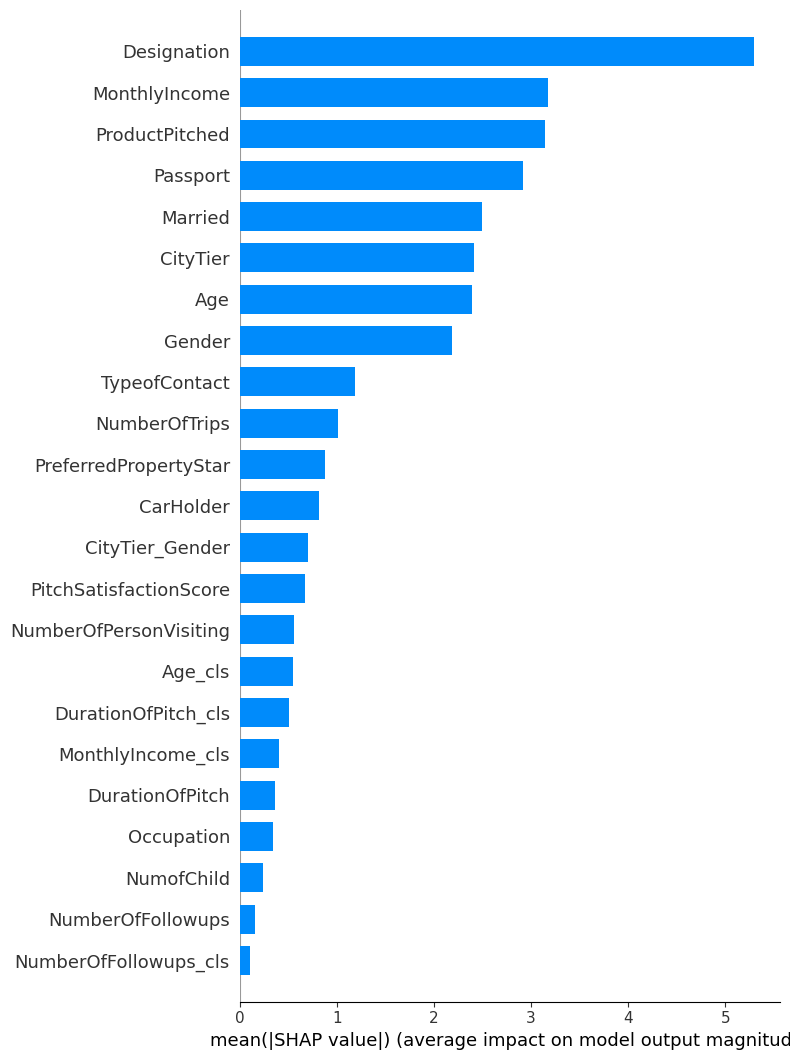

In [384]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt
shap.initjs()

# 各FOLD、SEEDの和 (相対値なのでこれで良しとする)
shapval = 0
for i in range(3):
  for j in range(5):
    explainer = shap.TreeExplainer(models[i][j])
    shap_values = explainer.shap_values(X)
    shapval = shapval + shap_values

shap.summary_plot(shapval, X,plot_type="bar", max_display=50)

In [98]:
# submit_sample.csvを読み込みます。
submit = pd.read_csv("/content/sample_submit.csv", header=None)
submit.head(1)

,0,1
0,3489,0.119451


In [100]:
# テストデータを用いて予測します。
predict = 0
for i in range(3):
  for j in range(5):
    predict = predict + models[i][j].predict(test.drop("id",axis=1))
predict = predict / 15
submit[1] = predict

In [102]:
# 提出
submit.to_csv("submission.csv", index=False, header=None)